In [1]:
# Imports

import os
import copy
import time
import json
import gc
import cv2
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from subprocess import call
from multiprocessing import Pool
from matplotlib import colors
from glob import glob
from skimage.segmentation import flood, flood_fill
from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve
from scipy import stats
from scipy.ndimage.interpolation import shift
from scipy.spatial import distance_matrix

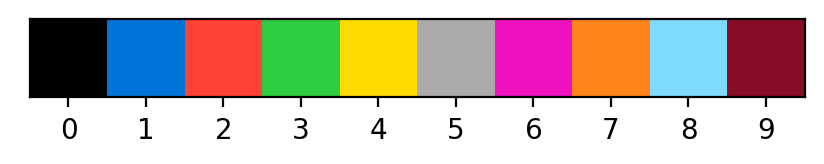

In [2]:
# Visualize Functions

cmap = colors.ListedColormap(
    ['#FFFFFF','#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=-1, vmax=9)
# -1: special flag,
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()


def getData(task_filename):
    with open(task_filename, 'r') as f:
        task = json.load(f)
    return task

def plotOne(ax, input_matrix, title_text):
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title_text)

def plotGrid(grid,title=''):
    fig = plt.figure(tight_layout=True)
    ax = fig.add_subplot(111)
    plotOne(ax, grid, title)

In [3]:
# Path Definitions

dataset_path = Path('/home/matthew/Programming/ARC/data')
training_path = dataset_path / 'training'
evaluation_path = dataset_path / 'evaluation'
test_path = dataset_path / 'test'

training_tasks = sorted(glob(str(training_path / '*')))
evaluation_tasks = sorted(glob(str(evaluation_path / '*')))
test_tasks = sorted(glob(str(test_path / '*')))

In [4]:
# Helper functions

colToRGB = np.array([[  0,  0,  0],
                     [  0,116,217],
                     [255, 65, 54],
                     [ 46,204, 64],
                     [255,220,  0],
                     [170,170,170],
                     [240, 18,190],
                     [255,133, 27],
                     [127,219,255],
                     [135, 12, 37]]) / 255.0

def pixmapToRGB(pixmap):
    x,y = pixmap.shape
    RGB = np.zeros((x,y,3))
    for i in range(x):
        for j in range(y):
            RGB[i,j] = colToRGB[pixmap[i,j]]
    return RGB

def dis(p0,p1):
    return np.sqrt(np.sum(np.square(p1 - p0),axis=0))


def reject_outliers(data, m):
    return abs(data - np.mean(data)) < m * np.std(data)

In [5]:
# Image -> List

def splitScenes(pixmap):
    def checkSplit(center):
        min_col = np.min(center)
        max_col = np.max(center)
        return min_col == max_col
    
    x,y = pixmap.shape
    scenes = []
    
    if x % 2 != 0:
        center_idx = int((x-1)/2)
        center = pixmap[center_idx]
        if checkSplit(center):
            scenes = [pixmap[:center_idx], pixmap[center_idx+1:]]
    
    if y % 2 != 0:
        center_idx = int((y-1)/2)
        center = pixmap[:,center_idx]
        if checkSplit(center):
            if len(scenes) > 0:
                all_scenes = []
                for s in scenes:
                    all_scenes.extend([s[:,:center_idx], s[:,center_idx+1:]])
                scenes = all_scenes
            else:
                scenes = [pixmap[:,:center_idx], pixmap[:,center_idx+1:]]
    
    if len(scenes) == 0: return False
    
    return scenes

def groupByContact(pixmap, connectivity=None):
    pixmap_mask = np.where(pixmap == 0, pixmap, 1)
    passed_coords = []
    splited = []
    x,y = pixmap.shape
    for i in range(x):
        for j in range(y):
            if (i,j) in passed_coords: continue
            filled = flood_fill(pixmap_mask, (i,j), -1, connectivity=connectivity)
            object_coords = np.where(filled == -1)
            passed_coords.extend(list(zip(*object_coords)))
            obj_pixmap = np.zeros((x,y))
            obj_pixmap[object_coords] = pixmap[object_coords]
            splited.append(obj_pixmap)
    l = [x for x in splited if np.any(x)]
    if len(l) == 0: return False
    return l

def groupByContactManhatten(pixmap):
    return groupByContact(pixmap,1)

def groupByContactMoore(pixmap):
    return groupByContact(pixmap,None)

def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    l = [x for x in splited if np.any(x)]
    if len(l) == 0: return False
    return l

# def selectEnclosed(pixmap):
    

def listify(args):
    return list(args)

# def applyToList(l,fn):
#     return [item for sublist in map(fn,l) for item in sublist]

# def applyToList2(l,fn):
#     return list(map(fn,l))

In [6]:
# Color Moves

def recolor(pixmap,color):
    return pixmap.astype(np.bool) * color

def color0(pixmap):
    return recolor(pixmap,0)

def color1(pixmap):
    return recolor(pixmap,1)

def color2(pixmap):
    return recolor(pixmap,2)

def color3(pixmap):
    return recolor(pixmap,3)

def color4(pixmap):
    return recolor(pixmap,4)

def color5(pixmap):
    return recolor(pixmap,5)

def color6(pixmap):
    return recolor(pixmap,6)

def color7(pixmap):
    return recolor(pixmap,7)

def color8(pixmap):
    return recolor(pixmap,8)

def color9(pixmap):
    return recolor(pixmap,9)

In [7]:
# Drop Moves

def dropColor(pixmap,color):
    if color not in np.unique(pixmap): return False
    return np.where(pixmap == color, 0, pixmap)

def drop0(pixmap):
    return dropColor(pixmap,0)

def drop1(pixmap):
    return dropColor(pixmap,1)

def drop2(pixmap):
    return dropColor(pixmap,2)

def drop3(pixmap):
    return dropColor(pixmap,3)

def drop4(pixmap):
    return dropColor(pixmap,4)

def drop5(pixmap):
    return dropColor(pixmap,5)

def drop6(pixmap):
    return dropColor(pixmap,6)

def drop7(pixmap):
    return dropColor(pixmap,7)

def drop8(pixmap):
    return dropColor(pixmap,8)

def drop9(pixmap):
    return dropColor(pixmap,9)

In [8]:
# Fill Moves

def fillColor(pixmap,color):
    if 0 not in np.unique(pixmap): return False
    return np.where(pixmap == 0, color, pixmap)

def fill0(pixmap):
    return fillColor(pixmap,0)

def fill1(pixmap):
    return fillColor(pixmap,1)

def fill2(pixmap):
    return fillColor(pixmap,2)

def fill3(pixmap):
    return fillColor(pixmap,3)

def fill4(pixmap):
    return fillColor(pixmap,4)

def fill5(pixmap):
    return fillColor(pixmap,5)

def fill6(pixmap):
    return fillColor(pixmap,6)

def fill7(pixmap):
    return fillColor(pixmap,7)

def fill8(pixmap):
    return fillColor(pixmap,8)

def fill9(pixmap):
    return fillColor(pixmap,9)

In [9]:
# Border Moves

# def borderColor(pixmap,color):
#     out = np.zeros_like(pixmap)
#     true_points = np.argwhere(pixmap)
#     if len(true_points) == 0: return False
#     top_left = true_points.min(axis=0)
#     bottom_right = true_points.max(axis=0)
#     out[top_left[0]-1:bottom_right[0]+2, top_left[1]-1:bottom_right[1]+2] = color
#     out[true_points[:,0],true_points[:,1]] = pixmap[true_points[:,0],true_points[:,1]]
#     return out

def borderColor(pixmap,color):
    pixmap = pixmap.copy()
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0: return False
    for i,j in true_points:
        for ii in range(-1,2):
            for jj in range(-1,2):
                a,b = i + ii, j + jj
                if a < 0 or b < 0 or a >= pixmap.shape[0] or b >= pixmap.shape[1]: continue
                if pixmap[a,b]: continue
                pixmap[a,b] = color
    return pixmap

def border0(pixmap):
    return borderColor(pixmap,0)

def border1(pixmap):
    return borderColor(pixmap,1)

def border2(pixmap):
    return borderColor(pixmap,2)

def border3(pixmap):
    return borderColor(pixmap,3)

def border4(pixmap):
    return borderColor(pixmap,4)

def border5(pixmap):
    return borderColor(pixmap,5)

def border6(pixmap):
    return borderColor(pixmap,6)

def border7(pixmap):
    return borderColor(pixmap,7)

def border8(pixmap):
    return borderColor(pixmap,8)

def border9(pixmap):
    return borderColor(pixmap,9)

In [10]:
# Image -> Image

def transpose(pixmap):
    x,y = pixmap.shape
    if x != y: return False
    return pixmap.T

def identity(pixmap):
    return pixmap

def connectObject(pixmap):
    coords = np.stack(np.where(pixmap > 0))
    color = np.max(pixmap)
    idx = np.array([np.min(coords,axis=1),np.max(coords,axis=1)])
    pixmap[idx[0,0]:idx[1,0]+1,idx[0,1]:idx[1,1]+1] = color
    return pixmap

def inverse(pixmap):
    negative = np.logical_not(pixmap).astype(int)
    color = max(pixmap.max(), 1)
    return negative * color

def moveObjectCenter(pixmap,center):
    coords = np.stack(np.where(pixmap > 0))
    idx = np.array([np.min(coords,axis=1),np.max(coords,axis=1)])
    print(idx)

def pushRight(pixmap):
    x,y = pixmap.shape
    outmap = np.zeros((x,y))
    for i in range(x):
        pixels = np.where(pixmap[i,:] > 0)[0]
        num_pixels = len(pixels)
        if num_pixels == 0: continue
        outmap[i,-num_pixels:] = pixmap[i,pixels]
    return outmap

def pushDown(pixmap):
    x,y = pixmap.shape
    outmap = np.zeros((x,y))
    for j in range(y):
        pixels = np.where(pixmap[:,j] > 0)[0]
        num_pixels = len(pixels)
        if num_pixels == 0: continue
        outmap[-num_pixels:,j] = pixmap[pixels,j]
    return outmap

def flipV(pixmap):
    return np.flip(pixmap,axis=0)

def flipH(pixmap):
    return np.flip(pixmap,axis=1)

def sandwich(pixmap):
    x,y = pixmap.shape
    if x > y:
        pixmap = np.swapaxes(pixmap,0,1)
    return pixmap

def scale(pixmap,factor):
    return np.kron(pixmap, np.ones((factor,factor)))

def scaleDouble(pixmap):
    return scale((pixmap,2))

def scaleTriple(pixmap):
    return scale((pixmap,3))

def tileVDouble(pixmap):
    return np.tile(pixmap, (2, 1))

def tileHDouble(pixmap):
    return np.tile(pixmap, (1, 2))

def tileVTriple(pixmap):
    return np.tile(pixmap, (3, 1))

def tileHTriple(pixmap):
    return np.tile(pixmap, (1, 3))
       
def getTile(pixmap):
    tile = pixmap.copy()
    while True:
        x,y = tile.shape
        delta = False
        if x % 2 == 0:
            idx = int(x / 2)
            t0 = tile[:idx]
            t1 = tile[idx:]
            if np.array_equal(t0, t1):
                tile = t0
                delta = True
                
        if y % 2 == 0:
            idx = int(y / 2)
            t0 = tile[:, :idx]
            t1 = tile[:, idx:]
            if np.array_equal(t0, t1):
                tile = t0
                delta = True
        if not delta:
            break
    return tile

def moveObj(pixmap,steps=1,d='right'):
    x,y = pixmap.shape
    steps = int(steps)
    
    if steps < 0:
        steps = - steps
        if d == 'right':
            d = 'left'
        elif d == 'down':
            d = 'up'
    
    if d == 'up':
        padding = np.zeros((steps,y))
        pixmap = np.vstack([pixmap,padding])[steps:, :]
    elif d == 'down':
        padding = np.zeros((steps,y))
        pixmap = np.vstack([padding,pixmap])[:x, :]
    elif d == 'right':
        padding = np.zeros((x,steps))
        pixmap = np.hstack([padding,pixmap])[:, :y]
    elif d == 'left':
        padding = np.zeros((x,steps))
        pixmap = np.hstack([pixmap,padding])[:, steps:]
    
    return pixmap
        
def twistV(pixmap):
    x,y = pixmap.shape
    out = pixmap.copy()
    for i in range(0,x,2):
        out[i,:] = out[i,:][::-1]
    return out
    
def twistH(pixmap):
    x,y = pixmap.shape
    out = pixmap.copy()
    for j in range(0,y,2):
        out[:,j] = out[:,j][::-1]
    return out

def patchPattern(pixmap,mask_color=0):
    try:
        pixmap = pixmap.copy()
        pattern = []
        x,y = pixmap.shape
        for i in range(x):
            if mask_color not in pixmap[i]:
                for j in range(y):
                    pixel = pixmap[i,j]
                    if pixel in pattern: break
                    pattern.append(pixel)
                break

        for i in range(x):
            if mask_color in pixmap[i]:
                reverse = False
                for j in range(y):
                    pixel = pixmap[i,j]
                    if pixel == 0:
                        if j == 0:
                            reverse=True
                            break
                        pidx = pattern.index(pixmap[i,j-1])
                        if pidx == len(pattern) - 1:
                            pidx = -1
                        pixmap[i,j] = pattern[pidx+1]

                if reverse:
                    for jr in list(range(y))[::-1]:
                        pixel = pixmap[i,jr]
                        if pixel == 0:
                            pidx = pattern.index(pixmap[i,jr+1])
                            pixmap[i,jr] = pattern[pidx-1]
        return pixmap
    except:
        return False
    
def cropToContent(pixmap):
    # Op argwhere will give us the coordinates of every non-zero point
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0:
        return False
    # Take the smallest points and use them as the top left of our crop
    top_left = true_points.min(axis=0)
    # Take the largest points and use them as the bottom right of our crop
    bottom_right = true_points.max(axis=0)
    # Crop inside the defined rectangle
    pixmap = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    return pixmap

def cropToBox(pixmap):
    coords = np.argwhere(pixmap)
    largestArea = -1
    for ci in coords:
        for cj in coords[::-1]:
            if np.array_equal(ci,cj): continue
            ii, ij = ci
            ji, jj = cj
            if pixmap[ii,jj] > 0 and pixmap[ji,ij] > 0:
                # Is box, crop to this area
                crop = pixmap[ii:ji+1, ij:jj+1]
                if crop.size > largestArea:
                    largestArea = crop.size
                    cropped = crop
    if largestArea > -1:
        return cropped
    else:
        return False

In [11]:
# List -> List

def sortByArea(l):

def sortByColor(l):
    s = [np.max(i) for i in l]
    l = [l[i] for _,i in sorted(zip(s,range(len(l))))]
    mode = stats.mode(s)[0]
    if len(mode) > 0:
        if np.max(l[-1]) == mode[0]:
            l = l[::-1]
    return l

def sortByCount(l):
    s = [len(np.argwhere(i.astype(np.bool))) for i in l]
    return [l[i] for _,i in sorted(zip(s,range(len(l))))]

def pushUnique(l):
    cropped = [cropToContent(x) for x in l]
    h = [''.join(list(a.flatten().astype('str'))) for a in cropped] # Create hash
    S = list(set(h)) # Get unique hashes
    if len(S) < 2: return l
    c = [h.count(i) for i in S] # Get count
    hash2c = {i: j for i,j in zip(S,c)}
    s = [hash2c[i] for i in h] # Create sort
    return [l[i] for _,i in sorted(zip(s,range(len(l))))][::-1] # Reverse by default to push towards tail

def pushUniqueColor(l):
    col = [np.max(a) for a in l]
    c = [col.count(i) for i in col]
    i = np.where(c == 1)[0]
    if len(i) != 1: return False
    idx = i[0]
    if len(l)-1 == idx: return False
    return l[:idx] + l[idx+1:] + [l[idx]]

# def pushUniqueShape(l):
    

def templateColor(l):
    matched = []
    template = tail(l)
    templateShape = template[np.where(template > 0)]
    for i in l[:-1]:
        probeIdx = np.where(i > 0)
        probeShape = i[probeIdx]
        if probeShape.shape == templateShape.shape:
            i[probeIdx] = templateShape
        matched.append(i)
    matched.append(template)
    return matched

def alignObjects(l):
    l = [x for x in l if np.max(x) > 0]
    centers = []
    for obj in l:
        true_points = np.argwhere(obj)
        if len(true_points) == 0: return False
        top_left = true_points.min(axis=0)
        bottom_right = true_points.max(axis=0)
        center = ((bottom_right - top_left)  / 2.0) + top_left
        centers.append(center)
    if len(centers) == 0: return False
    ref = centers[-1]
    mobile = centers[:-1]
    steps = [ref-c for c in mobile]
    lo = [moveObj(moveObj(x, steps=steps[idx][1], d='right'),steps=steps[idx][0], d='down') for idx,x in enumerate(l[:-1])]
    lo.append(l[-1])
    return lo

def selectSingle(l):
    s = [np.sum(i.astype(np.bool)) for i in l]
    l = [i for idx,i in enumerate(l) if s[idx] == 1]
    if len(l) == 0: return False
    return l

def selectLargest(l):
    num_pixels = [numPixels(i) for i in l]
    max_size = np.max(num_pixels)
    l = [l for l,n in zip(l,num_pixels) if n == max_size]
    if len(l) == 0: return False
    return l

In [12]:
# List -> Image

def tail(l):
    return l[-1]

def reverse(l):
    return l[::-1]

def collapse(l):
    pixmap = np.zeros(l[0].shape)
    for i in l:
        pixmap = np.where(i > 0, i, pixmap)
    return pixmap

def stackV(l):
    return np.vstack(l)

def stackH(l):
    v = np.hstack(l)
    return v

def logicAND(l):
#     g0,g1 = args
#     return np.logical_and(g0,g1) * g0
    return np.logical_and.reduce(tuple(l)) * l[0]

def logicOR(l):
    return np.logical_or.reduce(tuple(l))

def mathSum(l):
    return np.sum(l,axis=0)

def topologicalEquivalence(l):
    sizes = np.array([len(np.argwhere(p)) for p in l])
    include = reject_outliers(sizes, m=1.8)
    l = list(np.array(l)[include])
    if len(l) == 0: return False
    
    centers = []
    for obj in l:
        true_points = np.argwhere(obj)
        if len(true_points) == 0: return False
        top_left = true_points.min(axis=0)
        bottom_right = true_points.max(axis=0)
        center = ((bottom_right - top_left)  / 2.0) + top_left
        centers.append(center)
    
    centers = np.array(centers)
    centers /= np.min(centers) + 1e-10
    centers = centers.astype(np.int)
    
    x_pos = list(np.unique(centers[:,0]))
    y_pos = list(np.unique(centers[:,1]))
    x = len(x_pos)
    y = len(y_pos)
    
    pixmap = np.zeros((x,y))
    for idx,c in enumerate(centers):
        i,j = c
        i = x_pos.index(i)
        j = y_pos.index(j)
        pixmap[i,j] = np.max(l[idx])
    
    return pixmap

In [13]:
# Property -> Image

def eye(size):
    return np.eye(size)

In [14]:
# Image -> Property

def getHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2**i for i in range(len(flat))])
    return np.sum(flat * mult)

def maxColor(pixmap):
    return np.max(pixmap)

def numColor(pixmap):
    colors = list(set(pixmap.flatten()))
    colors.remove(0)
    return len(colors)

def modeColor(pixmap):
    values, counts = np.unique(x, return_counts=True)
    idx = np.where(values > 0)[0]
    values = values[idx]
    counts = counts[idx]
    print(values,counts)
    m = counts.argmax()
    return values[m] #, counts[m]

def numPixels(pixmap):
    return len(np.argwhere(pixmap))

In [15]:
# Color Map Functions

def checkColorMap(task):
    c = 1
    for example in task['train']:
        inp = np.array(example['input'])
        out = np.array(example['output'])
        a = sorted(list(map(getHash,groupByColor(inp))))
        b = sorted(list(map(getHash,groupByColor(out))))
        c *= a == b
    return bool(c)

def findColorMap(task):
    colormap = {}
    for example in task['train']:
        inp = np.array(example['input']).flatten()
        out = np.array(example['output']).flatten()
        for col, idx in zip(*np.unique(inp,return_index=True)):
            if col in colormap.keys(): continue
            colormap[col] = out[idx]
    return colormap

def applyColorMap(pixmap, colormap):
    return np.vectorize(colormap.__getitem__)(pixmap)

def flattenPred(pred):
    return str(pred.astype(np.int)) \
                   .replace(' ','') \
                   .replace('[[','|') \
                   .replace(']\n[','|') \
                   .replace(']]','|')

def plotTest(t_in, t_out, t_pred):
    fig, axs = plt.subplots(3, 1, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    axs[0].imshow(t_in, cmap=cmap, norm=norm)
    axs[0].set_title(f'Test-{i} in')
    axs[0].set_yticks(list(range(t_in.shape[0])))
    axs[0].set_xticks(list(range(t_in.shape[1])))
    axs[1].imshow(t_out, cmap=cmap, norm=norm)
    axs[1].set_title(f'Test-{i} out')
    axs[1].set_yticks(list(range(t_out.shape[0])))
    axs[1].set_xticks(list(range(t_out.shape[1])))
    axs[2].imshow(t_pred, cmap=cmap, norm=norm)
    axs[2].set_title(f'Test-{i} pred')
    axs[2].set_yticks(list(range(t_pred.shape[0])))
    axs[2].set_xticks(list(range(t_pred.shape[1])))

# task_id = training_path / 'b1948b0a.json'
# task = getData(task_id)
# # checkColorMap(task)
# colormap = findColorMap(task)
# test = np.array(task['test'][0]['input'])
# plotTask(task)
# plotGrid(applyColorMap(test,colormap))

# submission = pd.read_csv(dataset_path / 'sample_submission.csv')
# test_tasks = submission['output_id'].values

# predictions = []
# for output_id in test_tasks:
#     task_id, grid_id = output_id.split('_')
#     task_id = test_path / ('%s.json' % task_id)
#     task = getData(task_id)
#     if checkColorMap(task):
#         colormap = findColorMap(task)
#         test_in = np.array(task['test'][output_id]['input'])
#         test_out = np.array(task['test'][output_id]['output'])
#         pred = applyColorMap(test_in,colormap)
#         plotTest(test_in,test_out,pred)
#         #correct = np.array_equal(pred,test_out)
#     else:
#         pred = np.zeros((1,1))
#     predictions.append(flattenPred(pred))

# submission["output"] = predictions
# submission.head()
# submission.to_csv('submission.csv', index=False)

In [39]:
# Move Collections
def loadMoves():
    move_df = pd.read_csv('moves_orig.csv')
    move_df = move_df[move_df.fnBool == 1]
    return move_df

move_df = loadMoves()

def evalFnList(l):
    return [eval(fn) for fn in l]

def getMovesByGroup(group):
    return evalFnList(move_df[move_df[group] == 1].fnName.values)

def getMovesByInput(t):
    return evalFnList(move_df[move_df.inputType == t].fnName.values)

def getMovesByOutput(group):
    return evalFnList(move_df[move_df.outputType == t].fnName.values)

def functionToOutput(fnName):
    return move_df[move_df.fnName == fnName].outputType.values[0]

def in_fn():
    return

fnToOutput = {fnName : functionToOutput(fnName) for fnName in move_df.fnName.values}
fnToOutput['in_fn'] = 'image'

baseMoves = getMovesByGroup('baseMove')
reColorMoves = getMovesByGroup('reColor')
dropColorMoves = getMovesByGroup('dropColor')
fillColorMoves = getMovesByGroup('fillColor')
borderColorMoves = getMovesByGroup('borderColor')
startOnlyMoves = getMovesByGroup('startOnly')
endMoves = getMovesByGroup('endMove')
useOnceMoves = getMovesByGroup('numUses')
changesSizeMoves = getMovesByGroup('changesSize')
commutitiveMoves = getMovesByGroup('commutitive')
inpImageMoves = getMovesByInput('image')
inpListMoves = getMovesByInput('list')
inpPropMoves = getMovesByInput('prop')

In [40]:
# Hard-coded Graphs
# c,t = 0,0

# task_id = training_path / '74dd1130.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],transpose)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'a416b8f3.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],identity)
# G.addNode([0,1],listify)
# G.addNode([2],stackH)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'b91ae062.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],numColor)
# G.addNode([0,1],scale)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'f25ffba3.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],flipV)
# G.addNode([0,1],listify)
# G.addNode([2],collapse)
# c += G.evaluate()
# t += 1

# task_id = training_path / '6150a2bd.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],flipV)
# G.addNode([1],flipH)
# c += G.evaluate()
# t += 1

# task_id = training_path / '007bbfb7.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],scaleTriple)
# G.addNode([0],tileV)
# G.addNode([2],tileH)
# G.addNode([3,1],logicAnd)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'f2829549.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],splitScenes)
# G.addNode([1],collapse)
# G.addNode([2],inverse)
# G.addNode([3],color3)
# c += G.evaluate()
# t += 1

# task_id = training_path / '7468f01a.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],cropToContent)
# G.addNode([1],flipH)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'd0f5fe59.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],groupByContact)
# G.addNode([1],len)
# G.addNode([0],maxColor)
# G.addNode([3,2],eye)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'e76a88a6.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],groupByContact)
# G.addNode([1],sortByColor)
# G.addNode([2],templateColor)
# G.addNode([3],collapse)
# c += G.evaluate()
# t += 1

# task_id = training_path / '2dc579da.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],splitScenes)
# G.addNode([1],pushUnique)
# G.addNode([2],tail)
# c += G.evaluate()
# t += 1

# task_id = training_path / '6fa7a44f.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],flipV)
# G.addNode([0,1],listify)
# G.addNode([2],stackV)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'f76d97a5.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],drop5)
# G.addNode([1],inverse)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'aedd82e4.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],selectSingle)
# G.addNode([1],collapse)
# G.addNode([2],color1)
# G.addNode([0,3],listify)
# G.addNode([4],collapse)
# c += G.evaluate()
# t += 1

# task_id = training_path / 'a61f2674.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],groupByContact)
# G.addNode([1],sortByArea)
# G.addNode([2],tail)
# G.addNode([2],reverse)
# G.addNode([4],tail)
# G.addNode([3],color1)
# G.addNode([5],color2)
# G.addNode([6,7],listify)
# G.addNode([8],collapse)
# c += G.evaluate()
# t += 1

# task_id = training_path / '9565186b.json'
# task = getData(task_id)
# G = Graph(task)
# G.addNode([0],groupByColor)
# G.addNode([1],sortByArea)
# G.addNode([2],tail)
# G.addNode([3],fill5)
# c += G.evaluate()
# t += 1

# # task_id = training_path / 'cce03e0d.json'
# # task = getData(task_id)
# # G = Graph()
# # G.addNode([0],groupByColor)
# # G.addNode([1],pushUnique)
# # G.addNode([2],reverse)
# # G.addNode([3],tail)
# # G.addNode([4],scaleTriple)
# # G.addNode([0],tileV)
# # G.addNode([6],tileH)
# # G.addNode([5,7],logicAnd) # Issue with logicalAnd multiplication
# # c += evaluateGraph(G,task)
# # t += 1

# print(c == t)

In [41]:
# Old Graph functions



    
#     def updateValues(self,idx):
#         step = len(self.V[idx])
#         while step < self.n:
#             fn = self.X[step]
#             v = fn(self.V[idx][-1])
#             if type(v) == bool or type(v) == None:
#                 if not v:
#                     self.prune = True
#                     return
#             self.V[idx].append(v)
#             step += 1



# commutitive hash
        #return '-'.join([str(fn_to_idx[x]) for x in self.X[1:]])
#         commMask = [0] + [1 if m in commutitiveMoves else 0 for m in self.X[1:]]
#         clusterMask = []
#         cluster = 1
#         hot = False
#         for m in commMask:
#             if m:
#                 hot = True
#                 clusterMask.append(cluster)
#             else:
#                 if hot:
#                     cluster += 1
#                     hot = False
#                 clusterMask.append(0)
#         print(clusterMask)
#         numClust = max(clusterMask)
#         cluster_hashes = {}
#         for i in range(1,numClust+1):
#             cluster_hashes[i] = sorted([self.X[i].__name__ for i in np.where(clusterMask == i)[0]])
#         parts = ['input']
#         skip = -1
#         for i,m in enumerate(clusterMask):
#             if i == 0: continue
#             if m:
#                 if m == skip: continue
#                 skip = m
#                 parts.extend(cluster_hashes[m])
#             else:
#                 parts.append(self.X[i].__name__)
#         print(parts)
#         self.hash = '-'.join(parts)
#         print(self.hash)


#     def getAdjMat(self):
#         return self.A
    
#     def getAdjacent(self,v):
#         return np.where(self.A[v] == 1)[0]
    


#     def updateAdjMat(self,c):
#         adj = np.zeros((self.n, self.n))
#         adj[:-1,:-1] = self.A
#         adj[self.n-1,c] = 1
#         adj[c,self.n-1] = 1
#         self.A = adj
    

#     def run(self,x):
#         self.x = {0 : x}
#         queue = [0]
#         discovered = [0]
        
#         while len(queue) > 0:
#             v = queue.pop(0)
#             fn = self.X[v]
#             adj = self.getAdjacent(v)
#             parents = [w for w in adj if w in self.x.keys()]
#             if fn:
#                 args = [self.x[w] for w in parents]
#                 if len(args) == 1:
#                     args = args[0]
#                 r = fn(args)
#                 if type(r) == bool:
#                     if not r: continue
#                 self.x[v] = r
#             if v == self.n - 1:
#                 return self.x[self.n - 1]
#             for w in adj:
#                 if w in discovered: continue
#                 discovered.append(w)
#                 queue.append(w)
#             queue.sort()
            
#     def evaluate(self,vis=False,force=False):
#         for example in self.task['train']:
#             input_grid = np.array(example['input'])
#             output_grid = np.array(example['output'])

#             if force:
#                 try:
#                     pred_grid = self.run(input_grid)
#                 except:
#                     return False
#             else:
#                 pred_grid = self.run(input_grid)

#             if vis:
#                 plotGrid(input_grid)
#                 plotGrid(output_grid)
#                 plotGrid(pred_grid)

#             correct = np.array_equal(output_grid, pred_grid)
#             if not correct: return False
#         return True

In [42]:
# Search Opt

def optimizeSearch():
    task_id = training_path / '5bd6f4ac.json'
    task = getData(task_id)
    result, data = solutionSearch(task,return_data=True)
    df = pd.DataFrame(data,columns=['graph','time']).sort_values(by='time',ascending=False)
    return df

# df = optimizeSearch()

In [43]:
# def summaryTree(data):
    
# def cropToLargestBox(pixmap):
#     largest_area = -1
#     largest_points = []
#     for col in range(10):
#         l = zip(*np.where(pixmap == col))
#         for pi in l:
#             for pj in l:
#                 if pi == pj: continue
#                 if pixmap[pi[0],pj[1]] == col and pixmap[pj[0],pi[1]] == col:
#                     area = (pj[0] - pi[0]) * (pj[1] - pi[1])
#                     if area > largest_area:
#                         largest_area = area
#                         largest_points = [pi,pj]
#     try:
#         return pixmap[largest_points[0][0]:largest_points[1][0]+1, largest_points[0][1]:largest_points[1][1]+1]
#     except:
#         return False


# def denoise(pixmap):
#     x,y = pixmap.shape
#     outmap = np.zeros((x,y))
#     grid_points = np.array(list(itertools.product(*[range(x),range(y)])))
    
#     for pos in grid_points:
#         dis = np.sqrt(np.sum(np.square(grid_points - pos),axis=1))
#         i,j = zip(*grid_points[np.where(dis <= 1.5)])
#         neighbors = pixmap[i,j]
#         val,count = mode(neighbors)
#         outmap[i,j] = val
        
#     return outmap


In [46]:
# Graph and solution search

class Task:
    def __init__(self, task_path):
        self.task_path = str(task_path)
        self.task_id = self.task_path.split('/')[-1]
        task = getData(self.task_path)
        self.train = task['train']
        self.train_n = len(self.train) # Number of train examples
        self.test = task['test']
        self.test_n = len(self.test) # Number of test examples
        self.x = [np.array(ex['input']) for ex in self.train] # Train input values
        self.y = [np.array(ex['output']) for ex in self.train] # Train output values
        self.test_x = [np.array(ex['input']) for ex in self.test] # Test input values
        self.test_y = [np.array(ex['output']) for ex in self.test] # Test output values
        self.parseScenes()
    
    def predictOutputShape(self):
        self.x_shapes = [x.shape for x in self.x]
        self.y_shapes = [x.shape for x in self.y]
        test_x_shapes = [x.shape for x in self.test_x]
        output_shapes = [(3,3)] * len(test_x_shapes)
        
        io_ratio = [(j[0] / i[0], j[1] / i[1]) for i,j in zip(self.x_shapes,self.y_shapes)]
        io_diff =  [(j[0] - i[0], j[1] - i[1]) for i,j in zip(self.x_shapes,self.y_shapes)]

        if len(list(set(io_ratio))) == 1: # Output shapes have the same input/output ratio
            io_ratio = io_ratio[0]
            output_shapes = [(shape[0] * io_ratio[0], shape[1] * io_ratio[1]) for shape in test_x_shapes]
            if io_ratio[0] == 1 and io_ratio[1] == 1:
                self.knowledge['output_type'] = 'input-shape'
            else:
                self.knowledge['output_type'] = 'same-ratio'
            self.knowledge['output_shapes'] = output_shapes
        elif len(list(set(io_diff))) == 1: # Output shapes have the same input/output difference
            io_diff = io_diff[0]
            output_shapes = [(shape[0] + io_diff[0], shape[1] + io_diff[1]) for shape in test_x_shapes]
            self.knowledge['output_type'] = 'same-diff'
            self.knowledge['output_shapes'] = output_shapes
        elif len(list(set(self.y_shapes))) == 1: # Outputs have the same shape
            output_shapes = [self.y_shapes[0]] * len(test_x_shapes)
            self.knowledge['output_type'] = 'same-shape'
            self.knowledge['output_shapes'] = output_shapes
        else:
            self.knowledge['output_type'] = None
            self.knowledge['output_shapes'] = None
           
    def parseScenes(self):
        self.knowledge = {}
        self.predictOutputShape()
        
        # Is input copied into output?
        self.knowledge['input-copy'] = False
        if self.knowledge['output_type'] == 'input-shape':
            inp_coords = [(c[:,0],c[:,1]) for c in [np.argwhere(inp) for inp in self.x]]
            if sum([1 for i in range(self.train_n) if np.array_equal(self.y[i][inp_coords[i][0],inp_coords[i][1]],self.x[i][inp_coords[i][0],inp_coords[i][1]])]):
                self.knowledge['input-copy'] = True
        
        # Are the orientation of input scenes (landscape v. portrait) constant or variable throughout examples?
        self.knowledge['hw_ratio'] = 'constant'
        hw_ratio = [x.shape[0]/x.shape[1] for x in self.x]
        if min(hw_ratio) < 1.0 and max(hw_ratio) > 1.0:
            self.knowledge['hw_ratio'] = 'variable'
        
        self.getPossibleMoves()
                
    def getPossibleMoves(self):
        self.possibleMoves = copy.copy(baseMoves)
        
        input_colors = np.array([[1 if c in pm else 0 for c in range(10)] for pm in self.x])
        input_colors_const = np.where(np.sum(input_colors,axis=0) == len(input_colors))[0]
        
        output_colors = np.array([[1 if c in pm else 0 for c in range(10)] for pm in self.y])
        output_colors_const = np.where(np.sum(output_colors,axis=0) == len(output_colors))[0]
        
        if self.knowledge['output_type'] != 'input-shape':
            self.possibleMoves.extend([cropToContent])
            vertical_growth = sum([1 for idx,x in enumerate(self.x) if x.shape[0] < self.y[idx].shape[0]]) > 0
            horizontal_growth = sum([1 for idx,x in enumerate(self.x) if x.shape[1] < self.y[idx].shape[1]]) > 0
            if vertical_growth:
                self.possibleMoves.extend([tileVDouble])
            if horizontal_growth:
                self.possibleMoves.extend([tileHDouble])
            if vertical_growth and horizontal_growth:
                self.possibleMoves.extend([scaleDouble,scaleTriple])
        
        if self.knowledge['hw_ratio'] == 'variable':
            self.possibleMoves.append(sandwich)
        
        # Add color moves
#         self.possibleMoves.extend([reColorMoves[i] for i in output_colors_const])
#         self.possibleMoves.extend([borderColorMoves[i] for i in output_colors_const])
#         self.possibleMoves.extend([dropColorMoves[i] for i in input_colors_const if i not in output_colors_const])
        self.possibleMoves.extend(dropColorMoves)
        if 0 not in output_colors_const: self.possibleMoves.extend([fillColorMoves[i] for i in output_colors_const])
        
        self.possibleImageMoves = [m for m in self.possibleMoves if m in inpImageMoves]
        self.possibleListMoves = [m for m in self.possibleMoves if m in inpListMoves]
        self.possiblePropMoves = [m for m in self.possibleMoves if m in inpPropMoves]
    
    def getNextMoves(self,G):
        actions = G.X
        lastMove = actions[-1]
        if lastMove in endMoves: return []
        lastMoveName = lastMove.__name__
        lastOutput = fnToOutput[lastMoveName]
        removeMoves = [m for m in actions if m in useOnceMoves or m == lastMove]
        
        if lastOutput == 'image':
            imageMovesP = [m for m in self.possibleImageMoves if m not in removeMoves]
            if G.n > 1:
                imageMovesP = [act for act in imageMovesP if act not in startOnlyMoves]
            if 'color' in G.hash:
                imageMovesP = [act for act in imageMovesP if act not in reColorMoves]
            return imageMovesP
        
        elif lastOutput == 'list':
            listMovesP =  [m for m in self.possibleListMoves  if m not in removeMoves]
            lSort = [sortByColor,sortByArea,collapse]
            if lastMove in lSort:
                listMovesP = [act for act in listMovesP if act not in lSort]
            if 'group' in lastMoveName:
                removeMoves.append(collapse)
            return listMovesP

        elif lastOutput == 'prop':
            return self.possiblePropMoves
    
    def getMoveTiming(self):
        timing = {}
        for G_hash,G in self.graphs.items():
            move = G_hash.split('-')[-1]
            if move not in timing.keys(): timing[move] = 0.0
            timing[move] += G.time
        return timing
    
    def plotTree(self,size=2):
        filename = '%s_tree.dot' % self.task_id
        fo = open(filename,'w')
        fo.write('digraph G { \n\n')
        fo.write('\tnode [shape=record fontname=Arial];\n')
        
        dd = {} # Collect 
        di = {}
        
        depth = 1
        i = 0
        
        while depth <= size:
            hashes = [h for h in self.graphs.keys() if h.count('-') == depth-1]
            for G_hash in hashes:
                G = self.graphs[G_hash]
                children = [h for h in self.graphs.keys() if h[:len(G_hash)] == G_hash and h != G_hash]
                ichildren = [h for h in children if h.count('-') == depth]
                time = G.time + sum([self.graphs[h].time for h in children])
                fo.write('\t%d  [label="%s' % (i,G_hash) + r'\n' + '%.4f"]\n' % time)
                dd[G_hash] = i
                di[i] = ichildren
                i += 1
            depth += 1
        
        nodes = dd.keys()
        for key,val in di.items():
            for h in val:
                if h in nodes: fo.write('\n\t%s -> %s' % (key,dd[h]))
        
        fo.write('\n\n}')
        fo.close()
        
        os.system('dot -Tpng %s -o %s' % (filename,filename.replace('dot','png')))
         
    def plot(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """ 
        num_tot = self.train_n + self.test_n
        fig, axs = plt.subplots(2, num_tot, figsize=(3*num_tot,3*2))
        for i in range(self.train_n):
            plotOne(axs[0,i],self.x[i],'train input')
            plotOne(axs[1,i],self.y[i],'train output')
        i+=1
        for j in range(self.test_n):
            plotOne(axs[0,i+j],self.test_x[j],'test input')
            plotOne(axs[1,i+j],self.test_y[j],'test output')  
        plt.tight_layout()
        plt.show()
            
    def findSolution(self,verbose=False):
        G = Graph()
        queue = [G.hash]
        self.graphs = {G.hash : G}
        self.data = {'input'  : self.x,
                     'output' : self.y}
        
        time_x = 0.0
        t0 = time.time()
        while len(queue) > 0:
            G_hash = queue.pop(0)
            G = self.graphs[G_hash]
            
            if G.n > 6: break
            if G.timeEvaluate(self.data,self.knowledge):
                print('%s : %s' % (self.task_id, G_hash))
                self.solution = G_hash
                print(time_x, time.time() - t0)
                return G_hash
            if G.prune: continue
            if verbose: print(G_hash)
            
            for move in self.getNextMoves(G):
                G_copy = copy.deepcopy(G)
                G_copy.addNode([G.n],move)
                G_copy_hash = G_copy.hash
                self.data[G_copy_hash] = [None] * self.train_n
                if G_copy_hash in self.graphs.keys(): continue
                self.graphs[G_copy_hash] = G_copy
                queue.append(G_copy_hash)
        
        print('%s : failure' % self.task_id)
        self.solution = False
        return False
                
class Graph:
    def __init__(self,G_hash=None):
        if G_hash:
            self.hash = G_hash
            if 'input-' in G_hash: G_hash = G_hash[6:]
            self.Xn = G_hash.split('-')
            self.n = len(self.Xn) + 1
            self.X = [eval(fn) for fn in self.Xn]
            self.prune = False
            self.time = 0.0
        else:
            self.n = 1 # Number of nodes (including input node)
            self.X = [in_fn] # Function list
            self.prune = False # Flag to prune applications with this subgraph
            self.hash = 'input'
            self.time = 0.0
    
    def addNode(self,c,fn):
        fnName = fn.__name__
        self.n += 1
        self.X.append(fn)
        self.hash += '-%s' % fnName

    def findMaximumSubgraph(self,idx,data):
        h = self.hash
        keys = data.keys()
        while True:
            if h in keys:
                if type(data[h][idx]) != type(None):
                    # Found max subgraph with data
                    return h
            h = h[::-1].split('-',1)[-1][::-1]
    
    def timeEvaluate(self,data,knowledge):
        startTime = time.time()
        correct = self.evaluate(data,knowledge)
        endTime = time.time()
        self.time = endTime - startTime
        return correct
    
    def evaluate(self,data,knowledge):
        if fnToOutput[self.X[-1].__name__] != 'image': return False
        
        for i in range(len(data['input'])):
            h = self.findMaximumSubgraph(i,data)
            while h != self.hash:
                lastData = data[h][i]
                fnName = self.hash[len(h)+1:].split('-',1)[0]
                fn = eval(fnName)
                h += '-%s' % fnName
                v = fn(lastData)
                if type(v) == bool or type(v) == type(None):
                    if not v:
                        self.prune = True
                        return False
                data[h][i] = v
            
            y_hat = data[h][i].copy()
            y = data['output'][i]
            
            if knowledge['output_type'] == 'input-shape':
                if y_hat.shape != y.shape: return False
            
            if knowledge['input-copy']:
                inputp = data['input'][i]
                y_hat = np.where(inputp > 0, inputp, y_hat)
            
            correct = np.array_equal(y, y_hat)
            if not correct: return False
        return True

/home/matthew/Programming/ARC/data/training/6d75e8bb.json


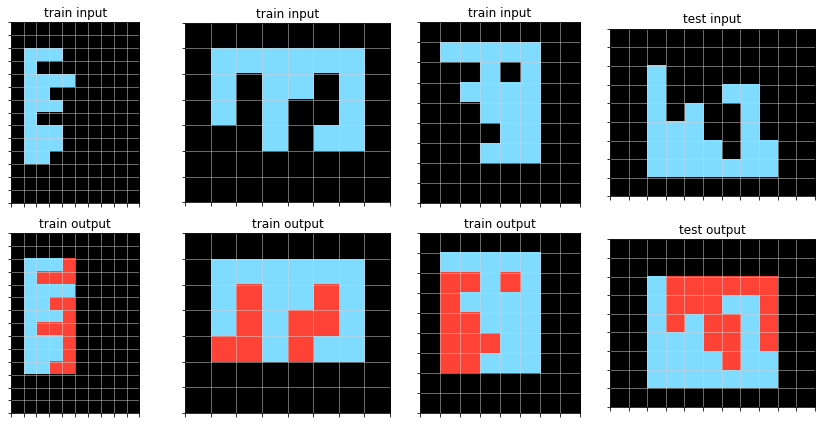

In [47]:
# View Tasks

def viewRandomTask():
    task_id = np.random.choice(training_tasks)
    print(task_id)
    task = Task(task_id)
    task.plot()
    
viewRandomTask()


In [48]:
# Task List

solved_tasks = ['31aa019c.json','23b5c85d.json','b27ca6d3.json','28bf18c6.json',
                '74dd1130.json','f2829549.json','7468f01a.json','2dc579da.json',
                '6150a2bd.json','9dfd6313.json','a740d043.json','1e0a9b12.json',
                'f76d97a5.json','67a3c6ac.json','39a8645d.json','3906de3d.json',
                '7b7f7511.json','a1570a43.json','780d0b14.json','1f85a75f.json',
                '4258a5f9.json','1b2d62fb.json','e9afcf9a.json','e98196ab.json',
                '1cf80156.json','c3f564a4.json','b1948b0a.json','99b1bc43.json',
                'c8f0f002.json','d0f5fe59.json','88a62173.json','ce4f8723.json',
                'a87f7484.json']

print(len(solved_tasks))

# Tasks Requiring DAG
graph_tasks = ['b91ae062.json','f9012d9b.json','c9e6f938.json','5582e5ca.json']

difficult_tasks = ['469497ad.json']

# Remove tasks
remove_tasks = solved_tasks + graph_tasks + difficult_tasks
a = len(training_tasks)
training_tasks = [p for p in training_tasks if p.split('/')[-1] not in remove_tasks]
b = len(training_tasks)
print('%d removed' % (a-b))


# List of Solved Tasks
# c3f564a4.json : input-patchPattern
# 4258a5f9.json : input-border1
# 74dd1130.json : input-transpose
# 9dfd6313.json : input-transpose
# 7b7f7511.json : input-getTile
# 1e0a9b12.json : input-pushDown
# 1cf80156.json : input-cropToContent
# c8f0f002.json : input-drop7-border5
# b1948b0a.json : input-drop6-fill2
# f76d97a5.json : input-drop5-inverse
# a740d043.json : input-drop1-cropToContent
# 67a3c6ac.json : input-flipH
# 6150a2bd.json : input-flipH-flipV
# 7468f01a.json : input-flipH-cropToContent
# e9afcf9a.json : input-flipV-twistH
# 3906de3d.json : input-flipV-pushDown-flipV
# 28bf18c6.json : input-cropToContent-tileHDouble
# e98196ab.json : input-splitScenes-collapse
# ce4f8723.json : input-splitScenes-collapse-color3
# 88a62173.json : input-splitScenes-pushUnique-tail
# 2dc579da.json : input-splitScenes-pushUnique-collapse
# f2829549.json : input-splitScenes-collapse-inverse-color3
# 1b2d62fb.json : input-splitScenes-collapse-inverse-color8
# 99b1bc43.json : input-splitScenes-mathSum-drop3-color3
# d0f5fe59.json : input-groupByContactManhatten-len-eye-color8
# 780d0b14.json : input-groupByContactMoore-topologicalEquivalence
# 39a8645d.json : input-groupByContactMoore-sortByColor-reverse-tail-cropToContent
# b27ca6d3.json : input-groupByContactManhatten-selectLargest-collapse-border3
# 1f85a75f.json : input-groupByContactManhatten-sortByArea-tail-cropToContent
# a1570a43.json : input-groupByColor-alignObjects-collapse
# 31aa019c.json : input-groupByColor-selectSingle-collapse-border2
# a87f7484.json : input-groupByColor-sortByArea-tail-cropToContent
# 23b5c85d.json : input-groupByColor-sortByArea-reverse-tail-cropToContent


# List of DAG Tasks
# b91ae062.json
# input -> [identity, numColor] -> scale(pixmap,factor)

# f9012d9b.json
# input -> [inverse, patchPattern] -> logicalAnd(pixmap1,pixmap2)

# c9e6f938.json
# input -> [identity, flipH] -> stackH

# 5582e5ca.json
# input -> [identity, modeColor] -> reColor(pixmap,color)

33
0 removed


In [49]:
def solve(task_path,plot=False,plotTree=True,getTiming=False,verbose=False):
    task = Task(task_path)
    if plot: task.plot()
    task.findSolution(verbose=verbose)
    if plotTree: task.plotTree()
    if getTiming: print(task.getMoveTiming())

In [50]:
def run_solve():
    p = Pool(3)
    training_examples = [training_path / prob for prob in solved_tasks]
    p.map(solve,training_examples)

In [51]:
run_solve()

7468f01a.json : input-flipH-cropToContent
0.0 0.015441417694091797
2dc579da.json : input-splitScenes-pushUnique-collapse
0.0 0.18158984184265137
6150a2bd.json : input-flipH-flipV
0.0 0.010351181030273438
9dfd6313.json : input-transpose
0.0 0.002862691879272461
31aa019c.json : failure


Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-49-c148ecd26888>", line 4, in solve
    task.findSolution(verbose=verbose)
  File "<ipython-input-46-046dda2289db>", line 199, in fin

KeyboardInterrupt: 

  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/matthew/anaconda3/envs/ml/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-49-c148ecd26888>", line 4, in solve
    task.findSolution(verbose=verbose)
  File "<ipython-input-49-c148ecd26888>", line 4, in solve
    task.findSolution(verbose=verbose)
  File "<ipython-input-46-046dda2289db>", line 199, in findSolution
    G_hash = queue.pop(0)
KeyboardInterrupt
  File "<

In [382]:
solve(training_path / 'a87f7484.json')

a87f7484.json : input-groupByColor-sortByArea-tail-cropToContent
0.0 24.0947585105896


In [199]:
# 39a8645d.json : input-groupByContactMoore-sortByColor-pushUnique-tail-cropToContent
solve(training_path / '39a8645d.json',verbose=True,plotTree=True)

input
input-transpose
input-inverse
input-flipH
input-flipV
input-pushDown
input-pushRight
input-splitScenes
input-groupByColor
input-tileVDouble
input-tileHDouble
input-groupByContactManhatten
input-groupByContactMoore
input-getTile
input-twistV
input-twistH
input-color0
input-border0
input-drop0
input-drop2
input-drop8
input-transpose-inverse
input-transpose-flipH
input-transpose-flipV
input-transpose-pushDown
input-transpose-pushRight
input-transpose-tileVDouble
input-transpose-tileHDouble
input-transpose-getTile
input-transpose-twistV
input-transpose-twistH
input-transpose-color0
input-transpose-border0
input-transpose-drop0
input-transpose-drop2
input-transpose-drop8
input-inverse-transpose
input-inverse-flipH
input-inverse-flipV
input-inverse-pushDown
input-inverse-pushRight
input-inverse-tileVDouble
input-inverse-tileHDouble
input-inverse-getTile
input-inverse-twistV
input-inverse-twistH
input-inverse-color0
input-inverse-border0
input-inverse-drop0
input-inverse-drop8
input-fli

input-transpose-drop8-tileVDouble
input-transpose-drop8-tileHDouble
input-transpose-drop8-getTile
input-transpose-drop8-twistV
input-transpose-drop8-twistH
input-transpose-drop8-color0
input-transpose-drop8-border0
input-transpose-drop8-drop0
input-transpose-drop8-drop2
input-inverse-transpose-inverse
input-inverse-transpose-flipH
input-inverse-transpose-flipV
input-inverse-transpose-pushDown
input-inverse-transpose-pushRight
input-inverse-transpose-tileVDouble
input-inverse-transpose-tileHDouble
input-inverse-transpose-getTile
input-inverse-transpose-twistV
input-inverse-transpose-twistH
input-inverse-transpose-color0
input-inverse-transpose-border0
input-inverse-transpose-drop0
input-inverse-transpose-drop8
input-inverse-flipH-transpose
input-inverse-flipH-inverse
input-inverse-flipH-flipV
input-inverse-flipH-pushDown
input-inverse-flipH-pushRight
input-inverse-flipH-tileVDouble
input-inverse-flipH-tileHDouble
input-inverse-flipH-getTile
input-inverse-flipH-twistV
input-inverse-flipH

input-flipV-inverse-getTile
input-flipV-inverse-twistV
input-flipV-inverse-twistH
input-flipV-inverse-color0
input-flipV-inverse-border0
input-flipV-inverse-drop0
input-flipV-inverse-drop8
input-flipV-flipH-transpose
input-flipV-flipH-inverse
input-flipV-flipH-flipV
input-flipV-flipH-pushDown
input-flipV-flipH-pushRight
input-flipV-flipH-tileVDouble
input-flipV-flipH-tileHDouble
input-flipV-flipH-getTile
input-flipV-flipH-twistV
input-flipV-flipH-twistH
input-flipV-flipH-color0
input-flipV-flipH-border0
input-flipV-flipH-drop0
input-flipV-flipH-drop2
input-flipV-flipH-drop8
input-flipV-pushDown-transpose
input-flipV-pushDown-inverse
input-flipV-pushDown-flipH
input-flipV-pushDown-flipV
input-flipV-pushDown-pushRight
input-flipV-pushDown-tileVDouble
input-flipV-pushDown-tileHDouble
input-flipV-pushDown-getTile
input-flipV-pushDown-twistV
input-flipV-pushDown-twistH
input-flipV-pushDown-color0
input-flipV-pushDown-border0
input-flipV-pushDown-drop0
input-flipV-pushDown-drop2
input-flipV-

input-pushRight-tileVDouble-twistV
input-pushRight-tileVDouble-twistH
input-pushRight-tileVDouble-color0
input-pushRight-tileVDouble-border0
input-pushRight-tileVDouble-drop0
input-pushRight-tileVDouble-drop2
input-pushRight-tileVDouble-drop8
input-pushRight-tileHDouble-inverse
input-pushRight-tileHDouble-flipH
input-pushRight-tileHDouble-flipV
input-pushRight-tileHDouble-pushDown
input-pushRight-tileHDouble-tileVDouble
input-pushRight-tileHDouble-getTile
input-pushRight-tileHDouble-twistV
input-pushRight-tileHDouble-twistH
input-pushRight-tileHDouble-color0
input-pushRight-tileHDouble-border0
input-pushRight-tileHDouble-drop0
input-pushRight-tileHDouble-drop2
input-pushRight-tileHDouble-drop8
input-pushRight-getTile-transpose
input-pushRight-getTile-inverse
input-pushRight-getTile-flipH
input-pushRight-getTile-flipV
input-pushRight-getTile-pushDown
input-pushRight-getTile-tileVDouble
input-pushRight-getTile-tileHDouble
input-pushRight-getTile-twistV
input-pushRight-getTile-twistH
inpu

input-groupByColor-mathSum-flipH
input-groupByColor-mathSum-flipV
input-groupByColor-mathSum-pushDown
input-groupByColor-mathSum-pushRight
input-groupByColor-mathSum-tileVDouble
input-groupByColor-mathSum-tileHDouble
input-groupByColor-mathSum-getTile
input-groupByColor-mathSum-twistV
input-groupByColor-mathSum-twistH
input-groupByColor-mathSum-color0
input-groupByColor-mathSum-border0
input-groupByColor-mathSum-drop0
input-groupByColor-mathSum-drop2
input-groupByColor-mathSum-drop8
input-tileVDouble-inverse-flipH
input-tileVDouble-inverse-flipV
input-tileVDouble-inverse-pushDown
input-tileVDouble-inverse-pushRight
input-tileVDouble-inverse-tileHDouble
input-tileVDouble-inverse-getTile
input-tileVDouble-inverse-twistV
input-tileVDouble-inverse-twistH
input-tileVDouble-inverse-color0
input-tileVDouble-inverse-border0
input-tileVDouble-inverse-drop0
input-tileVDouble-inverse-drop8
input-tileVDouble-flipH-inverse
input-tileVDouble-flipH-flipV
input-tileVDouble-flipH-pushDown
input-tileVDo

input-groupByContactManhatten-alignObjects-mathSum
input-groupByContactManhatten-topologicalEquivalence-inverse
input-groupByContactManhatten-topologicalEquivalence-flipH
input-groupByContactManhatten-topologicalEquivalence-flipV
input-groupByContactManhatten-topologicalEquivalence-pushDown
input-groupByContactManhatten-topologicalEquivalence-pushRight
input-groupByContactManhatten-topologicalEquivalence-tileVDouble
input-groupByContactManhatten-topologicalEquivalence-tileHDouble
input-groupByContactManhatten-topologicalEquivalence-getTile
input-groupByContactManhatten-topologicalEquivalence-twistV
input-groupByContactManhatten-topologicalEquivalence-twistH
input-groupByContactManhatten-topologicalEquivalence-color0
input-groupByContactManhatten-topologicalEquivalence-border0
input-groupByContactManhatten-topologicalEquivalence-drop0
input-groupByContactManhatten-topologicalEquivalence-drop2
input-groupByContactManhatten-topologicalEquivalence-drop8
input-groupByContactManhatten-select

input-getTile-pushRight-drop2
input-getTile-pushRight-drop8
input-getTile-tileVDouble-inverse
input-getTile-tileVDouble-flipH
input-getTile-tileVDouble-flipV
input-getTile-tileVDouble-pushDown
input-getTile-tileVDouble-pushRight
input-getTile-tileVDouble-tileHDouble
input-getTile-tileVDouble-twistV
input-getTile-tileVDouble-twistH
input-getTile-tileVDouble-color0
input-getTile-tileVDouble-border0
input-getTile-tileVDouble-drop0
input-getTile-tileVDouble-drop2
input-getTile-tileVDouble-drop8
input-getTile-tileHDouble-inverse
input-getTile-tileHDouble-flipH
input-getTile-tileHDouble-flipV
input-getTile-tileHDouble-pushDown
input-getTile-tileHDouble-pushRight
input-getTile-tileHDouble-tileVDouble
input-getTile-tileHDouble-twistV
input-getTile-tileHDouble-twistH
input-getTile-tileHDouble-color0
input-getTile-tileHDouble-border0
input-getTile-tileHDouble-drop0
input-getTile-tileHDouble-drop2
input-getTile-tileHDouble-drop8
input-getTile-twistV-transpose
input-getTile-twistV-inverse
input-ge

input-twistH-getTile-drop2
input-twistH-getTile-drop8
input-twistH-twistV-transpose
input-twistH-twistV-inverse
input-twistH-twistV-flipH
input-twistH-twistV-flipV
input-twistH-twistV-pushDown
input-twistH-twistV-pushRight
input-twistH-twistV-tileVDouble
input-twistH-twistV-tileHDouble
input-twistH-twistV-getTile
input-twistH-twistV-color0
input-twistH-twistV-border0
input-twistH-twistV-drop0
input-twistH-twistV-drop2
input-twistH-twistV-drop8
input-twistH-color0-transpose
input-twistH-color0-inverse
input-twistH-color0-flipH
input-twistH-color0-flipV
input-twistH-color0-pushDown
input-twistH-color0-pushRight
input-twistH-color0-tileVDouble
input-twistH-color0-tileHDouble
input-twistH-color0-getTile
input-twistH-color0-twistV
input-twistH-color0-drop0
input-twistH-border0-transpose
input-twistH-border0-inverse
input-twistH-border0-flipH
input-twistH-border0-flipV
input-twistH-border0-pushDown
input-twistH-border0-pushRight
input-twistH-border0-tileVDouble
input-twistH-border0-tileHDoub

input-drop0-flipH-twistH
input-drop0-flipH-color0
input-drop0-flipH-border0
input-drop0-flipH-drop0
input-drop0-flipH-drop2
input-drop0-flipH-drop8
input-drop0-flipV-transpose
input-drop0-flipV-inverse
input-drop0-flipV-flipH
input-drop0-flipV-pushDown
input-drop0-flipV-pushRight
input-drop0-flipV-tileVDouble
input-drop0-flipV-tileHDouble
input-drop0-flipV-getTile
input-drop0-flipV-twistV
input-drop0-flipV-twistH
input-drop0-flipV-color0
input-drop0-flipV-border0
input-drop0-flipV-drop0
input-drop0-flipV-drop2
input-drop0-flipV-drop8
input-drop0-pushDown-transpose
input-drop0-pushDown-inverse
input-drop0-pushDown-flipH
input-drop0-pushDown-flipV
input-drop0-pushDown-pushRight
input-drop0-pushDown-tileVDouble
input-drop0-pushDown-tileHDouble
input-drop0-pushDown-getTile
input-drop0-pushDown-twistV
input-drop0-pushDown-twistH
input-drop0-pushDown-color0
input-drop0-pushDown-border0
input-drop0-pushDown-drop0
input-drop0-pushDown-drop2
input-drop0-pushDown-drop8
input-drop0-pushRight-tran

KeyboardInterrupt: 

In [95]:
# 23b5c85d.json : input-groupByColor-sortByArea-pushUnique-tail-cropToContent
solve(training_path / '23b5c85d.json',verbose=True,plotTree=True)

input
input-transpose
input-inverse
input-flipH
input-flipV
input-pushDown
input-pushRight
input-splitScenes
input-groupByColor
input-groupByContactManhatten
input-groupByContactMoore
input-getTile
input-twistV
input-twistH
input-cropToContent
input-sandwich
input-drop0
input-transpose-inverse
input-transpose-flipH
input-transpose-flipV
input-transpose-pushDown
input-transpose-pushRight
input-transpose-getTile
input-transpose-twistV
input-transpose-twistH
input-transpose-cropToContent
input-transpose-sandwich
input-transpose-drop0
input-inverse-transpose
input-inverse-flipH
input-inverse-flipV
input-inverse-pushDown
input-inverse-pushRight
input-inverse-getTile
input-inverse-twistV
input-inverse-twistH
input-inverse-cropToContent
input-inverse-sandwich
input-inverse-drop0
input-flipH-transpose
input-flipH-inverse
input-flipH-flipV
input-flipH-pushDown
input-flipH-pushRight
input-flipH-getTile
input-flipH-twistV
input-flipH-twistH
input-flipH-cropToContent
input-flipH-sandwich
input-fli

input-inverse-pushRight-flipH
input-inverse-pushRight-flipV
input-inverse-pushRight-pushDown
input-inverse-pushRight-getTile
input-inverse-pushRight-twistV
input-inverse-pushRight-twistH
input-inverse-pushRight-cropToContent
input-inverse-pushRight-sandwich
input-inverse-pushRight-drop0
input-inverse-getTile-transpose
input-inverse-getTile-inverse
input-inverse-getTile-flipH
input-inverse-getTile-flipV
input-inverse-getTile-pushDown
input-inverse-getTile-pushRight
input-inverse-getTile-twistV
input-inverse-getTile-twistH
input-inverse-getTile-cropToContent
input-inverse-getTile-sandwich
input-inverse-getTile-drop0
input-inverse-twistV-transpose
input-inverse-twistV-inverse
input-inverse-twistV-flipH
input-inverse-twistV-flipV
input-inverse-twistV-pushDown
input-inverse-twistV-pushRight
input-inverse-twistV-getTile
input-inverse-twistV-twistH
input-inverse-twistV-cropToContent
input-inverse-twistV-sandwich
input-inverse-twistV-drop0
input-inverse-twistH-transpose
input-inverse-twistH-in

input-pushDown-pushRight-drop0
input-pushDown-getTile-transpose
input-pushDown-getTile-inverse
input-pushDown-getTile-flipH
input-pushDown-getTile-flipV
input-pushDown-getTile-pushRight
input-pushDown-getTile-twistV
input-pushDown-getTile-twistH
input-pushDown-getTile-cropToContent
input-pushDown-getTile-sandwich
input-pushDown-getTile-drop0
input-pushDown-twistV-transpose
input-pushDown-twistV-inverse
input-pushDown-twistV-flipH
input-pushDown-twistV-flipV
input-pushDown-twistV-pushRight
input-pushDown-twistV-getTile
input-pushDown-twistV-twistH
input-pushDown-twistV-cropToContent
input-pushDown-twistV-sandwich
input-pushDown-twistV-drop0
input-pushDown-twistH-transpose
input-pushDown-twistH-inverse
input-pushDown-twistH-flipH
input-pushDown-twistH-flipV
input-pushDown-twistH-pushRight
input-pushDown-twistH-getTile
input-pushDown-twistH-twistV
input-pushDown-twistH-cropToContent
input-pushDown-twistH-sandwich
input-pushDown-twistH-drop0
input-pushDown-cropToContent-inverse
input-pushD

input-groupByContactMoore-selectSingle-selectLargest
input-groupByContactMoore-selectLargest-sortByColor
input-groupByContactMoore-selectLargest-sortByArea
input-groupByContactMoore-selectLargest-pushUnique
input-groupByContactMoore-selectLargest-collapse
input-groupByContactMoore-selectLargest-logicAnd
input-groupByContactMoore-selectLargest-reverse
input-groupByContactMoore-selectLargest-tail
input-groupByContactMoore-selectLargest-selectSingle
input-getTile-transpose-inverse
input-getTile-transpose-flipH
input-getTile-transpose-flipV
input-getTile-transpose-pushDown
input-getTile-transpose-pushRight
input-getTile-transpose-twistV
input-getTile-transpose-twistH
input-getTile-transpose-cropToContent
input-getTile-transpose-sandwich
input-getTile-transpose-drop0
input-getTile-inverse-transpose
input-getTile-inverse-flipH
input-getTile-inverse-flipV
input-getTile-inverse-pushDown
input-getTile-inverse-pushRight
input-getTile-inverse-twistV
input-getTile-inverse-twistH
input-getTile-inve

input-cropToContent-sandwich-inverse
input-cropToContent-sandwich-flipH
input-cropToContent-sandwich-flipV
input-cropToContent-sandwich-pushDown
input-cropToContent-sandwich-pushRight
input-cropToContent-sandwich-getTile
input-cropToContent-sandwich-twistV
input-cropToContent-sandwich-twistH
input-cropToContent-sandwich-drop0
input-cropToContent-drop0-inverse
input-cropToContent-drop0-flipH
input-cropToContent-drop0-flipV
input-cropToContent-drop0-pushDown
input-cropToContent-drop0-pushRight
input-cropToContent-drop0-getTile
input-cropToContent-drop0-twistV
input-cropToContent-drop0-twistH
input-cropToContent-drop0-sandwich
input-sandwich-transpose-inverse
input-sandwich-transpose-flipH
input-sandwich-transpose-flipV
input-sandwich-transpose-pushDown
input-sandwich-transpose-pushRight
input-sandwich-transpose-getTile
input-sandwich-transpose-twistV
input-sandwich-transpose-twistH
input-sandwich-transpose-cropToContent
input-sandwich-transpose-drop0
input-sandwich-inverse-transpose
inpu

input-transpose-flipH-pushDown-twistV
input-transpose-flipH-pushDown-twistH
input-transpose-flipH-pushDown-cropToContent
input-transpose-flipH-pushDown-sandwich
input-transpose-flipH-pushDown-drop0
input-transpose-flipH-pushRight-transpose
input-transpose-flipH-pushRight-inverse
input-transpose-flipH-pushRight-flipH
input-transpose-flipH-pushRight-flipV
input-transpose-flipH-pushRight-pushDown
input-transpose-flipH-pushRight-getTile
input-transpose-flipH-pushRight-twistV
input-transpose-flipH-pushRight-twistH
input-transpose-flipH-pushRight-cropToContent
input-transpose-flipH-pushRight-sandwich
input-transpose-flipH-pushRight-drop0
input-transpose-flipH-getTile-transpose
input-transpose-flipH-getTile-inverse
input-transpose-flipH-getTile-flipH
input-transpose-flipH-getTile-flipV
input-transpose-flipH-getTile-pushDown
input-transpose-flipH-getTile-pushRight
input-transpose-flipH-getTile-twistV
input-transpose-flipH-getTile-twistH
input-transpose-flipH-getTile-cropToContent
input-transpo

input-transpose-pushRight-sandwich-flipH
input-transpose-pushRight-sandwich-flipV
input-transpose-pushRight-sandwich-pushDown
input-transpose-pushRight-sandwich-getTile
input-transpose-pushRight-sandwich-twistV
input-transpose-pushRight-sandwich-twistH
input-transpose-pushRight-sandwich-cropToContent
input-transpose-pushRight-sandwich-drop0
input-transpose-pushRight-drop0-transpose
input-transpose-pushRight-drop0-inverse
input-transpose-pushRight-drop0-flipH
input-transpose-pushRight-drop0-flipV
input-transpose-pushRight-drop0-pushDown
input-transpose-pushRight-drop0-getTile
input-transpose-pushRight-drop0-twistV
input-transpose-pushRight-drop0-twistH
input-transpose-pushRight-drop0-cropToContent
input-transpose-pushRight-drop0-sandwich
input-transpose-getTile-transpose-inverse
input-transpose-getTile-transpose-flipH
input-transpose-getTile-transpose-flipV
input-transpose-getTile-transpose-pushDown
input-transpose-getTile-transpose-pushRight
input-transpose-getTile-transpose-twistV
inp

input-transpose-cropToContent-drop0-pushDown
input-transpose-cropToContent-drop0-pushRight
input-transpose-cropToContent-drop0-getTile
input-transpose-cropToContent-drop0-twistV
input-transpose-cropToContent-drop0-twistH
input-transpose-cropToContent-drop0-sandwich
input-transpose-sandwich-transpose-inverse
input-transpose-sandwich-transpose-flipH
input-transpose-sandwich-transpose-flipV
input-transpose-sandwich-transpose-pushDown
input-transpose-sandwich-transpose-pushRight
input-transpose-sandwich-transpose-getTile
input-transpose-sandwich-transpose-twistV
input-transpose-sandwich-transpose-twistH
input-transpose-sandwich-transpose-cropToContent
input-transpose-sandwich-transpose-drop0
input-transpose-sandwich-inverse-transpose
input-transpose-sandwich-inverse-flipH
input-transpose-sandwich-inverse-flipV
input-transpose-sandwich-inverse-pushDown
input-transpose-sandwich-inverse-pushRight
input-transpose-sandwich-inverse-getTile
input-transpose-sandwich-inverse-twistV
input-transpose-

input-inverse-flipH-pushRight-twistV
input-inverse-flipH-pushRight-twistH
input-inverse-flipH-pushRight-cropToContent
input-inverse-flipH-pushRight-sandwich
input-inverse-flipH-pushRight-drop0
input-inverse-flipH-getTile-transpose
input-inverse-flipH-getTile-inverse
input-inverse-flipH-getTile-flipH
input-inverse-flipH-getTile-flipV
input-inverse-flipH-getTile-pushDown
input-inverse-flipH-getTile-pushRight
input-inverse-flipH-getTile-twistV
input-inverse-flipH-getTile-twistH
input-inverse-flipH-getTile-cropToContent
input-inverse-flipH-getTile-sandwich
input-inverse-flipH-getTile-drop0
input-inverse-flipH-twistV-transpose
input-inverse-flipH-twistV-inverse
input-inverse-flipH-twistV-flipH
input-inverse-flipH-twistV-flipV
input-inverse-flipH-twistV-pushDown
input-inverse-flipH-twistV-pushRight
input-inverse-flipH-twistV-getTile
input-inverse-flipH-twistV-twistH
input-inverse-flipH-twistV-cropToContent
input-inverse-flipH-twistV-sandwich
input-inverse-flipH-twistV-drop0
input-inverse-fli

input-inverse-pushRight-twistH-cropToContent
input-inverse-pushRight-twistH-sandwich
input-inverse-pushRight-twistH-drop0
input-inverse-pushRight-cropToContent-transpose
input-inverse-pushRight-cropToContent-inverse
input-inverse-pushRight-cropToContent-flipH
input-inverse-pushRight-cropToContent-flipV
input-inverse-pushRight-cropToContent-pushDown
input-inverse-pushRight-cropToContent-getTile
input-inverse-pushRight-cropToContent-twistV
input-inverse-pushRight-cropToContent-twistH
input-inverse-pushRight-cropToContent-sandwich
input-inverse-pushRight-cropToContent-drop0
input-inverse-pushRight-sandwich-transpose
input-inverse-pushRight-sandwich-inverse
input-inverse-pushRight-sandwich-flipH
input-inverse-pushRight-sandwich-flipV
input-inverse-pushRight-sandwich-pushDown
input-inverse-pushRight-sandwich-getTile
input-inverse-pushRight-sandwich-twistV
input-inverse-pushRight-sandwich-twistH
input-inverse-pushRight-sandwich-cropToContent
input-inverse-pushRight-sandwich-drop0
input-inver

input-inverse-cropToContent-inverse-transpose
input-inverse-cropToContent-inverse-flipH
input-inverse-cropToContent-inverse-flipV
input-inverse-cropToContent-inverse-pushDown
input-inverse-cropToContent-inverse-pushRight
input-inverse-cropToContent-inverse-getTile
input-inverse-cropToContent-inverse-twistV
input-inverse-cropToContent-inverse-twistH
input-inverse-cropToContent-inverse-sandwich
input-inverse-cropToContent-inverse-drop0
input-inverse-cropToContent-flipH-transpose
input-inverse-cropToContent-flipH-inverse
input-inverse-cropToContent-flipH-flipV
input-inverse-cropToContent-flipH-pushDown
input-inverse-cropToContent-flipH-pushRight
input-inverse-cropToContent-flipH-getTile
input-inverse-cropToContent-flipH-twistV
input-inverse-cropToContent-flipH-twistH
input-inverse-cropToContent-flipH-sandwich
input-inverse-cropToContent-flipH-drop0
input-inverse-cropToContent-flipV-transpose
input-inverse-cropToContent-flipV-inverse
input-inverse-cropToContent-flipV-flipH
input-inverse-cr

input-flipH-transpose-pushDown-twistH
input-flipH-transpose-pushDown-cropToContent
input-flipH-transpose-pushDown-sandwich
input-flipH-transpose-pushDown-drop0
input-flipH-transpose-pushRight-transpose
input-flipH-transpose-pushRight-inverse
input-flipH-transpose-pushRight-flipH
input-flipH-transpose-pushRight-flipV
input-flipH-transpose-pushRight-pushDown
input-flipH-transpose-pushRight-getTile
input-flipH-transpose-pushRight-twistV
input-flipH-transpose-pushRight-twistH
input-flipH-transpose-pushRight-cropToContent
input-flipH-transpose-pushRight-sandwich
input-flipH-transpose-pushRight-drop0
input-flipH-transpose-getTile-transpose
input-flipH-transpose-getTile-inverse
input-flipH-transpose-getTile-flipH
input-flipH-transpose-getTile-flipV
input-flipH-transpose-getTile-pushDown
input-flipH-transpose-getTile-pushRight
input-flipH-transpose-getTile-twistV
input-flipH-transpose-getTile-twistH
input-flipH-transpose-getTile-cropToContent
input-flipH-transpose-getTile-sandwich
input-flipH-

input-flipH-pushDown-twistV-pushRight
input-flipH-pushDown-twistV-getTile
input-flipH-pushDown-twistV-twistH
input-flipH-pushDown-twistV-cropToContent
input-flipH-pushDown-twistV-sandwich
input-flipH-pushDown-twistV-drop0
input-flipH-pushDown-twistH-transpose
input-flipH-pushDown-twistH-inverse
input-flipH-pushDown-twistH-flipH
input-flipH-pushDown-twistH-flipV
input-flipH-pushDown-twistH-pushRight
input-flipH-pushDown-twistH-getTile
input-flipH-pushDown-twistH-twistV
input-flipH-pushDown-twistH-cropToContent
input-flipH-pushDown-twistH-sandwich
input-flipH-pushDown-twistH-drop0
input-flipH-pushDown-cropToContent-inverse
input-flipH-pushDown-cropToContent-flipH
input-flipH-pushDown-cropToContent-flipV
input-flipH-pushDown-cropToContent-pushRight
input-flipH-pushDown-cropToContent-getTile
input-flipH-pushDown-cropToContent-twistV
input-flipH-pushDown-cropToContent-twistH
input-flipH-pushDown-cropToContent-sandwich
input-flipH-pushDown-cropToContent-drop0
input-flipH-pushDown-sandwich-tr

input-flipH-twistH-drop0-flipV
input-flipH-twistH-drop0-pushDown
input-flipH-twistH-drop0-pushRight
input-flipH-twistH-drop0-getTile
input-flipH-twistH-drop0-twistV
input-flipH-twistH-drop0-cropToContent
input-flipH-twistH-drop0-sandwich
input-flipH-cropToContent-inverse-flipH
input-flipH-cropToContent-inverse-flipV
input-flipH-cropToContent-inverse-pushDown
input-flipH-cropToContent-inverse-pushRight
input-flipH-cropToContent-inverse-getTile
input-flipH-cropToContent-inverse-twistV
input-flipH-cropToContent-inverse-twistH
input-flipH-cropToContent-inverse-sandwich
input-flipH-cropToContent-inverse-drop0
input-flipH-cropToContent-flipH-inverse
input-flipH-cropToContent-flipH-flipV
input-flipH-cropToContent-flipH-pushDown
input-flipH-cropToContent-flipH-pushRight
input-flipH-cropToContent-flipH-getTile
input-flipH-cropToContent-flipH-twistV
input-flipH-cropToContent-flipH-twistH
input-flipH-cropToContent-flipH-sandwich
input-flipH-cropToContent-flipH-drop0
input-flipH-cropToContent-flip

input-flipV-transpose-twistV-cropToContent
input-flipV-transpose-twistV-sandwich
input-flipV-transpose-twistV-drop0
input-flipV-transpose-twistH-transpose
input-flipV-transpose-twistH-inverse
input-flipV-transpose-twistH-flipH
input-flipV-transpose-twistH-flipV
input-flipV-transpose-twistH-pushDown
input-flipV-transpose-twistH-pushRight
input-flipV-transpose-twistH-getTile
input-flipV-transpose-twistH-twistV
input-flipV-transpose-twistH-cropToContent
input-flipV-transpose-twistH-sandwich
input-flipV-transpose-twistH-drop0
input-flipV-transpose-cropToContent-inverse
input-flipV-transpose-cropToContent-flipH
input-flipV-transpose-cropToContent-flipV
input-flipV-transpose-cropToContent-pushDown
input-flipV-transpose-cropToContent-pushRight
input-flipV-transpose-cropToContent-getTile
input-flipV-transpose-cropToContent-twistV
input-flipV-transpose-cropToContent-twistH
input-flipV-transpose-cropToContent-sandwich
input-flipV-transpose-cropToContent-drop0
input-flipV-transpose-sandwich-trans

input-flipV-pushDown-drop0-flipH
input-flipV-pushDown-drop0-flipV
input-flipV-pushDown-drop0-pushRight
input-flipV-pushDown-drop0-getTile
input-flipV-pushDown-drop0-twistV
input-flipV-pushDown-drop0-twistH
input-flipV-pushDown-drop0-cropToContent
input-flipV-pushDown-drop0-sandwich
input-flipV-pushRight-transpose-inverse
input-flipV-pushRight-transpose-flipH
input-flipV-pushRight-transpose-flipV
input-flipV-pushRight-transpose-pushDown
input-flipV-pushRight-transpose-getTile
input-flipV-pushRight-transpose-twistV
input-flipV-pushRight-transpose-twistH
input-flipV-pushRight-transpose-cropToContent
input-flipV-pushRight-transpose-sandwich
input-flipV-pushRight-transpose-drop0
input-flipV-pushRight-inverse-transpose
input-flipV-pushRight-inverse-flipH
input-flipV-pushRight-inverse-flipV
input-flipV-pushRight-inverse-pushDown
input-flipV-pushRight-inverse-getTile
input-flipV-pushRight-inverse-twistV
input-flipV-pushRight-inverse-twistH
input-flipV-pushRight-inverse-cropToContent
input-flip

input-flipV-twistH-getTile-pushRight
input-flipV-twistH-getTile-twistV
input-flipV-twistH-getTile-cropToContent
input-flipV-twistH-getTile-sandwich
input-flipV-twistH-getTile-drop0
input-flipV-twistH-twistV-transpose
input-flipV-twistH-twistV-inverse
input-flipV-twistH-twistV-flipH
input-flipV-twistH-twistV-flipV
input-flipV-twistH-twistV-pushDown
input-flipV-twistH-twistV-pushRight
input-flipV-twistH-twistV-getTile
input-flipV-twistH-twistV-cropToContent
input-flipV-twistH-twistV-sandwich
input-flipV-twistH-twistV-drop0
input-flipV-twistH-cropToContent-inverse
input-flipV-twistH-cropToContent-flipH
input-flipV-twistH-cropToContent-flipV
input-flipV-twistH-cropToContent-pushDown
input-flipV-twistH-cropToContent-pushRight
input-flipV-twistH-cropToContent-getTile
input-flipV-twistH-cropToContent-twistV
input-flipV-twistH-cropToContent-sandwich
input-flipV-twistH-cropToContent-drop0
input-flipV-twistH-sandwich-transpose
input-flipV-twistH-sandwich-inverse
input-flipV-twistH-sandwich-flipH

input-pushDown-transpose-twistV-pushRight
input-pushDown-transpose-twistV-getTile
input-pushDown-transpose-twistV-twistH
input-pushDown-transpose-twistV-cropToContent
input-pushDown-transpose-twistV-sandwich
input-pushDown-transpose-twistV-drop0
input-pushDown-transpose-twistH-transpose
input-pushDown-transpose-twistH-inverse
input-pushDown-transpose-twistH-flipH
input-pushDown-transpose-twistH-flipV
input-pushDown-transpose-twistH-pushRight
input-pushDown-transpose-twistH-getTile
input-pushDown-transpose-twistH-twistV
input-pushDown-transpose-twistH-cropToContent
input-pushDown-transpose-twistH-sandwich
input-pushDown-transpose-twistH-drop0
input-pushDown-transpose-cropToContent-inverse
input-pushDown-transpose-cropToContent-flipH
input-pushDown-transpose-cropToContent-flipV
input-pushDown-transpose-cropToContent-pushRight
input-pushDown-transpose-cropToContent-getTile
input-pushDown-transpose-cropToContent-twistV
input-pushDown-transpose-cropToContent-twistH
input-pushDown-transpose-

input-pushDown-pushRight-twistH-drop0
input-pushDown-pushRight-cropToContent-inverse
input-pushDown-pushRight-cropToContent-flipH
input-pushDown-pushRight-cropToContent-flipV
input-pushDown-pushRight-cropToContent-getTile
input-pushDown-pushRight-cropToContent-twistV
input-pushDown-pushRight-cropToContent-twistH
input-pushDown-pushRight-cropToContent-sandwich
input-pushDown-pushRight-cropToContent-drop0
input-pushDown-pushRight-sandwich-transpose
input-pushDown-pushRight-sandwich-inverse
input-pushDown-pushRight-sandwich-flipH
input-pushDown-pushRight-sandwich-flipV
input-pushDown-pushRight-sandwich-getTile
input-pushDown-pushRight-sandwich-twistV
input-pushDown-pushRight-sandwich-twistH
input-pushDown-pushRight-sandwich-cropToContent
input-pushDown-pushRight-sandwich-drop0
input-pushDown-pushRight-drop0-transpose
input-pushDown-pushRight-drop0-inverse
input-pushDown-pushRight-drop0-flipH
input-pushDown-pushRight-drop0-flipV
input-pushDown-pushRight-drop0-getTile
input-pushDown-pushRig

input-pushDown-sandwich-flipV-transpose
input-pushDown-sandwich-flipV-inverse
input-pushDown-sandwich-flipV-flipH
input-pushDown-sandwich-flipV-pushRight
input-pushDown-sandwich-flipV-getTile
input-pushDown-sandwich-flipV-twistV
input-pushDown-sandwich-flipV-twistH
input-pushDown-sandwich-flipV-cropToContent
input-pushDown-sandwich-flipV-drop0
input-pushDown-sandwich-pushRight-transpose
input-pushDown-sandwich-pushRight-inverse
input-pushDown-sandwich-pushRight-flipH
input-pushDown-sandwich-pushRight-flipV
input-pushDown-sandwich-pushRight-getTile
input-pushDown-sandwich-pushRight-twistV
input-pushDown-sandwich-pushRight-twistH
input-pushDown-sandwich-pushRight-cropToContent
input-pushDown-sandwich-pushRight-drop0
input-pushDown-sandwich-getTile-transpose
input-pushDown-sandwich-getTile-inverse
input-pushDown-sandwich-getTile-flipH
input-pushDown-sandwich-getTile-flipV
input-pushDown-sandwich-getTile-pushRight
input-pushDown-sandwich-getTile-twistV
input-pushDown-sandwich-getTile-twist

input-pushRight-flipH-flipV-pushDown
input-pushRight-flipH-flipV-getTile
input-pushRight-flipH-flipV-twistV
input-pushRight-flipH-flipV-twistH
input-pushRight-flipH-flipV-cropToContent
input-pushRight-flipH-flipV-sandwich
input-pushRight-flipH-flipV-drop0
input-pushRight-flipH-pushDown-transpose
input-pushRight-flipH-pushDown-inverse
input-pushRight-flipH-pushDown-flipH
input-pushRight-flipH-pushDown-flipV
input-pushRight-flipH-pushDown-getTile
input-pushRight-flipH-pushDown-twistV
input-pushRight-flipH-pushDown-twistH
input-pushRight-flipH-pushDown-cropToContent
input-pushRight-flipH-pushDown-sandwich
input-pushRight-flipH-pushDown-drop0
input-pushRight-flipH-getTile-transpose
input-pushRight-flipH-getTile-inverse
input-pushRight-flipH-getTile-flipH
input-pushRight-flipH-getTile-flipV
input-pushRight-flipH-getTile-pushDown
input-pushRight-flipH-getTile-twistV
input-pushRight-flipH-getTile-twistH
input-pushRight-flipH-getTile-cropToContent
input-pushRight-flipH-getTile-sandwich
input-p

input-pushRight-twistV-getTile-transpose
input-pushRight-twistV-getTile-inverse
input-pushRight-twistV-getTile-flipH
input-pushRight-twistV-getTile-flipV
input-pushRight-twistV-getTile-pushDown
input-pushRight-twistV-getTile-twistH
input-pushRight-twistV-getTile-cropToContent
input-pushRight-twistV-getTile-sandwich
input-pushRight-twistV-getTile-drop0
input-pushRight-twistV-twistH-transpose
input-pushRight-twistV-twistH-inverse
input-pushRight-twistV-twistH-flipH
input-pushRight-twistV-twistH-flipV
input-pushRight-twistV-twistH-pushDown
input-pushRight-twistV-twistH-getTile
input-pushRight-twistV-twistH-cropToContent
input-pushRight-twistV-twistH-sandwich
input-pushRight-twistV-twistH-drop0
input-pushRight-twistV-cropToContent-inverse
input-pushRight-twistV-cropToContent-flipH
input-pushRight-twistV-cropToContent-flipV
input-pushRight-twistV-cropToContent-pushDown
input-pushRight-twistV-cropToContent-getTile
input-pushRight-twistV-cropToContent-twistH
input-pushRight-twistV-cropToConte

input-pushRight-drop0-twistH-pushDown
input-pushRight-drop0-twistH-getTile
input-pushRight-drop0-twistH-twistV
input-pushRight-drop0-twistH-cropToContent
input-pushRight-drop0-twistH-sandwich
input-pushRight-drop0-twistH-drop0
input-pushRight-drop0-cropToContent-inverse
input-pushRight-drop0-cropToContent-flipH
input-pushRight-drop0-cropToContent-flipV
input-pushRight-drop0-cropToContent-pushDown
input-pushRight-drop0-cropToContent-getTile
input-pushRight-drop0-cropToContent-twistV
input-pushRight-drop0-cropToContent-twistH
input-pushRight-drop0-cropToContent-sandwich
input-pushRight-drop0-cropToContent-drop0
input-pushRight-drop0-sandwich-transpose
input-pushRight-drop0-sandwich-inverse
input-pushRight-drop0-sandwich-flipH
input-pushRight-drop0-sandwich-flipV
input-pushRight-drop0-sandwich-pushDown
input-pushRight-drop0-sandwich-getTile
input-pushRight-drop0-sandwich-twistV
input-pushRight-drop0-sandwich-twistH
input-pushRight-drop0-sandwich-cropToContent
input-pushRight-drop0-sandwic

input-groupByColor-collapse-drop0-flipV
input-groupByColor-collapse-drop0-pushDown
input-groupByColor-collapse-drop0-pushRight
input-groupByColor-collapse-drop0-getTile
input-groupByColor-collapse-drop0-twistV
input-groupByColor-collapse-drop0-twistH
input-groupByColor-collapse-drop0-cropToContent
input-groupByColor-collapse-drop0-sandwich
input-groupByColor-logicAnd-transpose-inverse
input-groupByColor-logicAnd-transpose-flipH
input-groupByColor-logicAnd-transpose-flipV
input-groupByColor-logicAnd-transpose-pushDown
input-groupByColor-logicAnd-transpose-pushRight
input-groupByColor-logicAnd-transpose-getTile
input-groupByColor-logicAnd-transpose-twistV
input-groupByColor-logicAnd-transpose-twistH
input-groupByColor-logicAnd-transpose-sandwich
input-groupByColor-logicAnd-transpose-drop0
input-groupByColor-logicAnd-inverse-transpose
input-groupByColor-logicAnd-inverse-flipH
input-groupByColor-logicAnd-inverse-flipV
input-groupByColor-logicAnd-inverse-pushDown
input-groupByColor-logicAnd

input-groupByColor-selectLargest-tail-flipH
input-groupByColor-selectLargest-tail-flipV
input-groupByColor-selectLargest-tail-pushDown
input-groupByColor-selectLargest-tail-pushRight
input-groupByColor-selectLargest-tail-getTile
input-groupByColor-selectLargest-tail-twistV
input-groupByColor-selectLargest-tail-twistH
input-groupByColor-selectLargest-tail-cropToContent
input-groupByColor-selectLargest-tail-sandwich
input-groupByColor-selectLargest-tail-drop0
input-groupByColor-selectLargest-selectSingle-sortByColor
input-groupByColor-selectLargest-selectSingle-sortByArea
input-groupByColor-selectLargest-selectSingle-pushUnique
input-groupByColor-selectLargest-selectSingle-reverse
input-groupByContactManhatten-sortByColor-pushUnique-sortByArea
input-groupByContactManhatten-sortByColor-pushUnique-collapse
input-groupByContactManhatten-sortByColor-pushUnique-logicAnd
input-groupByContactManhatten-sortByColor-pushUnique-reverse
input-groupByContactManhatten-sortByColor-pushUnique-tail
input

input-groupByContactManhatten-logicAnd-pushDown-twistH
input-groupByContactManhatten-logicAnd-pushDown-cropToContent
input-groupByContactManhatten-logicAnd-pushDown-sandwich
input-groupByContactManhatten-logicAnd-pushDown-drop0
input-groupByContactManhatten-logicAnd-pushRight-transpose
input-groupByContactManhatten-logicAnd-pushRight-inverse
input-groupByContactManhatten-logicAnd-pushRight-flipH
input-groupByContactManhatten-logicAnd-pushRight-flipV
input-groupByContactManhatten-logicAnd-pushRight-pushDown
input-groupByContactManhatten-logicAnd-pushRight-getTile
input-groupByContactManhatten-logicAnd-pushRight-twistV
input-groupByContactManhatten-logicAnd-pushRight-twistH
input-groupByContactManhatten-logicAnd-pushRight-cropToContent
input-groupByContactManhatten-logicAnd-pushRight-sandwich
input-groupByContactManhatten-logicAnd-pushRight-drop0
input-groupByContactManhatten-logicAnd-getTile-transpose
input-groupByContactManhatten-logicAnd-getTile-inverse
input-groupByContactManhatten-l

input-groupByContactMoore-sortByColor-reverse-collapse
input-groupByContactMoore-sortByColor-reverse-logicAnd
input-groupByContactMoore-sortByColor-reverse-tail
input-groupByContactMoore-sortByColor-reverse-selectSingle
input-groupByContactMoore-sortByColor-reverse-selectLargest
input-groupByContactMoore-sortByColor-tail-transpose
input-groupByContactMoore-sortByColor-tail-inverse
input-groupByContactMoore-sortByColor-tail-flipH
input-groupByContactMoore-sortByColor-tail-flipV
input-groupByContactMoore-sortByColor-tail-pushDown
input-groupByContactMoore-sortByColor-tail-pushRight
input-groupByContactMoore-sortByColor-tail-getTile
input-groupByContactMoore-sortByColor-tail-twistV
input-groupByContactMoore-sortByColor-tail-twistH
input-groupByContactMoore-sortByColor-tail-cropToContent
input-groupByContactMoore-sortByColor-tail-sandwich
input-groupByContactMoore-sortByColor-tail-drop0
input-groupByContactMoore-sortByColor-selectSingle-sortByArea
input-groupByContactMoore-sortByColor-sele

input-groupByContactMoore-logicAnd-sandwich-pushDown
input-groupByContactMoore-logicAnd-sandwich-pushRight
input-groupByContactMoore-logicAnd-sandwich-getTile
input-groupByContactMoore-logicAnd-sandwich-twistV
input-groupByContactMoore-logicAnd-sandwich-twistH
input-groupByContactMoore-logicAnd-sandwich-cropToContent
input-groupByContactMoore-logicAnd-sandwich-drop0
input-groupByContactMoore-logicAnd-drop0-transpose
input-groupByContactMoore-logicAnd-drop0-inverse
input-groupByContactMoore-logicAnd-drop0-flipH
input-groupByContactMoore-logicAnd-drop0-flipV
input-groupByContactMoore-logicAnd-drop0-pushDown
input-groupByContactMoore-logicAnd-drop0-pushRight
input-groupByContactMoore-logicAnd-drop0-getTile
input-groupByContactMoore-logicAnd-drop0-twistV
input-groupByContactMoore-logicAnd-drop0-twistH
input-groupByContactMoore-logicAnd-drop0-cropToContent
input-groupByContactMoore-logicAnd-drop0-sandwich
input-groupByContactMoore-reverse-sortByColor-pushUnique
input-groupByContactMoore-rev

input-getTile-transpose-sandwich-cropToContent
input-getTile-transpose-sandwich-drop0
input-getTile-transpose-drop0-transpose
input-getTile-transpose-drop0-inverse
input-getTile-transpose-drop0-flipH
input-getTile-transpose-drop0-flipV
input-getTile-transpose-drop0-pushDown
input-getTile-transpose-drop0-pushRight
input-getTile-transpose-drop0-twistV
input-getTile-transpose-drop0-twistH
input-getTile-transpose-drop0-cropToContent
input-getTile-transpose-drop0-sandwich
input-getTile-inverse-transpose-inverse
input-getTile-inverse-transpose-flipH
input-getTile-inverse-transpose-flipV
input-getTile-inverse-transpose-pushDown
input-getTile-inverse-transpose-pushRight
input-getTile-inverse-transpose-twistV
input-getTile-inverse-transpose-twistH
input-getTile-inverse-transpose-cropToContent
input-getTile-inverse-transpose-sandwich
input-getTile-inverse-transpose-drop0
input-getTile-inverse-flipH-transpose
input-getTile-inverse-flipH-inverse
input-getTile-inverse-flipH-flipV
input-getTile-inve

input-getTile-pushDown-drop0-cropToContent
input-getTile-pushDown-drop0-sandwich
input-getTile-pushRight-transpose-inverse
input-getTile-pushRight-transpose-flipH
input-getTile-pushRight-transpose-flipV
input-getTile-pushRight-transpose-pushDown
input-getTile-pushRight-transpose-twistV
input-getTile-pushRight-transpose-twistH
input-getTile-pushRight-transpose-cropToContent
input-getTile-pushRight-transpose-sandwich
input-getTile-pushRight-transpose-drop0
input-getTile-pushRight-inverse-transpose
input-getTile-pushRight-inverse-flipH
input-getTile-pushRight-inverse-flipV
input-getTile-pushRight-inverse-pushDown
input-getTile-pushRight-inverse-twistV
input-getTile-pushRight-inverse-twistH
input-getTile-pushRight-inverse-cropToContent
input-getTile-pushRight-inverse-sandwich
input-getTile-pushRight-inverse-drop0
input-getTile-pushRight-flipH-transpose
input-getTile-pushRight-flipH-inverse
input-getTile-pushRight-flipH-flipV
input-getTile-pushRight-flipH-pushDown
input-getTile-pushRight-fl

input-getTile-sandwich-twistV-pushDown
input-getTile-sandwich-twistV-pushRight
input-getTile-sandwich-twistV-twistH
input-getTile-sandwich-twistV-cropToContent
input-getTile-sandwich-twistV-drop0
input-getTile-sandwich-twistH-transpose
input-getTile-sandwich-twistH-inverse
input-getTile-sandwich-twistH-flipH
input-getTile-sandwich-twistH-flipV
input-getTile-sandwich-twistH-pushDown
input-getTile-sandwich-twistH-pushRight
input-getTile-sandwich-twistH-twistV
input-getTile-sandwich-twistH-cropToContent
input-getTile-sandwich-twistH-drop0
input-getTile-sandwich-cropToContent-inverse
input-getTile-sandwich-cropToContent-flipH
input-getTile-sandwich-cropToContent-flipV
input-getTile-sandwich-cropToContent-pushDown
input-getTile-sandwich-cropToContent-pushRight
input-getTile-sandwich-cropToContent-twistV
input-getTile-sandwich-cropToContent-twistH
input-getTile-sandwich-cropToContent-drop0
input-getTile-sandwich-drop0-transpose
input-getTile-sandwich-drop0-inverse
input-getTile-sandwich-drop

input-twistV-flipH-pushDown-flipV
input-twistV-flipH-pushDown-pushRight
input-twistV-flipH-pushDown-getTile
input-twistV-flipH-pushDown-twistH
input-twistV-flipH-pushDown-cropToContent
input-twistV-flipH-pushDown-sandwich
input-twistV-flipH-pushDown-drop0
input-twistV-flipH-pushRight-transpose
input-twistV-flipH-pushRight-inverse
input-twistV-flipH-pushRight-flipH
input-twistV-flipH-pushRight-flipV
input-twistV-flipH-pushRight-pushDown
input-twistV-flipH-pushRight-getTile
input-twistV-flipH-pushRight-twistH
input-twistV-flipH-pushRight-cropToContent
input-twistV-flipH-pushRight-sandwich
input-twistV-flipH-pushRight-drop0
input-twistV-flipH-getTile-transpose
input-twistV-flipH-getTile-inverse
input-twistV-flipH-getTile-flipH
input-twistV-flipH-getTile-flipV
input-twistV-flipH-getTile-pushDown
input-twistV-flipH-getTile-pushRight
input-twistV-flipH-getTile-twistH
input-twistV-flipH-getTile-cropToContent
input-twistV-flipH-getTile-sandwich
input-twistV-flipH-getTile-drop0
input-twistV-fli

input-twistV-pushRight-flipH-cropToContent
input-twistV-pushRight-flipH-sandwich
input-twistV-pushRight-flipH-drop0
input-twistV-pushRight-flipV-transpose
input-twistV-pushRight-flipV-inverse
input-twistV-pushRight-flipV-flipH
input-twistV-pushRight-flipV-pushDown
input-twistV-pushRight-flipV-getTile
input-twistV-pushRight-flipV-twistH
input-twistV-pushRight-flipV-cropToContent
input-twistV-pushRight-flipV-sandwich
input-twistV-pushRight-flipV-drop0
input-twistV-pushRight-pushDown-transpose
input-twistV-pushRight-pushDown-inverse
input-twistV-pushRight-pushDown-flipH
input-twistV-pushRight-pushDown-flipV
input-twistV-pushRight-pushDown-getTile
input-twistV-pushRight-pushDown-twistH
input-twistV-pushRight-pushDown-cropToContent
input-twistV-pushRight-pushDown-sandwich
input-twistV-pushRight-pushDown-drop0
input-twistV-pushRight-getTile-transpose
input-twistV-pushRight-getTile-inverse
input-twistV-pushRight-getTile-flipH
input-twistV-pushRight-getTile-flipV
input-twistV-pushRight-getTile

input-twistV-cropToContent-twistH-flipV
input-twistV-cropToContent-twistH-pushDown
input-twistV-cropToContent-twistH-pushRight
input-twistV-cropToContent-twistH-getTile
input-twistV-cropToContent-twistH-sandwich
input-twistV-cropToContent-twistH-drop0
input-twistV-cropToContent-sandwich-inverse
input-twistV-cropToContent-sandwich-flipH
input-twistV-cropToContent-sandwich-flipV
input-twistV-cropToContent-sandwich-pushDown
input-twistV-cropToContent-sandwich-pushRight
input-twistV-cropToContent-sandwich-getTile
input-twistV-cropToContent-sandwich-twistH
input-twistV-cropToContent-sandwich-drop0
input-twistV-cropToContent-drop0-inverse
input-twistV-cropToContent-drop0-flipH
input-twistV-cropToContent-drop0-flipV
input-twistV-cropToContent-drop0-pushDown
input-twistV-cropToContent-drop0-pushRight
input-twistV-cropToContent-drop0-getTile
input-twistV-cropToContent-drop0-twistH
input-twistV-cropToContent-drop0-sandwich
input-twistV-sandwich-transpose-inverse
input-twistV-sandwich-transpose-f

input-twistH-inverse-cropToContent-flipV
input-twistH-inverse-cropToContent-pushDown
input-twistH-inverse-cropToContent-pushRight
input-twistH-inverse-cropToContent-getTile
input-twistH-inverse-cropToContent-twistV
input-twistH-inverse-cropToContent-sandwich
input-twistH-inverse-cropToContent-drop0
input-twistH-inverse-sandwich-transpose
input-twistH-inverse-sandwich-inverse
input-twistH-inverse-sandwich-flipH
input-twistH-inverse-sandwich-flipV
input-twistH-inverse-sandwich-pushDown
input-twistH-inverse-sandwich-pushRight
input-twistH-inverse-sandwich-getTile
input-twistH-inverse-sandwich-twistV
input-twistH-inverse-sandwich-cropToContent
input-twistH-inverse-sandwich-drop0
input-twistH-inverse-drop0-transpose
input-twistH-inverse-drop0-inverse
input-twistH-inverse-drop0-flipH
input-twistH-inverse-drop0-flipV
input-twistH-inverse-drop0-pushDown
input-twistH-inverse-drop0-pushRight
input-twistH-inverse-drop0-getTile
input-twistH-inverse-drop0-twistV
input-twistH-inverse-drop0-cropToCon

input-twistH-pushRight-pushDown-flipH
input-twistH-pushRight-pushDown-flipV
input-twistH-pushRight-pushDown-getTile
input-twistH-pushRight-pushDown-twistV
input-twistH-pushRight-pushDown-cropToContent
input-twistH-pushRight-pushDown-sandwich
input-twistH-pushRight-pushDown-drop0
input-twistH-pushRight-getTile-transpose
input-twistH-pushRight-getTile-inverse
input-twistH-pushRight-getTile-flipH
input-twistH-pushRight-getTile-flipV
input-twistH-pushRight-getTile-pushDown
input-twistH-pushRight-getTile-twistV
input-twistH-pushRight-getTile-cropToContent
input-twistH-pushRight-getTile-sandwich
input-twistH-pushRight-getTile-drop0
input-twistH-pushRight-twistV-transpose
input-twistH-pushRight-twistV-inverse
input-twistH-pushRight-twistV-flipH
input-twistH-pushRight-twistV-flipV
input-twistH-pushRight-twistV-pushDown
input-twistH-pushRight-twistV-getTile
input-twistH-pushRight-twistV-cropToContent
input-twistH-pushRight-twistV-sandwich
input-twistH-pushRight-twistV-drop0
input-twistH-pushRig

input-twistH-drop0-inverse-twistV
input-twistH-drop0-inverse-cropToContent
input-twistH-drop0-inverse-sandwich
input-twistH-drop0-inverse-drop0
input-twistH-drop0-flipH-transpose
input-twistH-drop0-flipH-inverse
input-twistH-drop0-flipH-flipV
input-twistH-drop0-flipH-pushDown
input-twistH-drop0-flipH-pushRight
input-twistH-drop0-flipH-getTile
input-twistH-drop0-flipH-twistV
input-twistH-drop0-flipH-cropToContent
input-twistH-drop0-flipH-sandwich
input-twistH-drop0-flipH-drop0
input-twistH-drop0-flipV-transpose
input-twistH-drop0-flipV-inverse
input-twistH-drop0-flipV-flipH
input-twistH-drop0-flipV-pushDown
input-twistH-drop0-flipV-pushRight
input-twistH-drop0-flipV-getTile
input-twistH-drop0-flipV-twistV
input-twistH-drop0-flipV-cropToContent
input-twistH-drop0-flipV-sandwich
input-twistH-drop0-flipV-drop0
input-twistH-drop0-pushDown-transpose
input-twistH-drop0-pushDown-inverse
input-twistH-drop0-pushDown-flipH
input-twistH-drop0-pushDown-flipV
input-twistH-drop0-pushDown-pushRight
in

input-cropToContent-pushDown-twistV-drop0
input-cropToContent-pushDown-twistH-inverse
input-cropToContent-pushDown-twistH-flipH
input-cropToContent-pushDown-twistH-flipV
input-cropToContent-pushDown-twistH-pushRight
input-cropToContent-pushDown-twistH-getTile
input-cropToContent-pushDown-twistH-twistV
input-cropToContent-pushDown-twistH-sandwich
input-cropToContent-pushDown-twistH-drop0
input-cropToContent-pushDown-sandwich-inverse
input-cropToContent-pushDown-sandwich-flipH
input-cropToContent-pushDown-sandwich-flipV
input-cropToContent-pushDown-sandwich-pushRight
input-cropToContent-pushDown-sandwich-getTile
input-cropToContent-pushDown-sandwich-twistV
input-cropToContent-pushDown-sandwich-twistH
input-cropToContent-pushDown-sandwich-drop0
input-cropToContent-pushDown-drop0-inverse
input-cropToContent-pushDown-drop0-flipH
input-cropToContent-pushDown-drop0-flipV
input-cropToContent-pushDown-drop0-pushRight
input-cropToContent-pushDown-drop0-getTile
input-cropToContent-pushDown-drop0-

input-cropToContent-sandwich-twistH-pushDown
input-cropToContent-sandwich-twistH-pushRight
input-cropToContent-sandwich-twistH-getTile
input-cropToContent-sandwich-twistH-twistV
input-cropToContent-sandwich-twistH-drop0
input-cropToContent-sandwich-drop0-inverse
input-cropToContent-sandwich-drop0-flipH
input-cropToContent-sandwich-drop0-flipV
input-cropToContent-sandwich-drop0-pushDown
input-cropToContent-sandwich-drop0-pushRight
input-cropToContent-sandwich-drop0-getTile
input-cropToContent-sandwich-drop0-twistV
input-cropToContent-sandwich-drop0-twistH
input-cropToContent-drop0-inverse-flipH
input-cropToContent-drop0-inverse-flipV
input-cropToContent-drop0-inverse-pushDown
input-cropToContent-drop0-inverse-pushRight
input-cropToContent-drop0-inverse-getTile
input-cropToContent-drop0-inverse-twistV
input-cropToContent-drop0-inverse-twistH
input-cropToContent-drop0-inverse-sandwich
input-cropToContent-drop0-inverse-drop0
input-cropToContent-drop0-flipH-inverse
input-cropToContent-drop0

input-sandwich-flipH-cropToContent-flipV
input-sandwich-flipH-cropToContent-pushDown
input-sandwich-flipH-cropToContent-pushRight
input-sandwich-flipH-cropToContent-getTile
input-sandwich-flipH-cropToContent-twistV
input-sandwich-flipH-cropToContent-twistH
input-sandwich-flipH-cropToContent-drop0
input-sandwich-flipH-drop0-transpose
input-sandwich-flipH-drop0-inverse
input-sandwich-flipH-drop0-flipH
input-sandwich-flipH-drop0-flipV
input-sandwich-flipH-drop0-pushDown
input-sandwich-flipH-drop0-pushRight
input-sandwich-flipH-drop0-getTile
input-sandwich-flipH-drop0-twistV
input-sandwich-flipH-drop0-twistH
input-sandwich-flipH-drop0-cropToContent
input-sandwich-flipV-transpose-inverse
input-sandwich-flipV-transpose-flipH
input-sandwich-flipV-transpose-flipV
input-sandwich-flipV-transpose-pushDown
input-sandwich-flipV-transpose-pushRight
input-sandwich-flipV-transpose-getTile
input-sandwich-flipV-transpose-twistV
input-sandwich-flipV-transpose-twistH
input-sandwich-flipV-transpose-cropToC

input-sandwich-getTile-cropToContent-pushRight
input-sandwich-getTile-cropToContent-twistV
input-sandwich-getTile-cropToContent-twistH
input-sandwich-getTile-cropToContent-drop0
input-sandwich-getTile-drop0-transpose
input-sandwich-getTile-drop0-inverse
input-sandwich-getTile-drop0-flipH
input-sandwich-getTile-drop0-flipV
input-sandwich-getTile-drop0-pushDown
input-sandwich-getTile-drop0-pushRight
input-sandwich-getTile-drop0-twistV
input-sandwich-getTile-drop0-twistH
input-sandwich-getTile-drop0-cropToContent
input-sandwich-twistV-transpose-inverse
input-sandwich-twistV-transpose-flipH
input-sandwich-twistV-transpose-flipV
input-sandwich-twistV-transpose-pushDown
input-sandwich-twistV-transpose-pushRight
input-sandwich-twistV-transpose-getTile
input-sandwich-twistV-transpose-twistH
input-sandwich-twistV-transpose-cropToContent
input-sandwich-twistV-transpose-drop0
input-sandwich-twistV-inverse-transpose
input-sandwich-twistV-inverse-flipH
input-sandwich-twistV-inverse-flipV
input-sand

input-drop0-transpose-flipH-twistH
input-drop0-transpose-flipH-cropToContent
input-drop0-transpose-flipH-sandwich
input-drop0-transpose-flipH-drop0
input-drop0-transpose-flipV-transpose
input-drop0-transpose-flipV-inverse
input-drop0-transpose-flipV-flipH
input-drop0-transpose-flipV-pushDown
input-drop0-transpose-flipV-pushRight
input-drop0-transpose-flipV-getTile
input-drop0-transpose-flipV-twistV
input-drop0-transpose-flipV-twistH
input-drop0-transpose-flipV-cropToContent
input-drop0-transpose-flipV-sandwich
input-drop0-transpose-flipV-drop0
input-drop0-transpose-pushDown-transpose
input-drop0-transpose-pushDown-inverse
input-drop0-transpose-pushDown-flipH
input-drop0-transpose-pushDown-flipV
input-drop0-transpose-pushDown-pushRight
input-drop0-transpose-pushDown-getTile
input-drop0-transpose-pushDown-twistV
input-drop0-transpose-pushDown-twistH
input-drop0-transpose-pushDown-cropToContent
input-drop0-transpose-pushDown-sandwich
input-drop0-transpose-pushDown-drop0
input-drop0-transp

input-drop0-flipV-transpose-flipV
input-drop0-flipV-transpose-pushDown
input-drop0-flipV-transpose-pushRight
input-drop0-flipV-transpose-getTile
input-drop0-flipV-transpose-twistV
input-drop0-flipV-transpose-twistH
input-drop0-flipV-transpose-cropToContent
input-drop0-flipV-transpose-sandwich
input-drop0-flipV-transpose-drop0
input-drop0-flipV-inverse-transpose
input-drop0-flipV-inverse-flipH
input-drop0-flipV-inverse-flipV
input-drop0-flipV-inverse-pushDown
input-drop0-flipV-inverse-pushRight
input-drop0-flipV-inverse-getTile
input-drop0-flipV-inverse-twistV
input-drop0-flipV-inverse-twistH
input-drop0-flipV-inverse-cropToContent
input-drop0-flipV-inverse-sandwich
input-drop0-flipV-inverse-drop0
input-drop0-flipV-flipH-transpose
input-drop0-flipV-flipH-inverse
input-drop0-flipV-flipH-flipV
input-drop0-flipV-flipH-pushDown
input-drop0-flipV-flipH-pushRight
input-drop0-flipV-flipH-getTile
input-drop0-flipV-flipH-twistV
input-drop0-flipV-flipH-twistH
input-drop0-flipV-flipH-cropToContent

input-drop0-getTile-flipV-flipH
input-drop0-getTile-flipV-pushDown
input-drop0-getTile-flipV-pushRight
input-drop0-getTile-flipV-twistV
input-drop0-getTile-flipV-twistH
input-drop0-getTile-flipV-cropToContent
input-drop0-getTile-flipV-sandwich
input-drop0-getTile-flipV-drop0
input-drop0-getTile-pushDown-transpose
input-drop0-getTile-pushDown-inverse
input-drop0-getTile-pushDown-flipH
input-drop0-getTile-pushDown-flipV
input-drop0-getTile-pushDown-pushRight
input-drop0-getTile-pushDown-twistV
input-drop0-getTile-pushDown-twistH
input-drop0-getTile-pushDown-cropToContent
input-drop0-getTile-pushDown-sandwich
input-drop0-getTile-pushDown-drop0
input-drop0-getTile-pushRight-transpose
input-drop0-getTile-pushRight-inverse
input-drop0-getTile-pushRight-flipH
input-drop0-getTile-pushRight-flipV
input-drop0-getTile-pushRight-pushDown
input-drop0-getTile-pushRight-twistV
input-drop0-getTile-pushRight-twistH
input-drop0-getTile-pushRight-cropToContent
input-drop0-getTile-pushRight-sandwich
input

input-drop0-cropToContent-getTile-inverse
input-drop0-cropToContent-getTile-flipH
input-drop0-cropToContent-getTile-flipV
input-drop0-cropToContent-getTile-pushDown
input-drop0-cropToContent-getTile-pushRight
input-drop0-cropToContent-getTile-twistV
input-drop0-cropToContent-getTile-twistH
input-drop0-cropToContent-getTile-sandwich
input-drop0-cropToContent-getTile-drop0
input-drop0-cropToContent-twistV-inverse
input-drop0-cropToContent-twistV-flipH
input-drop0-cropToContent-twistV-flipV
input-drop0-cropToContent-twistV-pushDown
input-drop0-cropToContent-twistV-pushRight
input-drop0-cropToContent-twistV-getTile
input-drop0-cropToContent-twistV-twistH
input-drop0-cropToContent-twistV-sandwich
input-drop0-cropToContent-twistV-drop0
input-drop0-cropToContent-twistH-inverse
input-drop0-cropToContent-twistH-flipH
input-drop0-cropToContent-twistH-flipV
input-drop0-cropToContent-twistH-pushDown
input-drop0-cropToContent-twistH-pushRight
input-drop0-cropToContent-twistH-getTile
input-drop0-cro

input-transpose-inverse-flipH-cropToContent-transpose
input-transpose-inverse-flipH-cropToContent-inverse
input-transpose-inverse-flipH-cropToContent-flipH
input-transpose-inverse-flipH-cropToContent-flipV
input-transpose-inverse-flipH-cropToContent-pushDown
input-transpose-inverse-flipH-cropToContent-pushRight
input-transpose-inverse-flipH-cropToContent-getTile
input-transpose-inverse-flipH-cropToContent-twistV
input-transpose-inverse-flipH-cropToContent-twistH
input-transpose-inverse-flipH-cropToContent-sandwich
input-transpose-inverse-flipH-cropToContent-drop0
input-transpose-inverse-flipH-sandwich-transpose
input-transpose-inverse-flipH-sandwich-inverse
input-transpose-inverse-flipH-sandwich-flipH
input-transpose-inverse-flipH-sandwich-flipV
input-transpose-inverse-flipH-sandwich-pushDown
input-transpose-inverse-flipH-sandwich-pushRight
input-transpose-inverse-flipH-sandwich-getTile
input-transpose-inverse-flipH-sandwich-twistV
input-transpose-inverse-flipH-sandwich-twistH
input-tr

input-transpose-inverse-pushRight-twistH-sandwich
input-transpose-inverse-pushRight-twistH-drop0
input-transpose-inverse-pushRight-cropToContent-transpose
input-transpose-inverse-pushRight-cropToContent-inverse
input-transpose-inverse-pushRight-cropToContent-flipH
input-transpose-inverse-pushRight-cropToContent-flipV
input-transpose-inverse-pushRight-cropToContent-pushDown
input-transpose-inverse-pushRight-cropToContent-getTile
input-transpose-inverse-pushRight-cropToContent-twistV
input-transpose-inverse-pushRight-cropToContent-twistH
input-transpose-inverse-pushRight-cropToContent-sandwich
input-transpose-inverse-pushRight-cropToContent-drop0
input-transpose-inverse-pushRight-sandwich-transpose
input-transpose-inverse-pushRight-sandwich-inverse
input-transpose-inverse-pushRight-sandwich-flipH
input-transpose-inverse-pushRight-sandwich-flipV
input-transpose-inverse-pushRight-sandwich-pushDown
input-transpose-inverse-pushRight-sandwich-getTile
input-transpose-inverse-pushRight-sandwich

input-transpose-inverse-twistH-sandwich-flipV
input-transpose-inverse-twistH-sandwich-pushDown
input-transpose-inverse-twistH-sandwich-pushRight
input-transpose-inverse-twistH-sandwich-getTile
input-transpose-inverse-twistH-sandwich-twistV
input-transpose-inverse-twistH-sandwich-cropToContent
input-transpose-inverse-twistH-sandwich-drop0
input-transpose-inverse-twistH-drop0-transpose
input-transpose-inverse-twistH-drop0-inverse
input-transpose-inverse-twistH-drop0-flipH
input-transpose-inverse-twistH-drop0-flipV
input-transpose-inverse-twistH-drop0-pushDown
input-transpose-inverse-twistH-drop0-pushRight
input-transpose-inverse-twistH-drop0-getTile
input-transpose-inverse-twistH-drop0-twistV
input-transpose-inverse-twistH-drop0-cropToContent
input-transpose-inverse-twistH-drop0-sandwich
input-transpose-inverse-cropToContent-transpose-inverse
input-transpose-inverse-cropToContent-transpose-flipH
input-transpose-inverse-cropToContent-transpose-flipV
input-transpose-inverse-cropToContent-t

input-transpose-inverse-drop0-getTile-flipH
input-transpose-inverse-drop0-getTile-flipV
input-transpose-inverse-drop0-getTile-pushDown
input-transpose-inverse-drop0-getTile-pushRight
input-transpose-inverse-drop0-getTile-twistV
input-transpose-inverse-drop0-getTile-twistH
input-transpose-inverse-drop0-getTile-cropToContent
input-transpose-inverse-drop0-getTile-sandwich
input-transpose-inverse-drop0-getTile-drop0
input-transpose-inverse-drop0-twistV-transpose
input-transpose-inverse-drop0-twistV-inverse
input-transpose-inverse-drop0-twistV-flipH
input-transpose-inverse-drop0-twistV-flipV
input-transpose-inverse-drop0-twistV-pushDown
input-transpose-inverse-drop0-twistV-pushRight
input-transpose-inverse-drop0-twistV-getTile
input-transpose-inverse-drop0-twistV-twistH
input-transpose-inverse-drop0-twistV-cropToContent
input-transpose-inverse-drop0-twistV-sandwich
input-transpose-inverse-drop0-twistV-drop0
input-transpose-inverse-drop0-twistH-transpose
input-transpose-inverse-drop0-twistH-

input-transpose-flipH-flipV-transpose-cropToContent
input-transpose-flipH-flipV-transpose-sandwich
input-transpose-flipH-flipV-transpose-drop0
input-transpose-flipH-flipV-inverse-transpose
input-transpose-flipH-flipV-inverse-flipH
input-transpose-flipH-flipV-inverse-flipV
input-transpose-flipH-flipV-inverse-pushDown
input-transpose-flipH-flipV-inverse-pushRight
input-transpose-flipH-flipV-inverse-getTile
input-transpose-flipH-flipV-inverse-twistV
input-transpose-flipH-flipV-inverse-twistH
input-transpose-flipH-flipV-inverse-cropToContent
input-transpose-flipH-flipV-inverse-sandwich
input-transpose-flipH-flipV-inverse-drop0
input-transpose-flipH-flipV-flipH-transpose
input-transpose-flipH-flipV-flipH-inverse
input-transpose-flipH-flipV-flipH-flipV
input-transpose-flipH-flipV-flipH-pushDown
input-transpose-flipH-flipV-flipH-pushRight
input-transpose-flipH-flipV-flipH-getTile
input-transpose-flipH-flipV-flipH-twistV
input-transpose-flipH-flipV-flipH-twistH
input-transpose-flipH-flipV-flip

input-transpose-flipH-getTile-flipH-twistV
input-transpose-flipH-getTile-flipH-twistH
input-transpose-flipH-getTile-flipH-cropToContent
input-transpose-flipH-getTile-flipH-sandwich
input-transpose-flipH-getTile-flipH-drop0
input-transpose-flipH-getTile-flipV-transpose
input-transpose-flipH-getTile-flipV-inverse
input-transpose-flipH-getTile-flipV-flipH
input-transpose-flipH-getTile-flipV-pushDown
input-transpose-flipH-getTile-flipV-pushRight
input-transpose-flipH-getTile-flipV-twistV
input-transpose-flipH-getTile-flipV-twistH
input-transpose-flipH-getTile-flipV-cropToContent
input-transpose-flipH-getTile-flipV-sandwich
input-transpose-flipH-getTile-flipV-drop0
input-transpose-flipH-getTile-pushDown-transpose
input-transpose-flipH-getTile-pushDown-inverse
input-transpose-flipH-getTile-pushDown-flipH
input-transpose-flipH-getTile-pushDown-flipV
input-transpose-flipH-getTile-pushDown-pushRight
input-transpose-flipH-getTile-pushDown-twistV
input-transpose-flipH-getTile-pushDown-twistH
inpu

input-transpose-flipH-cropToContent-twistH-inverse
input-transpose-flipH-cropToContent-twistH-flipH
input-transpose-flipH-cropToContent-twistH-flipV
input-transpose-flipH-cropToContent-twistH-pushDown
input-transpose-flipH-cropToContent-twistH-pushRight
input-transpose-flipH-cropToContent-twistH-getTile
input-transpose-flipH-cropToContent-twistH-twistV
input-transpose-flipH-cropToContent-twistH-sandwich
input-transpose-flipH-cropToContent-twistH-drop0
input-transpose-flipH-cropToContent-sandwich-inverse
input-transpose-flipH-cropToContent-sandwich-flipH
input-transpose-flipH-cropToContent-sandwich-flipV
input-transpose-flipH-cropToContent-sandwich-pushDown
input-transpose-flipH-cropToContent-sandwich-pushRight
input-transpose-flipH-cropToContent-sandwich-getTile
input-transpose-flipH-cropToContent-sandwich-twistV
input-transpose-flipH-cropToContent-sandwich-twistH
input-transpose-flipH-cropToContent-sandwich-drop0
input-transpose-flipH-cropToContent-drop0-inverse
input-transpose-flipH-

input-transpose-flipV-transpose-sandwich-getTile
input-transpose-flipV-transpose-sandwich-twistV
input-transpose-flipV-transpose-sandwich-twistH
input-transpose-flipV-transpose-sandwich-cropToContent
input-transpose-flipV-transpose-sandwich-drop0
input-transpose-flipV-transpose-drop0-transpose
input-transpose-flipV-transpose-drop0-inverse
input-transpose-flipV-transpose-drop0-flipH
input-transpose-flipV-transpose-drop0-flipV
input-transpose-flipV-transpose-drop0-pushDown
input-transpose-flipV-transpose-drop0-pushRight
input-transpose-flipV-transpose-drop0-getTile
input-transpose-flipV-transpose-drop0-twistV
input-transpose-flipV-transpose-drop0-twistH
input-transpose-flipV-transpose-drop0-cropToContent
input-transpose-flipV-transpose-drop0-sandwich
input-transpose-flipV-inverse-transpose-inverse
input-transpose-flipV-inverse-transpose-flipH
input-transpose-flipV-inverse-transpose-flipV
input-transpose-flipV-inverse-transpose-pushDown
input-transpose-flipV-inverse-transpose-pushRight
in

input-transpose-flipV-pushDown-twistH-pushRight
input-transpose-flipV-pushDown-twistH-getTile
input-transpose-flipV-pushDown-twistH-twistV
input-transpose-flipV-pushDown-twistH-cropToContent
input-transpose-flipV-pushDown-twistH-sandwich
input-transpose-flipV-pushDown-twistH-drop0
input-transpose-flipV-pushDown-cropToContent-inverse
input-transpose-flipV-pushDown-cropToContent-flipH
input-transpose-flipV-pushDown-cropToContent-flipV
input-transpose-flipV-pushDown-cropToContent-pushRight
input-transpose-flipV-pushDown-cropToContent-getTile
input-transpose-flipV-pushDown-cropToContent-twistV
input-transpose-flipV-pushDown-cropToContent-twistH
input-transpose-flipV-pushDown-cropToContent-sandwich
input-transpose-flipV-pushDown-cropToContent-drop0
input-transpose-flipV-pushDown-sandwich-transpose
input-transpose-flipV-pushDown-sandwich-inverse
input-transpose-flipV-pushDown-sandwich-flipH
input-transpose-flipV-pushDown-sandwich-flipV
input-transpose-flipV-pushDown-sandwich-pushRight
input-

input-transpose-flipV-twistV-getTile-pushDown
input-transpose-flipV-twistV-getTile-pushRight
input-transpose-flipV-twistV-getTile-twistH
input-transpose-flipV-twistV-getTile-cropToContent
input-transpose-flipV-twistV-getTile-sandwich
input-transpose-flipV-twistV-getTile-drop0
input-transpose-flipV-twistV-twistH-transpose
input-transpose-flipV-twistV-twistH-inverse
input-transpose-flipV-twistV-twistH-flipH
input-transpose-flipV-twistV-twistH-flipV
input-transpose-flipV-twistV-twistH-pushDown
input-transpose-flipV-twistV-twistH-pushRight
input-transpose-flipV-twistV-twistH-getTile
input-transpose-flipV-twistV-twistH-cropToContent
input-transpose-flipV-twistV-twistH-sandwich
input-transpose-flipV-twistV-twistH-drop0
input-transpose-flipV-twistV-cropToContent-inverse
input-transpose-flipV-twistV-cropToContent-flipH
input-transpose-flipV-twistV-cropToContent-flipV
input-transpose-flipV-twistV-cropToContent-pushDown
input-transpose-flipV-twistV-cropToContent-pushRight
input-transpose-flipV-t

input-transpose-flipV-sandwich-twistH-inverse
input-transpose-flipV-sandwich-twistH-flipH
input-transpose-flipV-sandwich-twistH-flipV
input-transpose-flipV-sandwich-twistH-pushDown
input-transpose-flipV-sandwich-twistH-pushRight
input-transpose-flipV-sandwich-twistH-getTile
input-transpose-flipV-sandwich-twistH-twistV
input-transpose-flipV-sandwich-twistH-cropToContent
input-transpose-flipV-sandwich-twistH-drop0
input-transpose-flipV-sandwich-cropToContent-inverse
input-transpose-flipV-sandwich-cropToContent-flipH
input-transpose-flipV-sandwich-cropToContent-flipV
input-transpose-flipV-sandwich-cropToContent-pushDown
input-transpose-flipV-sandwich-cropToContent-pushRight
input-transpose-flipV-sandwich-cropToContent-getTile
input-transpose-flipV-sandwich-cropToContent-twistV
input-transpose-flipV-sandwich-cropToContent-twistH
input-transpose-flipV-sandwich-cropToContent-drop0
input-transpose-flipV-sandwich-drop0-transpose
input-transpose-flipV-sandwich-drop0-inverse
input-transpose-flip

input-transpose-pushDown-inverse-cropToContent-twistH
input-transpose-pushDown-inverse-cropToContent-sandwich
input-transpose-pushDown-inverse-cropToContent-drop0
input-transpose-pushDown-inverse-sandwich-transpose
input-transpose-pushDown-inverse-sandwich-inverse
input-transpose-pushDown-inverse-sandwich-flipH
input-transpose-pushDown-inverse-sandwich-flipV
input-transpose-pushDown-inverse-sandwich-pushRight
input-transpose-pushDown-inverse-sandwich-getTile
input-transpose-pushDown-inverse-sandwich-twistV
input-transpose-pushDown-inverse-sandwich-twistH
input-transpose-pushDown-inverse-sandwich-cropToContent
input-transpose-pushDown-inverse-sandwich-drop0
input-transpose-pushDown-inverse-drop0-transpose
input-transpose-pushDown-inverse-drop0-inverse
input-transpose-pushDown-inverse-drop0-flipH
input-transpose-pushDown-inverse-drop0-flipV
input-transpose-pushDown-inverse-drop0-pushRight
input-transpose-pushDown-inverse-drop0-getTile
input-transpose-pushDown-inverse-drop0-twistV
input-t

input-transpose-pushDown-getTile-pushRight-flipH
input-transpose-pushDown-getTile-pushRight-flipV
input-transpose-pushDown-getTile-pushRight-twistV
input-transpose-pushDown-getTile-pushRight-twistH
input-transpose-pushDown-getTile-pushRight-cropToContent
input-transpose-pushDown-getTile-pushRight-sandwich
input-transpose-pushDown-getTile-pushRight-drop0
input-transpose-pushDown-getTile-twistV-transpose
input-transpose-pushDown-getTile-twistV-inverse
input-transpose-pushDown-getTile-twistV-flipH
input-transpose-pushDown-getTile-twistV-flipV
input-transpose-pushDown-getTile-twistV-pushRight
input-transpose-pushDown-getTile-twistV-twistH
input-transpose-pushDown-getTile-twistV-cropToContent
input-transpose-pushDown-getTile-twistV-sandwich
input-transpose-pushDown-getTile-twistV-drop0
input-transpose-pushDown-getTile-twistH-transpose
input-transpose-pushDown-getTile-twistH-inverse
input-transpose-pushDown-getTile-twistH-flipH
input-transpose-pushDown-getTile-twistH-flipV
input-transpose-pu

input-transpose-pushDown-sandwich-getTile-inverse
input-transpose-pushDown-sandwich-getTile-flipH
input-transpose-pushDown-sandwich-getTile-flipV
input-transpose-pushDown-sandwich-getTile-pushRight
input-transpose-pushDown-sandwich-getTile-twistV
input-transpose-pushDown-sandwich-getTile-twistH
input-transpose-pushDown-sandwich-getTile-cropToContent
input-transpose-pushDown-sandwich-getTile-drop0
input-transpose-pushDown-sandwich-twistV-transpose
input-transpose-pushDown-sandwich-twistV-inverse
input-transpose-pushDown-sandwich-twistV-flipH
input-transpose-pushDown-sandwich-twistV-flipV
input-transpose-pushDown-sandwich-twistV-pushRight
input-transpose-pushDown-sandwich-twistV-getTile
input-transpose-pushDown-sandwich-twistV-twistH
input-transpose-pushDown-sandwich-twistV-cropToContent
input-transpose-pushDown-sandwich-twistV-drop0
input-transpose-pushDown-sandwich-twistH-transpose
input-transpose-pushDown-sandwich-twistH-inverse
input-transpose-pushDown-sandwich-twistH-flipH
input-tra

input-transpose-pushRight-flipH-transpose-flipH
input-transpose-pushRight-flipH-transpose-flipV
input-transpose-pushRight-flipH-transpose-pushDown
input-transpose-pushRight-flipH-transpose-getTile
input-transpose-pushRight-flipH-transpose-twistV
input-transpose-pushRight-flipH-transpose-twistH
input-transpose-pushRight-flipH-transpose-cropToContent
input-transpose-pushRight-flipH-transpose-sandwich
input-transpose-pushRight-flipH-transpose-drop0
input-transpose-pushRight-flipH-inverse-transpose
input-transpose-pushRight-flipH-inverse-flipH
input-transpose-pushRight-flipH-inverse-flipV
input-transpose-pushRight-flipH-inverse-pushDown
input-transpose-pushRight-flipH-inverse-getTile
input-transpose-pushRight-flipH-inverse-twistV
input-transpose-pushRight-flipH-inverse-twistH
input-transpose-pushRight-flipH-inverse-cropToContent
input-transpose-pushRight-flipH-inverse-sandwich
input-transpose-pushRight-flipH-inverse-drop0
input-transpose-pushRight-flipH-flipV-transpose
input-transpose-push

input-transpose-pushRight-getTile-inverse-twistV
input-transpose-pushRight-getTile-inverse-twistH
input-transpose-pushRight-getTile-inverse-cropToContent
input-transpose-pushRight-getTile-inverse-sandwich
input-transpose-pushRight-getTile-inverse-drop0
input-transpose-pushRight-getTile-flipH-transpose
input-transpose-pushRight-getTile-flipH-inverse
input-transpose-pushRight-getTile-flipH-flipV
input-transpose-pushRight-getTile-flipH-pushDown
input-transpose-pushRight-getTile-flipH-twistV
input-transpose-pushRight-getTile-flipH-twistH
input-transpose-pushRight-getTile-flipH-cropToContent
input-transpose-pushRight-getTile-flipH-sandwich
input-transpose-pushRight-getTile-flipH-drop0
input-transpose-pushRight-getTile-flipV-transpose
input-transpose-pushRight-getTile-flipV-inverse
input-transpose-pushRight-getTile-flipV-flipH
input-transpose-pushRight-getTile-flipV-pushDown
input-transpose-pushRight-getTile-flipV-twistV
input-transpose-pushRight-getTile-flipV-twistH
input-transpose-pushRigh

input-transpose-pushRight-sandwich-pushDown-transpose
input-transpose-pushRight-sandwich-pushDown-inverse
input-transpose-pushRight-sandwich-pushDown-flipH
input-transpose-pushRight-sandwich-pushDown-flipV
input-transpose-pushRight-sandwich-pushDown-getTile
input-transpose-pushRight-sandwich-pushDown-twistV
input-transpose-pushRight-sandwich-pushDown-twistH
input-transpose-pushRight-sandwich-pushDown-cropToContent
input-transpose-pushRight-sandwich-pushDown-drop0
input-transpose-pushRight-sandwich-getTile-transpose
input-transpose-pushRight-sandwich-getTile-inverse
input-transpose-pushRight-sandwich-getTile-flipH
input-transpose-pushRight-sandwich-getTile-flipV
input-transpose-pushRight-sandwich-getTile-pushDown
input-transpose-pushRight-sandwich-getTile-twistV
input-transpose-pushRight-sandwich-getTile-twistH
input-transpose-pushRight-sandwich-getTile-cropToContent
input-transpose-pushRight-sandwich-getTile-drop0
input-transpose-pushRight-sandwich-twistV-transpose
input-transpose-push

input-transpose-getTile-inverse-sandwich-pushDown
input-transpose-getTile-inverse-sandwich-pushRight
input-transpose-getTile-inverse-sandwich-twistV
input-transpose-getTile-inverse-sandwich-twistH
input-transpose-getTile-inverse-sandwich-cropToContent
input-transpose-getTile-inverse-sandwich-drop0
input-transpose-getTile-inverse-drop0-transpose
input-transpose-getTile-inverse-drop0-inverse
input-transpose-getTile-inverse-drop0-flipH
input-transpose-getTile-inverse-drop0-flipV
input-transpose-getTile-inverse-drop0-pushDown
input-transpose-getTile-inverse-drop0-pushRight
input-transpose-getTile-inverse-drop0-twistV
input-transpose-getTile-inverse-drop0-twistH
input-transpose-getTile-inverse-drop0-cropToContent
input-transpose-getTile-inverse-drop0-sandwich
input-transpose-getTile-flipH-transpose-inverse
input-transpose-getTile-flipH-transpose-flipH
input-transpose-getTile-flipH-transpose-flipV
input-transpose-getTile-flipH-transpose-pushDown
input-transpose-getTile-flipH-transpose-pushRi

input-transpose-getTile-pushRight-twistV-inverse
input-transpose-getTile-pushRight-twistV-flipH
input-transpose-getTile-pushRight-twistV-flipV
input-transpose-getTile-pushRight-twistV-pushDown
input-transpose-getTile-pushRight-twistV-twistH
input-transpose-getTile-pushRight-twistV-cropToContent
input-transpose-getTile-pushRight-twistV-sandwich
input-transpose-getTile-pushRight-twistV-drop0
input-transpose-getTile-pushRight-twistH-transpose
input-transpose-getTile-pushRight-twistH-inverse
input-transpose-getTile-pushRight-twistH-flipH
input-transpose-getTile-pushRight-twistH-flipV
input-transpose-getTile-pushRight-twistH-pushDown
input-transpose-getTile-pushRight-twistH-twistV
input-transpose-getTile-pushRight-twistH-cropToContent
input-transpose-getTile-pushRight-twistH-sandwich
input-transpose-getTile-pushRight-twistH-drop0
input-transpose-getTile-pushRight-cropToContent-inverse
input-transpose-getTile-pushRight-cropToContent-flipH
input-transpose-getTile-pushRight-cropToContent-flipV

input-transpose-getTile-sandwich-twistV-flipH
input-transpose-getTile-sandwich-twistV-flipV
input-transpose-getTile-sandwich-twistV-pushDown
input-transpose-getTile-sandwich-twistV-pushRight
input-transpose-getTile-sandwich-twistV-twistH
input-transpose-getTile-sandwich-twistV-cropToContent
input-transpose-getTile-sandwich-twistV-drop0
input-transpose-getTile-sandwich-twistH-transpose
input-transpose-getTile-sandwich-twistH-inverse
input-transpose-getTile-sandwich-twistH-flipH
input-transpose-getTile-sandwich-twistH-flipV
input-transpose-getTile-sandwich-twistH-pushDown
input-transpose-getTile-sandwich-twistH-pushRight
input-transpose-getTile-sandwich-twistH-twistV
input-transpose-getTile-sandwich-twistH-cropToContent
input-transpose-getTile-sandwich-twistH-drop0
input-transpose-getTile-sandwich-cropToContent-inverse
input-transpose-getTile-sandwich-cropToContent-flipH
input-transpose-getTile-sandwich-cropToContent-flipV
input-transpose-getTile-sandwich-cropToContent-pushDown
input-tra

input-transpose-twistV-flipH-transpose-pushRight
input-transpose-twistV-flipH-transpose-getTile
input-transpose-twistV-flipH-transpose-twistH
input-transpose-twistV-flipH-transpose-cropToContent
input-transpose-twistV-flipH-transpose-sandwich
input-transpose-twistV-flipH-transpose-drop0
input-transpose-twistV-flipH-inverse-transpose
input-transpose-twistV-flipH-inverse-flipH
input-transpose-twistV-flipH-inverse-flipV
input-transpose-twistV-flipH-inverse-pushDown
input-transpose-twistV-flipH-inverse-pushRight
input-transpose-twistV-flipH-inverse-getTile
input-transpose-twistV-flipH-inverse-twistH
input-transpose-twistV-flipH-inverse-cropToContent
input-transpose-twistV-flipH-inverse-sandwich
input-transpose-twistV-flipH-inverse-drop0
input-transpose-twistV-flipH-flipV-transpose
input-transpose-twistV-flipH-flipV-inverse
input-transpose-twistV-flipH-flipV-flipH
input-transpose-twistV-flipH-flipV-pushDown
input-transpose-twistV-flipH-flipV-pushRight
input-transpose-twistV-flipH-flipV-getT

input-transpose-twistV-pushRight-cropToContent-pushDown
input-transpose-twistV-pushRight-cropToContent-getTile
input-transpose-twistV-pushRight-cropToContent-twistH
input-transpose-twistV-pushRight-cropToContent-sandwich
input-transpose-twistV-pushRight-cropToContent-drop0
input-transpose-twistV-pushRight-sandwich-transpose
input-transpose-twistV-pushRight-sandwich-inverse
input-transpose-twistV-pushRight-sandwich-flipH
input-transpose-twistV-pushRight-sandwich-flipV
input-transpose-twistV-pushRight-sandwich-pushDown
input-transpose-twistV-pushRight-sandwich-getTile
input-transpose-twistV-pushRight-sandwich-twistH
input-transpose-twistV-pushRight-sandwich-cropToContent
input-transpose-twistV-pushRight-sandwich-drop0
input-transpose-twistV-pushRight-drop0-transpose
input-transpose-twistV-pushRight-drop0-inverse
input-transpose-twistV-pushRight-drop0-flipH
input-transpose-twistV-pushRight-drop0-flipV
input-transpose-twistV-pushRight-drop0-pushDown
input-transpose-twistV-pushRight-drop0-g

input-transpose-twistV-sandwich-cropToContent-pushDown
input-transpose-twistV-sandwich-cropToContent-pushRight
input-transpose-twistV-sandwich-cropToContent-getTile
input-transpose-twistV-sandwich-cropToContent-twistH
input-transpose-twistV-sandwich-cropToContent-drop0
input-transpose-twistV-sandwich-drop0-transpose
input-transpose-twistV-sandwich-drop0-inverse
input-transpose-twistV-sandwich-drop0-flipH
input-transpose-twistV-sandwich-drop0-flipV
input-transpose-twistV-sandwich-drop0-pushDown
input-transpose-twistV-sandwich-drop0-pushRight
input-transpose-twistV-sandwich-drop0-getTile
input-transpose-twistV-sandwich-drop0-twistH
input-transpose-twistV-sandwich-drop0-cropToContent
input-transpose-twistV-drop0-transpose-inverse
input-transpose-twistV-drop0-transpose-flipH
input-transpose-twistV-drop0-transpose-flipV
input-transpose-twistV-drop0-transpose-pushDown
input-transpose-twistV-drop0-transpose-pushRight
input-transpose-twistV-drop0-transpose-getTile
input-transpose-twistV-drop0-

input-transpose-twistH-inverse-drop0-cropToContent
input-transpose-twistH-inverse-drop0-sandwich
input-transpose-twistH-flipH-transpose-inverse
input-transpose-twistH-flipH-transpose-flipH
input-transpose-twistH-flipH-transpose-flipV
input-transpose-twistH-flipH-transpose-pushDown
input-transpose-twistH-flipH-transpose-pushRight
input-transpose-twistH-flipH-transpose-getTile
input-transpose-twistH-flipH-transpose-twistV
input-transpose-twistH-flipH-transpose-cropToContent
input-transpose-twistH-flipH-transpose-sandwich
input-transpose-twistH-flipH-transpose-drop0
input-transpose-twistH-flipH-inverse-transpose
input-transpose-twistH-flipH-inverse-flipH
input-transpose-twistH-flipH-inverse-flipV
input-transpose-twistH-flipH-inverse-pushDown
input-transpose-twistH-flipH-inverse-pushRight
input-transpose-twistH-flipH-inverse-getTile
input-transpose-twistH-flipH-inverse-twistV
input-transpose-twistH-flipH-inverse-cropToContent
input-transpose-twistH-flipH-inverse-sandwich
input-transpose-tw

input-transpose-twistH-pushRight-getTile-twistV
input-transpose-twistH-pushRight-getTile-cropToContent
input-transpose-twistH-pushRight-getTile-sandwich
input-transpose-twistH-pushRight-getTile-drop0
input-transpose-twistH-pushRight-twistV-transpose
input-transpose-twistH-pushRight-twistV-inverse
input-transpose-twistH-pushRight-twistV-flipH
input-transpose-twistH-pushRight-twistV-flipV
input-transpose-twistH-pushRight-twistV-pushDown
input-transpose-twistH-pushRight-twistV-getTile
input-transpose-twistH-pushRight-twistV-cropToContent
input-transpose-twistH-pushRight-twistV-sandwich
input-transpose-twistH-pushRight-twistV-drop0
input-transpose-twistH-pushRight-cropToContent-inverse
input-transpose-twistH-pushRight-cropToContent-flipH
input-transpose-twistH-pushRight-cropToContent-flipV
input-transpose-twistH-pushRight-cropToContent-pushDown
input-transpose-twistH-pushRight-cropToContent-getTile
input-transpose-twistH-pushRight-cropToContent-twistV
input-transpose-twistH-pushRight-cropT

input-transpose-twistH-sandwich-getTile-flipV
input-transpose-twistH-sandwich-getTile-pushDown
input-transpose-twistH-sandwich-getTile-pushRight
input-transpose-twistH-sandwich-getTile-twistV
input-transpose-twistH-sandwich-getTile-cropToContent
input-transpose-twistH-sandwich-getTile-drop0
input-transpose-twistH-sandwich-twistV-transpose
input-transpose-twistH-sandwich-twistV-inverse
input-transpose-twistH-sandwich-twistV-flipH
input-transpose-twistH-sandwich-twistV-flipV
input-transpose-twistH-sandwich-twistV-pushDown
input-transpose-twistH-sandwich-twistV-pushRight
input-transpose-twistH-sandwich-twistV-getTile
input-transpose-twistH-sandwich-twistV-cropToContent
input-transpose-twistH-sandwich-twistV-drop0
input-transpose-twistH-sandwich-cropToContent-inverse
input-transpose-twistH-sandwich-cropToContent-flipH
input-transpose-twistH-sandwich-cropToContent-flipV
input-transpose-twistH-sandwich-cropToContent-pushDown
input-transpose-twistH-sandwich-cropToContent-pushRight
input-trans

input-transpose-cropToContent-flipV-flipH-twistH
input-transpose-cropToContent-flipV-flipH-sandwich
input-transpose-cropToContent-flipV-flipH-drop0
input-transpose-cropToContent-flipV-pushDown-inverse
input-transpose-cropToContent-flipV-pushDown-flipH
input-transpose-cropToContent-flipV-pushDown-flipV
input-transpose-cropToContent-flipV-pushDown-pushRight
input-transpose-cropToContent-flipV-pushDown-getTile
input-transpose-cropToContent-flipV-pushDown-twistV
input-transpose-cropToContent-flipV-pushDown-twistH
input-transpose-cropToContent-flipV-pushDown-sandwich
input-transpose-cropToContent-flipV-pushDown-drop0
input-transpose-cropToContent-flipV-pushRight-inverse
input-transpose-cropToContent-flipV-pushRight-flipH
input-transpose-cropToContent-flipV-pushRight-flipV
input-transpose-cropToContent-flipV-pushRight-pushDown
input-transpose-cropToContent-flipV-pushRight-getTile
input-transpose-cropToContent-flipV-pushRight-twistV
input-transpose-cropToContent-flipV-pushRight-twistH
input-t

input-transpose-cropToContent-twistV-getTile-drop0
input-transpose-cropToContent-twistV-twistH-inverse
input-transpose-cropToContent-twistV-twistH-flipH
input-transpose-cropToContent-twistV-twistH-flipV
input-transpose-cropToContent-twistV-twistH-pushDown
input-transpose-cropToContent-twistV-twistH-pushRight
input-transpose-cropToContent-twistV-twistH-getTile
input-transpose-cropToContent-twistV-twistH-sandwich
input-transpose-cropToContent-twistV-twistH-drop0
input-transpose-cropToContent-twistV-sandwich-inverse
input-transpose-cropToContent-twistV-sandwich-flipH
input-transpose-cropToContent-twistV-sandwich-flipV
input-transpose-cropToContent-twistV-sandwich-pushDown
input-transpose-cropToContent-twistV-sandwich-pushRight
input-transpose-cropToContent-twistV-sandwich-getTile
input-transpose-cropToContent-twistV-sandwich-twistH
input-transpose-cropToContent-twistV-sandwich-drop0
input-transpose-cropToContent-twistV-drop0-inverse
input-transpose-cropToContent-twistV-drop0-flipH
input-t

input-transpose-sandwich-transpose-twistH-pushDown
input-transpose-sandwich-transpose-twistH-pushRight
input-transpose-sandwich-transpose-twistH-getTile
input-transpose-sandwich-transpose-twistH-twistV
input-transpose-sandwich-transpose-twistH-cropToContent
input-transpose-sandwich-transpose-twistH-drop0
input-transpose-sandwich-transpose-cropToContent-inverse
input-transpose-sandwich-transpose-cropToContent-flipH
input-transpose-sandwich-transpose-cropToContent-flipV
input-transpose-sandwich-transpose-cropToContent-pushDown
input-transpose-sandwich-transpose-cropToContent-pushRight
input-transpose-sandwich-transpose-cropToContent-getTile
input-transpose-sandwich-transpose-cropToContent-twistV
input-transpose-sandwich-transpose-cropToContent-twistH
input-transpose-sandwich-transpose-cropToContent-drop0
input-transpose-sandwich-transpose-drop0-transpose
input-transpose-sandwich-transpose-drop0-inverse
input-transpose-sandwich-transpose-drop0-flipH
input-transpose-sandwich-transpose-drop

input-transpose-sandwich-pushDown-transpose-getTile
input-transpose-sandwich-pushDown-transpose-twistV
input-transpose-sandwich-pushDown-transpose-twistH
input-transpose-sandwich-pushDown-transpose-cropToContent
input-transpose-sandwich-pushDown-transpose-drop0
input-transpose-sandwich-pushDown-inverse-transpose
input-transpose-sandwich-pushDown-inverse-flipH
input-transpose-sandwich-pushDown-inverse-flipV
input-transpose-sandwich-pushDown-inverse-pushRight
input-transpose-sandwich-pushDown-inverse-getTile
input-transpose-sandwich-pushDown-inverse-twistV
input-transpose-sandwich-pushDown-inverse-twistH
input-transpose-sandwich-pushDown-inverse-cropToContent
input-transpose-sandwich-pushDown-inverse-drop0
input-transpose-sandwich-pushDown-flipH-transpose
input-transpose-sandwich-pushDown-flipH-inverse
input-transpose-sandwich-pushDown-flipH-flipV
input-transpose-sandwich-pushDown-flipH-pushRight
input-transpose-sandwich-pushDown-flipH-getTile
input-transpose-sandwich-pushDown-flipH-twis

input-transpose-sandwich-twistH-inverse-pushDown
input-transpose-sandwich-twistH-inverse-pushRight
input-transpose-sandwich-twistH-inverse-getTile
input-transpose-sandwich-twistH-inverse-twistV
input-transpose-sandwich-twistH-inverse-cropToContent
input-transpose-sandwich-twistH-inverse-drop0
input-transpose-sandwich-twistH-flipH-transpose
input-transpose-sandwich-twistH-flipH-inverse
input-transpose-sandwich-twistH-flipH-flipV
input-transpose-sandwich-twistH-flipH-pushDown
input-transpose-sandwich-twistH-flipH-pushRight
input-transpose-sandwich-twistH-flipH-getTile
input-transpose-sandwich-twistH-flipH-twistV
input-transpose-sandwich-twistH-flipH-cropToContent
input-transpose-sandwich-twistH-flipH-drop0
input-transpose-sandwich-twistH-flipV-transpose
input-transpose-sandwich-twistH-flipV-inverse
input-transpose-sandwich-twistH-flipV-flipH
input-transpose-sandwich-twistH-flipV-pushDown
input-transpose-sandwich-twistH-flipV-pushRight
input-transpose-sandwich-twistH-flipV-getTile
input-t

input-transpose-drop0-transpose-twistV-cropToContent
input-transpose-drop0-transpose-twistV-sandwich
input-transpose-drop0-transpose-twistV-drop0
input-transpose-drop0-transpose-twistH-transpose
input-transpose-drop0-transpose-twistH-inverse
input-transpose-drop0-transpose-twistH-flipH
input-transpose-drop0-transpose-twistH-flipV
input-transpose-drop0-transpose-twistH-pushDown
input-transpose-drop0-transpose-twistH-pushRight
input-transpose-drop0-transpose-twistH-getTile
input-transpose-drop0-transpose-twistH-twistV
input-transpose-drop0-transpose-twistH-cropToContent
input-transpose-drop0-transpose-twistH-sandwich
input-transpose-drop0-transpose-twistH-drop0
input-transpose-drop0-transpose-cropToContent-inverse
input-transpose-drop0-transpose-cropToContent-flipH
input-transpose-drop0-transpose-cropToContent-flipV
input-transpose-drop0-transpose-cropToContent-pushDown
input-transpose-drop0-transpose-cropToContent-pushRight
input-transpose-drop0-transpose-cropToContent-getTile
input-tra

input-transpose-drop0-flipV-inverse-pushDown
input-transpose-drop0-flipV-inverse-pushRight
input-transpose-drop0-flipV-inverse-getTile
input-transpose-drop0-flipV-inverse-twistV
input-transpose-drop0-flipV-inverse-twistH
input-transpose-drop0-flipV-inverse-cropToContent
input-transpose-drop0-flipV-inverse-sandwich
input-transpose-drop0-flipV-inverse-drop0
input-transpose-drop0-flipV-flipH-transpose
input-transpose-drop0-flipV-flipH-inverse
input-transpose-drop0-flipV-flipH-flipV
input-transpose-drop0-flipV-flipH-pushDown
input-transpose-drop0-flipV-flipH-pushRight
input-transpose-drop0-flipV-flipH-getTile
input-transpose-drop0-flipV-flipH-twistV
input-transpose-drop0-flipV-flipH-twistH
input-transpose-drop0-flipV-flipH-cropToContent
input-transpose-drop0-flipV-flipH-sandwich
input-transpose-drop0-flipV-flipH-drop0
input-transpose-drop0-flipV-pushDown-transpose
input-transpose-drop0-flipV-pushDown-inverse
input-transpose-drop0-flipV-pushDown-flipH
input-transpose-drop0-flipV-pushDown-fl

input-transpose-drop0-pushRight-sandwich-twistV
input-transpose-drop0-pushRight-sandwich-twistH
input-transpose-drop0-pushRight-sandwich-cropToContent
input-transpose-drop0-pushRight-sandwich-drop0
input-transpose-drop0-pushRight-drop0-transpose
input-transpose-drop0-pushRight-drop0-inverse
input-transpose-drop0-pushRight-drop0-flipH
input-transpose-drop0-pushRight-drop0-flipV
input-transpose-drop0-pushRight-drop0-pushDown
input-transpose-drop0-pushRight-drop0-getTile
input-transpose-drop0-pushRight-drop0-twistV
input-transpose-drop0-pushRight-drop0-twistH
input-transpose-drop0-pushRight-drop0-cropToContent
input-transpose-drop0-pushRight-drop0-sandwich
input-transpose-drop0-getTile-transpose-inverse
input-transpose-drop0-getTile-transpose-flipH
input-transpose-drop0-getTile-transpose-flipV
input-transpose-drop0-getTile-transpose-pushDown
input-transpose-drop0-getTile-transpose-pushRight
input-transpose-drop0-getTile-transpose-twistV
input-transpose-drop0-getTile-transpose-twistH
input

input-transpose-drop0-twistH-sandwich-flipH
input-transpose-drop0-twistH-sandwich-flipV
input-transpose-drop0-twistH-sandwich-pushDown
input-transpose-drop0-twistH-sandwich-pushRight
input-transpose-drop0-twistH-sandwich-getTile
input-transpose-drop0-twistH-sandwich-twistV
input-transpose-drop0-twistH-sandwich-cropToContent
input-transpose-drop0-twistH-sandwich-drop0
input-transpose-drop0-twistH-drop0-transpose
input-transpose-drop0-twistH-drop0-inverse
input-transpose-drop0-twistH-drop0-flipH
input-transpose-drop0-twistH-drop0-flipV
input-transpose-drop0-twistH-drop0-pushDown
input-transpose-drop0-twistH-drop0-pushRight
input-transpose-drop0-twistH-drop0-getTile
input-transpose-drop0-twistH-drop0-twistV
input-transpose-drop0-twistH-drop0-cropToContent
input-transpose-drop0-twistH-drop0-sandwich
input-transpose-drop0-cropToContent-inverse-flipH
input-transpose-drop0-cropToContent-inverse-flipV
input-transpose-drop0-cropToContent-inverse-pushDown
input-transpose-drop0-cropToContent-inve

input-inverse-transpose-inverse-cropToContent-twistV
input-inverse-transpose-inverse-cropToContent-twistH
input-inverse-transpose-inverse-cropToContent-sandwich
input-inverse-transpose-inverse-cropToContent-drop0
input-inverse-transpose-inverse-sandwich-transpose
input-inverse-transpose-inverse-sandwich-inverse
input-inverse-transpose-inverse-sandwich-flipH
input-inverse-transpose-inverse-sandwich-flipV
input-inverse-transpose-inverse-sandwich-pushDown
input-inverse-transpose-inverse-sandwich-pushRight
input-inverse-transpose-inverse-sandwich-getTile
input-inverse-transpose-inverse-sandwich-twistV
input-inverse-transpose-inverse-sandwich-twistH
input-inverse-transpose-inverse-sandwich-cropToContent
input-inverse-transpose-inverse-sandwich-drop0
input-inverse-transpose-inverse-drop0-transpose
input-inverse-transpose-inverse-drop0-inverse
input-inverse-transpose-inverse-drop0-flipH
input-inverse-transpose-inverse-drop0-flipV
input-inverse-transpose-inverse-drop0-pushDown
input-inverse-tr

input-inverse-transpose-pushDown-pushRight-drop0
input-inverse-transpose-pushDown-getTile-transpose
input-inverse-transpose-pushDown-getTile-inverse
input-inverse-transpose-pushDown-getTile-flipH
input-inverse-transpose-pushDown-getTile-flipV
input-inverse-transpose-pushDown-getTile-pushRight
input-inverse-transpose-pushDown-getTile-twistV
input-inverse-transpose-pushDown-getTile-twistH
input-inverse-transpose-pushDown-getTile-cropToContent
input-inverse-transpose-pushDown-getTile-sandwich
input-inverse-transpose-pushDown-getTile-drop0
input-inverse-transpose-pushDown-twistV-transpose
input-inverse-transpose-pushDown-twistV-inverse
input-inverse-transpose-pushDown-twistV-flipH
input-inverse-transpose-pushDown-twistV-flipV
input-inverse-transpose-pushDown-twistV-pushRight
input-inverse-transpose-pushDown-twistV-getTile
input-inverse-transpose-pushDown-twistV-twistH
input-inverse-transpose-pushDown-twistV-cropToContent
input-inverse-transpose-pushDown-twistV-sandwich
input-inverse-transp

input-inverse-transpose-twistV-pushDown-flipH
input-inverse-transpose-twistV-pushDown-flipV
input-inverse-transpose-twistV-pushDown-pushRight
input-inverse-transpose-twistV-pushDown-getTile
input-inverse-transpose-twistV-pushDown-twistH
input-inverse-transpose-twistV-pushDown-cropToContent
input-inverse-transpose-twistV-pushDown-sandwich
input-inverse-transpose-twistV-pushDown-drop0
input-inverse-transpose-twistV-pushRight-transpose
input-inverse-transpose-twistV-pushRight-inverse
input-inverse-transpose-twistV-pushRight-flipH
input-inverse-transpose-twistV-pushRight-flipV
input-inverse-transpose-twistV-pushRight-pushDown
input-inverse-transpose-twistV-pushRight-getTile
input-inverse-transpose-twistV-pushRight-twistH
input-inverse-transpose-twistV-pushRight-cropToContent
input-inverse-transpose-twistV-pushRight-sandwich
input-inverse-transpose-twistV-pushRight-drop0
input-inverse-transpose-twistV-getTile-transpose
input-inverse-transpose-twistV-getTile-inverse
input-inverse-transpose-t

input-inverse-transpose-sandwich-pushDown-pushRight
input-inverse-transpose-sandwich-pushDown-getTile
input-inverse-transpose-sandwich-pushDown-twistV
input-inverse-transpose-sandwich-pushDown-twistH
input-inverse-transpose-sandwich-pushDown-cropToContent
input-inverse-transpose-sandwich-pushDown-drop0
input-inverse-transpose-sandwich-pushRight-transpose
input-inverse-transpose-sandwich-pushRight-inverse
input-inverse-transpose-sandwich-pushRight-flipH
input-inverse-transpose-sandwich-pushRight-flipV
input-inverse-transpose-sandwich-pushRight-pushDown
input-inverse-transpose-sandwich-pushRight-getTile
input-inverse-transpose-sandwich-pushRight-twistV
input-inverse-transpose-sandwich-pushRight-twistH
input-inverse-transpose-sandwich-pushRight-cropToContent
input-inverse-transpose-sandwich-pushRight-drop0
input-inverse-transpose-sandwich-getTile-transpose
input-inverse-transpose-sandwich-getTile-inverse
input-inverse-transpose-sandwich-getTile-flipH
input-inverse-transpose-sandwich-getTi

input-inverse-flipH-transpose-drop0-sandwich
input-inverse-flipH-inverse-transpose-inverse
input-inverse-flipH-inverse-transpose-flipH
input-inverse-flipH-inverse-transpose-flipV
input-inverse-flipH-inverse-transpose-pushDown
input-inverse-flipH-inverse-transpose-pushRight
input-inverse-flipH-inverse-transpose-getTile
input-inverse-flipH-inverse-transpose-twistV
input-inverse-flipH-inverse-transpose-twistH
input-inverse-flipH-inverse-transpose-cropToContent
input-inverse-flipH-inverse-transpose-sandwich
input-inverse-flipH-inverse-transpose-drop0
input-inverse-flipH-inverse-flipH-transpose
input-inverse-flipH-inverse-flipH-inverse
input-inverse-flipH-inverse-flipH-flipV
input-inverse-flipH-inverse-flipH-pushDown
input-inverse-flipH-inverse-flipH-pushRight
input-inverse-flipH-inverse-flipH-getTile
input-inverse-flipH-inverse-flipH-twistV
input-inverse-flipH-inverse-flipH-twistH
input-inverse-flipH-inverse-flipH-cropToContent
input-inverse-flipH-inverse-flipH-sandwich
input-inverse-flipH

input-inverse-flipH-pushDown-getTile-drop0
input-inverse-flipH-pushDown-twistV-transpose
input-inverse-flipH-pushDown-twistV-inverse
input-inverse-flipH-pushDown-twistV-flipH
input-inverse-flipH-pushDown-twistV-flipV
input-inverse-flipH-pushDown-twistV-pushRight
input-inverse-flipH-pushDown-twistV-getTile
input-inverse-flipH-pushDown-twistV-twistH
input-inverse-flipH-pushDown-twistV-cropToContent
input-inverse-flipH-pushDown-twistV-sandwich
input-inverse-flipH-pushDown-twistV-drop0
input-inverse-flipH-pushDown-twistH-transpose
input-inverse-flipH-pushDown-twistH-inverse
input-inverse-flipH-pushDown-twistH-flipH
input-inverse-flipH-pushDown-twistH-flipV
input-inverse-flipH-pushDown-twistH-pushRight
input-inverse-flipH-pushDown-twistH-getTile
input-inverse-flipH-pushDown-twistH-twistV
input-inverse-flipH-pushDown-twistH-cropToContent
input-inverse-flipH-pushDown-twistH-sandwich
input-inverse-flipH-pushDown-twistH-drop0
input-inverse-flipH-pushDown-cropToContent-transpose
input-inverse-fl

input-inverse-flipH-twistV-inverse-cropToContent
input-inverse-flipH-twistV-inverse-sandwich
input-inverse-flipH-twistV-inverse-drop0
input-inverse-flipH-twistV-flipH-transpose
input-inverse-flipH-twistV-flipH-inverse
input-inverse-flipH-twistV-flipH-flipV
input-inverse-flipH-twistV-flipH-pushDown
input-inverse-flipH-twistV-flipH-pushRight
input-inverse-flipH-twistV-flipH-getTile
input-inverse-flipH-twistV-flipH-twistH
input-inverse-flipH-twistV-flipH-cropToContent
input-inverse-flipH-twistV-flipH-sandwich
input-inverse-flipH-twistV-flipH-drop0
input-inverse-flipH-twistV-flipV-transpose
input-inverse-flipH-twistV-flipV-inverse
input-inverse-flipH-twistV-flipV-flipH
input-inverse-flipH-twistV-flipV-pushDown
input-inverse-flipH-twistV-flipV-pushRight
input-inverse-flipH-twistV-flipV-getTile
input-inverse-flipH-twistV-flipV-twistH
input-inverse-flipH-twistV-flipV-cropToContent
input-inverse-flipH-twistV-flipV-sandwich
input-inverse-flipH-twistV-flipV-drop0
input-inverse-flipH-twistV-pushD

input-inverse-flipH-cropToContent-twistH-pushRight
input-inverse-flipH-cropToContent-twistH-getTile
input-inverse-flipH-cropToContent-twistH-twistV
input-inverse-flipH-cropToContent-twistH-sandwich
input-inverse-flipH-cropToContent-twistH-drop0
input-inverse-flipH-cropToContent-sandwich-transpose
input-inverse-flipH-cropToContent-sandwich-inverse
input-inverse-flipH-cropToContent-sandwich-flipH
input-inverse-flipH-cropToContent-sandwich-flipV
input-inverse-flipH-cropToContent-sandwich-pushDown
input-inverse-flipH-cropToContent-sandwich-pushRight
input-inverse-flipH-cropToContent-sandwich-getTile
input-inverse-flipH-cropToContent-sandwich-twistV
input-inverse-flipH-cropToContent-sandwich-twistH
input-inverse-flipH-cropToContent-sandwich-drop0
input-inverse-flipH-cropToContent-drop0-transpose
input-inverse-flipH-cropToContent-drop0-inverse
input-inverse-flipH-cropToContent-drop0-flipH
input-inverse-flipH-cropToContent-drop0-flipV
input-inverse-flipH-cropToContent-drop0-pushDown
input-inv

input-inverse-flipV-transpose-pushDown-flipV
input-inverse-flipV-transpose-pushDown-pushRight
input-inverse-flipV-transpose-pushDown-getTile
input-inverse-flipV-transpose-pushDown-twistV
input-inverse-flipV-transpose-pushDown-twistH
input-inverse-flipV-transpose-pushDown-cropToContent
input-inverse-flipV-transpose-pushDown-sandwich
input-inverse-flipV-transpose-pushDown-drop0
input-inverse-flipV-transpose-pushRight-transpose
input-inverse-flipV-transpose-pushRight-inverse
input-inverse-flipV-transpose-pushRight-flipH
input-inverse-flipV-transpose-pushRight-flipV
input-inverse-flipV-transpose-pushRight-pushDown
input-inverse-flipV-transpose-pushRight-getTile
input-inverse-flipV-transpose-pushRight-twistV
input-inverse-flipV-transpose-pushRight-twistH
input-inverse-flipV-transpose-pushRight-cropToContent
input-inverse-flipV-transpose-pushRight-sandwich
input-inverse-flipV-transpose-pushRight-drop0
input-inverse-flipV-transpose-getTile-transpose
input-inverse-flipV-transpose-getTile-inver

input-inverse-flipV-flipH-sandwich-pushDown
input-inverse-flipV-flipH-sandwich-pushRight
input-inverse-flipV-flipH-sandwich-getTile
input-inverse-flipV-flipH-sandwich-twistV
input-inverse-flipV-flipH-sandwich-twistH
input-inverse-flipV-flipH-sandwich-cropToContent
input-inverse-flipV-flipH-sandwich-drop0
input-inverse-flipV-flipH-drop0-transpose
input-inverse-flipV-flipH-drop0-inverse
input-inverse-flipV-flipH-drop0-flipH
input-inverse-flipV-flipH-drop0-flipV
input-inverse-flipV-flipH-drop0-pushDown
input-inverse-flipV-flipH-drop0-pushRight
input-inverse-flipV-flipH-drop0-getTile
input-inverse-flipV-flipH-drop0-twistV
input-inverse-flipV-flipH-drop0-twistH
input-inverse-flipV-flipH-drop0-cropToContent
input-inverse-flipV-flipH-drop0-sandwich
input-inverse-flipV-pushDown-transpose-inverse
input-inverse-flipV-pushDown-transpose-flipH
input-inverse-flipV-pushDown-transpose-flipV
input-inverse-flipV-pushDown-transpose-pushRight
input-inverse-flipV-pushDown-transpose-getTile
input-inverse-f

input-inverse-flipV-getTile-twistV-cropToContent
input-inverse-flipV-getTile-twistV-sandwich
input-inverse-flipV-getTile-twistV-drop0
input-inverse-flipV-getTile-twistH-transpose
input-inverse-flipV-getTile-twistH-inverse
input-inverse-flipV-getTile-twistH-flipH
input-inverse-flipV-getTile-twistH-flipV
input-inverse-flipV-getTile-twistH-pushDown
input-inverse-flipV-getTile-twistH-pushRight
input-inverse-flipV-getTile-twistH-twistV
input-inverse-flipV-getTile-twistH-cropToContent
input-inverse-flipV-getTile-twistH-sandwich
input-inverse-flipV-getTile-twistH-drop0
input-inverse-flipV-getTile-cropToContent-transpose
input-inverse-flipV-getTile-cropToContent-inverse
input-inverse-flipV-getTile-cropToContent-flipH
input-inverse-flipV-getTile-cropToContent-flipV
input-inverse-flipV-getTile-cropToContent-pushDown
input-inverse-flipV-getTile-cropToContent-pushRight
input-inverse-flipV-getTile-cropToContent-twistV
input-inverse-flipV-getTile-cropToContent-twistH
input-inverse-flipV-getTile-crop

input-inverse-flipV-twistH-getTile-inverse
input-inverse-flipV-twistH-getTile-flipH
input-inverse-flipV-twistH-getTile-flipV
input-inverse-flipV-twistH-getTile-pushDown
input-inverse-flipV-twistH-getTile-pushRight
input-inverse-flipV-twistH-getTile-twistV
input-inverse-flipV-twistH-getTile-cropToContent
input-inverse-flipV-twistH-getTile-sandwich
input-inverse-flipV-twistH-getTile-drop0
input-inverse-flipV-twistH-twistV-transpose
input-inverse-flipV-twistH-twistV-inverse
input-inverse-flipV-twistH-twistV-flipH
input-inverse-flipV-twistH-twistV-flipV
input-inverse-flipV-twistH-twistV-pushDown
input-inverse-flipV-twistH-twistV-pushRight
input-inverse-flipV-twistH-twistV-getTile
input-inverse-flipV-twistH-twistV-cropToContent
input-inverse-flipV-twistH-twistV-sandwich
input-inverse-flipV-twistH-twistV-drop0
input-inverse-flipV-twistH-cropToContent-transpose
input-inverse-flipV-twistH-cropToContent-inverse
input-inverse-flipV-twistH-cropToContent-flipH
input-inverse-flipV-twistH-cropToCont

input-inverse-flipV-sandwich-getTile-twistH
input-inverse-flipV-sandwich-getTile-cropToContent
input-inverse-flipV-sandwich-getTile-drop0
input-inverse-flipV-sandwich-twistV-transpose
input-inverse-flipV-sandwich-twistV-inverse
input-inverse-flipV-sandwich-twistV-flipH
input-inverse-flipV-sandwich-twistV-flipV
input-inverse-flipV-sandwich-twistV-pushDown
input-inverse-flipV-sandwich-twistV-pushRight
input-inverse-flipV-sandwich-twistV-getTile
input-inverse-flipV-sandwich-twistV-twistH
input-inverse-flipV-sandwich-twistV-cropToContent
input-inverse-flipV-sandwich-twistV-drop0
input-inverse-flipV-sandwich-twistH-transpose
input-inverse-flipV-sandwich-twistH-inverse
input-inverse-flipV-sandwich-twistH-flipH
input-inverse-flipV-sandwich-twistH-flipV
input-inverse-flipV-sandwich-twistH-pushDown
input-inverse-flipV-sandwich-twistH-pushRight
input-inverse-flipV-sandwich-twistH-getTile
input-inverse-flipV-sandwich-twistH-twistV
input-inverse-flipV-sandwich-twistH-cropToContent
input-inverse-fl

input-inverse-pushDown-inverse-flipH-transpose
input-inverse-pushDown-inverse-flipH-inverse
input-inverse-pushDown-inverse-flipH-flipV
input-inverse-pushDown-inverse-flipH-pushRight
input-inverse-pushDown-inverse-flipH-getTile
input-inverse-pushDown-inverse-flipH-twistV
input-inverse-pushDown-inverse-flipH-twistH
input-inverse-pushDown-inverse-flipH-cropToContent
input-inverse-pushDown-inverse-flipH-sandwich
input-inverse-pushDown-inverse-flipH-drop0
input-inverse-pushDown-inverse-flipV-transpose
input-inverse-pushDown-inverse-flipV-inverse
input-inverse-pushDown-inverse-flipV-flipH
input-inverse-pushDown-inverse-flipV-pushRight
input-inverse-pushDown-inverse-flipV-getTile
input-inverse-pushDown-inverse-flipV-twistV
input-inverse-pushDown-inverse-flipV-twistH
input-inverse-pushDown-inverse-flipV-cropToContent
input-inverse-pushDown-inverse-flipV-sandwich
input-inverse-pushDown-inverse-flipV-drop0
input-inverse-pushDown-inverse-pushRight-transpose
input-inverse-pushDown-inverse-pushRigh

input-inverse-pushDown-pushRight-inverse-flipH
input-inverse-pushDown-pushRight-inverse-flipV
input-inverse-pushDown-pushRight-inverse-getTile
input-inverse-pushDown-pushRight-inverse-twistV
input-inverse-pushDown-pushRight-inverse-twistH
input-inverse-pushDown-pushRight-inverse-cropToContent
input-inverse-pushDown-pushRight-inverse-sandwich
input-inverse-pushDown-pushRight-inverse-drop0
input-inverse-pushDown-pushRight-flipH-transpose
input-inverse-pushDown-pushRight-flipH-inverse
input-inverse-pushDown-pushRight-flipH-flipV
input-inverse-pushDown-pushRight-flipH-getTile
input-inverse-pushDown-pushRight-flipH-twistV
input-inverse-pushDown-pushRight-flipH-twistH
input-inverse-pushDown-pushRight-flipH-cropToContent
input-inverse-pushDown-pushRight-flipH-sandwich
input-inverse-pushDown-pushRight-flipH-drop0
input-inverse-pushDown-pushRight-flipV-transpose
input-inverse-pushDown-pushRight-flipV-inverse
input-inverse-pushDown-pushRight-flipV-flipH
input-inverse-pushDown-pushRight-flipV-get

input-inverse-pushDown-twistH-getTile-flipH
input-inverse-pushDown-twistH-getTile-flipV
input-inverse-pushDown-twistH-getTile-pushRight
input-inverse-pushDown-twistH-getTile-twistV
input-inverse-pushDown-twistH-getTile-cropToContent
input-inverse-pushDown-twistH-getTile-sandwich
input-inverse-pushDown-twistH-getTile-drop0
input-inverse-pushDown-twistH-twistV-transpose
input-inverse-pushDown-twistH-twistV-inverse
input-inverse-pushDown-twistH-twistV-flipH
input-inverse-pushDown-twistH-twistV-flipV
input-inverse-pushDown-twistH-twistV-pushRight
input-inverse-pushDown-twistH-twistV-getTile
input-inverse-pushDown-twistH-twistV-cropToContent
input-inverse-pushDown-twistH-twistV-sandwich
input-inverse-pushDown-twistH-twistV-drop0
input-inverse-pushDown-twistH-cropToContent-transpose
input-inverse-pushDown-twistH-cropToContent-inverse
input-inverse-pushDown-twistH-cropToContent-flipH
input-inverse-pushDown-twistH-cropToContent-flipV
input-inverse-pushDown-twistH-cropToContent-pushRight
input-

input-inverse-pushDown-drop0-getTile-twistH
input-inverse-pushDown-drop0-getTile-cropToContent
input-inverse-pushDown-drop0-getTile-sandwich
input-inverse-pushDown-drop0-getTile-drop0
input-inverse-pushDown-drop0-twistV-transpose
input-inverse-pushDown-drop0-twistV-inverse
input-inverse-pushDown-drop0-twistV-flipH
input-inverse-pushDown-drop0-twistV-flipV
input-inverse-pushDown-drop0-twistV-pushRight
input-inverse-pushDown-drop0-twistV-getTile
input-inverse-pushDown-drop0-twistV-twistH
input-inverse-pushDown-drop0-twistV-cropToContent
input-inverse-pushDown-drop0-twistV-sandwich
input-inverse-pushDown-drop0-twistV-drop0
input-inverse-pushDown-drop0-twistH-transpose
input-inverse-pushDown-drop0-twistH-inverse
input-inverse-pushDown-drop0-twistH-flipH
input-inverse-pushDown-drop0-twistH-flipV
input-inverse-pushDown-drop0-twistH-pushRight
input-inverse-pushDown-drop0-twistH-getTile
input-inverse-pushDown-drop0-twistH-twistV
input-inverse-pushDown-drop0-twistH-cropToContent
input-inverse-p

input-inverse-pushRight-flipH-twistV-sandwich
input-inverse-pushRight-flipH-twistV-drop0
input-inverse-pushRight-flipH-twistH-transpose
input-inverse-pushRight-flipH-twistH-inverse
input-inverse-pushRight-flipH-twistH-flipH
input-inverse-pushRight-flipH-twistH-flipV
input-inverse-pushRight-flipH-twistH-pushDown
input-inverse-pushRight-flipH-twistH-getTile
input-inverse-pushRight-flipH-twistH-twistV
input-inverse-pushRight-flipH-twistH-cropToContent
input-inverse-pushRight-flipH-twistH-sandwich
input-inverse-pushRight-flipH-twistH-drop0
input-inverse-pushRight-flipH-cropToContent-transpose
input-inverse-pushRight-flipH-cropToContent-inverse
input-inverse-pushRight-flipH-cropToContent-flipH
input-inverse-pushRight-flipH-cropToContent-flipV
input-inverse-pushRight-flipH-cropToContent-pushDown
input-inverse-pushRight-flipH-cropToContent-getTile
input-inverse-pushRight-flipH-cropToContent-twistV
input-inverse-pushRight-flipH-cropToContent-twistH
input-inverse-pushRight-flipH-cropToContent-s

input-inverse-pushRight-getTile-cropToContent-pushDown
input-inverse-pushRight-getTile-cropToContent-twistV
input-inverse-pushRight-getTile-cropToContent-twistH
input-inverse-pushRight-getTile-cropToContent-sandwich
input-inverse-pushRight-getTile-cropToContent-drop0
input-inverse-pushRight-getTile-sandwich-transpose
input-inverse-pushRight-getTile-sandwich-inverse
input-inverse-pushRight-getTile-sandwich-flipH
input-inverse-pushRight-getTile-sandwich-flipV
input-inverse-pushRight-getTile-sandwich-pushDown
input-inverse-pushRight-getTile-sandwich-twistV
input-inverse-pushRight-getTile-sandwich-twistH
input-inverse-pushRight-getTile-sandwich-cropToContent
input-inverse-pushRight-getTile-sandwich-drop0
input-inverse-pushRight-getTile-drop0-transpose
input-inverse-pushRight-getTile-drop0-inverse
input-inverse-pushRight-getTile-drop0-flipH
input-inverse-pushRight-getTile-drop0-flipV
input-inverse-pushRight-getTile-drop0-pushDown
input-inverse-pushRight-getTile-drop0-twistV
input-inverse-pu

input-inverse-pushRight-sandwich-transpose-flipV
input-inverse-pushRight-sandwich-transpose-pushDown
input-inverse-pushRight-sandwich-transpose-getTile
input-inverse-pushRight-sandwich-transpose-twistV
input-inverse-pushRight-sandwich-transpose-twistH
input-inverse-pushRight-sandwich-transpose-cropToContent
input-inverse-pushRight-sandwich-transpose-drop0
input-inverse-pushRight-sandwich-inverse-transpose
input-inverse-pushRight-sandwich-inverse-flipH
input-inverse-pushRight-sandwich-inverse-flipV
input-inverse-pushRight-sandwich-inverse-pushDown
input-inverse-pushRight-sandwich-inverse-getTile
input-inverse-pushRight-sandwich-inverse-twistV
input-inverse-pushRight-sandwich-inverse-twistH
input-inverse-pushRight-sandwich-inverse-cropToContent
input-inverse-pushRight-sandwich-inverse-drop0
input-inverse-pushRight-sandwich-flipH-transpose
input-inverse-pushRight-sandwich-flipH-inverse
input-inverse-pushRight-sandwich-flipH-flipV
input-inverse-pushRight-sandwich-flipH-pushDown
input-inver

input-inverse-getTile-flipH-pushDown-transpose
input-inverse-getTile-flipH-pushDown-inverse
input-inverse-getTile-flipH-pushDown-flipH
input-inverse-getTile-flipH-pushDown-flipV
input-inverse-getTile-flipH-pushDown-pushRight
input-inverse-getTile-flipH-pushDown-twistV
input-inverse-getTile-flipH-pushDown-twistH
input-inverse-getTile-flipH-pushDown-cropToContent
input-inverse-getTile-flipH-pushDown-sandwich
input-inverse-getTile-flipH-pushDown-drop0
input-inverse-getTile-flipH-pushRight-transpose
input-inverse-getTile-flipH-pushRight-inverse
input-inverse-getTile-flipH-pushRight-flipH
input-inverse-getTile-flipH-pushRight-flipV
input-inverse-getTile-flipH-pushRight-pushDown
input-inverse-getTile-flipH-pushRight-twistV
input-inverse-getTile-flipH-pushRight-twistH
input-inverse-getTile-flipH-pushRight-cropToContent
input-inverse-getTile-flipH-pushRight-sandwich
input-inverse-getTile-flipH-pushRight-drop0
input-inverse-getTile-flipH-twistV-transpose
input-inverse-getTile-flipH-twistV-inver

input-inverse-getTile-pushRight-twistV-pushDown
input-inverse-getTile-pushRight-twistV-twistH
input-inverse-getTile-pushRight-twistV-cropToContent
input-inverse-getTile-pushRight-twistV-sandwich
input-inverse-getTile-pushRight-twistV-drop0
input-inverse-getTile-pushRight-twistH-transpose
input-inverse-getTile-pushRight-twistH-inverse
input-inverse-getTile-pushRight-twistH-flipH
input-inverse-getTile-pushRight-twistH-flipV
input-inverse-getTile-pushRight-twistH-pushDown
input-inverse-getTile-pushRight-twistH-twistV
input-inverse-getTile-pushRight-twistH-cropToContent
input-inverse-getTile-pushRight-twistH-sandwich
input-inverse-getTile-pushRight-twistH-drop0
input-inverse-getTile-pushRight-cropToContent-transpose
input-inverse-getTile-pushRight-cropToContent-inverse
input-inverse-getTile-pushRight-cropToContent-flipH
input-inverse-getTile-pushRight-cropToContent-flipV
input-inverse-getTile-pushRight-cropToContent-pushDown
input-inverse-getTile-pushRight-cropToContent-twistV
input-invers

input-inverse-getTile-cropToContent-drop0-inverse
input-inverse-getTile-cropToContent-drop0-flipH
input-inverse-getTile-cropToContent-drop0-flipV
input-inverse-getTile-cropToContent-drop0-pushDown
input-inverse-getTile-cropToContent-drop0-pushRight
input-inverse-getTile-cropToContent-drop0-twistV
input-inverse-getTile-cropToContent-drop0-twistH
input-inverse-getTile-cropToContent-drop0-sandwich
input-inverse-getTile-sandwich-transpose-inverse
input-inverse-getTile-sandwich-transpose-flipH
input-inverse-getTile-sandwich-transpose-flipV
input-inverse-getTile-sandwich-transpose-pushDown
input-inverse-getTile-sandwich-transpose-pushRight
input-inverse-getTile-sandwich-transpose-twistV
input-inverse-getTile-sandwich-transpose-twistH
input-inverse-getTile-sandwich-transpose-cropToContent
input-inverse-getTile-sandwich-transpose-drop0
input-inverse-getTile-sandwich-inverse-transpose
input-inverse-getTile-sandwich-inverse-flipH
input-inverse-getTile-sandwich-inverse-flipV
input-inverse-getTile

input-inverse-twistV-transpose-sandwich-pushRight
input-inverse-twistV-transpose-sandwich-getTile
input-inverse-twistV-transpose-sandwich-twistH
input-inverse-twistV-transpose-sandwich-cropToContent
input-inverse-twistV-transpose-sandwich-drop0
input-inverse-twistV-transpose-drop0-transpose
input-inverse-twistV-transpose-drop0-inverse
input-inverse-twistV-transpose-drop0-flipH
input-inverse-twistV-transpose-drop0-flipV
input-inverse-twistV-transpose-drop0-pushDown
input-inverse-twistV-transpose-drop0-pushRight
input-inverse-twistV-transpose-drop0-getTile
input-inverse-twistV-transpose-drop0-twistH
input-inverse-twistV-transpose-drop0-cropToContent
input-inverse-twistV-transpose-drop0-sandwich
input-inverse-twistV-inverse-transpose-inverse
input-inverse-twistV-inverse-transpose-flipH
input-inverse-twistV-inverse-transpose-flipV
input-inverse-twistV-inverse-transpose-pushDown
input-inverse-twistV-inverse-transpose-pushRight
input-inverse-twistV-inverse-transpose-getTile
input-inverse-twi

input-inverse-twistV-flipV-twistH-flipH
input-inverse-twistV-flipV-twistH-flipV
input-inverse-twistV-flipV-twistH-pushDown
input-inverse-twistV-flipV-twistH-pushRight
input-inverse-twistV-flipV-twistH-getTile
input-inverse-twistV-flipV-twistH-cropToContent
input-inverse-twistV-flipV-twistH-sandwich
input-inverse-twistV-flipV-twistH-drop0
input-inverse-twistV-flipV-cropToContent-transpose
input-inverse-twistV-flipV-cropToContent-inverse
input-inverse-twistV-flipV-cropToContent-flipH
input-inverse-twistV-flipV-cropToContent-flipV
input-inverse-twistV-flipV-cropToContent-pushDown
input-inverse-twistV-flipV-cropToContent-pushRight
input-inverse-twistV-flipV-cropToContent-getTile
input-inverse-twistV-flipV-cropToContent-twistH
input-inverse-twistV-flipV-cropToContent-sandwich
input-inverse-twistV-flipV-cropToContent-drop0
input-inverse-twistV-flipV-sandwich-transpose
input-inverse-twistV-flipV-sandwich-inverse
input-inverse-twistV-flipV-sandwich-flipH
input-inverse-twistV-flipV-sandwich-fli

input-inverse-twistV-getTile-sandwich-pushRight
input-inverse-twistV-getTile-sandwich-twistH
input-inverse-twistV-getTile-sandwich-cropToContent
input-inverse-twistV-getTile-sandwich-drop0
input-inverse-twistV-getTile-drop0-transpose
input-inverse-twistV-getTile-drop0-inverse
input-inverse-twistV-getTile-drop0-flipH
input-inverse-twistV-getTile-drop0-flipV
input-inverse-twistV-getTile-drop0-pushDown
input-inverse-twistV-getTile-drop0-pushRight
input-inverse-twistV-getTile-drop0-twistH
input-inverse-twistV-getTile-drop0-cropToContent
input-inverse-twistV-getTile-drop0-sandwich
input-inverse-twistV-twistH-transpose-inverse
input-inverse-twistV-twistH-transpose-flipH
input-inverse-twistV-twistH-transpose-flipV
input-inverse-twistV-twistH-transpose-pushDown
input-inverse-twistV-twistH-transpose-pushRight
input-inverse-twistV-twistH-transpose-getTile
input-inverse-twistV-twistH-transpose-cropToContent
input-inverse-twistV-twistH-transpose-sandwich
input-inverse-twistV-twistH-transpose-drop0

input-inverse-twistV-drop0-transpose-getTile
input-inverse-twistV-drop0-transpose-twistH
input-inverse-twistV-drop0-transpose-cropToContent
input-inverse-twistV-drop0-transpose-sandwich
input-inverse-twistV-drop0-transpose-drop0
input-inverse-twistV-drop0-inverse-transpose
input-inverse-twistV-drop0-inverse-flipH
input-inverse-twistV-drop0-inverse-flipV
input-inverse-twistV-drop0-inverse-pushDown
input-inverse-twistV-drop0-inverse-pushRight
input-inverse-twistV-drop0-inverse-getTile
input-inverse-twistV-drop0-inverse-twistH
input-inverse-twistV-drop0-inverse-cropToContent
input-inverse-twistV-drop0-inverse-sandwich
input-inverse-twistV-drop0-inverse-drop0
input-inverse-twistV-drop0-flipH-transpose
input-inverse-twistV-drop0-flipH-inverse
input-inverse-twistV-drop0-flipH-flipV
input-inverse-twistV-drop0-flipH-pushDown
input-inverse-twistV-drop0-flipH-pushRight
input-inverse-twistV-drop0-flipH-getTile
input-inverse-twistV-drop0-flipH-twistH
input-inverse-twistV-drop0-flipH-cropToContent


input-inverse-twistH-flipH-transpose-flipH
input-inverse-twistH-flipH-transpose-flipV
input-inverse-twistH-flipH-transpose-pushDown
input-inverse-twistH-flipH-transpose-pushRight
input-inverse-twistH-flipH-transpose-getTile
input-inverse-twistH-flipH-transpose-twistV
input-inverse-twistH-flipH-transpose-cropToContent
input-inverse-twistH-flipH-transpose-sandwich
input-inverse-twistH-flipH-transpose-drop0
input-inverse-twistH-flipH-inverse-transpose
input-inverse-twistH-flipH-inverse-flipH
input-inverse-twistH-flipH-inverse-flipV
input-inverse-twistH-flipH-inverse-pushDown
input-inverse-twistH-flipH-inverse-pushRight
input-inverse-twistH-flipH-inverse-getTile
input-inverse-twistH-flipH-inverse-twistV
input-inverse-twistH-flipH-inverse-cropToContent
input-inverse-twistH-flipH-inverse-sandwich
input-inverse-twistH-flipH-inverse-drop0
input-inverse-twistH-flipH-flipV-transpose
input-inverse-twistH-flipH-flipV-inverse
input-inverse-twistH-flipH-flipV-flipH
input-inverse-twistH-flipH-flipV-p

input-inverse-twistH-pushDown-drop0-twistV
input-inverse-twistH-pushDown-drop0-cropToContent
input-inverse-twistH-pushDown-drop0-sandwich
input-inverse-twistH-pushRight-transpose-inverse
input-inverse-twistH-pushRight-transpose-flipH
input-inverse-twistH-pushRight-transpose-flipV
input-inverse-twistH-pushRight-transpose-pushDown
input-inverse-twistH-pushRight-transpose-getTile
input-inverse-twistH-pushRight-transpose-twistV
input-inverse-twistH-pushRight-transpose-cropToContent
input-inverse-twistH-pushRight-transpose-sandwich
input-inverse-twistH-pushRight-transpose-drop0
input-inverse-twistH-pushRight-inverse-transpose
input-inverse-twistH-pushRight-inverse-flipH
input-inverse-twistH-pushRight-inverse-flipV
input-inverse-twistH-pushRight-inverse-pushDown
input-inverse-twistH-pushRight-inverse-getTile
input-inverse-twistH-pushRight-inverse-twistV
input-inverse-twistH-pushRight-inverse-cropToContent
input-inverse-twistH-pushRight-inverse-sandwich
input-inverse-twistH-pushRight-inverse-

input-inverse-twistH-twistV-cropToContent-pushDown
input-inverse-twistH-twistV-cropToContent-pushRight
input-inverse-twistH-twistV-cropToContent-getTile
input-inverse-twistH-twistV-cropToContent-sandwich
input-inverse-twistH-twistV-cropToContent-drop0
input-inverse-twistH-twistV-sandwich-transpose
input-inverse-twistH-twistV-sandwich-inverse
input-inverse-twistH-twistV-sandwich-flipH
input-inverse-twistH-twistV-sandwich-flipV
input-inverse-twistH-twistV-sandwich-pushDown
input-inverse-twistH-twistV-sandwich-pushRight
input-inverse-twistH-twistV-sandwich-getTile
input-inverse-twistH-twistV-sandwich-cropToContent
input-inverse-twistH-twistV-sandwich-drop0
input-inverse-twistH-twistV-drop0-transpose
input-inverse-twistH-twistV-drop0-inverse
input-inverse-twistH-twistV-drop0-flipH
input-inverse-twistH-twistV-drop0-flipV
input-inverse-twistH-twistV-drop0-pushDown
input-inverse-twistH-twistV-drop0-pushRight
input-inverse-twistH-twistV-drop0-getTile
input-inverse-twistH-twistV-drop0-cropToCon

input-inverse-twistH-drop0-twistV-inverse
input-inverse-twistH-drop0-twistV-flipH
input-inverse-twistH-drop0-twistV-flipV
input-inverse-twistH-drop0-twistV-pushDown
input-inverse-twistH-drop0-twistV-pushRight
input-inverse-twistH-drop0-twistV-getTile
input-inverse-twistH-drop0-twistV-cropToContent
input-inverse-twistH-drop0-twistV-sandwich
input-inverse-twistH-drop0-twistV-drop0
input-inverse-twistH-drop0-cropToContent-transpose
input-inverse-twistH-drop0-cropToContent-inverse
input-inverse-twistH-drop0-cropToContent-flipH
input-inverse-twistH-drop0-cropToContent-flipV
input-inverse-twistH-drop0-cropToContent-pushDown
input-inverse-twistH-drop0-cropToContent-pushRight
input-inverse-twistH-drop0-cropToContent-getTile
input-inverse-twistH-drop0-cropToContent-twistV
input-inverse-twistH-drop0-cropToContent-sandwich
input-inverse-twistH-drop0-cropToContent-drop0
input-inverse-twistH-drop0-sandwich-transpose
input-inverse-twistH-drop0-sandwich-inverse
input-inverse-twistH-drop0-sandwich-fli

input-inverse-cropToContent-flipH-getTile-pushDown
input-inverse-cropToContent-flipH-getTile-pushRight
input-inverse-cropToContent-flipH-getTile-twistV
input-inverse-cropToContent-flipH-getTile-twistH
input-inverse-cropToContent-flipH-getTile-sandwich
input-inverse-cropToContent-flipH-getTile-drop0
input-inverse-cropToContent-flipH-twistV-transpose
input-inverse-cropToContent-flipH-twistV-inverse
input-inverse-cropToContent-flipH-twistV-flipH
input-inverse-cropToContent-flipH-twistV-flipV
input-inverse-cropToContent-flipH-twistV-pushDown
input-inverse-cropToContent-flipH-twistV-pushRight
input-inverse-cropToContent-flipH-twistV-getTile
input-inverse-cropToContent-flipH-twistV-twistH
input-inverse-cropToContent-flipH-twistV-sandwich
input-inverse-cropToContent-flipH-twistV-drop0
input-inverse-cropToContent-flipH-twistH-transpose
input-inverse-cropToContent-flipH-twistH-inverse
input-inverse-cropToContent-flipH-twistH-flipH
input-inverse-cropToContent-flipH-twistH-flipV
input-inverse-cro

input-inverse-cropToContent-pushRight-twistV-transpose
input-inverse-cropToContent-pushRight-twistV-inverse
input-inverse-cropToContent-pushRight-twistV-flipH
input-inverse-cropToContent-pushRight-twistV-flipV
input-inverse-cropToContent-pushRight-twistV-pushDown
input-inverse-cropToContent-pushRight-twistV-getTile
input-inverse-cropToContent-pushRight-twistV-twistH
input-inverse-cropToContent-pushRight-twistV-sandwich
input-inverse-cropToContent-pushRight-twistV-drop0
input-inverse-cropToContent-pushRight-twistH-transpose
input-inverse-cropToContent-pushRight-twistH-inverse
input-inverse-cropToContent-pushRight-twistH-flipH
input-inverse-cropToContent-pushRight-twistH-flipV
input-inverse-cropToContent-pushRight-twistH-pushDown
input-inverse-cropToContent-pushRight-twistH-getTile
input-inverse-cropToContent-pushRight-twistH-twistV
input-inverse-cropToContent-pushRight-twistH-sandwich
input-inverse-cropToContent-pushRight-twistH-drop0
input-inverse-cropToContent-pushRight-sandwich-trans

input-inverse-cropToContent-twistH-sandwich-twistV
input-inverse-cropToContent-twistH-sandwich-drop0
input-inverse-cropToContent-twistH-drop0-transpose
input-inverse-cropToContent-twistH-drop0-inverse
input-inverse-cropToContent-twistH-drop0-flipH
input-inverse-cropToContent-twistH-drop0-flipV
input-inverse-cropToContent-twistH-drop0-pushDown
input-inverse-cropToContent-twistH-drop0-pushRight
input-inverse-cropToContent-twistH-drop0-getTile
input-inverse-cropToContent-twistH-drop0-twistV
input-inverse-cropToContent-twistH-drop0-sandwich
input-inverse-cropToContent-sandwich-transpose-inverse
input-inverse-cropToContent-sandwich-transpose-flipH
input-inverse-cropToContent-sandwich-transpose-flipV
input-inverse-cropToContent-sandwich-transpose-pushDown
input-inverse-cropToContent-sandwich-transpose-pushRight
input-inverse-cropToContent-sandwich-transpose-getTile
input-inverse-cropToContent-sandwich-transpose-twistV
input-inverse-cropToContent-sandwich-transpose-twistH
input-inverse-cropTo

input-inverse-sandwich-transpose-twistV-flipV
input-inverse-sandwich-transpose-twistV-pushDown
input-inverse-sandwich-transpose-twistV-pushRight
input-inverse-sandwich-transpose-twistV-getTile
input-inverse-sandwich-transpose-twistV-twistH
input-inverse-sandwich-transpose-twistV-cropToContent
input-inverse-sandwich-transpose-twistV-drop0
input-inverse-sandwich-transpose-twistH-transpose
input-inverse-sandwich-transpose-twistH-inverse
input-inverse-sandwich-transpose-twistH-flipH
input-inverse-sandwich-transpose-twistH-flipV
input-inverse-sandwich-transpose-twistH-pushDown
input-inverse-sandwich-transpose-twistH-pushRight
input-inverse-sandwich-transpose-twistH-getTile
input-inverse-sandwich-transpose-twistH-twistV
input-inverse-sandwich-transpose-twistH-cropToContent
input-inverse-sandwich-transpose-twistH-drop0
input-inverse-sandwich-transpose-cropToContent-transpose
input-inverse-sandwich-transpose-cropToContent-inverse
input-inverse-sandwich-transpose-cropToContent-flipH
input-inver

input-inverse-sandwich-flipV-pushDown-pushRight
input-inverse-sandwich-flipV-pushDown-getTile
input-inverse-sandwich-flipV-pushDown-twistV
input-inverse-sandwich-flipV-pushDown-twistH
input-inverse-sandwich-flipV-pushDown-cropToContent
input-inverse-sandwich-flipV-pushDown-drop0
input-inverse-sandwich-flipV-pushRight-transpose
input-inverse-sandwich-flipV-pushRight-inverse
input-inverse-sandwich-flipV-pushRight-flipH
input-inverse-sandwich-flipV-pushRight-flipV
input-inverse-sandwich-flipV-pushRight-pushDown
input-inverse-sandwich-flipV-pushRight-getTile
input-inverse-sandwich-flipV-pushRight-twistV
input-inverse-sandwich-flipV-pushRight-twistH
input-inverse-sandwich-flipV-pushRight-cropToContent
input-inverse-sandwich-flipV-pushRight-drop0
input-inverse-sandwich-flipV-getTile-transpose
input-inverse-sandwich-flipV-getTile-inverse
input-inverse-sandwich-flipV-getTile-flipH
input-inverse-sandwich-flipV-getTile-flipV
input-inverse-sandwich-flipV-getTile-pushDown
input-inverse-sandwich-fl

input-inverse-sandwich-getTile-flipH-twistH
input-inverse-sandwich-getTile-flipH-cropToContent
input-inverse-sandwich-getTile-flipH-drop0
input-inverse-sandwich-getTile-flipV-transpose
input-inverse-sandwich-getTile-flipV-inverse
input-inverse-sandwich-getTile-flipV-flipH
input-inverse-sandwich-getTile-flipV-pushDown
input-inverse-sandwich-getTile-flipV-pushRight
input-inverse-sandwich-getTile-flipV-twistV
input-inverse-sandwich-getTile-flipV-twistH
input-inverse-sandwich-getTile-flipV-cropToContent
input-inverse-sandwich-getTile-flipV-drop0
input-inverse-sandwich-getTile-pushDown-transpose
input-inverse-sandwich-getTile-pushDown-inverse
input-inverse-sandwich-getTile-pushDown-flipH
input-inverse-sandwich-getTile-pushDown-flipV
input-inverse-sandwich-getTile-pushDown-pushRight
input-inverse-sandwich-getTile-pushDown-twistV
input-inverse-sandwich-getTile-pushDown-twistH
input-inverse-sandwich-getTile-pushDown-cropToContent
input-inverse-sandwich-getTile-pushDown-drop0
input-inverse-sand

input-inverse-sandwich-cropToContent-pushDown-inverse
input-inverse-sandwich-cropToContent-pushDown-flipH
input-inverse-sandwich-cropToContent-pushDown-flipV
input-inverse-sandwich-cropToContent-pushDown-pushRight
input-inverse-sandwich-cropToContent-pushDown-getTile
input-inverse-sandwich-cropToContent-pushDown-twistV
input-inverse-sandwich-cropToContent-pushDown-twistH
input-inverse-sandwich-cropToContent-pushDown-drop0
input-inverse-sandwich-cropToContent-pushRight-transpose
input-inverse-sandwich-cropToContent-pushRight-inverse
input-inverse-sandwich-cropToContent-pushRight-flipH
input-inverse-sandwich-cropToContent-pushRight-flipV
input-inverse-sandwich-cropToContent-pushRight-pushDown
input-inverse-sandwich-cropToContent-pushRight-getTile
input-inverse-sandwich-cropToContent-pushRight-twistV
input-inverse-sandwich-cropToContent-pushRight-twistH
input-inverse-sandwich-cropToContent-pushRight-drop0
input-inverse-sandwich-cropToContent-getTile-transpose
input-inverse-sandwich-cropTo

input-inverse-drop0-inverse-transpose-cropToContent
input-inverse-drop0-inverse-transpose-sandwich
input-inverse-drop0-inverse-transpose-drop0
input-inverse-drop0-inverse-flipH-transpose
input-inverse-drop0-inverse-flipH-inverse
input-inverse-drop0-inverse-flipH-flipV
input-inverse-drop0-inverse-flipH-pushDown
input-inverse-drop0-inverse-flipH-pushRight
input-inverse-drop0-inverse-flipH-getTile
input-inverse-drop0-inverse-flipH-twistV
input-inverse-drop0-inverse-flipH-twistH
input-inverse-drop0-inverse-flipH-cropToContent
input-inverse-drop0-inverse-flipH-sandwich
input-inverse-drop0-inverse-flipH-drop0
input-inverse-drop0-inverse-flipV-transpose
input-inverse-drop0-inverse-flipV-inverse
input-inverse-drop0-inverse-flipV-flipH
input-inverse-drop0-inverse-flipV-pushDown
input-inverse-drop0-inverse-flipV-pushRight
input-inverse-drop0-inverse-flipV-getTile
input-inverse-drop0-inverse-flipV-twistV
input-inverse-drop0-inverse-flipV-twistH
input-inverse-drop0-inverse-flipV-cropToContent
inpu

input-inverse-drop0-flipV-flipH-inverse
input-inverse-drop0-flipV-flipH-flipV
input-inverse-drop0-flipV-flipH-pushDown
input-inverse-drop0-flipV-flipH-pushRight
input-inverse-drop0-flipV-flipH-getTile
input-inverse-drop0-flipV-flipH-twistV
input-inverse-drop0-flipV-flipH-twistH
input-inverse-drop0-flipV-flipH-cropToContent
input-inverse-drop0-flipV-flipH-sandwich
input-inverse-drop0-flipV-flipH-drop0
input-inverse-drop0-flipV-pushDown-transpose
input-inverse-drop0-flipV-pushDown-inverse
input-inverse-drop0-flipV-pushDown-flipH
input-inverse-drop0-flipV-pushDown-flipV
input-inverse-drop0-flipV-pushDown-pushRight
input-inverse-drop0-flipV-pushDown-getTile
input-inverse-drop0-flipV-pushDown-twistV
input-inverse-drop0-flipV-pushDown-twistH
input-inverse-drop0-flipV-pushDown-cropToContent
input-inverse-drop0-flipV-pushDown-sandwich
input-inverse-drop0-flipV-pushDown-drop0
input-inverse-drop0-flipV-pushRight-transpose
input-inverse-drop0-flipV-pushRight-inverse
input-inverse-drop0-flipV-push

input-inverse-drop0-pushRight-getTile-flipH
input-inverse-drop0-pushRight-getTile-flipV
input-inverse-drop0-pushRight-getTile-pushDown
input-inverse-drop0-pushRight-getTile-twistV
input-inverse-drop0-pushRight-getTile-twistH
input-inverse-drop0-pushRight-getTile-cropToContent
input-inverse-drop0-pushRight-getTile-sandwich
input-inverse-drop0-pushRight-getTile-drop0
input-inverse-drop0-pushRight-twistV-transpose
input-inverse-drop0-pushRight-twistV-inverse
input-inverse-drop0-pushRight-twistV-flipH
input-inverse-drop0-pushRight-twistV-flipV
input-inverse-drop0-pushRight-twistV-pushDown
input-inverse-drop0-pushRight-twistV-getTile
input-inverse-drop0-pushRight-twistV-twistH
input-inverse-drop0-pushRight-twistV-cropToContent
input-inverse-drop0-pushRight-twistV-sandwich
input-inverse-drop0-pushRight-twistV-drop0
input-inverse-drop0-pushRight-twistH-transpose
input-inverse-drop0-pushRight-twistH-inverse
input-inverse-drop0-pushRight-twistH-flipH
input-inverse-drop0-pushRight-twistH-flipV
i

input-inverse-drop0-twistV-cropToContent-getTile
input-inverse-drop0-twistV-cropToContent-twistH
input-inverse-drop0-twistV-cropToContent-sandwich
input-inverse-drop0-twistV-cropToContent-drop0
input-inverse-drop0-twistV-sandwich-transpose
input-inverse-drop0-twistV-sandwich-inverse
input-inverse-drop0-twistV-sandwich-flipH
input-inverse-drop0-twistV-sandwich-flipV
input-inverse-drop0-twistV-sandwich-pushDown
input-inverse-drop0-twistV-sandwich-pushRight
input-inverse-drop0-twistV-sandwich-getTile
input-inverse-drop0-twistV-sandwich-twistH
input-inverse-drop0-twistV-sandwich-cropToContent
input-inverse-drop0-twistV-sandwich-drop0
input-inverse-drop0-twistV-drop0-transpose
input-inverse-drop0-twistV-drop0-inverse
input-inverse-drop0-twistV-drop0-flipH
input-inverse-drop0-twistV-drop0-flipV
input-inverse-drop0-twistV-drop0-pushDown
input-inverse-drop0-twistV-drop0-pushRight
input-inverse-drop0-twistV-drop0-getTile
input-inverse-drop0-twistV-drop0-twistH
input-inverse-drop0-twistV-drop0-c

input-inverse-drop0-sandwich-flipH-inverse
input-inverse-drop0-sandwich-flipH-flipV
input-inverse-drop0-sandwich-flipH-pushDown
input-inverse-drop0-sandwich-flipH-pushRight
input-inverse-drop0-sandwich-flipH-getTile
input-inverse-drop0-sandwich-flipH-twistV
input-inverse-drop0-sandwich-flipH-twistH
input-inverse-drop0-sandwich-flipH-cropToContent
input-inverse-drop0-sandwich-flipH-drop0
input-inverse-drop0-sandwich-flipV-transpose
input-inverse-drop0-sandwich-flipV-inverse
input-inverse-drop0-sandwich-flipV-flipH
input-inverse-drop0-sandwich-flipV-pushDown
input-inverse-drop0-sandwich-flipV-pushRight
input-inverse-drop0-sandwich-flipV-getTile
input-inverse-drop0-sandwich-flipV-twistV
input-inverse-drop0-sandwich-flipV-twistH
input-inverse-drop0-sandwich-flipV-cropToContent
input-inverse-drop0-sandwich-flipV-drop0
input-inverse-drop0-sandwich-pushDown-transpose
input-inverse-drop0-sandwich-pushDown-inverse
input-inverse-drop0-sandwich-pushDown-flipH
input-inverse-drop0-sandwich-pushDown

input-flipH-transpose-flipH-pushRight-inverse
input-flipH-transpose-flipH-pushRight-flipH
input-flipH-transpose-flipH-pushRight-flipV
input-flipH-transpose-flipH-pushRight-pushDown
input-flipH-transpose-flipH-pushRight-getTile
input-flipH-transpose-flipH-pushRight-twistV
input-flipH-transpose-flipH-pushRight-twistH
input-flipH-transpose-flipH-pushRight-cropToContent
input-flipH-transpose-flipH-pushRight-sandwich
input-flipH-transpose-flipH-pushRight-drop0
input-flipH-transpose-flipH-getTile-transpose
input-flipH-transpose-flipH-getTile-inverse
input-flipH-transpose-flipH-getTile-flipH
input-flipH-transpose-flipH-getTile-flipV
input-flipH-transpose-flipH-getTile-pushDown
input-flipH-transpose-flipH-getTile-pushRight
input-flipH-transpose-flipH-getTile-twistV
input-flipH-transpose-flipH-getTile-twistH
input-flipH-transpose-flipH-getTile-cropToContent
input-flipH-transpose-flipH-getTile-sandwich
input-flipH-transpose-flipH-getTile-drop0
input-flipH-transpose-flipH-twistV-transpose
input-f

input-flipH-transpose-pushDown-twistV-sandwich
input-flipH-transpose-pushDown-twistV-drop0
input-flipH-transpose-pushDown-twistH-transpose
input-flipH-transpose-pushDown-twistH-inverse
input-flipH-transpose-pushDown-twistH-flipH
input-flipH-transpose-pushDown-twistH-flipV
input-flipH-transpose-pushDown-twistH-pushRight
input-flipH-transpose-pushDown-twistH-getTile
input-flipH-transpose-pushDown-twistH-twistV
input-flipH-transpose-pushDown-twistH-cropToContent
input-flipH-transpose-pushDown-twistH-sandwich
input-flipH-transpose-pushDown-twistH-drop0
input-flipH-transpose-pushDown-cropToContent-inverse
input-flipH-transpose-pushDown-cropToContent-flipH
input-flipH-transpose-pushDown-cropToContent-flipV
input-flipH-transpose-pushDown-cropToContent-pushRight
input-flipH-transpose-pushDown-cropToContent-getTile
input-flipH-transpose-pushDown-cropToContent-twistV
input-flipH-transpose-pushDown-cropToContent-twistH
input-flipH-transpose-pushDown-cropToContent-sandwich
input-flipH-transpose-pu

input-flipH-transpose-twistV-transpose-pushDown
input-flipH-transpose-twistV-transpose-pushRight
input-flipH-transpose-twistV-transpose-getTile
input-flipH-transpose-twistV-transpose-twistH
input-flipH-transpose-twistV-transpose-cropToContent
input-flipH-transpose-twistV-transpose-sandwich
input-flipH-transpose-twistV-transpose-drop0
input-flipH-transpose-twistV-inverse-transpose
input-flipH-transpose-twistV-inverse-flipH
input-flipH-transpose-twistV-inverse-flipV
input-flipH-transpose-twistV-inverse-pushDown
input-flipH-transpose-twistV-inverse-pushRight
input-flipH-transpose-twistV-inverse-getTile
input-flipH-transpose-twistV-inverse-twistH
input-flipH-transpose-twistV-inverse-cropToContent
input-flipH-transpose-twistV-inverse-sandwich
input-flipH-transpose-twistV-inverse-drop0
input-flipH-transpose-twistV-flipH-transpose
input-flipH-transpose-twistV-flipH-inverse
input-flipH-transpose-twistV-flipH-flipV
input-flipH-transpose-twistV-flipH-pushDown
input-flipH-transpose-twistV-flipH-p

input-flipH-transpose-cropToContent-pushDown-twistV
input-flipH-transpose-cropToContent-pushDown-twistH
input-flipH-transpose-cropToContent-pushDown-sandwich
input-flipH-transpose-cropToContent-pushDown-drop0
input-flipH-transpose-cropToContent-pushRight-inverse
input-flipH-transpose-cropToContent-pushRight-flipH
input-flipH-transpose-cropToContent-pushRight-flipV
input-flipH-transpose-cropToContent-pushRight-pushDown
input-flipH-transpose-cropToContent-pushRight-getTile
input-flipH-transpose-cropToContent-pushRight-twistV
input-flipH-transpose-cropToContent-pushRight-twistH
input-flipH-transpose-cropToContent-pushRight-sandwich
input-flipH-transpose-cropToContent-pushRight-drop0
input-flipH-transpose-cropToContent-getTile-inverse
input-flipH-transpose-cropToContent-getTile-flipH
input-flipH-transpose-cropToContent-getTile-flipV
input-flipH-transpose-cropToContent-getTile-pushDown
input-flipH-transpose-cropToContent-getTile-pushRight
input-flipH-transpose-cropToContent-getTile-twistV
i

input-flipH-transpose-drop0-sandwich-pushRight
input-flipH-transpose-drop0-sandwich-getTile
input-flipH-transpose-drop0-sandwich-twistV
input-flipH-transpose-drop0-sandwich-twistH
input-flipH-transpose-drop0-sandwich-cropToContent
input-flipH-transpose-drop0-sandwich-drop0
input-flipH-inverse-transpose-inverse-transpose
input-flipH-inverse-transpose-inverse-flipH
input-flipH-inverse-transpose-inverse-flipV
input-flipH-inverse-transpose-inverse-pushDown
input-flipH-inverse-transpose-inverse-pushRight
input-flipH-inverse-transpose-inverse-getTile
input-flipH-inverse-transpose-inverse-twistV
input-flipH-inverse-transpose-inverse-twistH
input-flipH-inverse-transpose-inverse-cropToContent
input-flipH-inverse-transpose-inverse-sandwich
input-flipH-inverse-transpose-inverse-drop0
input-flipH-inverse-transpose-flipH-transpose
input-flipH-inverse-transpose-flipH-inverse
input-flipH-inverse-transpose-flipH-flipV
input-flipH-inverse-transpose-flipH-pushDown
input-flipH-inverse-transpose-flipH-pus

input-flipH-inverse-flipV-transpose-pushRight
input-flipH-inverse-flipV-transpose-getTile
input-flipH-inverse-flipV-transpose-twistV
input-flipH-inverse-flipV-transpose-twistH
input-flipH-inverse-flipV-transpose-cropToContent
input-flipH-inverse-flipV-transpose-sandwich
input-flipH-inverse-flipV-transpose-drop0
input-flipH-inverse-flipV-inverse-transpose
input-flipH-inverse-flipV-inverse-flipH
input-flipH-inverse-flipV-inverse-flipV
input-flipH-inverse-flipV-inverse-pushDown
input-flipH-inverse-flipV-inverse-pushRight
input-flipH-inverse-flipV-inverse-getTile
input-flipH-inverse-flipV-inverse-twistV
input-flipH-inverse-flipV-inverse-twistH
input-flipH-inverse-flipV-inverse-cropToContent
input-flipH-inverse-flipV-inverse-sandwich
input-flipH-inverse-flipV-inverse-drop0
input-flipH-inverse-flipV-flipH-transpose
input-flipH-inverse-flipV-flipH-inverse
input-flipH-inverse-flipV-flipH-flipV
input-flipH-inverse-flipV-flipH-pushDown
input-flipH-inverse-flipV-flipH-pushRight
input-flipH-invers

input-flipH-inverse-pushRight-flipV-flipH
input-flipH-inverse-pushRight-flipV-pushDown
input-flipH-inverse-pushRight-flipV-getTile
input-flipH-inverse-pushRight-flipV-twistV
input-flipH-inverse-pushRight-flipV-twistH
input-flipH-inverse-pushRight-flipV-cropToContent
input-flipH-inverse-pushRight-flipV-sandwich
input-flipH-inverse-pushRight-flipV-drop0
input-flipH-inverse-pushRight-pushDown-transpose
input-flipH-inverse-pushRight-pushDown-inverse
input-flipH-inverse-pushRight-pushDown-flipH
input-flipH-inverse-pushRight-pushDown-flipV
input-flipH-inverse-pushRight-pushDown-getTile
input-flipH-inverse-pushRight-pushDown-twistV
input-flipH-inverse-pushRight-pushDown-twistH
input-flipH-inverse-pushRight-pushDown-cropToContent
input-flipH-inverse-pushRight-pushDown-sandwich
input-flipH-inverse-pushRight-pushDown-drop0
input-flipH-inverse-pushRight-getTile-transpose
input-flipH-inverse-pushRight-getTile-inverse
input-flipH-inverse-pushRight-getTile-flipH
input-flipH-inverse-pushRight-getTile

input-flipH-inverse-twistV-twistH-pushDown
input-flipH-inverse-twistV-twistH-pushRight
input-flipH-inverse-twistV-twistH-getTile
input-flipH-inverse-twistV-twistH-cropToContent
input-flipH-inverse-twistV-twistH-sandwich
input-flipH-inverse-twistV-twistH-drop0
input-flipH-inverse-twistV-cropToContent-transpose
input-flipH-inverse-twistV-cropToContent-inverse
input-flipH-inverse-twistV-cropToContent-flipH
input-flipH-inverse-twistV-cropToContent-flipV
input-flipH-inverse-twistV-cropToContent-pushDown
input-flipH-inverse-twistV-cropToContent-pushRight
input-flipH-inverse-twistV-cropToContent-getTile
input-flipH-inverse-twistV-cropToContent-twistH
input-flipH-inverse-twistV-cropToContent-sandwich
input-flipH-inverse-twistV-cropToContent-drop0
input-flipH-inverse-twistV-sandwich-transpose
input-flipH-inverse-twistV-sandwich-inverse
input-flipH-inverse-twistV-sandwich-flipH
input-flipH-inverse-twistV-sandwich-flipV
input-flipH-inverse-twistV-sandwich-pushDown
input-flipH-inverse-twistV-sandw

input-flipH-inverse-sandwich-inverse-pushRight
input-flipH-inverse-sandwich-inverse-getTile
input-flipH-inverse-sandwich-inverse-twistV
input-flipH-inverse-sandwich-inverse-twistH
input-flipH-inverse-sandwich-inverse-cropToContent
input-flipH-inverse-sandwich-inverse-drop0
input-flipH-inverse-sandwich-flipH-transpose
input-flipH-inverse-sandwich-flipH-inverse
input-flipH-inverse-sandwich-flipH-flipV
input-flipH-inverse-sandwich-flipH-pushDown
input-flipH-inverse-sandwich-flipH-pushRight
input-flipH-inverse-sandwich-flipH-getTile
input-flipH-inverse-sandwich-flipH-twistV
input-flipH-inverse-sandwich-flipH-twistH
input-flipH-inverse-sandwich-flipH-cropToContent
input-flipH-inverse-sandwich-flipH-drop0
input-flipH-inverse-sandwich-flipV-transpose
input-flipH-inverse-sandwich-flipV-inverse
input-flipH-inverse-sandwich-flipV-flipH
input-flipH-inverse-sandwich-flipV-pushDown
input-flipH-inverse-sandwich-flipV-pushRight
input-flipH-inverse-sandwich-flipV-getTile
input-flipH-inverse-sandwich-f

input-flipH-flipV-transpose-pushDown-cropToContent
input-flipH-flipV-transpose-pushDown-sandwich
input-flipH-flipV-transpose-pushDown-drop0
input-flipH-flipV-transpose-pushRight-transpose
input-flipH-flipV-transpose-pushRight-inverse
input-flipH-flipV-transpose-pushRight-flipH
input-flipH-flipV-transpose-pushRight-flipV
input-flipH-flipV-transpose-pushRight-pushDown
input-flipH-flipV-transpose-pushRight-getTile
input-flipH-flipV-transpose-pushRight-twistV
input-flipH-flipV-transpose-pushRight-twistH
input-flipH-flipV-transpose-pushRight-cropToContent
input-flipH-flipV-transpose-pushRight-sandwich
input-flipH-flipV-transpose-pushRight-drop0
input-flipH-flipV-transpose-getTile-transpose
input-flipH-flipV-transpose-getTile-inverse
input-flipH-flipV-transpose-getTile-flipH
input-flipH-flipV-transpose-getTile-flipV
input-flipH-flipV-transpose-getTile-pushDown
input-flipH-flipV-transpose-getTile-pushRight
input-flipH-flipV-transpose-getTile-twistV
input-flipH-flipV-transpose-getTile-twistH
i

input-flipH-flipV-flipH-pushRight-twistH
input-flipH-flipV-flipH-pushRight-cropToContent
input-flipH-flipV-flipH-pushRight-sandwich
input-flipH-flipV-flipH-pushRight-drop0
input-flipH-flipV-flipH-getTile-transpose
input-flipH-flipV-flipH-getTile-inverse
input-flipH-flipV-flipH-getTile-flipH
input-flipH-flipV-flipH-getTile-flipV
input-flipH-flipV-flipH-getTile-pushDown
input-flipH-flipV-flipH-getTile-pushRight
input-flipH-flipV-flipH-getTile-twistV
input-flipH-flipV-flipH-getTile-twistH
input-flipH-flipV-flipH-getTile-cropToContent
input-flipH-flipV-flipH-getTile-sandwich
input-flipH-flipV-flipH-getTile-drop0
input-flipH-flipV-flipH-twistV-transpose
input-flipH-flipV-flipH-twistV-inverse
input-flipH-flipV-flipH-twistV-flipH
input-flipH-flipV-flipH-twistV-flipV
input-flipH-flipV-flipH-twistV-pushDown
input-flipH-flipV-flipH-twistV-pushRight
input-flipH-flipV-flipH-twistV-getTile
input-flipH-flipV-flipH-twistV-twistH
input-flipH-flipV-flipH-twistV-cropToContent
input-flipH-flipV-flipH-twi

input-flipH-flipV-pushRight-cropToContent-flipV
input-flipH-flipV-pushRight-cropToContent-pushDown
input-flipH-flipV-pushRight-cropToContent-getTile
input-flipH-flipV-pushRight-cropToContent-twistV
input-flipH-flipV-pushRight-cropToContent-twistH
input-flipH-flipV-pushRight-cropToContent-sandwich
input-flipH-flipV-pushRight-cropToContent-drop0
input-flipH-flipV-pushRight-sandwich-transpose
input-flipH-flipV-pushRight-sandwich-inverse
input-flipH-flipV-pushRight-sandwich-flipH
input-flipH-flipV-pushRight-sandwich-flipV
input-flipH-flipV-pushRight-sandwich-pushDown
input-flipH-flipV-pushRight-sandwich-getTile
input-flipH-flipV-pushRight-sandwich-twistV
input-flipH-flipV-pushRight-sandwich-twistH
input-flipH-flipV-pushRight-sandwich-cropToContent
input-flipH-flipV-pushRight-sandwich-drop0
input-flipH-flipV-pushRight-drop0-transpose
input-flipH-flipV-pushRight-drop0-inverse
input-flipH-flipV-pushRight-drop0-flipH
input-flipH-flipV-pushRight-drop0-flipV
input-flipH-flipV-pushRight-drop0-pus

input-flipH-flipV-twistH-inverse-flipV
input-flipH-flipV-twistH-inverse-pushDown
input-flipH-flipV-twistH-inverse-pushRight
input-flipH-flipV-twistH-inverse-getTile
input-flipH-flipV-twistH-inverse-twistV
input-flipH-flipV-twistH-inverse-cropToContent
input-flipH-flipV-twistH-inverse-sandwich
input-flipH-flipV-twistH-inverse-drop0
input-flipH-flipV-twistH-flipH-transpose
input-flipH-flipV-twistH-flipH-inverse
input-flipH-flipV-twistH-flipH-flipV
input-flipH-flipV-twistH-flipH-pushDown
input-flipH-flipV-twistH-flipH-pushRight
input-flipH-flipV-twistH-flipH-getTile
input-flipH-flipV-twistH-flipH-twistV
input-flipH-flipV-twistH-flipH-cropToContent
input-flipH-flipV-twistH-flipH-sandwich
input-flipH-flipV-twistH-flipH-drop0
input-flipH-flipV-twistH-flipV-transpose
input-flipH-flipV-twistH-flipV-inverse
input-flipH-flipV-twistH-flipV-flipH
input-flipH-flipV-twistH-flipV-pushDown
input-flipH-flipV-twistH-flipV-pushRight
input-flipH-flipV-twistH-flipV-getTile
input-flipH-flipV-twistH-flipV-tw

input-flipH-flipV-sandwich-twistV-transpose
input-flipH-flipV-sandwich-twistV-inverse
input-flipH-flipV-sandwich-twistV-flipH
input-flipH-flipV-sandwich-twistV-flipV
input-flipH-flipV-sandwich-twistV-pushDown
input-flipH-flipV-sandwich-twistV-pushRight
input-flipH-flipV-sandwich-twistV-getTile
input-flipH-flipV-sandwich-twistV-twistH
input-flipH-flipV-sandwich-twistV-cropToContent
input-flipH-flipV-sandwich-twistV-drop0
input-flipH-flipV-sandwich-twistH-transpose
input-flipH-flipV-sandwich-twistH-inverse
input-flipH-flipV-sandwich-twistH-flipH
input-flipH-flipV-sandwich-twistH-flipV
input-flipH-flipV-sandwich-twistH-pushDown
input-flipH-flipV-sandwich-twistH-pushRight
input-flipH-flipV-sandwich-twistH-getTile
input-flipH-flipV-sandwich-twistH-twistV
input-flipH-flipV-sandwich-twistH-cropToContent
input-flipH-flipV-sandwich-twistH-drop0
input-flipH-flipV-sandwich-cropToContent-inverse
input-flipH-flipV-sandwich-cropToContent-flipH
input-flipH-flipV-sandwich-cropToContent-flipV
input-fli

input-flipH-pushDown-transpose-drop0-twistV
input-flipH-pushDown-transpose-drop0-twistH
input-flipH-pushDown-transpose-drop0-cropToContent
input-flipH-pushDown-transpose-drop0-sandwich
input-flipH-pushDown-inverse-transpose-inverse
input-flipH-pushDown-inverse-transpose-flipH
input-flipH-pushDown-inverse-transpose-flipV
input-flipH-pushDown-inverse-transpose-pushRight
input-flipH-pushDown-inverse-transpose-getTile
input-flipH-pushDown-inverse-transpose-twistV
input-flipH-pushDown-inverse-transpose-twistH
input-flipH-pushDown-inverse-transpose-cropToContent
input-flipH-pushDown-inverse-transpose-sandwich
input-flipH-pushDown-inverse-transpose-drop0
input-flipH-pushDown-inverse-flipH-transpose
input-flipH-pushDown-inverse-flipH-inverse
input-flipH-pushDown-inverse-flipH-flipV
input-flipH-pushDown-inverse-flipH-pushRight
input-flipH-pushDown-inverse-flipH-getTile
input-flipH-pushDown-inverse-flipH-twistV
input-flipH-pushDown-inverse-flipH-twistH
input-flipH-pushDown-inverse-flipH-cropToCo

input-flipH-pushDown-flipV-twistV-getTile
input-flipH-pushDown-flipV-twistV-twistH
input-flipH-pushDown-flipV-twistV-cropToContent
input-flipH-pushDown-flipV-twistV-sandwich
input-flipH-pushDown-flipV-twistV-drop0
input-flipH-pushDown-flipV-twistH-transpose
input-flipH-pushDown-flipV-twistH-inverse
input-flipH-pushDown-flipV-twistH-flipH
input-flipH-pushDown-flipV-twistH-flipV
input-flipH-pushDown-flipV-twistH-pushRight
input-flipH-pushDown-flipV-twistH-getTile
input-flipH-pushDown-flipV-twistH-twistV
input-flipH-pushDown-flipV-twistH-cropToContent
input-flipH-pushDown-flipV-twistH-sandwich
input-flipH-pushDown-flipV-twistH-drop0
input-flipH-pushDown-flipV-cropToContent-inverse
input-flipH-pushDown-flipV-cropToContent-flipH
input-flipH-pushDown-flipV-cropToContent-flipV
input-flipH-pushDown-flipV-cropToContent-pushRight
input-flipH-pushDown-flipV-cropToContent-getTile
input-flipH-pushDown-flipV-cropToContent-twistV
input-flipH-pushDown-flipV-cropToContent-twistH
input-flipH-pushDown-fl

input-flipH-pushDown-twistV-getTile-flipV
input-flipH-pushDown-twistV-getTile-pushRight
input-flipH-pushDown-twistV-getTile-twistH
input-flipH-pushDown-twistV-getTile-cropToContent
input-flipH-pushDown-twistV-getTile-sandwich
input-flipH-pushDown-twistV-getTile-drop0
input-flipH-pushDown-twistV-twistH-transpose
input-flipH-pushDown-twistV-twistH-inverse
input-flipH-pushDown-twistV-twistH-flipH
input-flipH-pushDown-twistV-twistH-flipV
input-flipH-pushDown-twistV-twistH-pushRight
input-flipH-pushDown-twistV-twistH-getTile
input-flipH-pushDown-twistV-twistH-cropToContent
input-flipH-pushDown-twistV-twistH-sandwich
input-flipH-pushDown-twistV-twistH-drop0
input-flipH-pushDown-twistV-cropToContent-inverse
input-flipH-pushDown-twistV-cropToContent-flipH
input-flipH-pushDown-twistV-cropToContent-flipV
input-flipH-pushDown-twistV-cropToContent-pushRight
input-flipH-pushDown-twistV-cropToContent-getTile
input-flipH-pushDown-twistV-cropToContent-twistH
input-flipH-pushDown-twistV-cropToContent-s

input-flipH-pushDown-sandwich-twistH-flipH
input-flipH-pushDown-sandwich-twistH-flipV
input-flipH-pushDown-sandwich-twistH-pushRight
input-flipH-pushDown-sandwich-twistH-getTile
input-flipH-pushDown-sandwich-twistH-twistV
input-flipH-pushDown-sandwich-twistH-cropToContent
input-flipH-pushDown-sandwich-twistH-drop0
input-flipH-pushDown-sandwich-cropToContent-inverse
input-flipH-pushDown-sandwich-cropToContent-flipH
input-flipH-pushDown-sandwich-cropToContent-flipV
input-flipH-pushDown-sandwich-cropToContent-pushRight
input-flipH-pushDown-sandwich-cropToContent-getTile
input-flipH-pushDown-sandwich-cropToContent-twistV
input-flipH-pushDown-sandwich-cropToContent-twistH
input-flipH-pushDown-sandwich-cropToContent-drop0
input-flipH-pushDown-sandwich-drop0-transpose
input-flipH-pushDown-sandwich-drop0-inverse
input-flipH-pushDown-sandwich-drop0-flipH
input-flipH-pushDown-sandwich-drop0-flipV
input-flipH-pushDown-sandwich-drop0-pushRight
input-flipH-pushDown-sandwich-drop0-getTile
input-flip

input-flipH-pushRight-inverse-flipV-cropToContent
input-flipH-pushRight-inverse-flipV-sandwich
input-flipH-pushRight-inverse-flipV-drop0
input-flipH-pushRight-inverse-pushDown-transpose
input-flipH-pushRight-inverse-pushDown-inverse
input-flipH-pushRight-inverse-pushDown-flipH
input-flipH-pushRight-inverse-pushDown-flipV
input-flipH-pushRight-inverse-pushDown-getTile
input-flipH-pushRight-inverse-pushDown-twistV
input-flipH-pushRight-inverse-pushDown-twistH
input-flipH-pushRight-inverse-pushDown-cropToContent
input-flipH-pushRight-inverse-pushDown-sandwich
input-flipH-pushRight-inverse-pushDown-drop0
input-flipH-pushRight-inverse-getTile-transpose
input-flipH-pushRight-inverse-getTile-inverse
input-flipH-pushRight-inverse-getTile-flipH
input-flipH-pushRight-inverse-getTile-flipV
input-flipH-pushRight-inverse-getTile-pushDown
input-flipH-pushRight-inverse-getTile-twistV
input-flipH-pushRight-inverse-getTile-twistH
input-flipH-pushRight-inverse-getTile-cropToContent
input-flipH-pushRight

input-flipH-pushRight-flipV-twistV-sandwich
input-flipH-pushRight-flipV-twistV-drop0
input-flipH-pushRight-flipV-twistH-transpose
input-flipH-pushRight-flipV-twistH-inverse
input-flipH-pushRight-flipV-twistH-flipH
input-flipH-pushRight-flipV-twistH-flipV
input-flipH-pushRight-flipV-twistH-pushDown
input-flipH-pushRight-flipV-twistH-getTile
input-flipH-pushRight-flipV-twistH-twistV
input-flipH-pushRight-flipV-twistH-cropToContent
input-flipH-pushRight-flipV-twistH-sandwich
input-flipH-pushRight-flipV-twistH-drop0
input-flipH-pushRight-flipV-cropToContent-inverse
input-flipH-pushRight-flipV-cropToContent-flipH
input-flipH-pushRight-flipV-cropToContent-flipV
input-flipH-pushRight-flipV-cropToContent-pushDown
input-flipH-pushRight-flipV-cropToContent-getTile
input-flipH-pushRight-flipV-cropToContent-twistV
input-flipH-pushRight-flipV-cropToContent-twistH
input-flipH-pushRight-flipV-cropToContent-sandwich
input-flipH-pushRight-flipV-cropToContent-drop0
input-flipH-pushRight-flipV-sandwich-t

input-flipH-pushRight-twistV-pushDown-transpose
input-flipH-pushRight-twistV-pushDown-inverse
input-flipH-pushRight-twistV-pushDown-flipH
input-flipH-pushRight-twistV-pushDown-flipV
input-flipH-pushRight-twistV-pushDown-getTile
input-flipH-pushRight-twistV-pushDown-twistH
input-flipH-pushRight-twistV-pushDown-cropToContent
input-flipH-pushRight-twistV-pushDown-sandwich
input-flipH-pushRight-twistV-pushDown-drop0
input-flipH-pushRight-twistV-getTile-transpose
input-flipH-pushRight-twistV-getTile-inverse
input-flipH-pushRight-twistV-getTile-flipH
input-flipH-pushRight-twistV-getTile-flipV
input-flipH-pushRight-twistV-getTile-pushDown
input-flipH-pushRight-twistV-getTile-twistH
input-flipH-pushRight-twistV-getTile-cropToContent
input-flipH-pushRight-twistV-getTile-sandwich
input-flipH-pushRight-twistV-getTile-drop0
input-flipH-pushRight-twistV-twistH-transpose
input-flipH-pushRight-twistV-twistH-inverse
input-flipH-pushRight-twistV-twistH-flipH
input-flipH-pushRight-twistV-twistH-flipV
in

input-flipH-pushRight-sandwich-flipV-twistH
input-flipH-pushRight-sandwich-flipV-cropToContent
input-flipH-pushRight-sandwich-flipV-drop0
input-flipH-pushRight-sandwich-pushDown-transpose
input-flipH-pushRight-sandwich-pushDown-inverse
input-flipH-pushRight-sandwich-pushDown-flipH
input-flipH-pushRight-sandwich-pushDown-flipV
input-flipH-pushRight-sandwich-pushDown-getTile
input-flipH-pushRight-sandwich-pushDown-twistV
input-flipH-pushRight-sandwich-pushDown-twistH
input-flipH-pushRight-sandwich-pushDown-cropToContent
input-flipH-pushRight-sandwich-pushDown-drop0
input-flipH-pushRight-sandwich-getTile-transpose
input-flipH-pushRight-sandwich-getTile-inverse
input-flipH-pushRight-sandwich-getTile-flipH
input-flipH-pushRight-sandwich-getTile-flipV
input-flipH-pushRight-sandwich-getTile-pushDown
input-flipH-pushRight-sandwich-getTile-twistV
input-flipH-pushRight-sandwich-getTile-twistH
input-flipH-pushRight-sandwich-getTile-cropToContent
input-flipH-pushRight-sandwich-getTile-drop0
input-

input-flipH-getTile-inverse-flipH-pushRight
input-flipH-getTile-inverse-flipH-twistV
input-flipH-getTile-inverse-flipH-twistH
input-flipH-getTile-inverse-flipH-cropToContent
input-flipH-getTile-inverse-flipH-sandwich
input-flipH-getTile-inverse-flipH-drop0
input-flipH-getTile-inverse-flipV-transpose
input-flipH-getTile-inverse-flipV-inverse
input-flipH-getTile-inverse-flipV-flipH
input-flipH-getTile-inverse-flipV-pushDown
input-flipH-getTile-inverse-flipV-pushRight
input-flipH-getTile-inverse-flipV-twistV
input-flipH-getTile-inverse-flipV-twistH
input-flipH-getTile-inverse-flipV-cropToContent
input-flipH-getTile-inverse-flipV-sandwich
input-flipH-getTile-inverse-flipV-drop0
input-flipH-getTile-inverse-pushDown-transpose
input-flipH-getTile-inverse-pushDown-inverse
input-flipH-getTile-inverse-pushDown-flipH
input-flipH-getTile-inverse-pushDown-flipV
input-flipH-getTile-inverse-pushDown-pushRight
input-flipH-getTile-inverse-pushDown-twistV
input-flipH-getTile-inverse-pushDown-twistH
inpu

input-flipH-getTile-flipV-cropToContent-twistV
input-flipH-getTile-flipV-cropToContent-twistH
input-flipH-getTile-flipV-cropToContent-sandwich
input-flipH-getTile-flipV-cropToContent-drop0
input-flipH-getTile-flipV-sandwich-transpose
input-flipH-getTile-flipV-sandwich-inverse
input-flipH-getTile-flipV-sandwich-flipH
input-flipH-getTile-flipV-sandwich-flipV
input-flipH-getTile-flipV-sandwich-pushDown
input-flipH-getTile-flipV-sandwich-pushRight
input-flipH-getTile-flipV-sandwich-twistV
input-flipH-getTile-flipV-sandwich-twistH
input-flipH-getTile-flipV-sandwich-cropToContent
input-flipH-getTile-flipV-sandwich-drop0
input-flipH-getTile-flipV-drop0-transpose
input-flipH-getTile-flipV-drop0-inverse
input-flipH-getTile-flipV-drop0-flipH
input-flipH-getTile-flipV-drop0-flipV
input-flipH-getTile-flipV-drop0-pushDown
input-flipH-getTile-flipV-drop0-pushRight
input-flipH-getTile-flipV-drop0-twistV
input-flipH-getTile-flipV-drop0-twistH
input-flipH-getTile-flipV-drop0-cropToContent
input-flipH-g

input-flipH-getTile-twistV-twistH-cropToContent
input-flipH-getTile-twistV-twistH-sandwich
input-flipH-getTile-twistV-twistH-drop0
input-flipH-getTile-twistV-cropToContent-inverse
input-flipH-getTile-twistV-cropToContent-flipH
input-flipH-getTile-twistV-cropToContent-flipV
input-flipH-getTile-twistV-cropToContent-pushDown
input-flipH-getTile-twistV-cropToContent-pushRight
input-flipH-getTile-twistV-cropToContent-twistH
input-flipH-getTile-twistV-cropToContent-sandwich
input-flipH-getTile-twistV-cropToContent-drop0
input-flipH-getTile-twistV-sandwich-transpose
input-flipH-getTile-twistV-sandwich-inverse
input-flipH-getTile-twistV-sandwich-flipH
input-flipH-getTile-twistV-sandwich-flipV
input-flipH-getTile-twistV-sandwich-pushDown
input-flipH-getTile-twistV-sandwich-pushRight
input-flipH-getTile-twistV-sandwich-twistH
input-flipH-getTile-twistV-sandwich-cropToContent
input-flipH-getTile-twistV-sandwich-drop0
input-flipH-getTile-twistV-drop0-transpose
input-flipH-getTile-twistV-drop0-inve

input-flipH-getTile-sandwich-cropToContent-twistV
input-flipH-getTile-sandwich-cropToContent-twistH
input-flipH-getTile-sandwich-cropToContent-drop0
input-flipH-getTile-sandwich-drop0-transpose
input-flipH-getTile-sandwich-drop0-inverse
input-flipH-getTile-sandwich-drop0-flipH
input-flipH-getTile-sandwich-drop0-flipV
input-flipH-getTile-sandwich-drop0-pushDown
input-flipH-getTile-sandwich-drop0-pushRight
input-flipH-getTile-sandwich-drop0-twistV
input-flipH-getTile-sandwich-drop0-twistH
input-flipH-getTile-sandwich-drop0-cropToContent
input-flipH-getTile-drop0-transpose-inverse
input-flipH-getTile-drop0-transpose-flipH
input-flipH-getTile-drop0-transpose-flipV
input-flipH-getTile-drop0-transpose-pushDown
input-flipH-getTile-drop0-transpose-pushRight
input-flipH-getTile-drop0-transpose-twistV
input-flipH-getTile-drop0-transpose-twistH
input-flipH-getTile-drop0-transpose-cropToContent
input-flipH-getTile-drop0-transpose-sandwich
input-flipH-getTile-drop0-transpose-drop0
input-flipH-getTi

input-flipH-twistV-inverse-pushDown-twistH
input-flipH-twistV-inverse-pushDown-cropToContent
input-flipH-twistV-inverse-pushDown-sandwich
input-flipH-twistV-inverse-pushDown-drop0
input-flipH-twistV-inverse-pushRight-transpose
input-flipH-twistV-inverse-pushRight-inverse
input-flipH-twistV-inverse-pushRight-flipH
input-flipH-twistV-inverse-pushRight-flipV
input-flipH-twistV-inverse-pushRight-pushDown
input-flipH-twistV-inverse-pushRight-getTile
input-flipH-twistV-inverse-pushRight-twistH
input-flipH-twistV-inverse-pushRight-cropToContent
input-flipH-twistV-inverse-pushRight-sandwich
input-flipH-twistV-inverse-pushRight-drop0
input-flipH-twistV-inverse-getTile-transpose
input-flipH-twistV-inverse-getTile-inverse
input-flipH-twistV-inverse-getTile-flipH
input-flipH-twistV-inverse-getTile-flipV
input-flipH-twistV-inverse-getTile-pushDown
input-flipH-twistV-inverse-getTile-pushRight
input-flipH-twistV-inverse-getTile-twistH
input-flipH-twistV-inverse-getTile-cropToContent
input-flipH-twist

input-flipH-twistV-flipV-drop0-sandwich
input-flipH-twistV-pushDown-transpose-inverse
input-flipH-twistV-pushDown-transpose-flipH
input-flipH-twistV-pushDown-transpose-flipV
input-flipH-twistV-pushDown-transpose-pushRight
input-flipH-twistV-pushDown-transpose-getTile
input-flipH-twistV-pushDown-transpose-twistH
input-flipH-twistV-pushDown-transpose-cropToContent
input-flipH-twistV-pushDown-transpose-sandwich
input-flipH-twistV-pushDown-transpose-drop0
input-flipH-twistV-pushDown-inverse-transpose
input-flipH-twistV-pushDown-inverse-flipH
input-flipH-twistV-pushDown-inverse-flipV
input-flipH-twistV-pushDown-inverse-pushRight
input-flipH-twistV-pushDown-inverse-getTile
input-flipH-twistV-pushDown-inverse-twistH
input-flipH-twistV-pushDown-inverse-cropToContent
input-flipH-twistV-pushDown-inverse-sandwich
input-flipH-twistV-pushDown-inverse-drop0
input-flipH-twistV-pushDown-flipH-transpose
input-flipH-twistV-pushDown-flipH-inverse
input-flipH-twistV-pushDown-flipH-flipV
input-flipH-twistV

input-flipH-twistV-getTile-drop0-flipV
input-flipH-twistV-getTile-drop0-pushDown
input-flipH-twistV-getTile-drop0-pushRight
input-flipH-twistV-getTile-drop0-twistH
input-flipH-twistV-getTile-drop0-cropToContent
input-flipH-twistV-getTile-drop0-sandwich
input-flipH-twistV-twistH-transpose-inverse
input-flipH-twistV-twistH-transpose-flipH
input-flipH-twistV-twistH-transpose-flipV
input-flipH-twistV-twistH-transpose-pushDown
input-flipH-twistV-twistH-transpose-pushRight
input-flipH-twistV-twistH-transpose-getTile
input-flipH-twistV-twistH-transpose-cropToContent
input-flipH-twistV-twistH-transpose-sandwich
input-flipH-twistV-twistH-transpose-drop0
input-flipH-twistV-twistH-inverse-transpose
input-flipH-twistV-twistH-inverse-flipH
input-flipH-twistV-twistH-inverse-flipV
input-flipH-twistV-twistH-inverse-pushDown
input-flipH-twistV-twistH-inverse-pushRight
input-flipH-twistV-twistH-inverse-getTile
input-flipH-twistV-twistH-inverse-cropToContent
input-flipH-twistV-twistH-inverse-sandwich
inp

input-flipH-twistV-sandwich-drop0-inverse
input-flipH-twistV-sandwich-drop0-flipH
input-flipH-twistV-sandwich-drop0-flipV
input-flipH-twistV-sandwich-drop0-pushDown
input-flipH-twistV-sandwich-drop0-pushRight
input-flipH-twistV-sandwich-drop0-getTile
input-flipH-twistV-sandwich-drop0-twistH
input-flipH-twistV-sandwich-drop0-cropToContent
input-flipH-twistV-drop0-transpose-inverse
input-flipH-twistV-drop0-transpose-flipH
input-flipH-twistV-drop0-transpose-flipV
input-flipH-twistV-drop0-transpose-pushDown
input-flipH-twistV-drop0-transpose-pushRight
input-flipH-twistV-drop0-transpose-getTile
input-flipH-twistV-drop0-transpose-twistH
input-flipH-twistV-drop0-transpose-cropToContent
input-flipH-twistV-drop0-transpose-sandwich
input-flipH-twistV-drop0-transpose-drop0
input-flipH-twistV-drop0-inverse-transpose
input-flipH-twistV-drop0-inverse-flipH
input-flipH-twistV-drop0-inverse-flipV
input-flipH-twistV-drop0-inverse-pushDown
input-flipH-twistV-drop0-inverse-pushRight
input-flipH-twistV-dr

input-flipH-twistH-inverse-transpose-cropToContent
input-flipH-twistH-inverse-transpose-sandwich
input-flipH-twistH-inverse-transpose-drop0
input-flipH-twistH-inverse-flipH-transpose
input-flipH-twistH-inverse-flipH-inverse
input-flipH-twistH-inverse-flipH-flipV
input-flipH-twistH-inverse-flipH-pushDown
input-flipH-twistH-inverse-flipH-pushRight
input-flipH-twistH-inverse-flipH-getTile
input-flipH-twistH-inverse-flipH-twistV
input-flipH-twistH-inverse-flipH-cropToContent
input-flipH-twistH-inverse-flipH-sandwich
input-flipH-twistH-inverse-flipH-drop0
input-flipH-twistH-inverse-flipV-transpose
input-flipH-twistH-inverse-flipV-inverse
input-flipH-twistH-inverse-flipV-flipH
input-flipH-twistH-inverse-flipV-pushDown
input-flipH-twistH-inverse-flipV-pushRight
input-flipH-twistH-inverse-flipV-getTile
input-flipH-twistH-inverse-flipV-twistV
input-flipH-twistH-inverse-flipV-cropToContent
input-flipH-twistH-inverse-flipV-sandwich
input-flipH-twistH-inverse-flipV-drop0
input-flipH-twistH-inverse

input-flipH-twistH-flipV-pushRight-getTile
input-flipH-twistH-flipV-pushRight-twistV
input-flipH-twistH-flipV-pushRight-cropToContent
input-flipH-twistH-flipV-pushRight-sandwich
input-flipH-twistH-flipV-pushRight-drop0
input-flipH-twistH-flipV-getTile-transpose
input-flipH-twistH-flipV-getTile-inverse
input-flipH-twistH-flipV-getTile-flipH
input-flipH-twistH-flipV-getTile-flipV
input-flipH-twistH-flipV-getTile-pushDown
input-flipH-twistH-flipV-getTile-pushRight
input-flipH-twistH-flipV-getTile-twistV
input-flipH-twistH-flipV-getTile-cropToContent
input-flipH-twistH-flipV-getTile-sandwich
input-flipH-twistH-flipV-getTile-drop0
input-flipH-twistH-flipV-twistV-transpose
input-flipH-twistH-flipV-twistV-inverse
input-flipH-twistH-flipV-twistV-flipH
input-flipH-twistH-flipV-twistV-flipV
input-flipH-twistH-flipV-twistV-pushDown
input-flipH-twistH-flipV-twistV-pushRight
input-flipH-twistH-flipV-twistV-getTile
input-flipH-twistH-flipV-twistV-cropToContent
input-flipH-twistH-flipV-twistV-sandwic

input-flipH-twistH-getTile-flipH-sandwich
input-flipH-twistH-getTile-flipH-drop0
input-flipH-twistH-getTile-flipV-transpose
input-flipH-twistH-getTile-flipV-inverse
input-flipH-twistH-getTile-flipV-flipH
input-flipH-twistH-getTile-flipV-pushDown
input-flipH-twistH-getTile-flipV-pushRight
input-flipH-twistH-getTile-flipV-twistV
input-flipH-twistH-getTile-flipV-cropToContent
input-flipH-twistH-getTile-flipV-sandwich
input-flipH-twistH-getTile-flipV-drop0
input-flipH-twistH-getTile-pushDown-transpose
input-flipH-twistH-getTile-pushDown-inverse
input-flipH-twistH-getTile-pushDown-flipH
input-flipH-twistH-getTile-pushDown-flipV
input-flipH-twistH-getTile-pushDown-pushRight
input-flipH-twistH-getTile-pushDown-twistV
input-flipH-twistH-getTile-pushDown-cropToContent
input-flipH-twistH-getTile-pushDown-sandwich
input-flipH-twistH-getTile-pushDown-drop0
input-flipH-twistH-getTile-pushRight-transpose
input-flipH-twistH-getTile-pushRight-inverse
input-flipH-twistH-getTile-pushRight-flipH
input-fl

input-flipH-twistH-sandwich-flipV-pushRight
input-flipH-twistH-sandwich-flipV-getTile
input-flipH-twistH-sandwich-flipV-twistV
input-flipH-twistH-sandwich-flipV-cropToContent
input-flipH-twistH-sandwich-flipV-drop0
input-flipH-twistH-sandwich-pushDown-transpose
input-flipH-twistH-sandwich-pushDown-inverse
input-flipH-twistH-sandwich-pushDown-flipH
input-flipH-twistH-sandwich-pushDown-flipV
input-flipH-twistH-sandwich-pushDown-pushRight
input-flipH-twistH-sandwich-pushDown-getTile
input-flipH-twistH-sandwich-pushDown-twistV
input-flipH-twistH-sandwich-pushDown-cropToContent
input-flipH-twistH-sandwich-pushDown-drop0
input-flipH-twistH-sandwich-pushRight-transpose
input-flipH-twistH-sandwich-pushRight-inverse
input-flipH-twistH-sandwich-pushRight-flipH
input-flipH-twistH-sandwich-pushRight-flipV
input-flipH-twistH-sandwich-pushRight-pushDown
input-flipH-twistH-sandwich-pushRight-getTile
input-flipH-twistH-sandwich-pushRight-twistV
input-flipH-twistH-sandwich-pushRight-cropToContent
input

input-flipH-cropToContent-flipH-inverse-pushRight
input-flipH-cropToContent-flipH-inverse-getTile
input-flipH-cropToContent-flipH-inverse-twistV
input-flipH-cropToContent-flipH-inverse-twistH
input-flipH-cropToContent-flipH-inverse-sandwich
input-flipH-cropToContent-flipH-inverse-drop0
input-flipH-cropToContent-flipH-flipV-inverse
input-flipH-cropToContent-flipH-flipV-flipH
input-flipH-cropToContent-flipH-flipV-pushDown
input-flipH-cropToContent-flipH-flipV-pushRight
input-flipH-cropToContent-flipH-flipV-getTile
input-flipH-cropToContent-flipH-flipV-twistV
input-flipH-cropToContent-flipH-flipV-twistH
input-flipH-cropToContent-flipH-flipV-sandwich
input-flipH-cropToContent-flipH-flipV-drop0
input-flipH-cropToContent-flipH-pushDown-inverse
input-flipH-cropToContent-flipH-pushDown-flipH
input-flipH-cropToContent-flipH-pushDown-flipV
input-flipH-cropToContent-flipH-pushDown-pushRight
input-flipH-cropToContent-flipH-pushDown-getTile
input-flipH-cropToContent-flipH-pushDown-twistV
input-flip

input-flipH-cropToContent-twistV-pushRight-pushDown
input-flipH-cropToContent-twistV-pushRight-getTile
input-flipH-cropToContent-twistV-pushRight-twistH
input-flipH-cropToContent-twistV-pushRight-sandwich
input-flipH-cropToContent-twistV-pushRight-drop0
input-flipH-cropToContent-twistV-getTile-inverse
input-flipH-cropToContent-twistV-getTile-flipH
input-flipH-cropToContent-twistV-getTile-flipV
input-flipH-cropToContent-twistV-getTile-pushDown
input-flipH-cropToContent-twistV-getTile-pushRight
input-flipH-cropToContent-twistV-getTile-twistH
input-flipH-cropToContent-twistV-getTile-sandwich
input-flipH-cropToContent-twistV-getTile-drop0
input-flipH-cropToContent-twistV-twistH-inverse
input-flipH-cropToContent-twistV-twistH-flipH
input-flipH-cropToContent-twistV-twistH-flipV
input-flipH-cropToContent-twistV-twistH-pushDown
input-flipH-cropToContent-twistV-twistH-pushRight
input-flipH-cropToContent-twistV-twistH-getTile
input-flipH-cropToContent-twistV-twistH-sandwich
input-flipH-cropToCon

input-flipH-cropToContent-drop0-twistV-sandwich
input-flipH-cropToContent-drop0-twistV-drop0
input-flipH-cropToContent-drop0-twistH-inverse
input-flipH-cropToContent-drop0-twistH-flipH
input-flipH-cropToContent-drop0-twistH-flipV
input-flipH-cropToContent-drop0-twistH-pushDown
input-flipH-cropToContent-drop0-twistH-pushRight
input-flipH-cropToContent-drop0-twistH-getTile
input-flipH-cropToContent-drop0-twistH-twistV
input-flipH-cropToContent-drop0-twistH-sandwich
input-flipH-cropToContent-drop0-twistH-drop0
input-flipH-cropToContent-drop0-sandwich-inverse
input-flipH-cropToContent-drop0-sandwich-flipH
input-flipH-cropToContent-drop0-sandwich-flipV
input-flipH-cropToContent-drop0-sandwich-pushDown
input-flipH-cropToContent-drop0-sandwich-pushRight
input-flipH-cropToContent-drop0-sandwich-getTile
input-flipH-cropToContent-drop0-sandwich-twistV
input-flipH-cropToContent-drop0-sandwich-twistH
input-flipH-cropToContent-drop0-sandwich-drop0
input-flipH-sandwich-transpose-inverse-transpose
in

input-flipH-sandwich-flipH-inverse-cropToContent
input-flipH-sandwich-flipH-inverse-drop0
input-flipH-sandwich-flipH-flipV-transpose
input-flipH-sandwich-flipH-flipV-inverse
input-flipH-sandwich-flipH-flipV-flipH
input-flipH-sandwich-flipH-flipV-pushDown
input-flipH-sandwich-flipH-flipV-pushRight
input-flipH-sandwich-flipH-flipV-getTile
input-flipH-sandwich-flipH-flipV-twistV
input-flipH-sandwich-flipH-flipV-twistH
input-flipH-sandwich-flipH-flipV-cropToContent
input-flipH-sandwich-flipH-flipV-drop0
input-flipH-sandwich-flipH-pushDown-transpose
input-flipH-sandwich-flipH-pushDown-inverse
input-flipH-sandwich-flipH-pushDown-flipH
input-flipH-sandwich-flipH-pushDown-flipV
input-flipH-sandwich-flipH-pushDown-pushRight
input-flipH-sandwich-flipH-pushDown-getTile
input-flipH-sandwich-flipH-pushDown-twistV
input-flipH-sandwich-flipH-pushDown-twistH
input-flipH-sandwich-flipH-pushDown-cropToContent
input-flipH-sandwich-flipH-pushDown-drop0
input-flipH-sandwich-flipH-pushRight-transpose
input-

input-flipH-sandwich-pushDown-getTile-drop0
input-flipH-sandwich-pushDown-twistV-transpose
input-flipH-sandwich-pushDown-twistV-inverse
input-flipH-sandwich-pushDown-twistV-flipH
input-flipH-sandwich-pushDown-twistV-flipV
input-flipH-sandwich-pushDown-twistV-pushRight
input-flipH-sandwich-pushDown-twistV-getTile
input-flipH-sandwich-pushDown-twistV-twistH
input-flipH-sandwich-pushDown-twistV-cropToContent
input-flipH-sandwich-pushDown-twistV-drop0
input-flipH-sandwich-pushDown-twistH-transpose
input-flipH-sandwich-pushDown-twistH-inverse
input-flipH-sandwich-pushDown-twistH-flipH
input-flipH-sandwich-pushDown-twistH-flipV
input-flipH-sandwich-pushDown-twistH-pushRight
input-flipH-sandwich-pushDown-twistH-getTile
input-flipH-sandwich-pushDown-twistH-twistV
input-flipH-sandwich-pushDown-twistH-cropToContent
input-flipH-sandwich-pushDown-twistH-drop0
input-flipH-sandwich-pushDown-cropToContent-inverse
input-flipH-sandwich-pushDown-cropToContent-flipH
input-flipH-sandwich-pushDown-cropToCo

input-flipH-sandwich-twistV-flipV-drop0
input-flipH-sandwich-twistV-pushDown-transpose
input-flipH-sandwich-twistV-pushDown-inverse
input-flipH-sandwich-twistV-pushDown-flipH
input-flipH-sandwich-twistV-pushDown-flipV
input-flipH-sandwich-twistV-pushDown-pushRight
input-flipH-sandwich-twistV-pushDown-getTile
input-flipH-sandwich-twistV-pushDown-twistH
input-flipH-sandwich-twistV-pushDown-cropToContent
input-flipH-sandwich-twistV-pushDown-drop0
input-flipH-sandwich-twistV-pushRight-transpose
input-flipH-sandwich-twistV-pushRight-inverse
input-flipH-sandwich-twistV-pushRight-flipH
input-flipH-sandwich-twistV-pushRight-flipV
input-flipH-sandwich-twistV-pushRight-pushDown
input-flipH-sandwich-twistV-pushRight-getTile
input-flipH-sandwich-twistV-pushRight-twistH
input-flipH-sandwich-twistV-pushRight-cropToContent
input-flipH-sandwich-twistV-pushRight-drop0
input-flipH-sandwich-twistV-getTile-transpose
input-flipH-sandwich-twistV-getTile-inverse
input-flipH-sandwich-twistV-getTile-flipH
inpu

input-flipH-sandwich-drop0-flipV-transpose
input-flipH-sandwich-drop0-flipV-inverse
input-flipH-sandwich-drop0-flipV-flipH
input-flipH-sandwich-drop0-flipV-pushDown
input-flipH-sandwich-drop0-flipV-pushRight
input-flipH-sandwich-drop0-flipV-getTile
input-flipH-sandwich-drop0-flipV-twistV
input-flipH-sandwich-drop0-flipV-twistH
input-flipH-sandwich-drop0-flipV-cropToContent
input-flipH-sandwich-drop0-flipV-drop0
input-flipH-sandwich-drop0-pushDown-transpose
input-flipH-sandwich-drop0-pushDown-inverse
input-flipH-sandwich-drop0-pushDown-flipH
input-flipH-sandwich-drop0-pushDown-flipV
input-flipH-sandwich-drop0-pushDown-pushRight
input-flipH-sandwich-drop0-pushDown-getTile
input-flipH-sandwich-drop0-pushDown-twistV
input-flipH-sandwich-drop0-pushDown-twistH
input-flipH-sandwich-drop0-pushDown-cropToContent
input-flipH-sandwich-drop0-pushDown-drop0
input-flipH-sandwich-drop0-pushRight-transpose
input-flipH-sandwich-drop0-pushRight-inverse
input-flipH-sandwich-drop0-pushRight-flipH
input-fl

input-flipH-drop0-inverse-flipV-twistV
input-flipH-drop0-inverse-flipV-twistH
input-flipH-drop0-inverse-flipV-cropToContent
input-flipH-drop0-inverse-flipV-sandwich
input-flipH-drop0-inverse-flipV-drop0
input-flipH-drop0-inverse-pushDown-transpose
input-flipH-drop0-inverse-pushDown-inverse
input-flipH-drop0-inverse-pushDown-flipH
input-flipH-drop0-inverse-pushDown-flipV
input-flipH-drop0-inverse-pushDown-pushRight
input-flipH-drop0-inverse-pushDown-getTile
input-flipH-drop0-inverse-pushDown-twistV
input-flipH-drop0-inverse-pushDown-twistH
input-flipH-drop0-inverse-pushDown-cropToContent
input-flipH-drop0-inverse-pushDown-sandwich
input-flipH-drop0-inverse-pushDown-drop0
input-flipH-drop0-inverse-pushRight-transpose
input-flipH-drop0-inverse-pushRight-inverse
input-flipH-drop0-inverse-pushRight-flipH
input-flipH-drop0-inverse-pushRight-flipV
input-flipH-drop0-inverse-pushRight-pushDown
input-flipH-drop0-inverse-pushRight-getTile
input-flipH-drop0-inverse-pushRight-twistV
input-flipH-dro

input-flipH-drop0-flipV-pushDown-flipV
input-flipH-drop0-flipV-pushDown-pushRight
input-flipH-drop0-flipV-pushDown-getTile
input-flipH-drop0-flipV-pushDown-twistV
input-flipH-drop0-flipV-pushDown-twistH
input-flipH-drop0-flipV-pushDown-cropToContent
input-flipH-drop0-flipV-pushDown-sandwich
input-flipH-drop0-flipV-pushDown-drop0
input-flipH-drop0-flipV-pushRight-transpose
input-flipH-drop0-flipV-pushRight-inverse
input-flipH-drop0-flipV-pushRight-flipH
input-flipH-drop0-flipV-pushRight-flipV
input-flipH-drop0-flipV-pushRight-pushDown
input-flipH-drop0-flipV-pushRight-getTile
input-flipH-drop0-flipV-pushRight-twistV
input-flipH-drop0-flipV-pushRight-twistH
input-flipH-drop0-flipV-pushRight-cropToContent
input-flipH-drop0-flipV-pushRight-sandwich
input-flipH-drop0-flipV-pushRight-drop0
input-flipH-drop0-flipV-getTile-transpose
input-flipH-drop0-flipV-getTile-inverse
input-flipH-drop0-flipV-getTile-flipH
input-flipH-drop0-flipV-getTile-flipV
input-flipH-drop0-flipV-getTile-pushDown
input-

input-flipH-drop0-pushRight-flipH-getTile
input-flipH-drop0-pushRight-flipH-twistV
input-flipH-drop0-pushRight-flipH-twistH
input-flipH-drop0-pushRight-flipH-cropToContent
input-flipH-drop0-pushRight-flipH-sandwich
input-flipH-drop0-pushRight-flipH-drop0
input-flipH-drop0-pushRight-flipV-transpose
input-flipH-drop0-pushRight-flipV-inverse
input-flipH-drop0-pushRight-flipV-flipH
input-flipH-drop0-pushRight-flipV-pushDown
input-flipH-drop0-pushRight-flipV-getTile
input-flipH-drop0-pushRight-flipV-twistV
input-flipH-drop0-pushRight-flipV-twistH
input-flipH-drop0-pushRight-flipV-cropToContent
input-flipH-drop0-pushRight-flipV-sandwich
input-flipH-drop0-pushRight-flipV-drop0
input-flipH-drop0-pushRight-pushDown-transpose
input-flipH-drop0-pushRight-pushDown-inverse
input-flipH-drop0-pushRight-pushDown-flipH
input-flipH-drop0-pushRight-pushDown-flipV
input-flipH-drop0-pushRight-pushDown-getTile
input-flipH-drop0-pushRight-pushDown-twistV
input-flipH-drop0-pushRight-pushDown-twistH
input-flip

input-flipH-drop0-twistV-pushDown-flipH
input-flipH-drop0-twistV-pushDown-flipV
input-flipH-drop0-twistV-pushDown-pushRight
input-flipH-drop0-twistV-pushDown-getTile
input-flipH-drop0-twistV-pushDown-twistH
input-flipH-drop0-twistV-pushDown-cropToContent
input-flipH-drop0-twistV-pushDown-sandwich
input-flipH-drop0-twistV-pushDown-drop0
input-flipH-drop0-twistV-pushRight-transpose
input-flipH-drop0-twistV-pushRight-inverse
input-flipH-drop0-twistV-pushRight-flipH
input-flipH-drop0-twistV-pushRight-flipV
input-flipH-drop0-twistV-pushRight-pushDown
input-flipH-drop0-twistV-pushRight-getTile
input-flipH-drop0-twistV-pushRight-twistH
input-flipH-drop0-twistV-pushRight-cropToContent
input-flipH-drop0-twistV-pushRight-sandwich
input-flipH-drop0-twistV-pushRight-drop0
input-flipH-drop0-twistV-getTile-transpose
input-flipH-drop0-twistV-getTile-inverse
input-flipH-drop0-twistV-getTile-flipH
input-flipH-drop0-twistV-getTile-flipV
input-flipH-drop0-twistV-getTile-pushDown
input-flipH-drop0-twistV-

input-flipH-drop0-cropToContent-twistV-inverse
input-flipH-drop0-cropToContent-twistV-flipH
input-flipH-drop0-cropToContent-twistV-flipV
input-flipH-drop0-cropToContent-twistV-pushDown
input-flipH-drop0-cropToContent-twistV-pushRight
input-flipH-drop0-cropToContent-twistV-getTile
input-flipH-drop0-cropToContent-twistV-twistH
input-flipH-drop0-cropToContent-twistV-sandwich
input-flipH-drop0-cropToContent-twistV-drop0
input-flipH-drop0-cropToContent-twistH-inverse
input-flipH-drop0-cropToContent-twistH-flipH
input-flipH-drop0-cropToContent-twistH-flipV
input-flipH-drop0-cropToContent-twistH-pushDown
input-flipH-drop0-cropToContent-twistH-pushRight
input-flipH-drop0-cropToContent-twistH-getTile
input-flipH-drop0-cropToContent-twistH-twistV
input-flipH-drop0-cropToContent-twistH-sandwich
input-flipH-drop0-cropToContent-twistH-drop0
input-flipH-drop0-cropToContent-sandwich-inverse
input-flipH-drop0-cropToContent-sandwich-flipH
input-flipH-drop0-cropToContent-sandwich-flipV
input-flipH-drop0

input-flipV-transpose-inverse-twistH-pushRight
input-flipV-transpose-inverse-twistH-getTile
input-flipV-transpose-inverse-twistH-twistV
input-flipV-transpose-inverse-twistH-cropToContent
input-flipV-transpose-inverse-twistH-sandwich
input-flipV-transpose-inverse-twistH-drop0
input-flipV-transpose-inverse-cropToContent-transpose
input-flipV-transpose-inverse-cropToContent-inverse
input-flipV-transpose-inverse-cropToContent-flipH
input-flipV-transpose-inverse-cropToContent-flipV
input-flipV-transpose-inverse-cropToContent-pushDown
input-flipV-transpose-inverse-cropToContent-pushRight
input-flipV-transpose-inverse-cropToContent-getTile
input-flipV-transpose-inverse-cropToContent-twistV
input-flipV-transpose-inverse-cropToContent-twistH
input-flipV-transpose-inverse-cropToContent-sandwich
input-flipV-transpose-inverse-cropToContent-drop0
input-flipV-transpose-inverse-sandwich-transpose
input-flipV-transpose-inverse-sandwich-inverse
input-flipV-transpose-inverse-sandwich-flipH
input-flipV-t

input-flipV-transpose-pushRight-inverse-flipV
input-flipV-transpose-pushRight-inverse-pushDown
input-flipV-transpose-pushRight-inverse-getTile
input-flipV-transpose-pushRight-inverse-twistV
input-flipV-transpose-pushRight-inverse-twistH
input-flipV-transpose-pushRight-inverse-cropToContent
input-flipV-transpose-pushRight-inverse-sandwich
input-flipV-transpose-pushRight-inverse-drop0
input-flipV-transpose-pushRight-flipH-transpose
input-flipV-transpose-pushRight-flipH-inverse
input-flipV-transpose-pushRight-flipH-flipV
input-flipV-transpose-pushRight-flipH-pushDown
input-flipV-transpose-pushRight-flipH-getTile
input-flipV-transpose-pushRight-flipH-twistV
input-flipV-transpose-pushRight-flipH-twistH
input-flipV-transpose-pushRight-flipH-cropToContent
input-flipV-transpose-pushRight-flipH-sandwich
input-flipV-transpose-pushRight-flipH-drop0
input-flipV-transpose-pushRight-flipV-transpose
input-flipV-transpose-pushRight-flipV-inverse
input-flipV-transpose-pushRight-flipV-flipH
input-flipV-

input-flipV-transpose-twistV-flipH-pushRight
input-flipV-transpose-twistV-flipH-getTile
input-flipV-transpose-twistV-flipH-twistH
input-flipV-transpose-twistV-flipH-cropToContent
input-flipV-transpose-twistV-flipH-sandwich
input-flipV-transpose-twistV-flipH-drop0
input-flipV-transpose-twistV-flipV-transpose
input-flipV-transpose-twistV-flipV-inverse
input-flipV-transpose-twistV-flipV-flipH
input-flipV-transpose-twistV-flipV-pushDown
input-flipV-transpose-twistV-flipV-pushRight
input-flipV-transpose-twistV-flipV-getTile
input-flipV-transpose-twistV-flipV-twistH
input-flipV-transpose-twistV-flipV-cropToContent
input-flipV-transpose-twistV-flipV-sandwich
input-flipV-transpose-twistV-flipV-drop0
input-flipV-transpose-twistV-pushDown-transpose
input-flipV-transpose-twistV-pushDown-inverse
input-flipV-transpose-twistV-pushDown-flipH
input-flipV-transpose-twistV-pushDown-flipV
input-flipV-transpose-twistV-pushDown-pushRight
input-flipV-transpose-twistV-pushDown-getTile
input-flipV-transpose-t

input-flipV-transpose-cropToContent-flipH-twistH
input-flipV-transpose-cropToContent-flipH-sandwich
input-flipV-transpose-cropToContent-flipH-drop0
input-flipV-transpose-cropToContent-flipV-inverse
input-flipV-transpose-cropToContent-flipV-flipH
input-flipV-transpose-cropToContent-flipV-pushDown
input-flipV-transpose-cropToContent-flipV-pushRight
input-flipV-transpose-cropToContent-flipV-getTile
input-flipV-transpose-cropToContent-flipV-twistV
input-flipV-transpose-cropToContent-flipV-twistH
input-flipV-transpose-cropToContent-flipV-sandwich
input-flipV-transpose-cropToContent-flipV-drop0
input-flipV-transpose-cropToContent-pushDown-inverse
input-flipV-transpose-cropToContent-pushDown-flipH
input-flipV-transpose-cropToContent-pushDown-flipV
input-flipV-transpose-cropToContent-pushDown-pushRight
input-flipV-transpose-cropToContent-pushDown-getTile
input-flipV-transpose-cropToContent-pushDown-twistV
input-flipV-transpose-cropToContent-pushDown-twistH
input-flipV-transpose-cropToContent-p

input-flipV-transpose-drop0-flipH-cropToContent
input-flipV-transpose-drop0-flipH-sandwich
input-flipV-transpose-drop0-flipH-drop0
input-flipV-transpose-drop0-flipV-transpose
input-flipV-transpose-drop0-flipV-inverse
input-flipV-transpose-drop0-flipV-flipH
input-flipV-transpose-drop0-flipV-pushDown
input-flipV-transpose-drop0-flipV-pushRight
input-flipV-transpose-drop0-flipV-getTile
input-flipV-transpose-drop0-flipV-twistV
input-flipV-transpose-drop0-flipV-twistH
input-flipV-transpose-drop0-flipV-cropToContent
input-flipV-transpose-drop0-flipV-sandwich
input-flipV-transpose-drop0-flipV-drop0
input-flipV-transpose-drop0-pushDown-transpose
input-flipV-transpose-drop0-pushDown-inverse
input-flipV-transpose-drop0-pushDown-flipH
input-flipV-transpose-drop0-pushDown-flipV
input-flipV-transpose-drop0-pushDown-pushRight
input-flipV-transpose-drop0-pushDown-getTile
input-flipV-transpose-drop0-pushDown-twistV
input-flipV-transpose-drop0-pushDown-twistH
input-flipV-transpose-drop0-pushDown-cropTo

input-flipV-inverse-flipH-flipV-pushDown
input-flipV-inverse-flipH-flipV-pushRight
input-flipV-inverse-flipH-flipV-getTile
input-flipV-inverse-flipH-flipV-twistV
input-flipV-inverse-flipH-flipV-twistH
input-flipV-inverse-flipH-flipV-cropToContent
input-flipV-inverse-flipH-flipV-sandwich
input-flipV-inverse-flipH-flipV-drop0
input-flipV-inverse-flipH-pushDown-transpose
input-flipV-inverse-flipH-pushDown-inverse
input-flipV-inverse-flipH-pushDown-flipH
input-flipV-inverse-flipH-pushDown-flipV
input-flipV-inverse-flipH-pushDown-pushRight
input-flipV-inverse-flipH-pushDown-getTile
input-flipV-inverse-flipH-pushDown-twistV
input-flipV-inverse-flipH-pushDown-twistH
input-flipV-inverse-flipH-pushDown-cropToContent
input-flipV-inverse-flipH-pushDown-sandwich
input-flipV-inverse-flipH-pushDown-drop0
input-flipV-inverse-flipH-pushRight-transpose
input-flipV-inverse-flipH-pushRight-inverse
input-flipV-inverse-flipH-pushRight-flipH
input-flipV-inverse-flipH-pushRight-flipV
input-flipV-inverse-flip

input-flipV-inverse-pushDown-flipH-transpose
input-flipV-inverse-pushDown-flipH-inverse
input-flipV-inverse-pushDown-flipH-flipV
input-flipV-inverse-pushDown-flipH-pushRight
input-flipV-inverse-pushDown-flipH-getTile
input-flipV-inverse-pushDown-flipH-twistV
input-flipV-inverse-pushDown-flipH-twistH
input-flipV-inverse-pushDown-flipH-cropToContent
input-flipV-inverse-pushDown-flipH-sandwich
input-flipV-inverse-pushDown-flipH-drop0
input-flipV-inverse-pushDown-flipV-transpose
input-flipV-inverse-pushDown-flipV-inverse
input-flipV-inverse-pushDown-flipV-flipH
input-flipV-inverse-pushDown-flipV-pushRight
input-flipV-inverse-pushDown-flipV-getTile
input-flipV-inverse-pushDown-flipV-twistV
input-flipV-inverse-pushDown-flipV-twistH
input-flipV-inverse-pushDown-flipV-cropToContent
input-flipV-inverse-pushDown-flipV-sandwich
input-flipV-inverse-pushDown-flipV-drop0
input-flipV-inverse-pushDown-pushRight-transpose
input-flipV-inverse-pushDown-pushRight-inverse
input-flipV-inverse-pushDown-pushR

input-flipV-inverse-getTile-flipH-cropToContent
input-flipV-inverse-getTile-flipH-sandwich
input-flipV-inverse-getTile-flipH-drop0
input-flipV-inverse-getTile-flipV-transpose
input-flipV-inverse-getTile-flipV-inverse
input-flipV-inverse-getTile-flipV-flipH
input-flipV-inverse-getTile-flipV-pushDown
input-flipV-inverse-getTile-flipV-pushRight
input-flipV-inverse-getTile-flipV-twistV
input-flipV-inverse-getTile-flipV-twistH
input-flipV-inverse-getTile-flipV-cropToContent
input-flipV-inverse-getTile-flipV-sandwich
input-flipV-inverse-getTile-flipV-drop0
input-flipV-inverse-getTile-pushDown-transpose
input-flipV-inverse-getTile-pushDown-inverse
input-flipV-inverse-getTile-pushDown-flipH
input-flipV-inverse-getTile-pushDown-flipV
input-flipV-inverse-getTile-pushDown-pushRight
input-flipV-inverse-getTile-pushDown-twistV
input-flipV-inverse-getTile-pushDown-twistH
input-flipV-inverse-getTile-pushDown-cropToContent
input-flipV-inverse-getTile-pushDown-sandwich
input-flipV-inverse-getTile-pushD

input-flipV-inverse-twistH-pushDown-flipH
input-flipV-inverse-twistH-pushDown-flipV
input-flipV-inverse-twistH-pushDown-pushRight
input-flipV-inverse-twistH-pushDown-getTile
input-flipV-inverse-twistH-pushDown-twistV
input-flipV-inverse-twistH-pushDown-cropToContent
input-flipV-inverse-twistH-pushDown-sandwich
input-flipV-inverse-twistH-pushDown-drop0
input-flipV-inverse-twistH-pushRight-transpose
input-flipV-inverse-twistH-pushRight-inverse
input-flipV-inverse-twistH-pushRight-flipH
input-flipV-inverse-twistH-pushRight-flipV
input-flipV-inverse-twistH-pushRight-pushDown
input-flipV-inverse-twistH-pushRight-getTile
input-flipV-inverse-twistH-pushRight-twistV
input-flipV-inverse-twistH-pushRight-cropToContent
input-flipV-inverse-twistH-pushRight-sandwich
input-flipV-inverse-twistH-pushRight-drop0
input-flipV-inverse-twistH-getTile-transpose
input-flipV-inverse-twistH-getTile-inverse
input-flipV-inverse-twistH-getTile-flipH
input-flipV-inverse-twistH-getTile-flipV
input-flipV-inverse-twi

input-flipV-inverse-sandwich-pushDown-twistV
input-flipV-inverse-sandwich-pushDown-twistH
input-flipV-inverse-sandwich-pushDown-cropToContent
input-flipV-inverse-sandwich-pushDown-drop0
input-flipV-inverse-sandwich-pushRight-transpose
input-flipV-inverse-sandwich-pushRight-inverse
input-flipV-inverse-sandwich-pushRight-flipH
input-flipV-inverse-sandwich-pushRight-flipV
input-flipV-inverse-sandwich-pushRight-pushDown
input-flipV-inverse-sandwich-pushRight-getTile
input-flipV-inverse-sandwich-pushRight-twistV
input-flipV-inverse-sandwich-pushRight-twistH
input-flipV-inverse-sandwich-pushRight-cropToContent
input-flipV-inverse-sandwich-pushRight-drop0
input-flipV-inverse-sandwich-getTile-transpose
input-flipV-inverse-sandwich-getTile-inverse
input-flipV-inverse-sandwich-getTile-flipH
input-flipV-inverse-sandwich-getTile-flipV
input-flipV-inverse-sandwich-getTile-pushDown
input-flipV-inverse-sandwich-getTile-pushRight
input-flipV-inverse-sandwich-getTile-twistV
input-flipV-inverse-sandwich

input-flipV-flipH-transpose-flipV-inverse
input-flipV-flipH-transpose-flipV-flipH
input-flipV-flipH-transpose-flipV-pushDown
input-flipV-flipH-transpose-flipV-pushRight
input-flipV-flipH-transpose-flipV-getTile
input-flipV-flipH-transpose-flipV-twistV
input-flipV-flipH-transpose-flipV-twistH
input-flipV-flipH-transpose-flipV-cropToContent
input-flipV-flipH-transpose-flipV-sandwich
input-flipV-flipH-transpose-flipV-drop0
input-flipV-flipH-transpose-pushDown-transpose
input-flipV-flipH-transpose-pushDown-inverse
input-flipV-flipH-transpose-pushDown-flipH
input-flipV-flipH-transpose-pushDown-flipV
input-flipV-flipH-transpose-pushDown-pushRight
input-flipV-flipH-transpose-pushDown-getTile
input-flipV-flipH-transpose-pushDown-twistV
input-flipV-flipH-transpose-pushDown-twistH
input-flipV-flipH-transpose-pushDown-cropToContent
input-flipV-flipH-transpose-pushDown-sandwich
input-flipV-flipH-transpose-pushDown-drop0
input-flipV-flipH-transpose-pushRight-transpose
input-flipV-flipH-transpose-pu

input-flipV-flipH-inverse-drop0-getTile
input-flipV-flipH-inverse-drop0-twistV
input-flipV-flipH-inverse-drop0-twistH
input-flipV-flipH-inverse-drop0-cropToContent
input-flipV-flipH-inverse-drop0-sandwich
input-flipV-flipH-flipV-transpose-inverse
input-flipV-flipH-flipV-transpose-flipH
input-flipV-flipH-flipV-transpose-flipV
input-flipV-flipH-flipV-transpose-pushDown
input-flipV-flipH-flipV-transpose-pushRight
input-flipV-flipH-flipV-transpose-getTile
input-flipV-flipH-flipV-transpose-twistV
input-flipV-flipH-flipV-transpose-twistH
input-flipV-flipH-flipV-transpose-cropToContent
input-flipV-flipH-flipV-transpose-sandwich
input-flipV-flipH-flipV-transpose-drop0
input-flipV-flipH-flipV-inverse-transpose
input-flipV-flipH-flipV-inverse-flipH
input-flipV-flipH-flipV-inverse-flipV
input-flipV-flipH-flipV-inverse-pushDown
input-flipV-flipH-flipV-inverse-pushRight
input-flipV-flipH-flipV-inverse-getTile
input-flipV-flipH-flipV-inverse-twistV
input-flipV-flipH-flipV-inverse-twistH
input-flipV-

input-flipV-flipH-pushRight-transpose-flipH
input-flipV-flipH-pushRight-transpose-flipV
input-flipV-flipH-pushRight-transpose-pushDown
input-flipV-flipH-pushRight-transpose-getTile
input-flipV-flipH-pushRight-transpose-twistV
input-flipV-flipH-pushRight-transpose-twistH
input-flipV-flipH-pushRight-transpose-cropToContent
input-flipV-flipH-pushRight-transpose-sandwich
input-flipV-flipH-pushRight-transpose-drop0
input-flipV-flipH-pushRight-inverse-transpose
input-flipV-flipH-pushRight-inverse-flipH
input-flipV-flipH-pushRight-inverse-flipV
input-flipV-flipH-pushRight-inverse-pushDown
input-flipV-flipH-pushRight-inverse-getTile
input-flipV-flipH-pushRight-inverse-twistV
input-flipV-flipH-pushRight-inverse-twistH
input-flipV-flipH-pushRight-inverse-cropToContent
input-flipV-flipH-pushRight-inverse-sandwich
input-flipV-flipH-pushRight-inverse-drop0
input-flipV-flipH-pushRight-flipH-transpose
input-flipV-flipH-pushRight-flipH-inverse
input-flipV-flipH-pushRight-flipH-flipV
input-flipV-flipH-

input-flipV-flipH-twistV-inverse-pushRight
input-flipV-flipH-twistV-inverse-getTile
input-flipV-flipH-twistV-inverse-twistH
input-flipV-flipH-twistV-inverse-cropToContent
input-flipV-flipH-twistV-inverse-sandwich
input-flipV-flipH-twistV-inverse-drop0
input-flipV-flipH-twistV-flipH-transpose
input-flipV-flipH-twistV-flipH-inverse
input-flipV-flipH-twistV-flipH-flipV
input-flipV-flipH-twistV-flipH-pushDown
input-flipV-flipH-twistV-flipH-pushRight
input-flipV-flipH-twistV-flipH-getTile
input-flipV-flipH-twistV-flipH-twistH
input-flipV-flipH-twistV-flipH-cropToContent
input-flipV-flipH-twistV-flipH-sandwich
input-flipV-flipH-twistV-flipH-drop0
input-flipV-flipH-twistV-flipV-transpose
input-flipV-flipH-twistV-flipV-inverse
input-flipV-flipH-twistV-flipV-flipH
input-flipV-flipH-twistV-flipV-pushDown
input-flipV-flipH-twistV-flipV-pushRight
input-flipV-flipH-twistV-flipV-getTile
input-flipV-flipH-twistV-flipV-twistH
input-flipV-flipH-twistV-flipV-cropToContent
input-flipV-flipH-twistV-flipV-

input-flipV-flipH-twistH-drop0-pushDown
input-flipV-flipH-twistH-drop0-pushRight
input-flipV-flipH-twistH-drop0-getTile
input-flipV-flipH-twistH-drop0-twistV
input-flipV-flipH-twistH-drop0-cropToContent
input-flipV-flipH-twistH-drop0-sandwich
input-flipV-flipH-cropToContent-inverse-flipH
input-flipV-flipH-cropToContent-inverse-flipV
input-flipV-flipH-cropToContent-inverse-pushDown
input-flipV-flipH-cropToContent-inverse-pushRight
input-flipV-flipH-cropToContent-inverse-getTile
input-flipV-flipH-cropToContent-inverse-twistV
input-flipV-flipH-cropToContent-inverse-twistH
input-flipV-flipH-cropToContent-inverse-sandwich
input-flipV-flipH-cropToContent-inverse-drop0
input-flipV-flipH-cropToContent-flipH-inverse
input-flipV-flipH-cropToContent-flipH-flipV
input-flipV-flipH-cropToContent-flipH-pushDown
input-flipV-flipH-cropToContent-flipH-pushRight
input-flipV-flipH-cropToContent-flipH-getTile
input-flipV-flipH-cropToContent-flipH-twistV
input-flipV-flipH-cropToContent-flipH-twistH
input-fl

input-flipV-flipH-drop0-transpose-twistV
input-flipV-flipH-drop0-transpose-twistH
input-flipV-flipH-drop0-transpose-cropToContent
input-flipV-flipH-drop0-transpose-sandwich
input-flipV-flipH-drop0-transpose-drop0
input-flipV-flipH-drop0-inverse-transpose
input-flipV-flipH-drop0-inverse-flipH
input-flipV-flipH-drop0-inverse-flipV
input-flipV-flipH-drop0-inverse-pushDown
input-flipV-flipH-drop0-inverse-pushRight
input-flipV-flipH-drop0-inverse-getTile
input-flipV-flipH-drop0-inverse-twistV
input-flipV-flipH-drop0-inverse-twistH
input-flipV-flipH-drop0-inverse-cropToContent
input-flipV-flipH-drop0-inverse-sandwich
input-flipV-flipH-drop0-inverse-drop0
input-flipV-flipH-drop0-flipH-transpose
input-flipV-flipH-drop0-flipH-inverse
input-flipV-flipH-drop0-flipH-flipV
input-flipV-flipH-drop0-flipH-pushDown
input-flipV-flipH-drop0-flipH-pushRight
input-flipV-flipH-drop0-flipH-getTile
input-flipV-flipH-drop0-flipH-twistV
input-flipV-flipH-drop0-flipH-twistH
input-flipV-flipH-drop0-flipH-cropToCo

input-flipV-pushDown-inverse-transpose-sandwich
input-flipV-pushDown-inverse-transpose-drop0
input-flipV-pushDown-inverse-flipH-transpose
input-flipV-pushDown-inverse-flipH-inverse
input-flipV-pushDown-inverse-flipH-flipV
input-flipV-pushDown-inverse-flipH-pushRight
input-flipV-pushDown-inverse-flipH-getTile
input-flipV-pushDown-inverse-flipH-twistV
input-flipV-pushDown-inverse-flipH-twistH
input-flipV-pushDown-inverse-flipH-cropToContent
input-flipV-pushDown-inverse-flipH-sandwich
input-flipV-pushDown-inverse-flipH-drop0
input-flipV-pushDown-inverse-flipV-transpose
input-flipV-pushDown-inverse-flipV-inverse
input-flipV-pushDown-inverse-flipV-flipH
input-flipV-pushDown-inverse-flipV-pushRight
input-flipV-pushDown-inverse-flipV-getTile
input-flipV-pushDown-inverse-flipV-twistV
input-flipV-pushDown-inverse-flipV-twistH
input-flipV-pushDown-inverse-flipV-cropToContent
input-flipV-pushDown-inverse-flipV-sandwich
input-flipV-pushDown-inverse-flipV-drop0
input-flipV-pushDown-inverse-pushRigh

input-flipV-pushDown-flipV-flipH-sandwich
input-flipV-pushDown-flipV-flipH-drop0
input-flipV-pushDown-flipV-pushRight-transpose
input-flipV-pushDown-flipV-pushRight-inverse
input-flipV-pushDown-flipV-pushRight-flipH
input-flipV-pushDown-flipV-pushRight-flipV
input-flipV-pushDown-flipV-pushRight-getTile
input-flipV-pushDown-flipV-pushRight-twistV
input-flipV-pushDown-flipV-pushRight-twistH
input-flipV-pushDown-flipV-pushRight-cropToContent
input-flipV-pushDown-flipV-pushRight-sandwich
input-flipV-pushDown-flipV-pushRight-drop0
input-flipV-pushDown-flipV-getTile-transpose
input-flipV-pushDown-flipV-getTile-inverse
input-flipV-pushDown-flipV-getTile-flipH
input-flipV-pushDown-flipV-getTile-flipV
input-flipV-pushDown-flipV-getTile-pushRight
input-flipV-pushDown-flipV-getTile-twistV
input-flipV-pushDown-flipV-getTile-twistH
input-flipV-pushDown-flipV-getTile-cropToContent
input-flipV-pushDown-flipV-getTile-sandwich
input-flipV-pushDown-flipV-getTile-drop0
input-flipV-pushDown-flipV-twistV-t

input-flipV-pushDown-getTile-cropToContent-twistV
input-flipV-pushDown-getTile-cropToContent-twistH
input-flipV-pushDown-getTile-cropToContent-sandwich
input-flipV-pushDown-getTile-cropToContent-drop0
input-flipV-pushDown-getTile-sandwich-transpose
input-flipV-pushDown-getTile-sandwich-inverse
input-flipV-pushDown-getTile-sandwich-flipH
input-flipV-pushDown-getTile-sandwich-flipV
input-flipV-pushDown-getTile-sandwich-pushRight
input-flipV-pushDown-getTile-sandwich-twistV
input-flipV-pushDown-getTile-sandwich-twistH
input-flipV-pushDown-getTile-sandwich-cropToContent
input-flipV-pushDown-getTile-sandwich-drop0
input-flipV-pushDown-getTile-drop0-transpose
input-flipV-pushDown-getTile-drop0-inverse
input-flipV-pushDown-getTile-drop0-flipH
input-flipV-pushDown-getTile-drop0-flipV
input-flipV-pushDown-getTile-drop0-pushRight
input-flipV-pushDown-getTile-drop0-twistV
input-flipV-pushDown-getTile-drop0-twistH
input-flipV-pushDown-getTile-drop0-cropToContent
input-flipV-pushDown-getTile-drop0-

input-flipV-pushDown-cropToContent-pushRight-inverse
input-flipV-pushDown-cropToContent-pushRight-flipH
input-flipV-pushDown-cropToContent-pushRight-flipV
input-flipV-pushDown-cropToContent-pushRight-getTile
input-flipV-pushDown-cropToContent-pushRight-twistV
input-flipV-pushDown-cropToContent-pushRight-twistH
input-flipV-pushDown-cropToContent-pushRight-sandwich
input-flipV-pushDown-cropToContent-pushRight-drop0
input-flipV-pushDown-cropToContent-getTile-inverse
input-flipV-pushDown-cropToContent-getTile-flipH
input-flipV-pushDown-cropToContent-getTile-flipV
input-flipV-pushDown-cropToContent-getTile-pushRight
input-flipV-pushDown-cropToContent-getTile-twistV
input-flipV-pushDown-cropToContent-getTile-twistH
input-flipV-pushDown-cropToContent-getTile-sandwich
input-flipV-pushDown-cropToContent-getTile-drop0
input-flipV-pushDown-cropToContent-twistV-inverse
input-flipV-pushDown-cropToContent-twistV-flipH
input-flipV-pushDown-cropToContent-twistV-flipV
input-flipV-pushDown-cropToContent

input-flipV-pushDown-drop0-cropToContent-flipV
input-flipV-pushDown-drop0-cropToContent-pushRight
input-flipV-pushDown-drop0-cropToContent-getTile
input-flipV-pushDown-drop0-cropToContent-twistV
input-flipV-pushDown-drop0-cropToContent-twistH
input-flipV-pushDown-drop0-cropToContent-sandwich
input-flipV-pushDown-drop0-cropToContent-drop0
input-flipV-pushDown-drop0-sandwich-transpose
input-flipV-pushDown-drop0-sandwich-inverse
input-flipV-pushDown-drop0-sandwich-flipH
input-flipV-pushDown-drop0-sandwich-flipV
input-flipV-pushDown-drop0-sandwich-pushRight
input-flipV-pushDown-drop0-sandwich-getTile
input-flipV-pushDown-drop0-sandwich-twistV
input-flipV-pushDown-drop0-sandwich-twistH
input-flipV-pushDown-drop0-sandwich-cropToContent
input-flipV-pushDown-drop0-sandwich-drop0
input-flipV-pushRight-transpose-inverse-transpose
input-flipV-pushRight-transpose-inverse-flipH
input-flipV-pushRight-transpose-inverse-flipV
input-flipV-pushRight-transpose-inverse-pushDown
input-flipV-pushRight-trans

input-flipV-pushRight-flipH-transpose-getTile
input-flipV-pushRight-flipH-transpose-twistV
input-flipV-pushRight-flipH-transpose-twistH
input-flipV-pushRight-flipH-transpose-cropToContent
input-flipV-pushRight-flipH-transpose-sandwich
input-flipV-pushRight-flipH-transpose-drop0
input-flipV-pushRight-flipH-inverse-transpose
input-flipV-pushRight-flipH-inverse-flipH
input-flipV-pushRight-flipH-inverse-flipV
input-flipV-pushRight-flipH-inverse-pushDown
input-flipV-pushRight-flipH-inverse-getTile
input-flipV-pushRight-flipH-inverse-twistV
input-flipV-pushRight-flipH-inverse-twistH
input-flipV-pushRight-flipH-inverse-cropToContent
input-flipV-pushRight-flipH-inverse-sandwich
input-flipV-pushRight-flipH-inverse-drop0
input-flipV-pushRight-flipH-flipV-transpose
input-flipV-pushRight-flipH-flipV-inverse
input-flipV-pushRight-flipH-flipV-flipH
input-flipV-pushRight-flipH-flipV-pushDown
input-flipV-pushRight-flipH-flipV-getTile
input-flipV-pushRight-flipH-flipV-twistV
input-flipV-pushRight-flipH

input-flipV-pushRight-pushDown-flipH-drop0
input-flipV-pushRight-pushDown-flipV-transpose
input-flipV-pushRight-pushDown-flipV-inverse
input-flipV-pushRight-pushDown-flipV-flipH
input-flipV-pushRight-pushDown-flipV-getTile
input-flipV-pushRight-pushDown-flipV-twistV
input-flipV-pushRight-pushDown-flipV-twistH
input-flipV-pushRight-pushDown-flipV-cropToContent
input-flipV-pushRight-pushDown-flipV-sandwich
input-flipV-pushRight-pushDown-flipV-drop0
input-flipV-pushRight-pushDown-getTile-transpose
input-flipV-pushRight-pushDown-getTile-inverse
input-flipV-pushRight-pushDown-getTile-flipH
input-flipV-pushRight-pushDown-getTile-flipV
input-flipV-pushRight-pushDown-getTile-twistV
input-flipV-pushRight-pushDown-getTile-twistH
input-flipV-pushRight-pushDown-getTile-cropToContent
input-flipV-pushRight-pushDown-getTile-sandwich
input-flipV-pushRight-pushDown-getTile-drop0
input-flipV-pushRight-pushDown-twistV-transpose
input-flipV-pushRight-pushDown-twistV-inverse
input-flipV-pushRight-pushDown-

input-flipV-pushRight-twistV-sandwich-transpose
input-flipV-pushRight-twistV-sandwich-inverse
input-flipV-pushRight-twistV-sandwich-flipH
input-flipV-pushRight-twistV-sandwich-flipV
input-flipV-pushRight-twistV-sandwich-pushDown
input-flipV-pushRight-twistV-sandwich-getTile
input-flipV-pushRight-twistV-sandwich-twistH
input-flipV-pushRight-twistV-sandwich-cropToContent
input-flipV-pushRight-twistV-sandwich-drop0
input-flipV-pushRight-twistV-drop0-transpose
input-flipV-pushRight-twistV-drop0-inverse
input-flipV-pushRight-twistV-drop0-flipH
input-flipV-pushRight-twistV-drop0-flipV
input-flipV-pushRight-twistV-drop0-pushDown
input-flipV-pushRight-twistV-drop0-getTile
input-flipV-pushRight-twistV-drop0-twistH
input-flipV-pushRight-twistV-drop0-cropToContent
input-flipV-pushRight-twistV-drop0-sandwich
input-flipV-pushRight-twistH-transpose-inverse
input-flipV-pushRight-twistH-transpose-flipH
input-flipV-pushRight-twistH-transpose-flipV
input-flipV-pushRight-twistH-transpose-pushDown
input-f

input-flipV-pushRight-sandwich-flipH-twistH
input-flipV-pushRight-sandwich-flipH-cropToContent
input-flipV-pushRight-sandwich-flipH-drop0
input-flipV-pushRight-sandwich-flipV-transpose
input-flipV-pushRight-sandwich-flipV-inverse
input-flipV-pushRight-sandwich-flipV-flipH
input-flipV-pushRight-sandwich-flipV-pushDown
input-flipV-pushRight-sandwich-flipV-getTile
input-flipV-pushRight-sandwich-flipV-twistV
input-flipV-pushRight-sandwich-flipV-twistH
input-flipV-pushRight-sandwich-flipV-cropToContent
input-flipV-pushRight-sandwich-flipV-drop0
input-flipV-pushRight-sandwich-pushDown-transpose
input-flipV-pushRight-sandwich-pushDown-inverse
input-flipV-pushRight-sandwich-pushDown-flipH
input-flipV-pushRight-sandwich-pushDown-flipV
input-flipV-pushRight-sandwich-pushDown-getTile
input-flipV-pushRight-sandwich-pushDown-twistV
input-flipV-pushRight-sandwich-pushDown-twistH
input-flipV-pushRight-sandwich-pushDown-cropToContent
input-flipV-pushRight-sandwich-pushDown-drop0
input-flipV-pushRight-

input-flipV-getTile-transpose-twistH-sandwich
input-flipV-getTile-transpose-twistH-drop0
input-flipV-getTile-transpose-cropToContent-inverse
input-flipV-getTile-transpose-cropToContent-flipH
input-flipV-getTile-transpose-cropToContent-flipV
input-flipV-getTile-transpose-cropToContent-pushDown
input-flipV-getTile-transpose-cropToContent-pushRight
input-flipV-getTile-transpose-cropToContent-twistV
input-flipV-getTile-transpose-cropToContent-twistH
input-flipV-getTile-transpose-cropToContent-sandwich
input-flipV-getTile-transpose-cropToContent-drop0
input-flipV-getTile-transpose-sandwich-transpose
input-flipV-getTile-transpose-sandwich-inverse
input-flipV-getTile-transpose-sandwich-flipH
input-flipV-getTile-transpose-sandwich-flipV
input-flipV-getTile-transpose-sandwich-pushDown
input-flipV-getTile-transpose-sandwich-pushRight
input-flipV-getTile-transpose-sandwich-twistV
input-flipV-getTile-transpose-sandwich-twistH
input-flipV-getTile-transpose-sandwich-cropToContent
input-flipV-getTile

input-flipV-getTile-flipH-drop0-twistH
input-flipV-getTile-flipH-drop0-cropToContent
input-flipV-getTile-flipH-drop0-sandwich
input-flipV-getTile-flipV-transpose-inverse
input-flipV-getTile-flipV-transpose-flipH
input-flipV-getTile-flipV-transpose-flipV
input-flipV-getTile-flipV-transpose-pushDown
input-flipV-getTile-flipV-transpose-pushRight
input-flipV-getTile-flipV-transpose-twistV
input-flipV-getTile-flipV-transpose-twistH
input-flipV-getTile-flipV-transpose-cropToContent
input-flipV-getTile-flipV-transpose-sandwich
input-flipV-getTile-flipV-transpose-drop0
input-flipV-getTile-flipV-inverse-transpose
input-flipV-getTile-flipV-inverse-flipH
input-flipV-getTile-flipV-inverse-flipV
input-flipV-getTile-flipV-inverse-pushDown
input-flipV-getTile-flipV-inverse-pushRight
input-flipV-getTile-flipV-inverse-twistV
input-flipV-getTile-flipV-inverse-twistH
input-flipV-getTile-flipV-inverse-cropToContent
input-flipV-getTile-flipV-inverse-sandwich
input-flipV-getTile-flipV-inverse-drop0
input-fl

input-flipV-getTile-pushRight-twistV-flipV
input-flipV-getTile-pushRight-twistV-pushDown
input-flipV-getTile-pushRight-twistV-twistH
input-flipV-getTile-pushRight-twistV-cropToContent
input-flipV-getTile-pushRight-twistV-sandwich
input-flipV-getTile-pushRight-twistV-drop0
input-flipV-getTile-pushRight-twistH-transpose
input-flipV-getTile-pushRight-twistH-inverse
input-flipV-getTile-pushRight-twistH-flipH
input-flipV-getTile-pushRight-twistH-flipV
input-flipV-getTile-pushRight-twistH-pushDown
input-flipV-getTile-pushRight-twistH-twistV
input-flipV-getTile-pushRight-twistH-cropToContent
input-flipV-getTile-pushRight-twistH-sandwich
input-flipV-getTile-pushRight-twistH-drop0
input-flipV-getTile-pushRight-cropToContent-inverse
input-flipV-getTile-pushRight-cropToContent-flipH
input-flipV-getTile-pushRight-cropToContent-flipV
input-flipV-getTile-pushRight-cropToContent-pushDown
input-flipV-getTile-pushRight-cropToContent-twistV
input-flipV-getTile-pushRight-cropToContent-twistH
input-flipV-

input-flipV-getTile-cropToContent-flipH-inverse
input-flipV-getTile-cropToContent-flipH-flipV
input-flipV-getTile-cropToContent-flipH-pushDown
input-flipV-getTile-cropToContent-flipH-pushRight
input-flipV-getTile-cropToContent-flipH-twistV
input-flipV-getTile-cropToContent-flipH-twistH
input-flipV-getTile-cropToContent-flipH-sandwich
input-flipV-getTile-cropToContent-flipH-drop0
input-flipV-getTile-cropToContent-flipV-inverse
input-flipV-getTile-cropToContent-flipV-flipH
input-flipV-getTile-cropToContent-flipV-pushDown
input-flipV-getTile-cropToContent-flipV-pushRight
input-flipV-getTile-cropToContent-flipV-twistV
input-flipV-getTile-cropToContent-flipV-twistH
input-flipV-getTile-cropToContent-flipV-sandwich
input-flipV-getTile-cropToContent-flipV-drop0
input-flipV-getTile-cropToContent-pushDown-inverse
input-flipV-getTile-cropToContent-pushDown-flipH
input-flipV-getTile-cropToContent-pushDown-flipV
input-flipV-getTile-cropToContent-pushDown-pushRight
input-flipV-getTile-cropToContent-

input-flipV-getTile-drop0-twistV-flipV
input-flipV-getTile-drop0-twistV-pushDown
input-flipV-getTile-drop0-twistV-pushRight
input-flipV-getTile-drop0-twistV-twistH
input-flipV-getTile-drop0-twistV-cropToContent
input-flipV-getTile-drop0-twistV-sandwich
input-flipV-getTile-drop0-twistV-drop0
input-flipV-getTile-drop0-twistH-transpose
input-flipV-getTile-drop0-twistH-inverse
input-flipV-getTile-drop0-twistH-flipH
input-flipV-getTile-drop0-twistH-flipV
input-flipV-getTile-drop0-twistH-pushDown
input-flipV-getTile-drop0-twistH-pushRight
input-flipV-getTile-drop0-twistH-twistV
input-flipV-getTile-drop0-twistH-cropToContent
input-flipV-getTile-drop0-twistH-sandwich
input-flipV-getTile-drop0-twistH-drop0
input-flipV-getTile-drop0-cropToContent-inverse
input-flipV-getTile-drop0-cropToContent-flipH
input-flipV-getTile-drop0-cropToContent-flipV
input-flipV-getTile-drop0-cropToContent-pushDown
input-flipV-getTile-drop0-cropToContent-pushRight
input-flipV-getTile-drop0-cropToContent-twistV
input-f

input-flipV-twistV-inverse-cropToContent-flipV
input-flipV-twistV-inverse-cropToContent-pushDown
input-flipV-twistV-inverse-cropToContent-pushRight
input-flipV-twistV-inverse-cropToContent-getTile
input-flipV-twistV-inverse-cropToContent-twistH
input-flipV-twistV-inverse-cropToContent-sandwich
input-flipV-twistV-inverse-cropToContent-drop0
input-flipV-twistV-inverse-sandwich-transpose
input-flipV-twistV-inverse-sandwich-inverse
input-flipV-twistV-inverse-sandwich-flipH
input-flipV-twistV-inverse-sandwich-flipV
input-flipV-twistV-inverse-sandwich-pushDown
input-flipV-twistV-inverse-sandwich-pushRight
input-flipV-twistV-inverse-sandwich-getTile
input-flipV-twistV-inverse-sandwich-twistH
input-flipV-twistV-inverse-sandwich-cropToContent
input-flipV-twistV-inverse-sandwich-drop0
input-flipV-twistV-inverse-drop0-transpose
input-flipV-twistV-inverse-drop0-inverse
input-flipV-twistV-inverse-drop0-flipH
input-flipV-twistV-inverse-drop0-flipV
input-flipV-twistV-inverse-drop0-pushDown
input-flip

input-flipV-twistV-flipV-sandwich-flipH
input-flipV-twistV-flipV-sandwich-flipV
input-flipV-twistV-flipV-sandwich-pushDown
input-flipV-twistV-flipV-sandwich-pushRight
input-flipV-twistV-flipV-sandwich-getTile
input-flipV-twistV-flipV-sandwich-twistH
input-flipV-twistV-flipV-sandwich-cropToContent
input-flipV-twistV-flipV-sandwich-drop0
input-flipV-twistV-flipV-drop0-transpose
input-flipV-twistV-flipV-drop0-inverse
input-flipV-twistV-flipV-drop0-flipH
input-flipV-twistV-flipV-drop0-flipV
input-flipV-twistV-flipV-drop0-pushDown
input-flipV-twistV-flipV-drop0-pushRight
input-flipV-twistV-flipV-drop0-getTile
input-flipV-twistV-flipV-drop0-twistH
input-flipV-twistV-flipV-drop0-cropToContent
input-flipV-twistV-flipV-drop0-sandwich
input-flipV-twistV-pushDown-transpose-inverse
input-flipV-twistV-pushDown-transpose-flipH
input-flipV-twistV-pushDown-transpose-flipV
input-flipV-twistV-pushDown-transpose-pushRight
input-flipV-twistV-pushDown-transpose-getTile
input-flipV-twistV-pushDown-transpose

input-flipV-twistV-getTile-flipV-pushDown
input-flipV-twistV-getTile-flipV-pushRight
input-flipV-twistV-getTile-flipV-twistH
input-flipV-twistV-getTile-flipV-cropToContent
input-flipV-twistV-getTile-flipV-sandwich
input-flipV-twistV-getTile-flipV-drop0
input-flipV-twistV-getTile-pushDown-transpose
input-flipV-twistV-getTile-pushDown-inverse
input-flipV-twistV-getTile-pushDown-flipH
input-flipV-twistV-getTile-pushDown-flipV
input-flipV-twistV-getTile-pushDown-pushRight
input-flipV-twistV-getTile-pushDown-twistH
input-flipV-twistV-getTile-pushDown-cropToContent
input-flipV-twistV-getTile-pushDown-sandwich
input-flipV-twistV-getTile-pushDown-drop0
input-flipV-twistV-getTile-pushRight-transpose
input-flipV-twistV-getTile-pushRight-inverse
input-flipV-twistV-getTile-pushRight-flipH
input-flipV-twistV-getTile-pushRight-flipV
input-flipV-twistV-getTile-pushRight-pushDown
input-flipV-twistV-getTile-pushRight-twistH
input-flipV-twistV-getTile-pushRight-cropToContent
input-flipV-twistV-getTile-p

input-flipV-twistV-cropToContent-drop0-inverse
input-flipV-twistV-cropToContent-drop0-flipH
input-flipV-twistV-cropToContent-drop0-flipV
input-flipV-twistV-cropToContent-drop0-pushDown
input-flipV-twistV-cropToContent-drop0-pushRight
input-flipV-twistV-cropToContent-drop0-getTile
input-flipV-twistV-cropToContent-drop0-twistH
input-flipV-twistV-cropToContent-drop0-sandwich
input-flipV-twistV-sandwich-transpose-inverse
input-flipV-twistV-sandwich-transpose-flipH
input-flipV-twistV-sandwich-transpose-flipV
input-flipV-twistV-sandwich-transpose-pushDown
input-flipV-twistV-sandwich-transpose-pushRight
input-flipV-twistV-sandwich-transpose-getTile
input-flipV-twistV-sandwich-transpose-twistH
input-flipV-twistV-sandwich-transpose-cropToContent
input-flipV-twistV-sandwich-transpose-drop0
input-flipV-twistV-sandwich-inverse-transpose
input-flipV-twistV-sandwich-inverse-flipH
input-flipV-twistV-sandwich-inverse-flipV
input-flipV-twistV-sandwich-inverse-pushDown
input-flipV-twistV-sandwich-invers

input-flipV-twistH-transpose-flipH-pushRight
input-flipV-twistH-transpose-flipH-getTile
input-flipV-twistH-transpose-flipH-twistV
input-flipV-twistH-transpose-flipH-cropToContent
input-flipV-twistH-transpose-flipH-sandwich
input-flipV-twistH-transpose-flipH-drop0
input-flipV-twistH-transpose-flipV-transpose
input-flipV-twistH-transpose-flipV-inverse
input-flipV-twistH-transpose-flipV-flipH
input-flipV-twistH-transpose-flipV-pushDown
input-flipV-twistH-transpose-flipV-pushRight
input-flipV-twistH-transpose-flipV-getTile
input-flipV-twistH-transpose-flipV-twistV
input-flipV-twistH-transpose-flipV-cropToContent
input-flipV-twistH-transpose-flipV-sandwich
input-flipV-twistH-transpose-flipV-drop0
input-flipV-twistH-transpose-pushDown-transpose
input-flipV-twistH-transpose-pushDown-inverse
input-flipV-twistH-transpose-pushDown-flipH
input-flipV-twistH-transpose-pushDown-flipV
input-flipV-twistH-transpose-pushDown-pushRight
input-flipV-twistH-transpose-pushDown-getTile
input-flipV-twistH-tran

input-flipV-twistH-flipH-pushDown-inverse
input-flipV-twistH-flipH-pushDown-flipH
input-flipV-twistH-flipH-pushDown-flipV
input-flipV-twistH-flipH-pushDown-pushRight
input-flipV-twistH-flipH-pushDown-getTile
input-flipV-twistH-flipH-pushDown-twistV
input-flipV-twistH-flipH-pushDown-cropToContent
input-flipV-twistH-flipH-pushDown-sandwich
input-flipV-twistH-flipH-pushDown-drop0
input-flipV-twistH-flipH-pushRight-transpose
input-flipV-twistH-flipH-pushRight-inverse
input-flipV-twistH-flipH-pushRight-flipH
input-flipV-twistH-flipH-pushRight-flipV
input-flipV-twistH-flipH-pushRight-pushDown
input-flipV-twistH-flipH-pushRight-getTile
input-flipV-twistH-flipH-pushRight-twistV
input-flipV-twistH-flipH-pushRight-cropToContent
input-flipV-twistH-flipH-pushRight-sandwich
input-flipV-twistH-flipH-pushRight-drop0
input-flipV-twistH-flipH-getTile-transpose
input-flipV-twistH-flipH-getTile-inverse
input-flipV-twistH-flipH-getTile-flipH
input-flipV-twistH-flipH-getTile-flipV
input-flipV-twistH-flipH-

input-flipV-twistH-pushDown-pushRight-sandwich
input-flipV-twistH-pushDown-pushRight-drop0
input-flipV-twistH-pushDown-getTile-transpose
input-flipV-twistH-pushDown-getTile-inverse
input-flipV-twistH-pushDown-getTile-flipH
input-flipV-twistH-pushDown-getTile-flipV
input-flipV-twistH-pushDown-getTile-pushRight
input-flipV-twistH-pushDown-getTile-twistV
input-flipV-twistH-pushDown-getTile-cropToContent
input-flipV-twistH-pushDown-getTile-sandwich
input-flipV-twistH-pushDown-getTile-drop0
input-flipV-twistH-pushDown-twistV-transpose
input-flipV-twistH-pushDown-twistV-inverse
input-flipV-twistH-pushDown-twistV-flipH
input-flipV-twistH-pushDown-twistV-flipV
input-flipV-twistH-pushDown-twistV-pushRight
input-flipV-twistH-pushDown-twistV-getTile
input-flipV-twistH-pushDown-twistV-cropToContent
input-flipV-twistH-pushDown-twistV-sandwich
input-flipV-twistH-pushDown-twistV-drop0
input-flipV-twistH-pushDown-cropToContent-inverse
input-flipV-twistH-pushDown-cropToContent-flipH
input-flipV-twistH-

input-flipV-twistH-twistV-transpose-inverse
input-flipV-twistH-twistV-transpose-flipH
input-flipV-twistH-twistV-transpose-flipV
input-flipV-twistH-twistV-transpose-pushDown
input-flipV-twistH-twistV-transpose-pushRight
input-flipV-twistH-twistV-transpose-getTile
input-flipV-twistH-twistV-transpose-cropToContent
input-flipV-twistH-twistV-transpose-sandwich
input-flipV-twistH-twistV-transpose-drop0
input-flipV-twistH-twistV-inverse-transpose
input-flipV-twistH-twistV-inverse-flipH
input-flipV-twistH-twistV-inverse-flipV
input-flipV-twistH-twistV-inverse-pushDown
input-flipV-twistH-twistV-inverse-pushRight
input-flipV-twistH-twistV-inverse-getTile
input-flipV-twistH-twistV-inverse-cropToContent
input-flipV-twistH-twistV-inverse-sandwich
input-flipV-twistH-twistV-inverse-drop0
input-flipV-twistH-twistV-flipH-transpose
input-flipV-twistH-twistV-flipH-inverse
input-flipV-twistH-twistV-flipH-flipV
input-flipV-twistH-twistV-flipH-pushDown
input-flipV-twistH-twistV-flipH-pushRight
input-flipV-t

input-flipV-twistH-sandwich-pushDown-pushRight
input-flipV-twistH-sandwich-pushDown-getTile
input-flipV-twistH-sandwich-pushDown-twistV
input-flipV-twistH-sandwich-pushDown-cropToContent
input-flipV-twistH-sandwich-pushDown-drop0
input-flipV-twistH-sandwich-pushRight-transpose
input-flipV-twistH-sandwich-pushRight-inverse
input-flipV-twistH-sandwich-pushRight-flipH
input-flipV-twistH-sandwich-pushRight-flipV
input-flipV-twistH-sandwich-pushRight-pushDown
input-flipV-twistH-sandwich-pushRight-getTile
input-flipV-twistH-sandwich-pushRight-twistV
input-flipV-twistH-sandwich-pushRight-cropToContent
input-flipV-twistH-sandwich-pushRight-drop0
input-flipV-twistH-sandwich-getTile-transpose
input-flipV-twistH-sandwich-getTile-inverse
input-flipV-twistH-sandwich-getTile-flipH
input-flipV-twistH-sandwich-getTile-flipV
input-flipV-twistH-sandwich-getTile-pushDown
input-flipV-twistH-sandwich-getTile-pushRight
input-flipV-twistH-sandwich-getTile-twistV
input-flipV-twistH-sandwich-getTile-cropToCont

input-flipV-cropToContent-inverse-twistH-drop0
input-flipV-cropToContent-inverse-sandwich-inverse
input-flipV-cropToContent-inverse-sandwich-flipH
input-flipV-cropToContent-inverse-sandwich-flipV
input-flipV-cropToContent-inverse-sandwich-pushDown
input-flipV-cropToContent-inverse-sandwich-pushRight
input-flipV-cropToContent-inverse-sandwich-getTile
input-flipV-cropToContent-inverse-sandwich-twistV
input-flipV-cropToContent-inverse-sandwich-twistH
input-flipV-cropToContent-inverse-sandwich-drop0
input-flipV-cropToContent-inverse-drop0-inverse
input-flipV-cropToContent-inverse-drop0-flipH
input-flipV-cropToContent-inverse-drop0-flipV
input-flipV-cropToContent-inverse-drop0-pushDown
input-flipV-cropToContent-inverse-drop0-pushRight
input-flipV-cropToContent-inverse-drop0-getTile
input-flipV-cropToContent-inverse-drop0-twistV
input-flipV-cropToContent-inverse-drop0-twistH
input-flipV-cropToContent-inverse-drop0-sandwich
input-flipV-cropToContent-flipH-inverse-flipH
input-flipV-cropToConte

input-flipV-cropToContent-pushDown-flipV-pushRight
input-flipV-cropToContent-pushDown-flipV-getTile
input-flipV-cropToContent-pushDown-flipV-twistV
input-flipV-cropToContent-pushDown-flipV-twistH
input-flipV-cropToContent-pushDown-flipV-sandwich
input-flipV-cropToContent-pushDown-flipV-drop0
input-flipV-cropToContent-pushDown-pushRight-inverse
input-flipV-cropToContent-pushDown-pushRight-flipH
input-flipV-cropToContent-pushDown-pushRight-flipV
input-flipV-cropToContent-pushDown-pushRight-getTile
input-flipV-cropToContent-pushDown-pushRight-twistV
input-flipV-cropToContent-pushDown-pushRight-twistH
input-flipV-cropToContent-pushDown-pushRight-sandwich
input-flipV-cropToContent-pushDown-pushRight-drop0
input-flipV-cropToContent-pushDown-getTile-inverse
input-flipV-cropToContent-pushDown-getTile-flipH
input-flipV-cropToContent-pushDown-getTile-flipV
input-flipV-cropToContent-pushDown-getTile-pushRight
input-flipV-cropToContent-pushDown-getTile-twistV
input-flipV-cropToContent-pushDown-get

input-flipV-cropToContent-twistV-flipH-sandwich
input-flipV-cropToContent-twistV-flipH-drop0
input-flipV-cropToContent-twistV-flipV-inverse
input-flipV-cropToContent-twistV-flipV-flipH
input-flipV-cropToContent-twistV-flipV-pushDown
input-flipV-cropToContent-twistV-flipV-pushRight
input-flipV-cropToContent-twistV-flipV-getTile
input-flipV-cropToContent-twistV-flipV-twistH
input-flipV-cropToContent-twistV-flipV-sandwich
input-flipV-cropToContent-twistV-flipV-drop0
input-flipV-cropToContent-twistV-pushDown-inverse
input-flipV-cropToContent-twistV-pushDown-flipH
input-flipV-cropToContent-twistV-pushDown-flipV
input-flipV-cropToContent-twistV-pushDown-pushRight
input-flipV-cropToContent-twistV-pushDown-getTile
input-flipV-cropToContent-twistV-pushDown-twistH
input-flipV-cropToContent-twistV-pushDown-sandwich
input-flipV-cropToContent-twistV-pushDown-drop0
input-flipV-cropToContent-twistV-pushRight-inverse
input-flipV-cropToContent-twistV-pushRight-flipH
input-flipV-cropToContent-twistV-pus

input-flipV-cropToContent-drop0-flipV-inverse
input-flipV-cropToContent-drop0-flipV-flipH
input-flipV-cropToContent-drop0-flipV-pushDown
input-flipV-cropToContent-drop0-flipV-pushRight
input-flipV-cropToContent-drop0-flipV-getTile
input-flipV-cropToContent-drop0-flipV-twistV
input-flipV-cropToContent-drop0-flipV-twistH
input-flipV-cropToContent-drop0-flipV-sandwich
input-flipV-cropToContent-drop0-flipV-drop0
input-flipV-cropToContent-drop0-pushDown-inverse
input-flipV-cropToContent-drop0-pushDown-flipH
input-flipV-cropToContent-drop0-pushDown-flipV
input-flipV-cropToContent-drop0-pushDown-pushRight
input-flipV-cropToContent-drop0-pushDown-getTile
input-flipV-cropToContent-drop0-pushDown-twistV
input-flipV-cropToContent-drop0-pushDown-twistH
input-flipV-cropToContent-drop0-pushDown-sandwich
input-flipV-cropToContent-drop0-pushDown-drop0
input-flipV-cropToContent-drop0-pushRight-inverse
input-flipV-cropToContent-drop0-pushRight-flipH
input-flipV-cropToContent-drop0-pushRight-flipV
input-

input-flipV-sandwich-inverse-pushDown-twistV
input-flipV-sandwich-inverse-pushDown-twistH
input-flipV-sandwich-inverse-pushDown-cropToContent
input-flipV-sandwich-inverse-pushDown-drop0
input-flipV-sandwich-inverse-pushRight-transpose
input-flipV-sandwich-inverse-pushRight-inverse
input-flipV-sandwich-inverse-pushRight-flipH
input-flipV-sandwich-inverse-pushRight-flipV
input-flipV-sandwich-inverse-pushRight-pushDown
input-flipV-sandwich-inverse-pushRight-getTile
input-flipV-sandwich-inverse-pushRight-twistV
input-flipV-sandwich-inverse-pushRight-twistH
input-flipV-sandwich-inverse-pushRight-cropToContent
input-flipV-sandwich-inverse-pushRight-drop0
input-flipV-sandwich-inverse-getTile-transpose
input-flipV-sandwich-inverse-getTile-inverse
input-flipV-sandwich-inverse-getTile-flipH
input-flipV-sandwich-inverse-getTile-flipV
input-flipV-sandwich-inverse-getTile-pushDown
input-flipV-sandwich-inverse-getTile-pushRight
input-flipV-sandwich-inverse-getTile-twistV
input-flipV-sandwich-inverse

input-flipV-sandwich-flipV-getTile-flipV
input-flipV-sandwich-flipV-getTile-pushDown
input-flipV-sandwich-flipV-getTile-pushRight
input-flipV-sandwich-flipV-getTile-twistV
input-flipV-sandwich-flipV-getTile-twistH
input-flipV-sandwich-flipV-getTile-cropToContent
input-flipV-sandwich-flipV-getTile-drop0
input-flipV-sandwich-flipV-twistV-transpose
input-flipV-sandwich-flipV-twistV-inverse
input-flipV-sandwich-flipV-twistV-flipH
input-flipV-sandwich-flipV-twistV-flipV
input-flipV-sandwich-flipV-twistV-pushDown
input-flipV-sandwich-flipV-twistV-pushRight
input-flipV-sandwich-flipV-twistV-getTile
input-flipV-sandwich-flipV-twistV-twistH
input-flipV-sandwich-flipV-twistV-cropToContent
input-flipV-sandwich-flipV-twistV-drop0
input-flipV-sandwich-flipV-twistH-transpose
input-flipV-sandwich-flipV-twistH-inverse
input-flipV-sandwich-flipV-twistH-flipH
input-flipV-sandwich-flipV-twistH-flipV
input-flipV-sandwich-flipV-twistH-pushDown
input-flipV-sandwich-flipV-twistH-pushRight
input-flipV-sandwic

input-flipV-sandwich-pushRight-drop0-pushDown
input-flipV-sandwich-pushRight-drop0-getTile
input-flipV-sandwich-pushRight-drop0-twistV
input-flipV-sandwich-pushRight-drop0-twistH
input-flipV-sandwich-pushRight-drop0-cropToContent
input-flipV-sandwich-getTile-transpose-inverse
input-flipV-sandwich-getTile-transpose-flipH
input-flipV-sandwich-getTile-transpose-flipV
input-flipV-sandwich-getTile-transpose-pushDown
input-flipV-sandwich-getTile-transpose-pushRight
input-flipV-sandwich-getTile-transpose-twistV
input-flipV-sandwich-getTile-transpose-twistH
input-flipV-sandwich-getTile-transpose-cropToContent
input-flipV-sandwich-getTile-transpose-drop0
input-flipV-sandwich-getTile-inverse-transpose
input-flipV-sandwich-getTile-inverse-flipH
input-flipV-sandwich-getTile-inverse-flipV
input-flipV-sandwich-getTile-inverse-pushDown
input-flipV-sandwich-getTile-inverse-pushRight
input-flipV-sandwich-getTile-inverse-twistV
input-flipV-sandwich-getTile-inverse-twistH
input-flipV-sandwich-getTile-inv

input-flipV-sandwich-twistH-pushDown-twistV
input-flipV-sandwich-twistH-pushDown-cropToContent
input-flipV-sandwich-twistH-pushDown-drop0
input-flipV-sandwich-twistH-pushRight-transpose
input-flipV-sandwich-twistH-pushRight-inverse
input-flipV-sandwich-twistH-pushRight-flipH
input-flipV-sandwich-twistH-pushRight-flipV
input-flipV-sandwich-twistH-pushRight-pushDown
input-flipV-sandwich-twistH-pushRight-getTile
input-flipV-sandwich-twistH-pushRight-twistV
input-flipV-sandwich-twistH-pushRight-cropToContent
input-flipV-sandwich-twistH-pushRight-drop0
input-flipV-sandwich-twistH-getTile-transpose
input-flipV-sandwich-twistH-getTile-inverse
input-flipV-sandwich-twistH-getTile-flipH
input-flipV-sandwich-twistH-getTile-flipV
input-flipV-sandwich-twistH-getTile-pushDown
input-flipV-sandwich-twistH-getTile-pushRight
input-flipV-sandwich-twistH-getTile-twistV
input-flipV-sandwich-twistH-getTile-cropToContent
input-flipV-sandwich-twistH-getTile-drop0
input-flipV-sandwich-twistH-twistV-transpose
i

input-flipV-drop0-transpose-inverse-flipH
input-flipV-drop0-transpose-inverse-flipV
input-flipV-drop0-transpose-inverse-pushDown
input-flipV-drop0-transpose-inverse-pushRight
input-flipV-drop0-transpose-inverse-getTile
input-flipV-drop0-transpose-inverse-twistV
input-flipV-drop0-transpose-inverse-twistH
input-flipV-drop0-transpose-inverse-cropToContent
input-flipV-drop0-transpose-inverse-sandwich
input-flipV-drop0-transpose-inverse-drop0
input-flipV-drop0-transpose-flipH-transpose
input-flipV-drop0-transpose-flipH-inverse
input-flipV-drop0-transpose-flipH-flipV
input-flipV-drop0-transpose-flipH-pushDown
input-flipV-drop0-transpose-flipH-pushRight
input-flipV-drop0-transpose-flipH-getTile
input-flipV-drop0-transpose-flipH-twistV
input-flipV-drop0-transpose-flipH-twistH
input-flipV-drop0-transpose-flipH-cropToContent
input-flipV-drop0-transpose-flipH-sandwich
input-flipV-drop0-transpose-flipH-drop0
input-flipV-drop0-transpose-flipV-transpose
input-flipV-drop0-transpose-flipV-inverse
inpu

input-flipV-drop0-inverse-twistH-inverse
input-flipV-drop0-inverse-twistH-flipH
input-flipV-drop0-inverse-twistH-flipV
input-flipV-drop0-inverse-twistH-pushDown
input-flipV-drop0-inverse-twistH-pushRight
input-flipV-drop0-inverse-twistH-getTile
input-flipV-drop0-inverse-twistH-twistV
input-flipV-drop0-inverse-twistH-cropToContent
input-flipV-drop0-inverse-twistH-sandwich
input-flipV-drop0-inverse-twistH-drop0
input-flipV-drop0-inverse-cropToContent-transpose
input-flipV-drop0-inverse-cropToContent-inverse
input-flipV-drop0-inverse-cropToContent-flipH
input-flipV-drop0-inverse-cropToContent-flipV
input-flipV-drop0-inverse-cropToContent-pushDown
input-flipV-drop0-inverse-cropToContent-pushRight
input-flipV-drop0-inverse-cropToContent-getTile
input-flipV-drop0-inverse-cropToContent-twistV
input-flipV-drop0-inverse-cropToContent-twistH
input-flipV-drop0-inverse-cropToContent-sandwich
input-flipV-drop0-inverse-cropToContent-drop0
input-flipV-drop0-inverse-sandwich-transpose
input-flipV-drop

input-flipV-drop0-pushDown-sandwich-pushRight
input-flipV-drop0-pushDown-sandwich-getTile
input-flipV-drop0-pushDown-sandwich-twistV
input-flipV-drop0-pushDown-sandwich-twistH
input-flipV-drop0-pushDown-sandwich-cropToContent
input-flipV-drop0-pushDown-sandwich-drop0
input-flipV-drop0-pushDown-drop0-transpose
input-flipV-drop0-pushDown-drop0-inverse
input-flipV-drop0-pushDown-drop0-flipH
input-flipV-drop0-pushDown-drop0-flipV
input-flipV-drop0-pushDown-drop0-pushRight
input-flipV-drop0-pushDown-drop0-getTile
input-flipV-drop0-pushDown-drop0-twistV
input-flipV-drop0-pushDown-drop0-twistH
input-flipV-drop0-pushDown-drop0-cropToContent
input-flipV-drop0-pushDown-drop0-sandwich
input-flipV-drop0-pushRight-transpose-inverse
input-flipV-drop0-pushRight-transpose-flipH
input-flipV-drop0-pushRight-transpose-flipV
input-flipV-drop0-pushRight-transpose-pushDown
input-flipV-drop0-pushRight-transpose-getTile
input-flipV-drop0-pushRight-transpose-twistV
input-flipV-drop0-pushRight-transpose-twistH


input-flipV-drop0-getTile-twistH-sandwich
input-flipV-drop0-getTile-twistH-drop0
input-flipV-drop0-getTile-cropToContent-inverse
input-flipV-drop0-getTile-cropToContent-flipH
input-flipV-drop0-getTile-cropToContent-flipV
input-flipV-drop0-getTile-cropToContent-pushDown
input-flipV-drop0-getTile-cropToContent-pushRight
input-flipV-drop0-getTile-cropToContent-twistV
input-flipV-drop0-getTile-cropToContent-twistH
input-flipV-drop0-getTile-cropToContent-sandwich
input-flipV-drop0-getTile-cropToContent-drop0
input-flipV-drop0-getTile-sandwich-transpose
input-flipV-drop0-getTile-sandwich-inverse
input-flipV-drop0-getTile-sandwich-flipH
input-flipV-drop0-getTile-sandwich-flipV
input-flipV-drop0-getTile-sandwich-pushDown
input-flipV-drop0-getTile-sandwich-pushRight
input-flipV-drop0-getTile-sandwich-twistV
input-flipV-drop0-getTile-sandwich-twistH
input-flipV-drop0-getTile-sandwich-cropToContent
input-flipV-drop0-getTile-sandwich-drop0
input-flipV-drop0-getTile-drop0-transpose
input-flipV-drop

input-flipV-drop0-twistH-getTile-sandwich
input-flipV-drop0-twistH-getTile-drop0
input-flipV-drop0-twistH-twistV-transpose
input-flipV-drop0-twistH-twistV-inverse
input-flipV-drop0-twistH-twistV-flipH
input-flipV-drop0-twistH-twistV-flipV
input-flipV-drop0-twistH-twistV-pushDown
input-flipV-drop0-twistH-twistV-pushRight
input-flipV-drop0-twistH-twistV-getTile
input-flipV-drop0-twistH-twistV-cropToContent
input-flipV-drop0-twistH-twistV-sandwich
input-flipV-drop0-twistH-twistV-drop0
input-flipV-drop0-twistH-cropToContent-inverse
input-flipV-drop0-twistH-cropToContent-flipH
input-flipV-drop0-twistH-cropToContent-flipV
input-flipV-drop0-twistH-cropToContent-pushDown
input-flipV-drop0-twistH-cropToContent-pushRight
input-flipV-drop0-twistH-cropToContent-getTile
input-flipV-drop0-twistH-cropToContent-twistV
input-flipV-drop0-twistH-cropToContent-sandwich
input-flipV-drop0-twistH-cropToContent-drop0
input-flipV-drop0-twistH-sandwich-transpose
input-flipV-drop0-twistH-sandwich-inverse
input-f

input-flipV-drop0-sandwich-twistV-pushDown
input-flipV-drop0-sandwich-twistV-pushRight
input-flipV-drop0-sandwich-twistV-getTile
input-flipV-drop0-sandwich-twistV-twistH
input-flipV-drop0-sandwich-twistV-cropToContent
input-flipV-drop0-sandwich-twistV-drop0
input-flipV-drop0-sandwich-twistH-transpose
input-flipV-drop0-sandwich-twistH-inverse
input-flipV-drop0-sandwich-twistH-flipH
input-flipV-drop0-sandwich-twistH-flipV
input-flipV-drop0-sandwich-twistH-pushDown
input-flipV-drop0-sandwich-twistH-pushRight
input-flipV-drop0-sandwich-twistH-getTile
input-flipV-drop0-sandwich-twistH-twistV
input-flipV-drop0-sandwich-twistH-cropToContent
input-flipV-drop0-sandwich-twistH-drop0
input-flipV-drop0-sandwich-cropToContent-inverse
input-flipV-drop0-sandwich-cropToContent-flipH
input-flipV-drop0-sandwich-cropToContent-flipV
input-flipV-drop0-sandwich-cropToContent-pushDown
input-flipV-drop0-sandwich-cropToContent-pushRight
input-flipV-drop0-sandwich-cropToContent-getTile
input-flipV-drop0-sandwic

input-pushDown-transpose-flipH-sandwich-transpose
input-pushDown-transpose-flipH-sandwich-inverse
input-pushDown-transpose-flipH-sandwich-flipH
input-pushDown-transpose-flipH-sandwich-flipV
input-pushDown-transpose-flipH-sandwich-pushRight
input-pushDown-transpose-flipH-sandwich-getTile
input-pushDown-transpose-flipH-sandwich-twistV
input-pushDown-transpose-flipH-sandwich-twistH
input-pushDown-transpose-flipH-sandwich-cropToContent
input-pushDown-transpose-flipH-sandwich-drop0
input-pushDown-transpose-flipH-drop0-transpose
input-pushDown-transpose-flipH-drop0-inverse
input-pushDown-transpose-flipH-drop0-flipH
input-pushDown-transpose-flipH-drop0-flipV
input-pushDown-transpose-flipH-drop0-pushRight
input-pushDown-transpose-flipH-drop0-getTile
input-pushDown-transpose-flipH-drop0-twistV
input-pushDown-transpose-flipH-drop0-twistH
input-pushDown-transpose-flipH-drop0-cropToContent
input-pushDown-transpose-flipH-drop0-sandwich
input-pushDown-transpose-flipV-transpose-inverse
input-pushDown

input-pushDown-transpose-getTile-transpose-flipV
input-pushDown-transpose-getTile-transpose-pushRight
input-pushDown-transpose-getTile-transpose-twistV
input-pushDown-transpose-getTile-transpose-twistH
input-pushDown-transpose-getTile-transpose-cropToContent
input-pushDown-transpose-getTile-transpose-sandwich
input-pushDown-transpose-getTile-transpose-drop0
input-pushDown-transpose-getTile-inverse-transpose
input-pushDown-transpose-getTile-inverse-flipH
input-pushDown-transpose-getTile-inverse-flipV
input-pushDown-transpose-getTile-inverse-pushRight
input-pushDown-transpose-getTile-inverse-twistV
input-pushDown-transpose-getTile-inverse-twistH
input-pushDown-transpose-getTile-inverse-cropToContent
input-pushDown-transpose-getTile-inverse-sandwich
input-pushDown-transpose-getTile-inverse-drop0
input-pushDown-transpose-getTile-flipH-transpose
input-pushDown-transpose-getTile-flipH-inverse
input-pushDown-transpose-getTile-flipH-flipV
input-pushDown-transpose-getTile-flipH-pushRight
input-

input-pushDown-transpose-twistH-getTile-pushRight
input-pushDown-transpose-twistH-getTile-twistV
input-pushDown-transpose-twistH-getTile-cropToContent
input-pushDown-transpose-twistH-getTile-sandwich
input-pushDown-transpose-twistH-getTile-drop0
input-pushDown-transpose-twistH-twistV-transpose
input-pushDown-transpose-twistH-twistV-inverse
input-pushDown-transpose-twistH-twistV-flipH
input-pushDown-transpose-twistH-twistV-flipV
input-pushDown-transpose-twistH-twistV-pushRight
input-pushDown-transpose-twistH-twistV-getTile
input-pushDown-transpose-twistH-twistV-cropToContent
input-pushDown-transpose-twistH-twistV-sandwich
input-pushDown-transpose-twistH-twistV-drop0
input-pushDown-transpose-twistH-cropToContent-inverse
input-pushDown-transpose-twistH-cropToContent-flipH
input-pushDown-transpose-twistH-cropToContent-flipV
input-pushDown-transpose-twistH-cropToContent-pushRight
input-pushDown-transpose-twistH-cropToContent-getTile
input-pushDown-transpose-twistH-cropToContent-twistV
input

input-pushDown-transpose-drop0-transpose-twistV
input-pushDown-transpose-drop0-transpose-twistH
input-pushDown-transpose-drop0-transpose-cropToContent
input-pushDown-transpose-drop0-transpose-sandwich
input-pushDown-transpose-drop0-transpose-drop0
input-pushDown-transpose-drop0-inverse-transpose
input-pushDown-transpose-drop0-inverse-flipH
input-pushDown-transpose-drop0-inverse-flipV
input-pushDown-transpose-drop0-inverse-pushRight
input-pushDown-transpose-drop0-inverse-getTile
input-pushDown-transpose-drop0-inverse-twistV
input-pushDown-transpose-drop0-inverse-twistH
input-pushDown-transpose-drop0-inverse-cropToContent
input-pushDown-transpose-drop0-inverse-sandwich
input-pushDown-transpose-drop0-inverse-drop0
input-pushDown-transpose-drop0-flipH-transpose
input-pushDown-transpose-drop0-flipH-inverse
input-pushDown-transpose-drop0-flipH-flipV
input-pushDown-transpose-drop0-flipH-pushRight
input-pushDown-transpose-drop0-flipH-getTile
input-pushDown-transpose-drop0-flipH-twistV
input-pu

input-pushDown-inverse-flipH-transpose-pushRight
input-pushDown-inverse-flipH-transpose-getTile
input-pushDown-inverse-flipH-transpose-twistV
input-pushDown-inverse-flipH-transpose-twistH
input-pushDown-inverse-flipH-transpose-cropToContent
input-pushDown-inverse-flipH-transpose-sandwich
input-pushDown-inverse-flipH-transpose-drop0
input-pushDown-inverse-flipH-inverse-transpose
input-pushDown-inverse-flipH-inverse-flipH
input-pushDown-inverse-flipH-inverse-flipV
input-pushDown-inverse-flipH-inverse-pushRight
input-pushDown-inverse-flipH-inverse-getTile
input-pushDown-inverse-flipH-inverse-twistV
input-pushDown-inverse-flipH-inverse-twistH
input-pushDown-inverse-flipH-inverse-cropToContent
input-pushDown-inverse-flipH-inverse-sandwich
input-pushDown-inverse-flipH-inverse-drop0
input-pushDown-inverse-flipH-flipV-transpose
input-pushDown-inverse-flipH-flipV-inverse
input-pushDown-inverse-flipH-flipV-flipH
input-pushDown-inverse-flipH-flipV-pushRight
input-pushDown-inverse-flipH-flipV-getT

input-pushDown-inverse-pushRight-transpose-inverse
input-pushDown-inverse-pushRight-transpose-flipH
input-pushDown-inverse-pushRight-transpose-flipV
input-pushDown-inverse-pushRight-transpose-getTile
input-pushDown-inverse-pushRight-transpose-twistV
input-pushDown-inverse-pushRight-transpose-twistH
input-pushDown-inverse-pushRight-transpose-cropToContent
input-pushDown-inverse-pushRight-transpose-sandwich
input-pushDown-inverse-pushRight-transpose-drop0
input-pushDown-inverse-pushRight-inverse-transpose
input-pushDown-inverse-pushRight-inverse-flipH
input-pushDown-inverse-pushRight-inverse-flipV
input-pushDown-inverse-pushRight-inverse-getTile
input-pushDown-inverse-pushRight-inverse-twistV
input-pushDown-inverse-pushRight-inverse-twistH
input-pushDown-inverse-pushRight-inverse-cropToContent
input-pushDown-inverse-pushRight-inverse-sandwich
input-pushDown-inverse-pushRight-inverse-drop0
input-pushDown-inverse-pushRight-flipH-transpose
input-pushDown-inverse-pushRight-flipH-inverse
inpu

input-pushDown-inverse-twistV-getTile-flipH
input-pushDown-inverse-twistV-getTile-flipV
input-pushDown-inverse-twistV-getTile-pushRight
input-pushDown-inverse-twistV-getTile-twistH
input-pushDown-inverse-twistV-getTile-cropToContent
input-pushDown-inverse-twistV-getTile-sandwich
input-pushDown-inverse-twistV-getTile-drop0
input-pushDown-inverse-twistV-twistH-transpose
input-pushDown-inverse-twistV-twistH-inverse
input-pushDown-inverse-twistV-twistH-flipH
input-pushDown-inverse-twistV-twistH-flipV
input-pushDown-inverse-twistV-twistH-pushRight
input-pushDown-inverse-twistV-twistH-getTile
input-pushDown-inverse-twistV-twistH-cropToContent
input-pushDown-inverse-twistV-twistH-sandwich
input-pushDown-inverse-twistV-twistH-drop0
input-pushDown-inverse-twistV-cropToContent-transpose
input-pushDown-inverse-twistV-cropToContent-inverse
input-pushDown-inverse-twistV-cropToContent-flipH
input-pushDown-inverse-twistV-cropToContent-flipV
input-pushDown-inverse-twistV-cropToContent-pushRight
input-

input-pushDown-inverse-cropToContent-sandwich-inverse
input-pushDown-inverse-cropToContent-sandwich-flipH
input-pushDown-inverse-cropToContent-sandwich-flipV
input-pushDown-inverse-cropToContent-sandwich-pushRight
input-pushDown-inverse-cropToContent-sandwich-getTile
input-pushDown-inverse-cropToContent-sandwich-twistV
input-pushDown-inverse-cropToContent-sandwich-twistH
input-pushDown-inverse-cropToContent-sandwich-drop0
input-pushDown-inverse-cropToContent-drop0-transpose
input-pushDown-inverse-cropToContent-drop0-inverse
input-pushDown-inverse-cropToContent-drop0-flipH
input-pushDown-inverse-cropToContent-drop0-flipV
input-pushDown-inverse-cropToContent-drop0-pushRight
input-pushDown-inverse-cropToContent-drop0-getTile
input-pushDown-inverse-cropToContent-drop0-twistV
input-pushDown-inverse-cropToContent-drop0-twistH
input-pushDown-inverse-cropToContent-drop0-sandwich
input-pushDown-inverse-sandwich-transpose-inverse
input-pushDown-inverse-sandwich-transpose-flipH
input-pushDown-inv

input-pushDown-inverse-drop0-twistH-sandwich
input-pushDown-inverse-drop0-twistH-drop0
input-pushDown-inverse-drop0-cropToContent-transpose
input-pushDown-inverse-drop0-cropToContent-inverse
input-pushDown-inverse-drop0-cropToContent-flipH
input-pushDown-inverse-drop0-cropToContent-flipV
input-pushDown-inverse-drop0-cropToContent-pushRight
input-pushDown-inverse-drop0-cropToContent-getTile
input-pushDown-inverse-drop0-cropToContent-twistV
input-pushDown-inverse-drop0-cropToContent-twistH
input-pushDown-inverse-drop0-cropToContent-sandwich
input-pushDown-inverse-drop0-cropToContent-drop0
input-pushDown-inverse-drop0-sandwich-transpose
input-pushDown-inverse-drop0-sandwich-inverse
input-pushDown-inverse-drop0-sandwich-flipH
input-pushDown-inverse-drop0-sandwich-flipV
input-pushDown-inverse-drop0-sandwich-pushRight
input-pushDown-inverse-drop0-sandwich-getTile
input-pushDown-inverse-drop0-sandwich-twistV
input-pushDown-inverse-drop0-sandwich-twistH
input-pushDown-inverse-drop0-sandwich-cr

input-pushDown-flipH-inverse-sandwich-pushRight
input-pushDown-flipH-inverse-sandwich-getTile
input-pushDown-flipH-inverse-sandwich-twistV
input-pushDown-flipH-inverse-sandwich-twistH
input-pushDown-flipH-inverse-sandwich-cropToContent
input-pushDown-flipH-inverse-sandwich-drop0
input-pushDown-flipH-inverse-drop0-transpose
input-pushDown-flipH-inverse-drop0-inverse
input-pushDown-flipH-inverse-drop0-flipH
input-pushDown-flipH-inverse-drop0-flipV
input-pushDown-flipH-inverse-drop0-pushRight
input-pushDown-flipH-inverse-drop0-getTile
input-pushDown-flipH-inverse-drop0-twistV
input-pushDown-flipH-inverse-drop0-twistH
input-pushDown-flipH-inverse-drop0-cropToContent
input-pushDown-flipH-inverse-drop0-sandwich
input-pushDown-flipH-flipV-transpose-inverse
input-pushDown-flipH-flipV-transpose-flipH
input-pushDown-flipH-flipV-transpose-flipV
input-pushDown-flipH-flipV-transpose-pushRight
input-pushDown-flipH-flipV-transpose-getTile
input-pushDown-flipH-flipV-transpose-twistV
input-pushDown-fli

input-pushDown-flipH-getTile-transpose-flipH
input-pushDown-flipH-getTile-transpose-flipV
input-pushDown-flipH-getTile-transpose-pushRight
input-pushDown-flipH-getTile-transpose-twistV
input-pushDown-flipH-getTile-transpose-twistH
input-pushDown-flipH-getTile-transpose-cropToContent
input-pushDown-flipH-getTile-transpose-sandwich
input-pushDown-flipH-getTile-transpose-drop0
input-pushDown-flipH-getTile-inverse-transpose
input-pushDown-flipH-getTile-inverse-flipH
input-pushDown-flipH-getTile-inverse-flipV
input-pushDown-flipH-getTile-inverse-pushRight
input-pushDown-flipH-getTile-inverse-twistV
input-pushDown-flipH-getTile-inverse-twistH
input-pushDown-flipH-getTile-inverse-cropToContent
input-pushDown-flipH-getTile-inverse-sandwich
input-pushDown-flipH-getTile-inverse-drop0
input-pushDown-flipH-getTile-flipH-transpose
input-pushDown-flipH-getTile-flipH-inverse
input-pushDown-flipH-getTile-flipH-flipV
input-pushDown-flipH-getTile-flipH-pushRight
input-pushDown-flipH-getTile-flipH-twistV

input-pushDown-flipH-twistH-flipV-pushRight
input-pushDown-flipH-twistH-flipV-getTile
input-pushDown-flipH-twistH-flipV-twistV
input-pushDown-flipH-twistH-flipV-cropToContent
input-pushDown-flipH-twistH-flipV-sandwich
input-pushDown-flipH-twistH-flipV-drop0
input-pushDown-flipH-twistH-pushRight-transpose
input-pushDown-flipH-twistH-pushRight-inverse
input-pushDown-flipH-twistH-pushRight-flipH
input-pushDown-flipH-twistH-pushRight-flipV
input-pushDown-flipH-twistH-pushRight-getTile
input-pushDown-flipH-twistH-pushRight-twistV
input-pushDown-flipH-twistH-pushRight-cropToContent
input-pushDown-flipH-twistH-pushRight-sandwich
input-pushDown-flipH-twistH-pushRight-drop0
input-pushDown-flipH-twistH-getTile-transpose
input-pushDown-flipH-twistH-getTile-inverse
input-pushDown-flipH-twistH-getTile-flipH
input-pushDown-flipH-twistH-getTile-flipV
input-pushDown-flipH-twistH-getTile-pushRight
input-pushDown-flipH-twistH-getTile-twistV
input-pushDown-flipH-twistH-getTile-cropToContent
input-pushDow

input-pushDown-flipH-drop0-transpose-flipH
input-pushDown-flipH-drop0-transpose-flipV
input-pushDown-flipH-drop0-transpose-pushRight
input-pushDown-flipH-drop0-transpose-getTile
input-pushDown-flipH-drop0-transpose-twistV
input-pushDown-flipH-drop0-transpose-twistH
input-pushDown-flipH-drop0-transpose-cropToContent
input-pushDown-flipH-drop0-transpose-sandwich
input-pushDown-flipH-drop0-transpose-drop0
input-pushDown-flipH-drop0-inverse-transpose
input-pushDown-flipH-drop0-inverse-flipH
input-pushDown-flipH-drop0-inverse-flipV
input-pushDown-flipH-drop0-inverse-pushRight
input-pushDown-flipH-drop0-inverse-getTile
input-pushDown-flipH-drop0-inverse-twistV
input-pushDown-flipH-drop0-inverse-twistH
input-pushDown-flipH-drop0-inverse-cropToContent
input-pushDown-flipH-drop0-inverse-sandwich
input-pushDown-flipH-drop0-inverse-drop0
input-pushDown-flipH-drop0-flipH-transpose
input-pushDown-flipH-drop0-flipH-inverse
input-pushDown-flipH-drop0-flipH-flipV
input-pushDown-flipH-drop0-flipH-pushR

input-pushDown-flipV-transpose-sandwich-drop0
input-pushDown-flipV-transpose-drop0-transpose
input-pushDown-flipV-transpose-drop0-inverse
input-pushDown-flipV-transpose-drop0-flipH
input-pushDown-flipV-transpose-drop0-flipV
input-pushDown-flipV-transpose-drop0-pushRight
input-pushDown-flipV-transpose-drop0-getTile
input-pushDown-flipV-transpose-drop0-twistV
input-pushDown-flipV-transpose-drop0-twistH
input-pushDown-flipV-transpose-drop0-cropToContent
input-pushDown-flipV-transpose-drop0-sandwich
input-pushDown-flipV-inverse-transpose-inverse
input-pushDown-flipV-inverse-transpose-flipH
input-pushDown-flipV-inverse-transpose-flipV
input-pushDown-flipV-inverse-transpose-pushRight
input-pushDown-flipV-inverse-transpose-getTile
input-pushDown-flipV-inverse-transpose-twistV
input-pushDown-flipV-inverse-transpose-twistH
input-pushDown-flipV-inverse-transpose-cropToContent
input-pushDown-flipV-inverse-transpose-sandwich
input-pushDown-flipV-inverse-transpose-drop0
input-pushDown-flipV-inverse

input-pushDown-flipV-flipH-cropToContent-twistV
input-pushDown-flipV-flipH-cropToContent-twistH
input-pushDown-flipV-flipH-cropToContent-sandwich
input-pushDown-flipV-flipH-cropToContent-drop0
input-pushDown-flipV-flipH-sandwich-transpose
input-pushDown-flipV-flipH-sandwich-inverse
input-pushDown-flipV-flipH-sandwich-flipH
input-pushDown-flipV-flipH-sandwich-flipV
input-pushDown-flipV-flipH-sandwich-pushRight
input-pushDown-flipV-flipH-sandwich-getTile
input-pushDown-flipV-flipH-sandwich-twistV
input-pushDown-flipV-flipH-sandwich-twistH
input-pushDown-flipV-flipH-sandwich-cropToContent
input-pushDown-flipV-flipH-sandwich-drop0
input-pushDown-flipV-flipH-drop0-transpose
input-pushDown-flipV-flipH-drop0-inverse
input-pushDown-flipV-flipH-drop0-flipH
input-pushDown-flipV-flipH-drop0-flipV
input-pushDown-flipV-flipH-drop0-pushRight
input-pushDown-flipV-flipH-drop0-getTile
input-pushDown-flipV-flipH-drop0-twistV
input-pushDown-flipV-flipH-drop0-twistH
input-pushDown-flipV-flipH-drop0-cropTo

input-pushDown-flipV-twistV-transpose-flipH
input-pushDown-flipV-twistV-transpose-flipV
input-pushDown-flipV-twistV-transpose-pushRight
input-pushDown-flipV-twistV-transpose-getTile
input-pushDown-flipV-twistV-transpose-twistH
input-pushDown-flipV-twistV-transpose-cropToContent
input-pushDown-flipV-twistV-transpose-sandwich
input-pushDown-flipV-twistV-transpose-drop0
input-pushDown-flipV-twistV-inverse-transpose
input-pushDown-flipV-twistV-inverse-flipH
input-pushDown-flipV-twistV-inverse-flipV
input-pushDown-flipV-twistV-inverse-pushRight
input-pushDown-flipV-twistV-inverse-getTile
input-pushDown-flipV-twistV-inverse-twistH
input-pushDown-flipV-twistV-inverse-cropToContent
input-pushDown-flipV-twistV-inverse-sandwich
input-pushDown-flipV-twistV-inverse-drop0
input-pushDown-flipV-twistV-flipH-transpose
input-pushDown-flipV-twistV-flipH-inverse
input-pushDown-flipV-twistV-flipH-flipV
input-pushDown-flipV-twistV-flipH-pushRight
input-pushDown-flipV-twistV-flipH-getTile
input-pushDown-fli

input-pushDown-flipV-cropToContent-flipV-pushRight
input-pushDown-flipV-cropToContent-flipV-getTile
input-pushDown-flipV-cropToContent-flipV-twistV
input-pushDown-flipV-cropToContent-flipV-twistH
input-pushDown-flipV-cropToContent-flipV-sandwich
input-pushDown-flipV-cropToContent-flipV-drop0
input-pushDown-flipV-cropToContent-pushRight-inverse
input-pushDown-flipV-cropToContent-pushRight-flipH
input-pushDown-flipV-cropToContent-pushRight-flipV
input-pushDown-flipV-cropToContent-pushRight-getTile
input-pushDown-flipV-cropToContent-pushRight-twistV
input-pushDown-flipV-cropToContent-pushRight-twistH
input-pushDown-flipV-cropToContent-pushRight-sandwich
input-pushDown-flipV-cropToContent-pushRight-drop0
input-pushDown-flipV-cropToContent-getTile-inverse
input-pushDown-flipV-cropToContent-getTile-flipH
input-pushDown-flipV-cropToContent-getTile-flipV
input-pushDown-flipV-cropToContent-getTile-pushRight
input-pushDown-flipV-cropToContent-getTile-twistV
input-pushDown-flipV-cropToContent-get

input-pushDown-flipV-drop0-twistV-flipV
input-pushDown-flipV-drop0-twistV-pushRight
input-pushDown-flipV-drop0-twistV-getTile
input-pushDown-flipV-drop0-twistV-twistH
input-pushDown-flipV-drop0-twistV-cropToContent
input-pushDown-flipV-drop0-twistV-sandwich
input-pushDown-flipV-drop0-twistV-drop0
input-pushDown-flipV-drop0-twistH-transpose
input-pushDown-flipV-drop0-twistH-inverse
input-pushDown-flipV-drop0-twistH-flipH
input-pushDown-flipV-drop0-twistH-flipV
input-pushDown-flipV-drop0-twistH-pushRight
input-pushDown-flipV-drop0-twistH-getTile
input-pushDown-flipV-drop0-twistH-twistV
input-pushDown-flipV-drop0-twistH-cropToContent
input-pushDown-flipV-drop0-twistH-sandwich
input-pushDown-flipV-drop0-twistH-drop0
input-pushDown-flipV-drop0-cropToContent-inverse
input-pushDown-flipV-drop0-cropToContent-flipH
input-pushDown-flipV-drop0-cropToContent-flipV
input-pushDown-flipV-drop0-cropToContent-pushRight
input-pushDown-flipV-drop0-cropToContent-getTile
input-pushDown-flipV-drop0-cropToCo

input-pushDown-pushRight-flipH-getTile-transpose
input-pushDown-pushRight-flipH-getTile-inverse
input-pushDown-pushRight-flipH-getTile-flipH
input-pushDown-pushRight-flipH-getTile-flipV
input-pushDown-pushRight-flipH-getTile-twistV
input-pushDown-pushRight-flipH-getTile-twistH
input-pushDown-pushRight-flipH-getTile-cropToContent
input-pushDown-pushRight-flipH-getTile-sandwich
input-pushDown-pushRight-flipH-getTile-drop0
input-pushDown-pushRight-flipH-twistV-transpose
input-pushDown-pushRight-flipH-twistV-inverse
input-pushDown-pushRight-flipH-twistV-flipH
input-pushDown-pushRight-flipH-twistV-flipV
input-pushDown-pushRight-flipH-twistV-getTile
input-pushDown-pushRight-flipH-twistV-twistH
input-pushDown-pushRight-flipH-twistV-cropToContent
input-pushDown-pushRight-flipH-twistV-sandwich
input-pushDown-pushRight-flipH-twistV-drop0
input-pushDown-pushRight-flipH-twistH-transpose
input-pushDown-pushRight-flipH-twistH-inverse
input-pushDown-pushRight-flipH-twistH-flipH
input-pushDown-pushRig

input-pushDown-pushRight-twistV-inverse-twistH
input-pushDown-pushRight-twistV-inverse-cropToContent
input-pushDown-pushRight-twistV-inverse-sandwich
input-pushDown-pushRight-twistV-inverse-drop0
input-pushDown-pushRight-twistV-flipH-transpose
input-pushDown-pushRight-twistV-flipH-inverse
input-pushDown-pushRight-twistV-flipH-flipV
input-pushDown-pushRight-twistV-flipH-getTile
input-pushDown-pushRight-twistV-flipH-twistH
input-pushDown-pushRight-twistV-flipH-cropToContent
input-pushDown-pushRight-twistV-flipH-sandwich
input-pushDown-pushRight-twistV-flipH-drop0
input-pushDown-pushRight-twistV-flipV-transpose
input-pushDown-pushRight-twistV-flipV-inverse
input-pushDown-pushRight-twistV-flipV-flipH
input-pushDown-pushRight-twistV-flipV-getTile
input-pushDown-pushRight-twistV-flipV-twistH
input-pushDown-pushRight-twistV-flipV-cropToContent
input-pushDown-pushRight-twistV-flipV-sandwich
input-pushDown-pushRight-twistV-flipV-drop0
input-pushDown-pushRight-twistV-getTile-transpose
input-push

input-pushDown-pushRight-sandwich-flipH-drop0
input-pushDown-pushRight-sandwich-flipV-transpose
input-pushDown-pushRight-sandwich-flipV-inverse
input-pushDown-pushRight-sandwich-flipV-flipH
input-pushDown-pushRight-sandwich-flipV-getTile
input-pushDown-pushRight-sandwich-flipV-twistV
input-pushDown-pushRight-sandwich-flipV-twistH
input-pushDown-pushRight-sandwich-flipV-cropToContent
input-pushDown-pushRight-sandwich-flipV-drop0
input-pushDown-pushRight-sandwich-getTile-transpose
input-pushDown-pushRight-sandwich-getTile-inverse
input-pushDown-pushRight-sandwich-getTile-flipH
input-pushDown-pushRight-sandwich-getTile-flipV
input-pushDown-pushRight-sandwich-getTile-twistV
input-pushDown-pushRight-sandwich-getTile-twistH
input-pushDown-pushRight-sandwich-getTile-cropToContent
input-pushDown-pushRight-sandwich-getTile-drop0
input-pushDown-pushRight-sandwich-twistV-transpose
input-pushDown-pushRight-sandwich-twistV-inverse
input-pushDown-pushRight-sandwich-twistV-flipH
input-pushDown-pushRi

input-pushDown-getTile-inverse-transpose-cropToContent
input-pushDown-getTile-inverse-transpose-sandwich
input-pushDown-getTile-inverse-transpose-drop0
input-pushDown-getTile-inverse-flipH-transpose
input-pushDown-getTile-inverse-flipH-inverse
input-pushDown-getTile-inverse-flipH-flipV
input-pushDown-getTile-inverse-flipH-pushRight
input-pushDown-getTile-inverse-flipH-twistV
input-pushDown-getTile-inverse-flipH-twistH
input-pushDown-getTile-inverse-flipH-cropToContent
input-pushDown-getTile-inverse-flipH-sandwich
input-pushDown-getTile-inverse-flipH-drop0
input-pushDown-getTile-inverse-flipV-transpose
input-pushDown-getTile-inverse-flipV-inverse
input-pushDown-getTile-inverse-flipV-flipH
input-pushDown-getTile-inverse-flipV-pushRight
input-pushDown-getTile-inverse-flipV-twistV
input-pushDown-getTile-inverse-flipV-twistH
input-pushDown-getTile-inverse-flipV-cropToContent
input-pushDown-getTile-inverse-flipV-sandwich
input-pushDown-getTile-inverse-flipV-drop0
input-pushDown-getTile-inver

input-pushDown-getTile-flipV-cropToContent-flipV
input-pushDown-getTile-flipV-cropToContent-pushRight
input-pushDown-getTile-flipV-cropToContent-twistV
input-pushDown-getTile-flipV-cropToContent-twistH
input-pushDown-getTile-flipV-cropToContent-sandwich
input-pushDown-getTile-flipV-cropToContent-drop0
input-pushDown-getTile-flipV-sandwich-transpose
input-pushDown-getTile-flipV-sandwich-inverse
input-pushDown-getTile-flipV-sandwich-flipH
input-pushDown-getTile-flipV-sandwich-flipV
input-pushDown-getTile-flipV-sandwich-pushRight
input-pushDown-getTile-flipV-sandwich-twistV
input-pushDown-getTile-flipV-sandwich-twistH
input-pushDown-getTile-flipV-sandwich-cropToContent
input-pushDown-getTile-flipV-sandwich-drop0
input-pushDown-getTile-flipV-drop0-transpose
input-pushDown-getTile-flipV-drop0-inverse
input-pushDown-getTile-flipV-drop0-flipH
input-pushDown-getTile-flipV-drop0-flipV
input-pushDown-getTile-flipV-drop0-pushRight
input-pushDown-getTile-flipV-drop0-twistV
input-pushDown-getTile-f

input-pushDown-getTile-twistH-pushRight-sandwich
input-pushDown-getTile-twistH-pushRight-drop0
input-pushDown-getTile-twistH-twistV-transpose
input-pushDown-getTile-twistH-twistV-inverse
input-pushDown-getTile-twistH-twistV-flipH
input-pushDown-getTile-twistH-twistV-flipV
input-pushDown-getTile-twistH-twistV-pushRight
input-pushDown-getTile-twistH-twistV-cropToContent
input-pushDown-getTile-twistH-twistV-sandwich
input-pushDown-getTile-twistH-twistV-drop0
input-pushDown-getTile-twistH-cropToContent-inverse
input-pushDown-getTile-twistH-cropToContent-flipH
input-pushDown-getTile-twistH-cropToContent-flipV
input-pushDown-getTile-twistH-cropToContent-pushRight
input-pushDown-getTile-twistH-cropToContent-twistV
input-pushDown-getTile-twistH-cropToContent-sandwich
input-pushDown-getTile-twistH-cropToContent-drop0
input-pushDown-getTile-twistH-sandwich-transpose
input-pushDown-getTile-twistH-sandwich-inverse
input-pushDown-getTile-twistH-sandwich-flipH
input-pushDown-getTile-twistH-sandwich-

input-pushDown-twistV-inverse-flipV-pushRight
input-pushDown-twistV-inverse-flipV-getTile
input-pushDown-twistV-inverse-flipV-twistH
input-pushDown-twistV-inverse-flipV-cropToContent
input-pushDown-twistV-inverse-flipV-sandwich
input-pushDown-twistV-inverse-flipV-drop0
input-pushDown-twistV-inverse-pushRight-transpose
input-pushDown-twistV-inverse-pushRight-inverse
input-pushDown-twistV-inverse-pushRight-flipH
input-pushDown-twistV-inverse-pushRight-flipV
input-pushDown-twistV-inverse-pushRight-getTile
input-pushDown-twistV-inverse-pushRight-twistH
input-pushDown-twistV-inverse-pushRight-cropToContent
input-pushDown-twistV-inverse-pushRight-sandwich
input-pushDown-twistV-inverse-pushRight-drop0
input-pushDown-twistV-inverse-getTile-transpose
input-pushDown-twistV-inverse-getTile-inverse
input-pushDown-twistV-inverse-getTile-flipH
input-pushDown-twistV-inverse-getTile-flipV
input-pushDown-twistV-inverse-getTile-pushRight
input-pushDown-twistV-inverse-getTile-twistH
input-pushDown-twistV

input-pushDown-twistV-flipV-sandwich-inverse
input-pushDown-twistV-flipV-sandwich-flipH
input-pushDown-twistV-flipV-sandwich-flipV
input-pushDown-twistV-flipV-sandwich-pushRight
input-pushDown-twistV-flipV-sandwich-getTile
input-pushDown-twistV-flipV-sandwich-twistH
input-pushDown-twistV-flipV-sandwich-cropToContent
input-pushDown-twistV-flipV-sandwich-drop0
input-pushDown-twistV-flipV-drop0-transpose
input-pushDown-twistV-flipV-drop0-inverse
input-pushDown-twistV-flipV-drop0-flipH
input-pushDown-twistV-flipV-drop0-flipV
input-pushDown-twistV-flipV-drop0-pushRight
input-pushDown-twistV-flipV-drop0-getTile
input-pushDown-twistV-flipV-drop0-twistH
input-pushDown-twistV-flipV-drop0-cropToContent
input-pushDown-twistV-flipV-drop0-sandwich
input-pushDown-twistV-pushRight-transpose-inverse
input-pushDown-twistV-pushRight-transpose-flipH
input-pushDown-twistV-pushRight-transpose-flipV
input-pushDown-twistV-pushRight-transpose-getTile
input-pushDown-twistV-pushRight-transpose-twistH
input-push

input-pushDown-twistV-twistH-cropToContent-pushRight
input-pushDown-twistV-twistH-cropToContent-getTile
input-pushDown-twistV-twistH-cropToContent-sandwich
input-pushDown-twistV-twistH-cropToContent-drop0
input-pushDown-twistV-twistH-sandwich-transpose
input-pushDown-twistV-twistH-sandwich-inverse
input-pushDown-twistV-twistH-sandwich-flipH
input-pushDown-twistV-twistH-sandwich-flipV
input-pushDown-twistV-twistH-sandwich-pushRight
input-pushDown-twistV-twistH-sandwich-getTile
input-pushDown-twistV-twistH-sandwich-cropToContent
input-pushDown-twistV-twistH-sandwich-drop0
input-pushDown-twistV-twistH-drop0-transpose
input-pushDown-twistV-twistH-drop0-inverse
input-pushDown-twistV-twistH-drop0-flipH
input-pushDown-twistV-twistH-drop0-flipV
input-pushDown-twistV-twistH-drop0-pushRight
input-pushDown-twistV-twistH-drop0-getTile
input-pushDown-twistV-twistH-drop0-cropToContent
input-pushDown-twistV-twistH-drop0-sandwich
input-pushDown-twistV-cropToContent-inverse-flipH
input-pushDown-twistV-

input-pushDown-twistV-drop0-cropToContent-getTile
input-pushDown-twistV-drop0-cropToContent-twistH
input-pushDown-twistV-drop0-cropToContent-sandwich
input-pushDown-twistV-drop0-cropToContent-drop0
input-pushDown-twistV-drop0-sandwich-transpose
input-pushDown-twistV-drop0-sandwich-inverse
input-pushDown-twistV-drop0-sandwich-flipH
input-pushDown-twistV-drop0-sandwich-flipV
input-pushDown-twistV-drop0-sandwich-pushRight
input-pushDown-twistV-drop0-sandwich-getTile
input-pushDown-twistV-drop0-sandwich-twistH
input-pushDown-twistV-drop0-sandwich-cropToContent
input-pushDown-twistV-drop0-sandwich-drop0
input-pushDown-twistH-transpose-inverse-transpose
input-pushDown-twistH-transpose-inverse-flipH
input-pushDown-twistH-transpose-inverse-flipV
input-pushDown-twistH-transpose-inverse-pushRight
input-pushDown-twistH-transpose-inverse-getTile
input-pushDown-twistH-transpose-inverse-twistV
input-pushDown-twistH-transpose-inverse-cropToContent
input-pushDown-twistH-transpose-inverse-sandwich
inpu

input-pushDown-twistH-flipH-inverse-twistV
input-pushDown-twistH-flipH-inverse-cropToContent
input-pushDown-twistH-flipH-inverse-sandwich
input-pushDown-twistH-flipH-inverse-drop0
input-pushDown-twistH-flipH-flipV-transpose
input-pushDown-twistH-flipH-flipV-inverse
input-pushDown-twistH-flipH-flipV-flipH
input-pushDown-twistH-flipH-flipV-pushRight
input-pushDown-twistH-flipH-flipV-getTile
input-pushDown-twistH-flipH-flipV-twistV
input-pushDown-twistH-flipH-flipV-cropToContent
input-pushDown-twistH-flipH-flipV-sandwich
input-pushDown-twistH-flipH-flipV-drop0
input-pushDown-twistH-flipH-pushRight-transpose
input-pushDown-twistH-flipH-pushRight-inverse
input-pushDown-twistH-flipH-pushRight-flipH
input-pushDown-twistH-flipH-pushRight-flipV
input-pushDown-twistH-flipH-pushRight-getTile
input-pushDown-twistH-flipH-pushRight-twistV
input-pushDown-twistH-flipH-pushRight-cropToContent
input-pushDown-twistH-flipH-pushRight-sandwich
input-pushDown-twistH-flipH-pushRight-drop0
input-pushDown-twist

input-pushDown-twistH-pushRight-drop0-flipV
input-pushDown-twistH-pushRight-drop0-getTile
input-pushDown-twistH-pushRight-drop0-twistV
input-pushDown-twistH-pushRight-drop0-cropToContent
input-pushDown-twistH-pushRight-drop0-sandwich
input-pushDown-twistH-getTile-transpose-inverse
input-pushDown-twistH-getTile-transpose-flipH
input-pushDown-twistH-getTile-transpose-flipV
input-pushDown-twistH-getTile-transpose-pushRight
input-pushDown-twistH-getTile-transpose-twistV
input-pushDown-twistH-getTile-transpose-cropToContent
input-pushDown-twistH-getTile-transpose-sandwich
input-pushDown-twistH-getTile-transpose-drop0
input-pushDown-twistH-getTile-inverse-transpose
input-pushDown-twistH-getTile-inverse-flipH
input-pushDown-twistH-getTile-inverse-flipV
input-pushDown-twistH-getTile-inverse-pushRight
input-pushDown-twistH-getTile-inverse-twistV
input-pushDown-twistH-getTile-inverse-cropToContent
input-pushDown-twistH-getTile-inverse-sandwich
input-pushDown-twistH-getTile-inverse-drop0
input-pu

input-pushDown-twistH-cropToContent-twistV-pushRight
input-pushDown-twistH-cropToContent-twistV-getTile
input-pushDown-twistH-cropToContent-twistV-sandwich
input-pushDown-twistH-cropToContent-twistV-drop0
input-pushDown-twistH-cropToContent-sandwich-inverse
input-pushDown-twistH-cropToContent-sandwich-flipH
input-pushDown-twistH-cropToContent-sandwich-flipV
input-pushDown-twistH-cropToContent-sandwich-pushRight
input-pushDown-twistH-cropToContent-sandwich-getTile
input-pushDown-twistH-cropToContent-sandwich-twistV
input-pushDown-twistH-cropToContent-sandwich-drop0
input-pushDown-twistH-cropToContent-drop0-inverse
input-pushDown-twistH-cropToContent-drop0-flipH
input-pushDown-twistH-cropToContent-drop0-flipV
input-pushDown-twistH-cropToContent-drop0-pushRight
input-pushDown-twistH-cropToContent-drop0-getTile
input-pushDown-twistH-cropToContent-drop0-twistV
input-pushDown-twistH-cropToContent-drop0-sandwich
input-pushDown-twistH-sandwich-transpose-inverse
input-pushDown-twistH-sandwich-t

input-pushDown-cropToContent-inverse-twistV-inverse
input-pushDown-cropToContent-inverse-twistV-flipH
input-pushDown-cropToContent-inverse-twistV-flipV
input-pushDown-cropToContent-inverse-twistV-pushRight
input-pushDown-cropToContent-inverse-twistV-getTile
input-pushDown-cropToContent-inverse-twistV-twistH
input-pushDown-cropToContent-inverse-twistV-sandwich
input-pushDown-cropToContent-inverse-twistV-drop0
input-pushDown-cropToContent-inverse-twistH-inverse
input-pushDown-cropToContent-inverse-twistH-flipH
input-pushDown-cropToContent-inverse-twistH-flipV
input-pushDown-cropToContent-inverse-twistH-pushRight
input-pushDown-cropToContent-inverse-twistH-getTile
input-pushDown-cropToContent-inverse-twistH-twistV
input-pushDown-cropToContent-inverse-twistH-sandwich
input-pushDown-cropToContent-inverse-twistH-drop0
input-pushDown-cropToContent-inverse-sandwich-inverse
input-pushDown-cropToContent-inverse-sandwich-flipH
input-pushDown-cropToContent-inverse-sandwich-flipV
input-pushDown-cro

input-pushDown-cropToContent-pushRight-sandwich-drop0
input-pushDown-cropToContent-pushRight-drop0-inverse
input-pushDown-cropToContent-pushRight-drop0-flipH
input-pushDown-cropToContent-pushRight-drop0-flipV
input-pushDown-cropToContent-pushRight-drop0-getTile
input-pushDown-cropToContent-pushRight-drop0-twistV
input-pushDown-cropToContent-pushRight-drop0-twistH
input-pushDown-cropToContent-pushRight-drop0-sandwich
input-pushDown-cropToContent-getTile-inverse-flipH
input-pushDown-cropToContent-getTile-inverse-flipV
input-pushDown-cropToContent-getTile-inverse-pushRight
input-pushDown-cropToContent-getTile-inverse-twistV
input-pushDown-cropToContent-getTile-inverse-twistH
input-pushDown-cropToContent-getTile-inverse-sandwich
input-pushDown-cropToContent-getTile-inverse-drop0
input-pushDown-cropToContent-getTile-flipH-inverse
input-pushDown-cropToContent-getTile-flipH-flipV
input-pushDown-cropToContent-getTile-flipH-pushRight
input-pushDown-cropToContent-getTile-flipH-twistV
input-pushD

input-pushDown-cropToContent-sandwich-flipV-inverse
input-pushDown-cropToContent-sandwich-flipV-flipH
input-pushDown-cropToContent-sandwich-flipV-pushRight
input-pushDown-cropToContent-sandwich-flipV-getTile
input-pushDown-cropToContent-sandwich-flipV-twistV
input-pushDown-cropToContent-sandwich-flipV-twistH
input-pushDown-cropToContent-sandwich-flipV-drop0
input-pushDown-cropToContent-sandwich-pushRight-inverse
input-pushDown-cropToContent-sandwich-pushRight-flipH
input-pushDown-cropToContent-sandwich-pushRight-flipV
input-pushDown-cropToContent-sandwich-pushRight-getTile
input-pushDown-cropToContent-sandwich-pushRight-twistV
input-pushDown-cropToContent-sandwich-pushRight-twistH
input-pushDown-cropToContent-sandwich-pushRight-drop0
input-pushDown-cropToContent-sandwich-getTile-inverse
input-pushDown-cropToContent-sandwich-getTile-flipH
input-pushDown-cropToContent-sandwich-getTile-flipV
input-pushDown-cropToContent-sandwich-getTile-pushRight
input-pushDown-cropToContent-sandwich-getT

input-pushDown-sandwich-inverse-transpose-pushRight
input-pushDown-sandwich-inverse-transpose-getTile
input-pushDown-sandwich-inverse-transpose-twistV
input-pushDown-sandwich-inverse-transpose-twistH
input-pushDown-sandwich-inverse-transpose-cropToContent
input-pushDown-sandwich-inverse-transpose-drop0
input-pushDown-sandwich-inverse-flipH-transpose
input-pushDown-sandwich-inverse-flipH-inverse
input-pushDown-sandwich-inverse-flipH-flipV
input-pushDown-sandwich-inverse-flipH-pushRight
input-pushDown-sandwich-inverse-flipH-getTile
input-pushDown-sandwich-inverse-flipH-twistV
input-pushDown-sandwich-inverse-flipH-twistH
input-pushDown-sandwich-inverse-flipH-cropToContent
input-pushDown-sandwich-inverse-flipH-drop0
input-pushDown-sandwich-inverse-flipV-transpose
input-pushDown-sandwich-inverse-flipV-inverse
input-pushDown-sandwich-inverse-flipV-flipH
input-pushDown-sandwich-inverse-flipV-pushRight
input-pushDown-sandwich-inverse-flipV-getTile
input-pushDown-sandwich-inverse-flipV-twistV
i

input-pushDown-sandwich-flipV-pushRight-getTile
input-pushDown-sandwich-flipV-pushRight-twistV
input-pushDown-sandwich-flipV-pushRight-twistH
input-pushDown-sandwich-flipV-pushRight-cropToContent
input-pushDown-sandwich-flipV-pushRight-drop0
input-pushDown-sandwich-flipV-getTile-transpose
input-pushDown-sandwich-flipV-getTile-inverse
input-pushDown-sandwich-flipV-getTile-flipH
input-pushDown-sandwich-flipV-getTile-flipV
input-pushDown-sandwich-flipV-getTile-pushRight
input-pushDown-sandwich-flipV-getTile-twistV
input-pushDown-sandwich-flipV-getTile-twistH
input-pushDown-sandwich-flipV-getTile-cropToContent
input-pushDown-sandwich-flipV-getTile-drop0
input-pushDown-sandwich-flipV-twistV-transpose
input-pushDown-sandwich-flipV-twistV-inverse
input-pushDown-sandwich-flipV-twistV-flipH
input-pushDown-sandwich-flipV-twistV-flipV
input-pushDown-sandwich-flipV-twistV-pushRight
input-pushDown-sandwich-flipV-twistV-getTile
input-pushDown-sandwich-flipV-twistV-twistH
input-pushDown-sandwich-flip

input-pushDown-sandwich-twistV-inverse-pushRight
input-pushDown-sandwich-twistV-inverse-getTile
input-pushDown-sandwich-twistV-inverse-twistH
input-pushDown-sandwich-twistV-inverse-cropToContent
input-pushDown-sandwich-twistV-inverse-drop0
input-pushDown-sandwich-twistV-flipH-transpose
input-pushDown-sandwich-twistV-flipH-inverse
input-pushDown-sandwich-twistV-flipH-flipV
input-pushDown-sandwich-twistV-flipH-pushRight
input-pushDown-sandwich-twistV-flipH-getTile
input-pushDown-sandwich-twistV-flipH-twistH
input-pushDown-sandwich-twistV-flipH-cropToContent
input-pushDown-sandwich-twistV-flipH-drop0
input-pushDown-sandwich-twistV-flipV-transpose
input-pushDown-sandwich-twistV-flipV-inverse
input-pushDown-sandwich-twistV-flipV-flipH
input-pushDown-sandwich-twistV-flipV-pushRight
input-pushDown-sandwich-twistV-flipV-getTile
input-pushDown-sandwich-twistV-flipV-twistH
input-pushDown-sandwich-twistV-flipV-cropToContent
input-pushDown-sandwich-twistV-flipV-drop0
input-pushDown-sandwich-twistV

input-pushDown-sandwich-drop0-inverse-twistV
input-pushDown-sandwich-drop0-inverse-twistH
input-pushDown-sandwich-drop0-inverse-cropToContent
input-pushDown-sandwich-drop0-inverse-drop0
input-pushDown-sandwich-drop0-flipH-transpose
input-pushDown-sandwich-drop0-flipH-inverse
input-pushDown-sandwich-drop0-flipH-flipV
input-pushDown-sandwich-drop0-flipH-pushRight
input-pushDown-sandwich-drop0-flipH-getTile
input-pushDown-sandwich-drop0-flipH-twistV
input-pushDown-sandwich-drop0-flipH-twistH
input-pushDown-sandwich-drop0-flipH-cropToContent
input-pushDown-sandwich-drop0-flipH-drop0
input-pushDown-sandwich-drop0-flipV-transpose
input-pushDown-sandwich-drop0-flipV-inverse
input-pushDown-sandwich-drop0-flipV-flipH
input-pushDown-sandwich-drop0-flipV-pushRight
input-pushDown-sandwich-drop0-flipV-getTile
input-pushDown-sandwich-drop0-flipV-twistV
input-pushDown-sandwich-drop0-flipV-twistH
input-pushDown-sandwich-drop0-flipV-cropToContent
input-pushDown-sandwich-drop0-flipV-drop0
input-pushDown

input-pushDown-drop0-inverse-pushRight-cropToContent
input-pushDown-drop0-inverse-pushRight-sandwich
input-pushDown-drop0-inverse-pushRight-drop0
input-pushDown-drop0-inverse-getTile-transpose
input-pushDown-drop0-inverse-getTile-inverse
input-pushDown-drop0-inverse-getTile-flipH
input-pushDown-drop0-inverse-getTile-flipV
input-pushDown-drop0-inverse-getTile-pushRight
input-pushDown-drop0-inverse-getTile-twistV
input-pushDown-drop0-inverse-getTile-twistH
input-pushDown-drop0-inverse-getTile-cropToContent
input-pushDown-drop0-inverse-getTile-sandwich
input-pushDown-drop0-inverse-getTile-drop0
input-pushDown-drop0-inverse-twistV-transpose
input-pushDown-drop0-inverse-twistV-inverse
input-pushDown-drop0-inverse-twistV-flipH
input-pushDown-drop0-inverse-twistV-flipV
input-pushDown-drop0-inverse-twistV-pushRight
input-pushDown-drop0-inverse-twistV-getTile
input-pushDown-drop0-inverse-twistV-twistH
input-pushDown-drop0-inverse-twistV-cropToContent
input-pushDown-drop0-inverse-twistV-sandwich

input-pushDown-drop0-flipV-flipH-cropToContent
input-pushDown-drop0-flipV-flipH-sandwich
input-pushDown-drop0-flipV-flipH-drop0
input-pushDown-drop0-flipV-pushRight-transpose
input-pushDown-drop0-flipV-pushRight-inverse
input-pushDown-drop0-flipV-pushRight-flipH
input-pushDown-drop0-flipV-pushRight-flipV
input-pushDown-drop0-flipV-pushRight-getTile
input-pushDown-drop0-flipV-pushRight-twistV
input-pushDown-drop0-flipV-pushRight-twistH
input-pushDown-drop0-flipV-pushRight-cropToContent
input-pushDown-drop0-flipV-pushRight-sandwich
input-pushDown-drop0-flipV-pushRight-drop0
input-pushDown-drop0-flipV-getTile-transpose
input-pushDown-drop0-flipV-getTile-inverse
input-pushDown-drop0-flipV-getTile-flipH
input-pushDown-drop0-flipV-getTile-flipV
input-pushDown-drop0-flipV-getTile-pushRight
input-pushDown-drop0-flipV-getTile-twistV
input-pushDown-drop0-flipV-getTile-twistH
input-pushDown-drop0-flipV-getTile-cropToContent
input-pushDown-drop0-flipV-getTile-sandwich
input-pushDown-drop0-flipV-ge

input-pushDown-drop0-getTile-pushRight-twistV
input-pushDown-drop0-getTile-pushRight-twistH
input-pushDown-drop0-getTile-pushRight-cropToContent
input-pushDown-drop0-getTile-pushRight-sandwich
input-pushDown-drop0-getTile-pushRight-drop0
input-pushDown-drop0-getTile-twistV-transpose
input-pushDown-drop0-getTile-twistV-inverse
input-pushDown-drop0-getTile-twistV-flipH
input-pushDown-drop0-getTile-twistV-flipV
input-pushDown-drop0-getTile-twistV-pushRight
input-pushDown-drop0-getTile-twistV-twistH
input-pushDown-drop0-getTile-twistV-cropToContent
input-pushDown-drop0-getTile-twistV-sandwich
input-pushDown-drop0-getTile-twistV-drop0
input-pushDown-drop0-getTile-twistH-transpose
input-pushDown-drop0-getTile-twistH-inverse
input-pushDown-drop0-getTile-twistH-flipH
input-pushDown-drop0-getTile-twistH-flipV
input-pushDown-drop0-getTile-twistH-pushRight
input-pushDown-drop0-getTile-twistH-twistV
input-pushDown-drop0-getTile-twistH-cropToContent
input-pushDown-drop0-getTile-twistH-sandwich
inpu

input-pushDown-drop0-twistH-twistV-flipV
input-pushDown-drop0-twistH-twistV-pushRight
input-pushDown-drop0-twistH-twistV-getTile
input-pushDown-drop0-twistH-twistV-cropToContent
input-pushDown-drop0-twistH-twistV-sandwich
input-pushDown-drop0-twistH-twistV-drop0
input-pushDown-drop0-twistH-cropToContent-inverse
input-pushDown-drop0-twistH-cropToContent-flipH
input-pushDown-drop0-twistH-cropToContent-flipV
input-pushDown-drop0-twistH-cropToContent-pushRight
input-pushDown-drop0-twistH-cropToContent-getTile
input-pushDown-drop0-twistH-cropToContent-twistV
input-pushDown-drop0-twistH-cropToContent-sandwich
input-pushDown-drop0-twistH-cropToContent-drop0
input-pushDown-drop0-twistH-sandwich-transpose
input-pushDown-drop0-twistH-sandwich-inverse
input-pushDown-drop0-twistH-sandwich-flipH
input-pushDown-drop0-twistH-sandwich-flipV
input-pushDown-drop0-twistH-sandwich-pushRight
input-pushDown-drop0-twistH-sandwich-getTile
input-pushDown-drop0-twistH-sandwich-twistV
input-pushDown-drop0-twistH

input-pushRight-transpose-inverse-transpose-pushDown
input-pushRight-transpose-inverse-transpose-getTile
input-pushRight-transpose-inverse-transpose-twistV
input-pushRight-transpose-inverse-transpose-twistH
input-pushRight-transpose-inverse-transpose-cropToContent
input-pushRight-transpose-inverse-transpose-sandwich
input-pushRight-transpose-inverse-transpose-drop0
input-pushRight-transpose-inverse-flipH-transpose
input-pushRight-transpose-inverse-flipH-inverse
input-pushRight-transpose-inverse-flipH-flipV
input-pushRight-transpose-inverse-flipH-pushDown
input-pushRight-transpose-inverse-flipH-getTile
input-pushRight-transpose-inverse-flipH-twistV
input-pushRight-transpose-inverse-flipH-twistH
input-pushRight-transpose-inverse-flipH-cropToContent
input-pushRight-transpose-inverse-flipH-sandwich
input-pushRight-transpose-inverse-flipH-drop0
input-pushRight-transpose-inverse-flipV-transpose
input-pushRight-transpose-inverse-flipV-inverse
input-pushRight-transpose-inverse-flipV-flipH
inpu

input-pushRight-transpose-flipH-drop0-getTile
input-pushRight-transpose-flipH-drop0-twistV
input-pushRight-transpose-flipH-drop0-twistH
input-pushRight-transpose-flipH-drop0-cropToContent
input-pushRight-transpose-flipH-drop0-sandwich
input-pushRight-transpose-flipV-transpose-inverse
input-pushRight-transpose-flipV-transpose-flipH
input-pushRight-transpose-flipV-transpose-flipV
input-pushRight-transpose-flipV-transpose-pushDown
input-pushRight-transpose-flipV-transpose-getTile
input-pushRight-transpose-flipV-transpose-twistV
input-pushRight-transpose-flipV-transpose-twistH
input-pushRight-transpose-flipV-transpose-cropToContent
input-pushRight-transpose-flipV-transpose-sandwich
input-pushRight-transpose-flipV-transpose-drop0
input-pushRight-transpose-flipV-inverse-transpose
input-pushRight-transpose-flipV-inverse-flipH
input-pushRight-transpose-flipV-inverse-flipV
input-pushRight-transpose-flipV-inverse-pushDown
input-pushRight-transpose-flipV-inverse-getTile
input-pushRight-transpose-

input-pushRight-transpose-pushDown-drop0-twistV
input-pushRight-transpose-pushDown-drop0-twistH
input-pushRight-transpose-pushDown-drop0-cropToContent
input-pushRight-transpose-pushDown-drop0-sandwich
input-pushRight-transpose-getTile-transpose-inverse
input-pushRight-transpose-getTile-transpose-flipH
input-pushRight-transpose-getTile-transpose-flipV
input-pushRight-transpose-getTile-transpose-pushDown
input-pushRight-transpose-getTile-transpose-twistV
input-pushRight-transpose-getTile-transpose-twistH
input-pushRight-transpose-getTile-transpose-cropToContent
input-pushRight-transpose-getTile-transpose-sandwich
input-pushRight-transpose-getTile-transpose-drop0
input-pushRight-transpose-getTile-inverse-transpose
input-pushRight-transpose-getTile-inverse-flipH
input-pushRight-transpose-getTile-inverse-flipV
input-pushRight-transpose-getTile-inverse-pushDown
input-pushRight-transpose-getTile-inverse-twistV
input-pushRight-transpose-getTile-inverse-twistH
input-pushRight-transpose-getTile-

input-pushRight-transpose-twistH-transpose-sandwich
input-pushRight-transpose-twistH-transpose-drop0
input-pushRight-transpose-twistH-inverse-transpose
input-pushRight-transpose-twistH-inverse-flipH
input-pushRight-transpose-twistH-inverse-flipV
input-pushRight-transpose-twistH-inverse-pushDown
input-pushRight-transpose-twistH-inverse-getTile
input-pushRight-transpose-twistH-inverse-twistV
input-pushRight-transpose-twistH-inverse-cropToContent
input-pushRight-transpose-twistH-inverse-sandwich
input-pushRight-transpose-twistH-inverse-drop0
input-pushRight-transpose-twistH-flipH-transpose
input-pushRight-transpose-twistH-flipH-inverse
input-pushRight-transpose-twistH-flipH-flipV
input-pushRight-transpose-twistH-flipH-pushDown
input-pushRight-transpose-twistH-flipH-getTile
input-pushRight-transpose-twistH-flipH-twistV
input-pushRight-transpose-twistH-flipH-cropToContent
input-pushRight-transpose-twistH-flipH-sandwich
input-pushRight-transpose-twistH-flipH-drop0
input-pushRight-transpose-t

input-pushRight-transpose-sandwich-pushDown-flipV
input-pushRight-transpose-sandwich-pushDown-getTile
input-pushRight-transpose-sandwich-pushDown-twistV
input-pushRight-transpose-sandwich-pushDown-twistH
input-pushRight-transpose-sandwich-pushDown-cropToContent
input-pushRight-transpose-sandwich-pushDown-drop0
input-pushRight-transpose-sandwich-getTile-transpose
input-pushRight-transpose-sandwich-getTile-inverse
input-pushRight-transpose-sandwich-getTile-flipH
input-pushRight-transpose-sandwich-getTile-flipV
input-pushRight-transpose-sandwich-getTile-pushDown
input-pushRight-transpose-sandwich-getTile-twistV
input-pushRight-transpose-sandwich-getTile-twistH
input-pushRight-transpose-sandwich-getTile-cropToContent
input-pushRight-transpose-sandwich-getTile-drop0
input-pushRight-transpose-sandwich-twistV-transpose
input-pushRight-transpose-sandwich-twistV-inverse
input-pushRight-transpose-sandwich-twistV-flipH
input-pushRight-transpose-sandwich-twistV-flipV
input-pushRight-transpose-sand

input-pushRight-inverse-transpose-twistV-transpose
input-pushRight-inverse-transpose-twistV-inverse
input-pushRight-inverse-transpose-twistV-flipH
input-pushRight-inverse-transpose-twistV-flipV
input-pushRight-inverse-transpose-twistV-pushDown
input-pushRight-inverse-transpose-twistV-getTile
input-pushRight-inverse-transpose-twistV-twistH
input-pushRight-inverse-transpose-twistV-cropToContent
input-pushRight-inverse-transpose-twistV-sandwich
input-pushRight-inverse-transpose-twistV-drop0
input-pushRight-inverse-transpose-twistH-transpose
input-pushRight-inverse-transpose-twistH-inverse
input-pushRight-inverse-transpose-twistH-flipH
input-pushRight-inverse-transpose-twistH-flipV
input-pushRight-inverse-transpose-twistH-pushDown
input-pushRight-inverse-transpose-twistH-getTile
input-pushRight-inverse-transpose-twistH-twistV
input-pushRight-inverse-transpose-twistH-cropToContent
input-pushRight-inverse-transpose-twistH-sandwich
input-pushRight-inverse-transpose-twistH-drop0
input-pushRigh

input-pushRight-inverse-flipV-pushDown-getTile
input-pushRight-inverse-flipV-pushDown-twistV
input-pushRight-inverse-flipV-pushDown-twistH
input-pushRight-inverse-flipV-pushDown-cropToContent
input-pushRight-inverse-flipV-pushDown-sandwich
input-pushRight-inverse-flipV-pushDown-drop0
input-pushRight-inverse-flipV-getTile-transpose
input-pushRight-inverse-flipV-getTile-inverse
input-pushRight-inverse-flipV-getTile-flipH
input-pushRight-inverse-flipV-getTile-flipV
input-pushRight-inverse-flipV-getTile-pushDown
input-pushRight-inverse-flipV-getTile-twistV
input-pushRight-inverse-flipV-getTile-twistH
input-pushRight-inverse-flipV-getTile-cropToContent
input-pushRight-inverse-flipV-getTile-sandwich
input-pushRight-inverse-flipV-getTile-drop0
input-pushRight-inverse-flipV-twistV-transpose
input-pushRight-inverse-flipV-twistV-inverse
input-pushRight-inverse-flipV-twistV-flipH
input-pushRight-inverse-flipV-twistV-flipV
input-pushRight-inverse-flipV-twistV-pushDown
input-pushRight-inverse-flipV

input-pushRight-inverse-getTile-flipH-cropToContent
input-pushRight-inverse-getTile-flipH-sandwich
input-pushRight-inverse-getTile-flipH-drop0
input-pushRight-inverse-getTile-flipV-transpose
input-pushRight-inverse-getTile-flipV-inverse
input-pushRight-inverse-getTile-flipV-flipH
input-pushRight-inverse-getTile-flipV-pushDown
input-pushRight-inverse-getTile-flipV-twistV
input-pushRight-inverse-getTile-flipV-twistH
input-pushRight-inverse-getTile-flipV-cropToContent
input-pushRight-inverse-getTile-flipV-sandwich
input-pushRight-inverse-getTile-flipV-drop0
input-pushRight-inverse-getTile-pushDown-transpose
input-pushRight-inverse-getTile-pushDown-inverse
input-pushRight-inverse-getTile-pushDown-flipH
input-pushRight-inverse-getTile-pushDown-flipV
input-pushRight-inverse-getTile-pushDown-twistV
input-pushRight-inverse-getTile-pushDown-twistH
input-pushRight-inverse-getTile-pushDown-cropToContent
input-pushRight-inverse-getTile-pushDown-sandwich
input-pushRight-inverse-getTile-pushDown-dro

input-pushRight-inverse-twistH-flipH-flipV
input-pushRight-inverse-twistH-flipH-pushDown
input-pushRight-inverse-twistH-flipH-getTile
input-pushRight-inverse-twistH-flipH-twistV
input-pushRight-inverse-twistH-flipH-cropToContent
input-pushRight-inverse-twistH-flipH-sandwich
input-pushRight-inverse-twistH-flipH-drop0
input-pushRight-inverse-twistH-flipV-transpose
input-pushRight-inverse-twistH-flipV-inverse
input-pushRight-inverse-twistH-flipV-flipH
input-pushRight-inverse-twistH-flipV-pushDown
input-pushRight-inverse-twistH-flipV-getTile
input-pushRight-inverse-twistH-flipV-twistV
input-pushRight-inverse-twistH-flipV-cropToContent
input-pushRight-inverse-twistH-flipV-sandwich
input-pushRight-inverse-twistH-flipV-drop0
input-pushRight-inverse-twistH-pushDown-transpose
input-pushRight-inverse-twistH-pushDown-inverse
input-pushRight-inverse-twistH-pushDown-flipH
input-pushRight-inverse-twistH-pushDown-flipV
input-pushRight-inverse-twistH-pushDown-getTile
input-pushRight-inverse-twistH-pus

input-pushRight-inverse-drop0-sandwich-getTile
input-pushRight-inverse-drop0-sandwich-twistV
input-pushRight-inverse-drop0-sandwich-twistH
input-pushRight-inverse-drop0-sandwich-cropToContent
input-pushRight-inverse-drop0-sandwich-drop0
input-pushRight-flipH-transpose-inverse-transpose
input-pushRight-flipH-transpose-inverse-flipH
input-pushRight-flipH-transpose-inverse-flipV
input-pushRight-flipH-transpose-inverse-pushDown
input-pushRight-flipH-transpose-inverse-getTile
input-pushRight-flipH-transpose-inverse-twistV
input-pushRight-flipH-transpose-inverse-twistH
input-pushRight-flipH-transpose-inverse-cropToContent
input-pushRight-flipH-transpose-inverse-sandwich
input-pushRight-flipH-transpose-inverse-drop0
input-pushRight-flipH-transpose-flipH-transpose
input-pushRight-flipH-transpose-flipH-inverse
input-pushRight-flipH-transpose-flipH-flipV
input-pushRight-flipH-transpose-flipH-pushDown
input-pushRight-flipH-transpose-flipH-getTile
input-pushRight-flipH-transpose-flipH-twistV
input

input-pushRight-flipH-inverse-sandwich-flipH
input-pushRight-flipH-inverse-sandwich-flipV
input-pushRight-flipH-inverse-sandwich-pushDown
input-pushRight-flipH-inverse-sandwich-getTile
input-pushRight-flipH-inverse-sandwich-twistV
input-pushRight-flipH-inverse-sandwich-twistH
input-pushRight-flipH-inverse-sandwich-cropToContent
input-pushRight-flipH-inverse-sandwich-drop0
input-pushRight-flipH-inverse-drop0-transpose
input-pushRight-flipH-inverse-drop0-inverse
input-pushRight-flipH-inverse-drop0-flipH
input-pushRight-flipH-inverse-drop0-flipV
input-pushRight-flipH-inverse-drop0-pushDown
input-pushRight-flipH-inverse-drop0-getTile
input-pushRight-flipH-inverse-drop0-twistV
input-pushRight-flipH-inverse-drop0-twistH
input-pushRight-flipH-inverse-drop0-cropToContent
input-pushRight-flipH-inverse-drop0-sandwich
input-pushRight-flipH-flipV-transpose-inverse
input-pushRight-flipH-flipV-transpose-flipH
input-pushRight-flipH-flipV-transpose-flipV
input-pushRight-flipH-flipV-transpose-pushDown


input-pushRight-flipH-pushDown-cropToContent-flipV
input-pushRight-flipH-pushDown-cropToContent-getTile
input-pushRight-flipH-pushDown-cropToContent-twistV
input-pushRight-flipH-pushDown-cropToContent-twistH
input-pushRight-flipH-pushDown-cropToContent-sandwich
input-pushRight-flipH-pushDown-cropToContent-drop0
input-pushRight-flipH-pushDown-sandwich-transpose
input-pushRight-flipH-pushDown-sandwich-inverse
input-pushRight-flipH-pushDown-sandwich-flipH
input-pushRight-flipH-pushDown-sandwich-flipV
input-pushRight-flipH-pushDown-sandwich-getTile
input-pushRight-flipH-pushDown-sandwich-twistV
input-pushRight-flipH-pushDown-sandwich-twistH
input-pushRight-flipH-pushDown-sandwich-cropToContent
input-pushRight-flipH-pushDown-sandwich-drop0
input-pushRight-flipH-pushDown-drop0-transpose
input-pushRight-flipH-pushDown-drop0-inverse
input-pushRight-flipH-pushDown-drop0-flipH
input-pushRight-flipH-pushDown-drop0-flipV
input-pushRight-flipH-pushDown-drop0-getTile
input-pushRight-flipH-pushDown-d

input-pushRight-flipH-twistV-cropToContent-drop0
input-pushRight-flipH-twistV-sandwich-transpose
input-pushRight-flipH-twistV-sandwich-inverse
input-pushRight-flipH-twistV-sandwich-flipH
input-pushRight-flipH-twistV-sandwich-flipV
input-pushRight-flipH-twistV-sandwich-pushDown
input-pushRight-flipH-twistV-sandwich-getTile
input-pushRight-flipH-twistV-sandwich-twistH
input-pushRight-flipH-twistV-sandwich-cropToContent
input-pushRight-flipH-twistV-sandwich-drop0
input-pushRight-flipH-twistV-drop0-transpose
input-pushRight-flipH-twistV-drop0-inverse
input-pushRight-flipH-twistV-drop0-flipH
input-pushRight-flipH-twistV-drop0-flipV
input-pushRight-flipH-twistV-drop0-pushDown
input-pushRight-flipH-twistV-drop0-getTile
input-pushRight-flipH-twistV-drop0-twistH
input-pushRight-flipH-twistV-drop0-cropToContent
input-pushRight-flipH-twistV-drop0-sandwich
input-pushRight-flipH-twistH-transpose-inverse
input-pushRight-flipH-twistH-transpose-flipH
input-pushRight-flipH-twistH-transpose-flipV
input-

input-pushRight-flipH-drop0-flipH-pushDown
input-pushRight-flipH-drop0-flipH-getTile
input-pushRight-flipH-drop0-flipH-twistV
input-pushRight-flipH-drop0-flipH-twistH
input-pushRight-flipH-drop0-flipH-cropToContent
input-pushRight-flipH-drop0-flipH-sandwich
input-pushRight-flipH-drop0-flipH-drop0
input-pushRight-flipH-drop0-flipV-transpose
input-pushRight-flipH-drop0-flipV-inverse
input-pushRight-flipH-drop0-flipV-flipH
input-pushRight-flipH-drop0-flipV-pushDown
input-pushRight-flipH-drop0-flipV-getTile
input-pushRight-flipH-drop0-flipV-twistV
input-pushRight-flipH-drop0-flipV-twistH
input-pushRight-flipH-drop0-flipV-cropToContent
input-pushRight-flipH-drop0-flipV-sandwich
input-pushRight-flipH-drop0-flipV-drop0
input-pushRight-flipH-drop0-pushDown-transpose
input-pushRight-flipH-drop0-pushDown-inverse
input-pushRight-flipH-drop0-pushDown-flipH
input-pushRight-flipH-drop0-pushDown-flipV
input-pushRight-flipH-drop0-pushDown-getTile
input-pushRight-flipH-drop0-pushDown-twistV
input-pushR

input-pushRight-flipV-inverse-transpose-sandwich
input-pushRight-flipV-inverse-transpose-drop0
input-pushRight-flipV-inverse-flipH-transpose
input-pushRight-flipV-inverse-flipH-inverse
input-pushRight-flipV-inverse-flipH-flipV
input-pushRight-flipV-inverse-flipH-pushDown
input-pushRight-flipV-inverse-flipH-getTile
input-pushRight-flipV-inverse-flipH-twistV
input-pushRight-flipV-inverse-flipH-twistH
input-pushRight-flipV-inverse-flipH-cropToContent
input-pushRight-flipV-inverse-flipH-sandwich
input-pushRight-flipV-inverse-flipH-drop0
input-pushRight-flipV-inverse-flipV-transpose
input-pushRight-flipV-inverse-flipV-inverse
input-pushRight-flipV-inverse-flipV-flipH
input-pushRight-flipV-inverse-flipV-pushDown
input-pushRight-flipV-inverse-flipV-getTile
input-pushRight-flipV-inverse-flipV-twistV
input-pushRight-flipV-inverse-flipV-twistH
input-pushRight-flipV-inverse-flipV-cropToContent
input-pushRight-flipV-inverse-flipV-sandwich
input-pushRight-flipV-inverse-flipV-drop0
input-pushRight-f

input-pushRight-flipV-getTile-cropToContent-pushDown
input-pushRight-flipV-getTile-cropToContent-twistV
input-pushRight-flipV-getTile-cropToContent-twistH
input-pushRight-flipV-getTile-cropToContent-sandwich
input-pushRight-flipV-getTile-cropToContent-drop0
input-pushRight-flipV-getTile-sandwich-transpose
input-pushRight-flipV-getTile-sandwich-inverse
input-pushRight-flipV-getTile-sandwich-flipH
input-pushRight-flipV-getTile-sandwich-flipV
input-pushRight-flipV-getTile-sandwich-pushDown
input-pushRight-flipV-getTile-sandwich-twistV
input-pushRight-flipV-getTile-sandwich-twistH
input-pushRight-flipV-getTile-sandwich-cropToContent
input-pushRight-flipV-getTile-sandwich-drop0
input-pushRight-flipV-getTile-drop0-transpose
input-pushRight-flipV-getTile-drop0-inverse
input-pushRight-flipV-getTile-drop0-flipH
input-pushRight-flipV-getTile-drop0-flipV
input-pushRight-flipV-getTile-drop0-pushDown
input-pushRight-flipV-getTile-drop0-twistV
input-pushRight-flipV-getTile-drop0-twistH
input-pushRig

input-pushRight-flipV-twistH-drop0-inverse
input-pushRight-flipV-twistH-drop0-flipH
input-pushRight-flipV-twistH-drop0-flipV
input-pushRight-flipV-twistH-drop0-pushDown
input-pushRight-flipV-twistH-drop0-getTile
input-pushRight-flipV-twistH-drop0-twistV
input-pushRight-flipV-twistH-drop0-cropToContent
input-pushRight-flipV-twistH-drop0-sandwich
input-pushRight-flipV-cropToContent-inverse-flipH
input-pushRight-flipV-cropToContent-inverse-flipV
input-pushRight-flipV-cropToContent-inverse-pushDown
input-pushRight-flipV-cropToContent-inverse-getTile
input-pushRight-flipV-cropToContent-inverse-twistV
input-pushRight-flipV-cropToContent-inverse-twistH
input-pushRight-flipV-cropToContent-inverse-sandwich
input-pushRight-flipV-cropToContent-inverse-drop0
input-pushRight-flipV-cropToContent-flipH-inverse
input-pushRight-flipV-cropToContent-flipH-flipV
input-pushRight-flipV-cropToContent-flipH-pushDown
input-pushRight-flipV-cropToContent-flipH-getTile
input-pushRight-flipV-cropToContent-flipH-tw

input-pushRight-flipV-drop0-inverse-twistH
input-pushRight-flipV-drop0-inverse-cropToContent
input-pushRight-flipV-drop0-inverse-sandwich
input-pushRight-flipV-drop0-inverse-drop0
input-pushRight-flipV-drop0-flipH-transpose
input-pushRight-flipV-drop0-flipH-inverse
input-pushRight-flipV-drop0-flipH-flipV
input-pushRight-flipV-drop0-flipH-pushDown
input-pushRight-flipV-drop0-flipH-getTile
input-pushRight-flipV-drop0-flipH-twistV
input-pushRight-flipV-drop0-flipH-twistH
input-pushRight-flipV-drop0-flipH-cropToContent
input-pushRight-flipV-drop0-flipH-sandwich
input-pushRight-flipV-drop0-flipH-drop0
input-pushRight-flipV-drop0-flipV-transpose
input-pushRight-flipV-drop0-flipV-inverse
input-pushRight-flipV-drop0-flipV-flipH
input-pushRight-flipV-drop0-flipV-pushDown
input-pushRight-flipV-drop0-flipV-getTile
input-pushRight-flipV-drop0-flipV-twistV
input-pushRight-flipV-drop0-flipV-twistH
input-pushRight-flipV-drop0-flipV-cropToContent
input-pushRight-flipV-drop0-flipV-sandwich
input-pushRi

input-pushRight-pushDown-inverse-twistV-getTile
input-pushRight-pushDown-inverse-twistV-twistH
input-pushRight-pushDown-inverse-twistV-cropToContent
input-pushRight-pushDown-inverse-twistV-sandwich
input-pushRight-pushDown-inverse-twistV-drop0
input-pushRight-pushDown-inverse-twistH-transpose
input-pushRight-pushDown-inverse-twistH-inverse
input-pushRight-pushDown-inverse-twistH-flipH
input-pushRight-pushDown-inverse-twistH-flipV
input-pushRight-pushDown-inverse-twistH-getTile
input-pushRight-pushDown-inverse-twistH-twistV
input-pushRight-pushDown-inverse-twistH-cropToContent
input-pushRight-pushDown-inverse-twistH-sandwich
input-pushRight-pushDown-inverse-twistH-drop0
input-pushRight-pushDown-inverse-cropToContent-transpose
input-pushRight-pushDown-inverse-cropToContent-inverse
input-pushRight-pushDown-inverse-cropToContent-flipH
input-pushRight-pushDown-inverse-cropToContent-flipV
input-pushRight-pushDown-inverse-cropToContent-getTile
input-pushRight-pushDown-inverse-cropToContent-tw

input-pushRight-pushDown-flipV-sandwich-getTile
input-pushRight-pushDown-flipV-sandwich-twistV
input-pushRight-pushDown-flipV-sandwich-twistH
input-pushRight-pushDown-flipV-sandwich-cropToContent
input-pushRight-pushDown-flipV-sandwich-drop0
input-pushRight-pushDown-flipV-drop0-transpose
input-pushRight-pushDown-flipV-drop0-inverse
input-pushRight-pushDown-flipV-drop0-flipH
input-pushRight-pushDown-flipV-drop0-flipV
input-pushRight-pushDown-flipV-drop0-getTile
input-pushRight-pushDown-flipV-drop0-twistV
input-pushRight-pushDown-flipV-drop0-twistH
input-pushRight-pushDown-flipV-drop0-cropToContent
input-pushRight-pushDown-flipV-drop0-sandwich
input-pushRight-pushDown-getTile-transpose-inverse
input-pushRight-pushDown-getTile-transpose-flipH
input-pushRight-pushDown-getTile-transpose-flipV
input-pushRight-pushDown-getTile-transpose-twistV
input-pushRight-pushDown-getTile-transpose-twistH
input-pushRight-pushDown-getTile-transpose-cropToContent
input-pushRight-pushDown-getTile-transpose-s

input-pushRight-pushDown-twistH-getTile-transpose
input-pushRight-pushDown-twistH-getTile-inverse
input-pushRight-pushDown-twistH-getTile-flipH
input-pushRight-pushDown-twistH-getTile-flipV
input-pushRight-pushDown-twistH-getTile-twistV
input-pushRight-pushDown-twistH-getTile-cropToContent
input-pushRight-pushDown-twistH-getTile-sandwich
input-pushRight-pushDown-twistH-getTile-drop0
input-pushRight-pushDown-twistH-twistV-transpose
input-pushRight-pushDown-twistH-twistV-inverse
input-pushRight-pushDown-twistH-twistV-flipH
input-pushRight-pushDown-twistH-twistV-flipV
input-pushRight-pushDown-twistH-twistV-getTile
input-pushRight-pushDown-twistH-twistV-cropToContent
input-pushRight-pushDown-twistH-twistV-sandwich
input-pushRight-pushDown-twistH-twistV-drop0
input-pushRight-pushDown-twistH-cropToContent-inverse
input-pushRight-pushDown-twistH-cropToContent-flipH
input-pushRight-pushDown-twistH-cropToContent-flipV
input-pushRight-pushDown-twistH-cropToContent-getTile
input-pushRight-pushDow

input-pushRight-pushDown-drop0-flipH-cropToContent
input-pushRight-pushDown-drop0-flipH-sandwich
input-pushRight-pushDown-drop0-flipH-drop0
input-pushRight-pushDown-drop0-flipV-transpose
input-pushRight-pushDown-drop0-flipV-inverse
input-pushRight-pushDown-drop0-flipV-flipH
input-pushRight-pushDown-drop0-flipV-getTile
input-pushRight-pushDown-drop0-flipV-twistV
input-pushRight-pushDown-drop0-flipV-twistH
input-pushRight-pushDown-drop0-flipV-cropToContent
input-pushRight-pushDown-drop0-flipV-sandwich
input-pushRight-pushDown-drop0-flipV-drop0
input-pushRight-pushDown-drop0-getTile-transpose
input-pushRight-pushDown-drop0-getTile-inverse
input-pushRight-pushDown-drop0-getTile-flipH
input-pushRight-pushDown-drop0-getTile-flipV
input-pushRight-pushDown-drop0-getTile-twistV
input-pushRight-pushDown-drop0-getTile-twistH
input-pushRight-pushDown-drop0-getTile-cropToContent
input-pushRight-pushDown-drop0-getTile-sandwich
input-pushRight-pushDown-drop0-getTile-drop0
input-pushRight-pushDown-dro

input-pushRight-getTile-inverse-twistH-drop0
input-pushRight-getTile-inverse-cropToContent-transpose
input-pushRight-getTile-inverse-cropToContent-inverse
input-pushRight-getTile-inverse-cropToContent-flipH
input-pushRight-getTile-inverse-cropToContent-flipV
input-pushRight-getTile-inverse-cropToContent-pushDown
input-pushRight-getTile-inverse-cropToContent-twistV
input-pushRight-getTile-inverse-cropToContent-twistH
input-pushRight-getTile-inverse-cropToContent-sandwich
input-pushRight-getTile-inverse-cropToContent-drop0
input-pushRight-getTile-inverse-sandwich-transpose
input-pushRight-getTile-inverse-sandwich-inverse
input-pushRight-getTile-inverse-sandwich-flipH
input-pushRight-getTile-inverse-sandwich-flipV
input-pushRight-getTile-inverse-sandwich-pushDown
input-pushRight-getTile-inverse-sandwich-twistV
input-pushRight-getTile-inverse-sandwich-twistH
input-pushRight-getTile-inverse-sandwich-cropToContent
input-pushRight-getTile-inverse-sandwich-drop0
input-pushRight-getTile-inverse

input-pushRight-getTile-flipV-sandwich-pushDown
input-pushRight-getTile-flipV-sandwich-twistV
input-pushRight-getTile-flipV-sandwich-twistH
input-pushRight-getTile-flipV-sandwich-cropToContent
input-pushRight-getTile-flipV-sandwich-drop0
input-pushRight-getTile-flipV-drop0-transpose
input-pushRight-getTile-flipV-drop0-inverse
input-pushRight-getTile-flipV-drop0-flipH
input-pushRight-getTile-flipV-drop0-flipV
input-pushRight-getTile-flipV-drop0-pushDown
input-pushRight-getTile-flipV-drop0-twistV
input-pushRight-getTile-flipV-drop0-twistH
input-pushRight-getTile-flipV-drop0-cropToContent
input-pushRight-getTile-flipV-drop0-sandwich
input-pushRight-getTile-pushDown-transpose-inverse
input-pushRight-getTile-pushDown-transpose-flipH
input-pushRight-getTile-pushDown-transpose-flipV
input-pushRight-getTile-pushDown-transpose-twistV
input-pushRight-getTile-pushDown-transpose-twistH
input-pushRight-getTile-pushDown-transpose-cropToContent
input-pushRight-getTile-pushDown-transpose-sandwich
inpu

input-pushRight-getTile-twistH-pushDown-twistV
input-pushRight-getTile-twistH-pushDown-cropToContent
input-pushRight-getTile-twistH-pushDown-sandwich
input-pushRight-getTile-twistH-pushDown-drop0
input-pushRight-getTile-twistH-twistV-transpose
input-pushRight-getTile-twistH-twistV-inverse
input-pushRight-getTile-twistH-twistV-flipH
input-pushRight-getTile-twistH-twistV-flipV
input-pushRight-getTile-twistH-twistV-pushDown
input-pushRight-getTile-twistH-twistV-cropToContent
input-pushRight-getTile-twistH-twistV-sandwich
input-pushRight-getTile-twistH-twistV-drop0
input-pushRight-getTile-twistH-cropToContent-inverse
input-pushRight-getTile-twistH-cropToContent-flipH
input-pushRight-getTile-twistH-cropToContent-flipV
input-pushRight-getTile-twistH-cropToContent-pushDown
input-pushRight-getTile-twistH-cropToContent-twistV
input-pushRight-getTile-twistH-cropToContent-sandwich
input-pushRight-getTile-twistH-cropToContent-drop0
input-pushRight-getTile-twistH-sandwich-transpose
input-pushRight-

input-pushRight-getTile-drop0-flipH-inverse
input-pushRight-getTile-drop0-flipH-flipV
input-pushRight-getTile-drop0-flipH-pushDown
input-pushRight-getTile-drop0-flipH-twistV
input-pushRight-getTile-drop0-flipH-twistH
input-pushRight-getTile-drop0-flipH-cropToContent
input-pushRight-getTile-drop0-flipH-sandwich
input-pushRight-getTile-drop0-flipH-drop0
input-pushRight-getTile-drop0-flipV-transpose
input-pushRight-getTile-drop0-flipV-inverse
input-pushRight-getTile-drop0-flipV-flipH
input-pushRight-getTile-drop0-flipV-pushDown
input-pushRight-getTile-drop0-flipV-twistV
input-pushRight-getTile-drop0-flipV-twistH
input-pushRight-getTile-drop0-flipV-cropToContent
input-pushRight-getTile-drop0-flipV-sandwich
input-pushRight-getTile-drop0-flipV-drop0
input-pushRight-getTile-drop0-pushDown-transpose
input-pushRight-getTile-drop0-pushDown-inverse
input-pushRight-getTile-drop0-pushDown-flipH
input-pushRight-getTile-drop0-pushDown-flipV
input-pushRight-getTile-drop0-pushDown-twistV
input-pushRigh

input-pushRight-twistV-inverse-twistH-transpose
input-pushRight-twistV-inverse-twistH-inverse
input-pushRight-twistV-inverse-twistH-flipH
input-pushRight-twistV-inverse-twistH-flipV
input-pushRight-twistV-inverse-twistH-pushDown
input-pushRight-twistV-inverse-twistH-getTile
input-pushRight-twistV-inverse-twistH-cropToContent
input-pushRight-twistV-inverse-twistH-sandwich
input-pushRight-twistV-inverse-twistH-drop0
input-pushRight-twistV-inverse-cropToContent-transpose
input-pushRight-twistV-inverse-cropToContent-inverse
input-pushRight-twistV-inverse-cropToContent-flipH
input-pushRight-twistV-inverse-cropToContent-flipV
input-pushRight-twistV-inverse-cropToContent-pushDown
input-pushRight-twistV-inverse-cropToContent-getTile
input-pushRight-twistV-inverse-cropToContent-twistH
input-pushRight-twistV-inverse-cropToContent-sandwich
input-pushRight-twistV-inverse-cropToContent-drop0
input-pushRight-twistV-inverse-sandwich-transpose
input-pushRight-twistV-inverse-sandwich-inverse
input-push

input-pushRight-twistV-flipV-sandwich-getTile
input-pushRight-twistV-flipV-sandwich-twistH
input-pushRight-twistV-flipV-sandwich-cropToContent
input-pushRight-twistV-flipV-sandwich-drop0
input-pushRight-twistV-flipV-drop0-transpose
input-pushRight-twistV-flipV-drop0-inverse
input-pushRight-twistV-flipV-drop0-flipH
input-pushRight-twistV-flipV-drop0-flipV
input-pushRight-twistV-flipV-drop0-pushDown
input-pushRight-twistV-flipV-drop0-getTile
input-pushRight-twistV-flipV-drop0-twistH
input-pushRight-twistV-flipV-drop0-cropToContent
input-pushRight-twistV-flipV-drop0-sandwich
input-pushRight-twistV-pushDown-transpose-inverse
input-pushRight-twistV-pushDown-transpose-flipH
input-pushRight-twistV-pushDown-transpose-flipV
input-pushRight-twistV-pushDown-transpose-getTile
input-pushRight-twistV-pushDown-transpose-twistH
input-pushRight-twistV-pushDown-transpose-cropToContent
input-pushRight-twistV-pushDown-transpose-sandwich
input-pushRight-twistV-pushDown-transpose-drop0
input-pushRight-twist

input-pushRight-twistV-twistH-pushDown-cropToContent
input-pushRight-twistV-twistH-pushDown-sandwich
input-pushRight-twistV-twistH-pushDown-drop0
input-pushRight-twistV-twistH-getTile-transpose
input-pushRight-twistV-twistH-getTile-inverse
input-pushRight-twistV-twistH-getTile-flipH
input-pushRight-twistV-twistH-getTile-flipV
input-pushRight-twistV-twistH-getTile-pushDown
input-pushRight-twistV-twistH-getTile-cropToContent
input-pushRight-twistV-twistH-getTile-sandwich
input-pushRight-twistV-twistH-getTile-drop0
input-pushRight-twistV-twistH-cropToContent-inverse
input-pushRight-twistV-twistH-cropToContent-flipH
input-pushRight-twistV-twistH-cropToContent-flipV
input-pushRight-twistV-twistH-cropToContent-pushDown
input-pushRight-twistV-twistH-cropToContent-getTile
input-pushRight-twistV-twistH-cropToContent-sandwich
input-pushRight-twistV-twistH-cropToContent-drop0
input-pushRight-twistV-twistH-sandwich-transpose
input-pushRight-twistV-twistH-sandwich-inverse
input-pushRight-twistV-twi

input-pushRight-twistV-drop0-inverse-twistH
input-pushRight-twistV-drop0-inverse-cropToContent
input-pushRight-twistV-drop0-inverse-sandwich
input-pushRight-twistV-drop0-inverse-drop0
input-pushRight-twistV-drop0-flipH-transpose
input-pushRight-twistV-drop0-flipH-inverse
input-pushRight-twistV-drop0-flipH-flipV
input-pushRight-twistV-drop0-flipH-pushDown
input-pushRight-twistV-drop0-flipH-getTile
input-pushRight-twistV-drop0-flipH-twistH
input-pushRight-twistV-drop0-flipH-cropToContent
input-pushRight-twistV-drop0-flipH-sandwich
input-pushRight-twistV-drop0-flipH-drop0
input-pushRight-twistV-drop0-flipV-transpose
input-pushRight-twistV-drop0-flipV-inverse
input-pushRight-twistV-drop0-flipV-flipH
input-pushRight-twistV-drop0-flipV-pushDown
input-pushRight-twistV-drop0-flipV-getTile
input-pushRight-twistV-drop0-flipV-twistH
input-pushRight-twistV-drop0-flipV-cropToContent
input-pushRight-twistV-drop0-flipV-sandwich
input-pushRight-twistV-drop0-flipV-drop0
input-pushRight-twistV-drop0-pus

input-pushRight-twistH-inverse-getTile-cropToContent
input-pushRight-twistH-inverse-getTile-sandwich
input-pushRight-twistH-inverse-getTile-drop0
input-pushRight-twistH-inverse-twistV-transpose
input-pushRight-twistH-inverse-twistV-inverse
input-pushRight-twistH-inverse-twistV-flipH
input-pushRight-twistH-inverse-twistV-flipV
input-pushRight-twistH-inverse-twistV-pushDown
input-pushRight-twistH-inverse-twistV-getTile
input-pushRight-twistH-inverse-twistV-cropToContent
input-pushRight-twistH-inverse-twistV-sandwich
input-pushRight-twistH-inverse-twistV-drop0
input-pushRight-twistH-inverse-cropToContent-transpose
input-pushRight-twistH-inverse-cropToContent-inverse
input-pushRight-twistH-inverse-cropToContent-flipH
input-pushRight-twistH-inverse-cropToContent-flipV
input-pushRight-twistH-inverse-cropToContent-pushDown
input-pushRight-twistH-inverse-cropToContent-getTile
input-pushRight-twistH-inverse-cropToContent-twistV
input-pushRight-twistH-inverse-cropToContent-sandwich
input-pushRig

input-pushRight-twistH-flipV-drop0-transpose
input-pushRight-twistH-flipV-drop0-inverse
input-pushRight-twistH-flipV-drop0-flipH
input-pushRight-twistH-flipV-drop0-flipV
input-pushRight-twistH-flipV-drop0-pushDown
input-pushRight-twistH-flipV-drop0-getTile
input-pushRight-twistH-flipV-drop0-twistV
input-pushRight-twistH-flipV-drop0-cropToContent
input-pushRight-twistH-flipV-drop0-sandwich
input-pushRight-twistH-pushDown-transpose-inverse
input-pushRight-twistH-pushDown-transpose-flipH
input-pushRight-twistH-pushDown-transpose-flipV
input-pushRight-twistH-pushDown-transpose-getTile
input-pushRight-twistH-pushDown-transpose-twistV
input-pushRight-twistH-pushDown-transpose-cropToContent
input-pushRight-twistH-pushDown-transpose-sandwich
input-pushRight-twistH-pushDown-transpose-drop0
input-pushRight-twistH-pushDown-inverse-transpose
input-pushRight-twistH-pushDown-inverse-flipH
input-pushRight-twistH-pushDown-inverse-flipV
input-pushRight-twistH-pushDown-inverse-getTile
input-pushRight-tw

input-pushRight-twistH-twistV-pushDown-getTile
input-pushRight-twistH-twistV-pushDown-cropToContent
input-pushRight-twistH-twistV-pushDown-sandwich
input-pushRight-twistH-twistV-pushDown-drop0
input-pushRight-twistH-twistV-getTile-transpose
input-pushRight-twistH-twistV-getTile-inverse
input-pushRight-twistH-twistV-getTile-flipH
input-pushRight-twistH-twistV-getTile-flipV
input-pushRight-twistH-twistV-getTile-pushDown
input-pushRight-twistH-twistV-getTile-cropToContent
input-pushRight-twistH-twistV-getTile-sandwich
input-pushRight-twistH-twistV-getTile-drop0
input-pushRight-twistH-twistV-cropToContent-inverse
input-pushRight-twistH-twistV-cropToContent-flipH
input-pushRight-twistH-twistV-cropToContent-flipV
input-pushRight-twistH-twistV-cropToContent-pushDown
input-pushRight-twistH-twistV-cropToContent-getTile
input-pushRight-twistH-twistV-cropToContent-sandwich
input-pushRight-twistH-twistV-cropToContent-drop0
input-pushRight-twistH-twistV-sandwich-transpose
input-pushRight-twistH-twi

input-pushRight-twistH-drop0-inverse-transpose
input-pushRight-twistH-drop0-inverse-flipH
input-pushRight-twistH-drop0-inverse-flipV
input-pushRight-twistH-drop0-inverse-pushDown
input-pushRight-twistH-drop0-inverse-getTile
input-pushRight-twistH-drop0-inverse-twistV
input-pushRight-twistH-drop0-inverse-cropToContent
input-pushRight-twistH-drop0-inverse-sandwich
input-pushRight-twistH-drop0-inverse-drop0
input-pushRight-twistH-drop0-flipH-transpose
input-pushRight-twistH-drop0-flipH-inverse
input-pushRight-twistH-drop0-flipH-flipV
input-pushRight-twistH-drop0-flipH-pushDown
input-pushRight-twistH-drop0-flipH-getTile
input-pushRight-twistH-drop0-flipH-twistV
input-pushRight-twistH-drop0-flipH-cropToContent
input-pushRight-twistH-drop0-flipH-sandwich
input-pushRight-twistH-drop0-flipH-drop0
input-pushRight-twistH-drop0-flipV-transpose
input-pushRight-twistH-drop0-flipV-inverse
input-pushRight-twistH-drop0-flipV-flipH
input-pushRight-twistH-drop0-flipV-pushDown
input-pushRight-twistH-drop

input-pushRight-cropToContent-flipH-twistH-pushDown
input-pushRight-cropToContent-flipH-twistH-getTile
input-pushRight-cropToContent-flipH-twistH-twistV
input-pushRight-cropToContent-flipH-twistH-sandwich
input-pushRight-cropToContent-flipH-twistH-drop0
input-pushRight-cropToContent-flipH-sandwich-inverse
input-pushRight-cropToContent-flipH-sandwich-flipH
input-pushRight-cropToContent-flipH-sandwich-flipV
input-pushRight-cropToContent-flipH-sandwich-pushDown
input-pushRight-cropToContent-flipH-sandwich-getTile
input-pushRight-cropToContent-flipH-sandwich-twistV
input-pushRight-cropToContent-flipH-sandwich-twistH
input-pushRight-cropToContent-flipH-sandwich-drop0
input-pushRight-cropToContent-flipH-drop0-inverse
input-pushRight-cropToContent-flipH-drop0-flipH
input-pushRight-cropToContent-flipH-drop0-flipV
input-pushRight-cropToContent-flipH-drop0-pushDown
input-pushRight-cropToContent-flipH-drop0-getTile
input-pushRight-cropToContent-flipH-drop0-twistV
input-pushRight-cropToContent-fli

input-pushRight-cropToContent-getTile-twistV-flipV
input-pushRight-cropToContent-getTile-twistV-pushDown
input-pushRight-cropToContent-getTile-twistV-twistH
input-pushRight-cropToContent-getTile-twistV-sandwich
input-pushRight-cropToContent-getTile-twistV-drop0
input-pushRight-cropToContent-getTile-twistH-inverse
input-pushRight-cropToContent-getTile-twistH-flipH
input-pushRight-cropToContent-getTile-twistH-flipV
input-pushRight-cropToContent-getTile-twistH-pushDown
input-pushRight-cropToContent-getTile-twistH-twistV
input-pushRight-cropToContent-getTile-twistH-sandwich
input-pushRight-cropToContent-getTile-twistH-drop0
input-pushRight-cropToContent-getTile-sandwich-inverse
input-pushRight-cropToContent-getTile-sandwich-flipH
input-pushRight-cropToContent-getTile-sandwich-flipV
input-pushRight-cropToContent-getTile-sandwich-pushDown
input-pushRight-cropToContent-getTile-sandwich-twistV
input-pushRight-cropToContent-getTile-sandwich-twistH
input-pushRight-cropToContent-getTile-sandwich-

input-pushRight-cropToContent-sandwich-twistV-inverse
input-pushRight-cropToContent-sandwich-twistV-flipH
input-pushRight-cropToContent-sandwich-twistV-flipV
input-pushRight-cropToContent-sandwich-twistV-pushDown
input-pushRight-cropToContent-sandwich-twistV-getTile
input-pushRight-cropToContent-sandwich-twistV-twistH
input-pushRight-cropToContent-sandwich-twistV-drop0
input-pushRight-cropToContent-sandwich-twistH-inverse
input-pushRight-cropToContent-sandwich-twistH-flipH
input-pushRight-cropToContent-sandwich-twistH-flipV
input-pushRight-cropToContent-sandwich-twistH-pushDown
input-pushRight-cropToContent-sandwich-twistH-getTile
input-pushRight-cropToContent-sandwich-twistH-twistV
input-pushRight-cropToContent-sandwich-twistH-drop0
input-pushRight-cropToContent-sandwich-drop0-inverse
input-pushRight-cropToContent-sandwich-drop0-flipH
input-pushRight-cropToContent-sandwich-drop0-flipV
input-pushRight-cropToContent-sandwich-drop0-pushDown
input-pushRight-cropToContent-sandwich-drop0-ge

input-pushRight-sandwich-inverse-flipV-pushDown
input-pushRight-sandwich-inverse-flipV-getTile
input-pushRight-sandwich-inverse-flipV-twistV
input-pushRight-sandwich-inverse-flipV-twistH
input-pushRight-sandwich-inverse-flipV-cropToContent
input-pushRight-sandwich-inverse-flipV-drop0
input-pushRight-sandwich-inverse-pushDown-transpose
input-pushRight-sandwich-inverse-pushDown-inverse
input-pushRight-sandwich-inverse-pushDown-flipH
input-pushRight-sandwich-inverse-pushDown-flipV
input-pushRight-sandwich-inverse-pushDown-getTile
input-pushRight-sandwich-inverse-pushDown-twistV
input-pushRight-sandwich-inverse-pushDown-twistH
input-pushRight-sandwich-inverse-pushDown-cropToContent
input-pushRight-sandwich-inverse-pushDown-drop0
input-pushRight-sandwich-inverse-getTile-transpose
input-pushRight-sandwich-inverse-getTile-inverse
input-pushRight-sandwich-inverse-getTile-flipH
input-pushRight-sandwich-inverse-getTile-flipV
input-pushRight-sandwich-inverse-getTile-pushDown
input-pushRight-sandw

input-pushRight-sandwich-getTile-drop0-flipH
input-pushRight-sandwich-getTile-drop0-flipV
input-pushRight-sandwich-getTile-drop0-pushDown
input-pushRight-sandwich-getTile-drop0-twistV
input-pushRight-sandwich-getTile-drop0-twistH
input-pushRight-sandwich-getTile-drop0-cropToContent
input-pushRight-sandwich-twistV-transpose-inverse
input-pushRight-sandwich-twistV-transpose-flipH
input-pushRight-sandwich-twistV-transpose-flipV
input-pushRight-sandwich-twistV-transpose-pushDown
input-pushRight-sandwich-twistV-transpose-getTile
input-pushRight-sandwich-twistV-transpose-twistH
input-pushRight-sandwich-twistV-transpose-cropToContent
input-pushRight-sandwich-twistV-transpose-drop0
input-pushRight-sandwich-twistV-inverse-transpose
input-pushRight-sandwich-twistV-inverse-flipH
input-pushRight-sandwich-twistV-inverse-flipV
input-pushRight-sandwich-twistV-inverse-pushDown
input-pushRight-sandwich-twistV-inverse-getTile
input-pushRight-sandwich-twistV-inverse-twistH
input-pushRight-sandwich-twistV

input-pushRight-sandwich-cropToContent-pushDown-twistH
input-pushRight-sandwich-cropToContent-pushDown-drop0
input-pushRight-sandwich-cropToContent-getTile-inverse
input-pushRight-sandwich-cropToContent-getTile-flipH
input-pushRight-sandwich-cropToContent-getTile-flipV
input-pushRight-sandwich-cropToContent-getTile-pushDown
input-pushRight-sandwich-cropToContent-getTile-twistV
input-pushRight-sandwich-cropToContent-getTile-twistH
input-pushRight-sandwich-cropToContent-getTile-drop0
input-pushRight-sandwich-cropToContent-twistV-inverse
input-pushRight-sandwich-cropToContent-twistV-flipH
input-pushRight-sandwich-cropToContent-twistV-flipV
input-pushRight-sandwich-cropToContent-twistV-pushDown
input-pushRight-sandwich-cropToContent-twistV-getTile
input-pushRight-sandwich-cropToContent-twistV-twistH
input-pushRight-sandwich-cropToContent-twistV-drop0
input-pushRight-sandwich-cropToContent-twistH-inverse
input-pushRight-sandwich-cropToContent-twistH-flipH
input-pushRight-sandwich-cropToCont

input-pushRight-drop0-transpose-cropToContent-pushDown
input-pushRight-drop0-transpose-cropToContent-getTile
input-pushRight-drop0-transpose-cropToContent-twistV
input-pushRight-drop0-transpose-cropToContent-twistH
input-pushRight-drop0-transpose-cropToContent-sandwich
input-pushRight-drop0-transpose-cropToContent-drop0
input-pushRight-drop0-transpose-sandwich-transpose
input-pushRight-drop0-transpose-sandwich-inverse
input-pushRight-drop0-transpose-sandwich-flipH
input-pushRight-drop0-transpose-sandwich-flipV
input-pushRight-drop0-transpose-sandwich-pushDown
input-pushRight-drop0-transpose-sandwich-getTile
input-pushRight-drop0-transpose-sandwich-twistV
input-pushRight-drop0-transpose-sandwich-twistH
input-pushRight-drop0-transpose-sandwich-cropToContent
input-pushRight-drop0-transpose-sandwich-drop0
input-pushRight-drop0-transpose-drop0-transpose
input-pushRight-drop0-transpose-drop0-inverse
input-pushRight-drop0-transpose-drop0-flipH
input-pushRight-drop0-transpose-drop0-flipV
input

input-pushRight-drop0-pushDown-flipH-drop0
input-pushRight-drop0-pushDown-flipV-transpose
input-pushRight-drop0-pushDown-flipV-inverse
input-pushRight-drop0-pushDown-flipV-flipH
input-pushRight-drop0-pushDown-flipV-getTile
input-pushRight-drop0-pushDown-flipV-twistV
input-pushRight-drop0-pushDown-flipV-twistH
input-pushRight-drop0-pushDown-flipV-cropToContent
input-pushRight-drop0-pushDown-flipV-sandwich
input-pushRight-drop0-pushDown-flipV-drop0
input-pushRight-drop0-pushDown-getTile-transpose
input-pushRight-drop0-pushDown-getTile-inverse
input-pushRight-drop0-pushDown-getTile-flipH
input-pushRight-drop0-pushDown-getTile-flipV
input-pushRight-drop0-pushDown-getTile-twistV
input-pushRight-drop0-pushDown-getTile-twistH
input-pushRight-drop0-pushDown-getTile-cropToContent
input-pushRight-drop0-pushDown-getTile-sandwich
input-pushRight-drop0-pushDown-getTile-drop0
input-pushRight-drop0-pushDown-twistV-transpose
input-pushRight-drop0-pushDown-twistV-inverse
input-pushRight-drop0-pushDown-

input-pushRight-drop0-twistV-flipV-flipH
input-pushRight-drop0-twistV-flipV-pushDown
input-pushRight-drop0-twistV-flipV-getTile
input-pushRight-drop0-twistV-flipV-twistH
input-pushRight-drop0-twistV-flipV-cropToContent
input-pushRight-drop0-twistV-flipV-sandwich
input-pushRight-drop0-twistV-flipV-drop0
input-pushRight-drop0-twistV-pushDown-transpose
input-pushRight-drop0-twistV-pushDown-inverse
input-pushRight-drop0-twistV-pushDown-flipH
input-pushRight-drop0-twistV-pushDown-flipV
input-pushRight-drop0-twistV-pushDown-getTile
input-pushRight-drop0-twistV-pushDown-twistH
input-pushRight-drop0-twistV-pushDown-cropToContent
input-pushRight-drop0-twistV-pushDown-sandwich
input-pushRight-drop0-twistV-pushDown-drop0
input-pushRight-drop0-twistV-getTile-transpose
input-pushRight-drop0-twistV-getTile-inverse
input-pushRight-drop0-twistV-getTile-flipH
input-pushRight-drop0-twistV-getTile-flipV
input-pushRight-drop0-twistV-getTile-pushDown
input-pushRight-drop0-twistV-getTile-twistH
input-pushRi

input-splitScenes-sortByColor-selectLargest-pushUnique-reverse
input-splitScenes-sortByColor-selectLargest-pushUnique-selectSingle
input-splitScenes-sortByColor-selectLargest-reverse-sortByArea
input-splitScenes-sortByColor-selectLargest-reverse-pushUnique
input-splitScenes-sortByColor-selectLargest-reverse-selectSingle
input-splitScenes-sortByColor-selectLargest-selectSingle-sortByArea
input-splitScenes-sortByColor-selectLargest-selectSingle-pushUnique
input-splitScenes-sortByColor-selectLargest-selectSingle-reverse
input-splitScenes-sortByArea-pushUnique-sortByColor-reverse
input-splitScenes-sortByArea-pushUnique-sortByColor-selectSingle
input-splitScenes-sortByArea-pushUnique-sortByColor-selectLargest
input-splitScenes-sortByArea-pushUnique-reverse-sortByColor
input-splitScenes-sortByArea-pushUnique-reverse-selectSingle
input-splitScenes-sortByArea-pushUnique-reverse-selectLargest
input-splitScenes-sortByArea-pushUnique-selectSingle-sortByColor
input-splitScenes-sortByArea-pushUniqu

input-splitScenes-reverse-selectLargest-selectSingle-pushUnique
input-splitScenes-reverse-selectLargest-selectSingle-reverse
input-splitScenes-selectSingle-sortByColor-pushUnique-sortByArea
input-splitScenes-selectSingle-sortByColor-pushUnique-reverse
input-splitScenes-selectSingle-sortByColor-pushUnique-selectLargest
input-splitScenes-selectSingle-sortByColor-reverse-sortByArea
input-splitScenes-selectSingle-sortByColor-reverse-pushUnique
input-splitScenes-selectSingle-sortByColor-reverse-selectLargest
input-splitScenes-selectSingle-sortByColor-selectLargest-sortByArea
input-splitScenes-selectSingle-sortByColor-selectLargest-pushUnique
input-splitScenes-selectSingle-sortByColor-selectLargest-reverse
input-splitScenes-selectSingle-sortByArea-pushUnique-sortByColor
input-splitScenes-selectSingle-sortByArea-pushUnique-reverse
input-splitScenes-selectSingle-sortByArea-pushUnique-selectLargest
input-splitScenes-selectSingle-sortByArea-reverse-sortByColor
input-splitScenes-selectSingle-sort

input-groupByColor-sortByColor-logicAnd-inverse-drop0
input-groupByColor-sortByColor-logicAnd-flipH-transpose
input-groupByColor-sortByColor-logicAnd-flipH-inverse
input-groupByColor-sortByColor-logicAnd-flipH-flipV
input-groupByColor-sortByColor-logicAnd-flipH-pushDown
input-groupByColor-sortByColor-logicAnd-flipH-pushRight
input-groupByColor-sortByColor-logicAnd-flipH-getTile
input-groupByColor-sortByColor-logicAnd-flipH-twistV
input-groupByColor-sortByColor-logicAnd-flipH-twistH
input-groupByColor-sortByColor-logicAnd-flipH-sandwich
input-groupByColor-sortByColor-logicAnd-flipH-drop0
input-groupByColor-sortByColor-logicAnd-flipV-transpose
input-groupByColor-sortByColor-logicAnd-flipV-inverse
input-groupByColor-sortByColor-logicAnd-flipV-flipH
input-groupByColor-sortByColor-logicAnd-flipV-pushDown
input-groupByColor-sortByColor-logicAnd-flipV-pushRight
input-groupByColor-sortByColor-logicAnd-flipV-getTile
input-groupByColor-sortByColor-logicAnd-flipV-twistV
input-groupByColor-sortByC

input-groupByColor-sortByColor-tail-inverse-pushDown
input-groupByColor-sortByColor-tail-inverse-pushRight
input-groupByColor-sortByColor-tail-inverse-getTile
input-groupByColor-sortByColor-tail-inverse-twistV
input-groupByColor-sortByColor-tail-inverse-twistH
input-groupByColor-sortByColor-tail-inverse-cropToContent
input-groupByColor-sortByColor-tail-inverse-sandwich
input-groupByColor-sortByColor-tail-inverse-drop0
input-groupByColor-sortByColor-tail-flipH-transpose
input-groupByColor-sortByColor-tail-flipH-inverse
input-groupByColor-sortByColor-tail-flipH-flipV
input-groupByColor-sortByColor-tail-flipH-pushDown
input-groupByColor-sortByColor-tail-flipH-pushRight
input-groupByColor-sortByColor-tail-flipH-getTile
input-groupByColor-sortByColor-tail-flipH-twistV
input-groupByColor-sortByColor-tail-flipH-twistH
input-groupByColor-sortByColor-tail-flipH-cropToContent
input-groupByColor-sortByColor-tail-flipH-sandwich
input-groupByColor-sortByColor-tail-flipH-drop0
input-groupByColor-sor

input-groupByColor-sortByColor-selectLargest-tail-pushDown
input-groupByColor-sortByColor-selectLargest-tail-pushRight
input-groupByColor-sortByColor-selectLargest-tail-getTile
input-groupByColor-sortByColor-selectLargest-tail-twistV
input-groupByColor-sortByColor-selectLargest-tail-twistH
input-groupByColor-sortByColor-selectLargest-tail-cropToContent
input-groupByColor-sortByColor-selectLargest-tail-sandwich
input-groupByColor-sortByColor-selectLargest-tail-drop0
input-groupByColor-sortByColor-selectLargest-selectSingle-sortByArea
input-groupByColor-sortByColor-selectLargest-selectSingle-pushUnique
input-groupByColor-sortByColor-selectLargest-selectSingle-reverse
input-groupByColor-sortByArea-pushUnique-sortByColor-logicAnd
input-groupByColor-sortByArea-pushUnique-sortByColor-reverse
input-groupByColor-sortByArea-pushUnique-sortByColor-tail
input-groupByColor-sortByArea-pushUnique-sortByColor-selectSingle
input-groupByColor-sortByArea-pushUnique-sortByColor-selectLargest
input-groupB

In [34]:
def eval_task(task_path):
#     task = Task(task_path)
#     task.findSolution()
    call('python ObjectParsing.py %s' % task_path, shell=True, cwd='/home/matthew/Programming/ARC')

In [35]:
p = Pool(3)
p.map(eval_task,test_tasks)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [37]:
def initializeData(task,g_hash):
    data = {'input'  : task.x,
            'output' : task.y}
    tmp_hash = 'input'
    for fnName in g_hash.split('-')[1:]:
        tmp_hash += '-'
        tmp_hash += fnName
        data[tmp_hash] = [None] * task.train_n
    return data

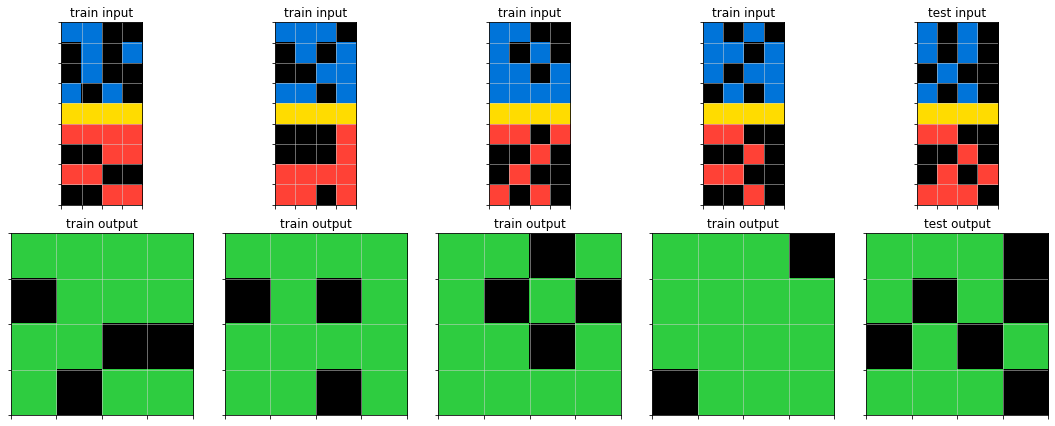

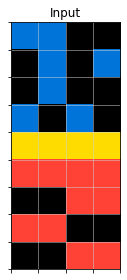

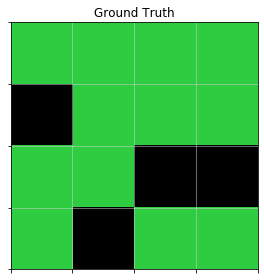

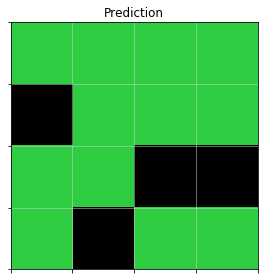

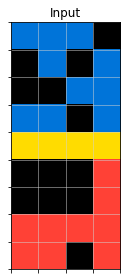

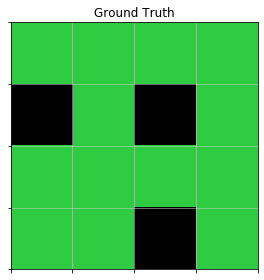

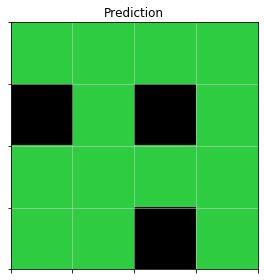

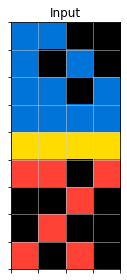

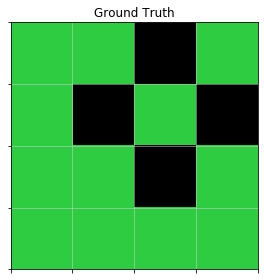

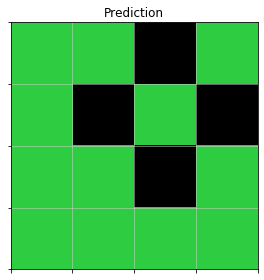

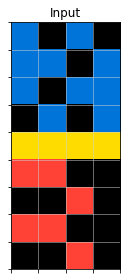

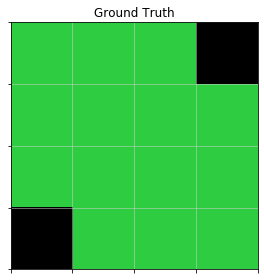

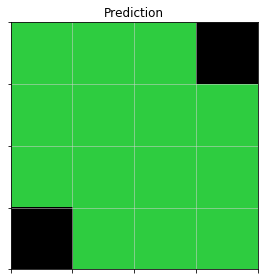

In [369]:
task = Task(training_path / '1190e5a7.json')
task.plot()
solution = 'input-groupByColor-pushUniqueShape'
data = initializeData(task,solution)
g = Graph(solution)
r = g.evaluate(data,task.knowledge)
for x,y,y_hat in zip(task.x,task.y,data[solution]):
    if type(y_hat) == type(None): continue
    plotGrid(x,'Input')
    plotGrid(y,'Ground Truth')
    plotGrid(y_hat,'Prediction')

In [ ]:
# Conv testing

# conv = np.array([[[0,0,0],
#                   [0,0,0],
#                   [0,0,0]], # Black
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]], # Blue
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]], # Red
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]], # Green
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]], # 
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]],
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]],
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]],
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]],
#                  [[0,0,0],
#                   [0,0,0],
#                   [0,0,0]],])
# channels = pixmapToChannels(task.x[0])
# channels = convolve(channels,conv)
# plotGrid(channelsToPixmap(channels))